## Loading Data

In [173]:
import os
import re
import ast
import typing
import requests
import icalendar
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from bs4 import BeautifulSoup
from datetime import date, datetime
from icalendar import Calendar, Event, vCalAddress, vText

pd.set_option('display.max_columns', None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [174]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
YEARS = [2023, 2022, 2021, 2020, 2019]
MONTHS = ['Gener', 'Febrer', 'Marc', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']

In [4]:
os.makedirs('./bicing', exist_ok=True)

if not len(os.listdir('./bicing')):
    i2m = list(zip(range(1,13), MONTHS))
    for year in YEARS:
        for month, month_name in i2m:        
            os.system(f"wget 'https://opendata-ajuntament.barcelona.cat/resources/bcn/BicingBCN/{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"7z x '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")
            os.system(f"mv '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv' './bicing' ")
            os.system(f"rm '{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.7z'")

In [5]:
df = pd.DataFrame()

In [6]:
def get_datetime(miliseconds: int):
    return datetime.fromtimestamp(miliseconds)

def create_date_df(df: pd.DataFrame):
    df['date'] = pd.to_datetime(
        df['last_reported'].apply(lambda x: get_datetime(x))
    )
    
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['hour'] = df['date'].dt.hour
    df['day'] = df['date'].dt.day
    
    return df

In [7]:
def create_date_time(row):
    return datetime(
        int(row['year']),
        int(row['month']),
        int(row['day']),
        int(row['hour'])
    )

In [8]:
def process_new_df(new_df: pd.DataFrame):
    # Unique values
    new_df = new_df.drop_duplicates()
    new_df = new_df.dropna(subset=['last_reported', 'last_updated'], axis=0)
    new_df = new_df.sort_values('last_reported', ascending=True)
    
    # Convert some categorical into numerical
    new_df.status = np.where(new_df.status == 'IN_SERVICE', 1, 0)
    new_df.is_charging_station = np.where(new_df.is_charging_station, 1, 0)
    
    # Create the dates from timestamp and group statistics
    new_df = create_date_df(new_df)
    new_df = new_df\
        .groupby(['station_id', 'year', 'month', 'day', 'hour'])\
        .mean(numeric_only=True)\
        .reset_index()
    
    # Creation of the dates
    new_df['date_time'] = new_df.apply(lambda row: create_date_time(row), axis=1)
    new_df['date'] = new_df.date_time.dt.date
    
    # Create percentage of docks availability
    new_df['percentage_docks_available'] = new_df['num_bikes_available'] / new_df['num_docks_available']

    return new_df

In [10]:
def get_df_processed(df, file_name_csv: str = 'df_processed.csv'):
    if os.path.exists(file_name_csv):
        return pd.read_csv(file_name_csv)
        
    for csv in tqdm(os.listdir('./bicing')):
        new_df = pd.read_csv('./bicing/' + csv)
        new_df = process_new_df(new_df)

        # Filter out incorrect dates
        year, month, *_ = csv.split('_')
        year, month = int(year), int(month)
        new_df = new_df[(new_df.year == year) & (new_df.month == month)]

        df = pd.concat(
            [df, new_df], 
            axis=0
        )
    
    df.to_csv(file_name_csv, index=False, header=True)
    return df

df = get_df_processed(df)

In [11]:
# Handle NaN: Assume that the NaN in traffic is 0
df.traffic = df.traffic.replace(np.nan, 0)

In [12]:
df.shape

(15098574, 21)

In [13]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6    1     0             7.727273   
1           1  2020      6    1     1             8.076923   
2           1  2020      6    1     2             7.750000   
3           1  2020      6    1     3             8.000000   
4           1  2020      6    1     4             8.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                              7.727273                              0.0   
1                              8.076923                              0.0   
2                              7.750000                              0.0   
3                              8.000000                              0.0   
4                              8.000000                              0.0   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            36.272727           1.0         1.0           1.0   1.590964e+09   
1            35.923077           1.0         1.0           1.0   1.590968e+09   
2            36.250000           1.0         1.0           1.0   1.590971e+09   
3            36.000000           1.0         1.0           1.0   1.590975e+09   
4            36.000000           1.0         1.0           1.0   1.590979e+09   

   is_charging_station  status  last_updated        ttl            date_time  \
0                  1.0     1.0  1.590964e+09  17.363636  2020-06-01 00:00:00   
1                  1.0     1.0  1.590968e+09  15.461538  2020-06-01 01:00:00   
2                  1.0     1.0  1.590972e+09  14.083333  2020-06-01 02:00:00   
3                  1.0     1.0  1.590975e+09  14.250000  2020-06-01 03:00:00   
4                  1.0     1.0  1.590979e+09  19.250000  2020-06-01 04:00:00   

         date  percentage_docks_available  traffic  
0  2020-06-01                    0.213033      0.0  
1  2020-06-01                    0.224839      0.0  
2  2020-06-01                    0.213793      0.0  
3  2020-06-01                    0.222222      0.0  
4  2020-06-01                    0.222222      0.0

### Add station information

In [14]:
def get_station_json(
    url: str = 'https://opendata-ajuntament.barcelona.cat/data/dataset/bd2462df-6e1e-4e37-8205-a4b8e7313b84/resource/e5adca8d-98bf-42c3-9b9c-364ef0a80494/download'
):
    
    res = requests.get(url)
    return res.json()

In [15]:
station_json = get_station_json()

In [16]:
station_df = pd.DataFrame(station_json['data']['stations'])
station_df.head()

station_id                                 name physical_configuration  \
0           1        GRAN VIA CORTS CATALANES, 760    ELECTRICBIKESTATION   
1           2                C/ ROGER DE FLOR, 126    ELECTRICBIKESTATION   
2           3                        C/ NÀPOLS, 82    ELECTRICBIKESTATION   
3           4                         C/ RIBES, 13    ELECTRICBIKESTATION   
4           5  PG. LLUIS COMPANYS, 11 (ARC TRIOMF)    ELECTRICBIKESTATION   

         lat       lon  altitude                              address  \
0  41.397978  2.180107      16.0        GRAN VIA CORTS CATALANES, 760   
1  41.395488  2.177198      17.0                C/ ROGER DE FLOR, 126   
2  41.394156  2.181331      11.0                        C/ NÀPOLS, 82   
3  41.393317  2.181248       8.0                         C/ RIBES, 13   
4  41.391103  2.180176       7.0  PG. LLUIS COMPANYS, 11 (ARC TRIOMF)   

  post_code  capacity  is_charging_station  nearby_distance  \
0     08013        46                 True           1000.0   
1     08013        29                 True           1000.0   
2     08013        27                 True           1000.0   
3     08013        21                 True           1000.0   
4     08018        39                 True           1000.0   

   _ride_code_support rental_uris cross_street  
0                True        None          NaN  
1                True        None          NaN  
2                True        None          NaN  
3                True        None          NaN  
4                True        None          NaN

In [17]:
# Some fields are not going to be used
station_drop_fields = [
    'physical_configuration',          # unique value: ELECTRICBIKESTATION
    '_ride_code_support',              # unique value: all True
    'nearby_distance',                 # unique value: 1000
    'name', 'address', 'post_code',    # too specific to each of the stations
    'is_charging_station',             # already in the main df
    'rental_uris', 'cross_street',     # vast majority are none
    
]

In [18]:
station_df = station_df.drop(station_drop_fields, axis=1)
station_df.head()

station_id        lat       lon  altitude  capacity
0           1  41.397978  2.180107      16.0        46
1           2  41.395488  2.177198      17.0        29
2           3  41.394156  2.181331      11.0        27
3           4  41.393317  2.181248       8.0        21
4           5  41.391103  2.180176       7.0        39

In [19]:
df = pd.merge(df, station_df, how='left') # TODO: Handle NaN station information

In [20]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6    1     0             7.727273   
1           1  2020      6    1     1             8.076923   
2           1  2020      6    1     2             7.750000   
3           1  2020      6    1     3             8.000000   
4           1  2020      6    1     4             8.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                              7.727273                              0.0   
1                              8.076923                              0.0   
2                              7.750000                              0.0   
3                              8.000000                              0.0   
4                              8.000000                              0.0   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            36.272727           1.0         1.0           1.0   1.590964e+09   
1            35.923077           1.0         1.0           1.0   1.590968e+09   
2            36.250000           1.0         1.0           1.0   1.590971e+09   
3            36.000000           1.0         1.0           1.0   1.590975e+09   
4            36.000000           1.0         1.0           1.0   1.590979e+09   

   is_charging_station  status  last_updated        ttl            date_time  \
0                  1.0     1.0  1.590964e+09  17.363636  2020-06-01 00:00:00   
1                  1.0     1.0  1.590968e+09  15.461538  2020-06-01 01:00:00   
2                  1.0     1.0  1.590972e+09  14.083333  2020-06-01 02:00:00   
3                  1.0     1.0  1.590975e+09  14.250000  2020-06-01 03:00:00   
4                  1.0     1.0  1.590979e+09  19.250000  2020-06-01 04:00:00   

         date  percentage_docks_available  traffic        lat       lon  \
0  2020-06-01                    0.213033      0.0  41.397978  2.180107   
1  2020-06-01                    0.224839      0.0  41.397978  2.180107   
2  2020-06-01                    0.213793      0.0  41.397978  2.180107   
3  2020-06-01                    0.222222      0.0  41.397978  2.180107   
4  2020-06-01                    0.222222      0.0  41.397978  2.180107   

   altitude  capacity  
0      16.0      46.0  
1      16.0      46.0  
2      16.0      46.0  
3      16.0      46.0  
4      16.0      46.0

### Add Weather information

Add information relative to the wather ([source](https://www.visualcrossing.com/weather/weather-data-services#))


In [21]:
print('Start date: ', df['date'].min())
print('End date: ', df['date'].max())

Start date:  2019-07-01
End date:  2023-05-31


In [22]:
def weather_api_extraction(url: str) -> pd.DataFrame:
    response = requests.get(url)
    response_json = response.json()
    
    weather_df = pd.json_normalize(response_json['days'])
    
    return weather_df

In [23]:
def weather_df_drop_columns(
    weather_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'datetimeEpoch', 
        'tzoffset', 
        'source',
        'name',                     # all barcelona
        'stations',                 # which stations tracked that weather
        'severerisk'                # all nulls
        'precipprob',               # 100 if it rains, 0 otherwise. Doesn't add new info
        'preciptype',               # 'rain' if it rains, 'snow' if it snows. Doesn't add new info
        'sunrise', 'sunset',        # simplify variables, too specific
        'description',              # simplify variables, too specific
        'sunrise',                  # simplify variables, too specific
        'sunset',                   # simplify variables, too specific
        'moonphase',                # simplify variables, too specific
        'sealevelpressure',         # simplify variables, too specific
    ]
):
    
    return weather_df.drop(columns_to_drop, axis=1, errors='ignore')

In [24]:
def process_weather_df(weather_df: pd.DataFrame) -> pd.DataFrame:
    weather_df.datetime = pd.to_datetime(weather_df.datetime)
    weather_df['date'] = weather_df.datetime.dt.date
    
    return weather_df

In [25]:
os.makedirs('./weather', exist_ok=True)

if not len(os.listdir('./weather')):
    weather_url1 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2019-03-28/2021-11-30?unitGroup=metric&include=days&key=4T9KXABWNUV92K2WTZMA7JXZ3&contentType=json'
    weather_df1 = weather_api_extraction(weather_url1)
    weather_df1.to_csv('./weather/weather_2019_03_28_to_2021_11_30.csv', index=False, header=True)
    
    weather_url2 = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/barcelona/2021-12-01/2023-04-30?unitGroup=metric&include=days&key=6NT6N8CRPMNTAEE2FH2EQZ98U&contentType=json'
    weather_df2 = weather_api_extraction(weather_url2)
    weather_df2.to_csv('./weather/weather_2021_12_01_to_2023_04_30.csv', index=False, header=True)

else:
    weather_df1 = pd.read_csv('./weather/weather_2019_03_28_to_2021_11_30.csv')
    weather_df2 = pd.read_csv('./weather/weather_2021_12_01_to_2023_04_30.csv')   

In [26]:
weather_df = pd\
    .concat([weather_df1, weather_df2], axis=0)\
    .reset_index(drop=True)

In [27]:
weather_df = weather_df_drop_columns(weather_df)
weather_df = process_weather_df(weather_df)

In [28]:
weather_df.head()

datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
0 2019-03-28     16.8      6.4  12.1          16.8           3.7       11.5   
1 2019-03-29     16.3      8.8  12.8          16.3           6.7       12.6   
2 2019-03-30     16.0      6.4  12.0          16.0           4.2       11.6   
3 2019-03-31     15.9      8.4  12.5          15.9           6.9       12.4   
4 2019-04-01     17.3      9.8  13.8          17.3           9.0       13.7   

   dew  humidity  precip  precipprob  precipcover  snow  snowdepth  windgust  \
0  4.4      60.6     0.0         0.0          0.0   0.0        0.0      21.5   
1  5.1      60.6     0.0         0.0          0.0   0.0        0.0      24.8   
2  5.8      66.0     0.0         0.0          0.0   0.0        0.0      24.3   
3  7.9      73.5     0.0         0.0          0.0   0.0        0.0      37.6   
4  6.1      60.7     0.0         0.0          0.0   0.0        0.0      23.4   

   windspeed  winddir  pressure  cloudcover  visibility  solarradiation  \
0       17.3     42.8    1027.6         1.1        16.1           221.4   
1       19.8     76.9    1027.2         8.9        16.1           222.3   
2       19.1     79.9    1023.8        29.4        15.5           224.5   
3       31.2     71.2    1017.5        50.3        14.7           154.2   
4       18.1    126.5    1015.2        35.0        15.3           214.7   

   solarenergy  uvindex  sunriseEpoch  sunsetEpoch        conditions  \
0         19.2      7.0    1553751710   1553796707             Clear   
1         19.1      7.0    1553838009   1553883172             Clear   
2         19.6      7.0    1553924308   1553969637  Partially cloudy   
3         12.8      6.0    1554010607   1554056102  Partially cloudy   
4         18.6      7.0    1554096907   1554142567  Partially cloudy   

                icon  severerisk        date  
0          clear-day         NaN  2019-03-28  
1          clear-day         NaN  2019-03-29  
2  partly-cloudy-day         NaN  2019-03-30  
3  partly-cloudy-day         NaN  2019-03-31  
4  partly-cloudy-day         NaN  2019-04-01

In [30]:
df.date = pd.to_datetime(df.date).dt.date
weather_df.date = pd.to_datetime(weather_df.date).dt.date

df = pd.merge(df, weather_df, left_on='date', right_on='date', how='left')

In [31]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6    1     0             7.727273   
1           1  2020      6    1     1             8.076923   
2           1  2020      6    1     2             7.750000   
3           1  2020      6    1     3             8.000000   
4           1  2020      6    1     4             8.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                              7.727273                              0.0   
1                              8.076923                              0.0   
2                              7.750000                              0.0   
3                              8.000000                              0.0   
4                              8.000000                              0.0   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            36.272727           1.0         1.0           1.0   1.590964e+09   
1            35.923077           1.0         1.0           1.0   1.590968e+09   
2            36.250000           1.0         1.0           1.0   1.590971e+09   
3            36.000000           1.0         1.0           1.0   1.590975e+09   
4            36.000000           1.0         1.0           1.0   1.590979e+09   

   is_charging_station  status  last_updated        ttl            date_time  \
0                  1.0     1.0  1.590964e+09  17.363636  2020-06-01 00:00:00   
1                  1.0     1.0  1.590968e+09  15.461538  2020-06-01 01:00:00   
2                  1.0     1.0  1.590972e+09  14.083333  2020-06-01 02:00:00   
3                  1.0     1.0  1.590975e+09  14.250000  2020-06-01 03:00:00   
4                  1.0     1.0  1.590979e+09  19.250000  2020-06-01 04:00:00   

         date  percentage_docks_available  traffic        lat       lon  \
0  2020-06-01                    0.213033      0.0  41.397978  2.180107   
1  2020-06-01                    0.224839      0.0  41.397978  2.180107   
2  2020-06-01                    0.213793      0.0  41.397978  2.180107   
3  2020-06-01                    0.222222      0.0  41.397978  2.180107   
4  2020-06-01                    0.222222      0.0  41.397978  2.180107   

   altitude  capacity   datetime  tempmax  tempmin  temp  feelslikemax  \
0      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
1      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
2      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
3      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
4      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   

   feelslikemin  feelslike   dew  humidity  precip  precipprob  precipcover  \
0          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
1          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
2          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
3          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
4          18.1       21.5  17.6      78.5   0.196       100.0         8.33   

   snow  snowdepth  windgust  windspeed  winddir  pressure  cloudcover  \
0   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
1   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
2   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
3   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
4   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   

   visibility  solarradiation  solarenergy  uvindex  sunriseEpoch  \
0        17.5           182.8         15.7      8.0  1.590985e+09   
1        17.5           182.8         15.7      8.0  1.590985e+09   
2        17.5           182.8         15.7      8.0  1.590985e+09   
3        17.5           182.8         15.7      8.0  1.590985e+09   
4        17.5           182.8         15.7  

### Add Covid Information

The daily covid cases that there were in Barcelona ([source](https://www.amb.cat/en/web/area-metropolitana/dades-obertes/cataleg/detall/-/dataset/covid-19-positive-cases/9147624/11692))

In [32]:
def get_covid_json(
    url: str = "https://opendata-ajuntament.barcelona.cat/data/api/action/datastore_search_sql?sql=SELECT%20*%20from%20%22f627ac0a-d05f-416d-9773-eeb464a3fc44%22%20WHERE%20%22Nom_Indicador%22%20LIKE%20%27Casos%20de%20COVID-19%20a%20Barcelona%20(diari)%27"
):
    
    res_covid = requests.get(url)
    return res_covid.json()['result']['records']

In [33]:
covid_json = get_covid_json()

In [34]:
covid_df = pd.DataFrame(covid_json)
covid_df.head()

Nom_Variable                                   Font Data_Indicador  \
0               Agència de Salut Pública de Barcelona     2020-02-25   
1               Agència de Salut Pública de Barcelona     2020-02-26   
2               Agència de Salut Pública de Barcelona     2020-02-27   
3               Agència de Salut Pública de Barcelona     2020-02-28   
4               Agència de Salut Pública de Barcelona     2020-02-29   

   Territori                                         _full_text  \
0  Barcelona  '-02':11 '-19':16 '-25':12 '1':9 '2020':10 'ag...   
1  Barcelona  '-02':11 '-19':17 '-26':12 '0':9 '2020':10 'ag...   
2  Barcelona  '-02':11 '-19':17 '-27':12 '0':9 '2020':10 'ag...   
3  Barcelona  '-02':19 '-19':13 '-28':20 '0':9 '2020':18 'ag...   
4  Barcelona  '-02':19 '-19':14 '-29':20 '0':9 '2020':18 'ag...   

  Frequencia_Indicador Valor  _id                          Nom_Indicador  \
0                diari     1    1  Casos de COVID-19 a Barcelona (diari)   
1                diari     0    2  Casos de COVID-19 a Barcelona (diari)   
2                diari     0    3  Casos de COVID-19 a Barcelona (diari)   
3                diari     0    4  Casos de COVID-19 a Barcelona (diari)   
4                diari     0    5  Casos de COVID-19 a Barcelona (diari)   

   Unitat  
0  Nombre  
1  Nombre  
2  Nombre  
3  Nombre  
4  Nombre

In [35]:
covid_df.shape

(773, 10)

In [36]:
covid_df = covid_df[['Data_Indicador', 'Valor']]
covid_df.head()

Data_Indicador Valor
0     2020-02-25     1
1     2020-02-26     0
2     2020-02-27     0
3     2020-02-28     0
4     2020-02-29     0

In [37]:
covid_df['date'] = pd.to_datetime(covid_df.Data_Indicador).dt.date

In [38]:
covid_df = covid_df\
    .drop('Data_Indicador', axis=1)\
    .rename(columns={'Valor': 'covid_cases'})

In [39]:
covid_df.head()

covid_cases        date
0           1  2020-02-25
1           0  2020-02-26
2           0  2020-02-27
3           0  2020-02-28
4           0  2020-02-29

In [40]:
df = pd.merge(
    df, 
    covid_df, 
    how='left', 
    left_on='date', 
    right_on='date'
)

We only have NaN values afterwards (not previous to the start of Covid).

For those NaN, we will replace them by a percentile that is at the bottom (still not 0, as there are cases).

In [41]:
df.covid_cases = df.covid_cases.astype('float')

In [42]:
df.covid_cases.describe()

count    7.882314e+06
mean     6.792263e+02
std      1.279695e+03
min      0.000000e+00
25%      8.400000e+01
50%      2.520000e+02
75%      5.870000e+02
max      8.656000e+03
Name: covid_cases, dtype: float64

<Axes: >

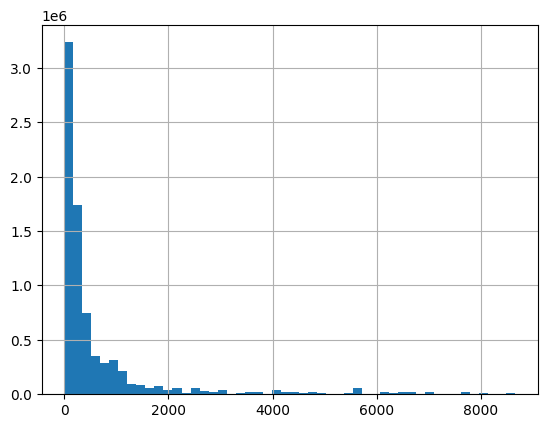

In [43]:
df.covid_cases.hist(bins=50)

In [44]:
def fill_with_percentile(
    df: pd.DataFrame, 
    column: str, 
    percentile: float = 0.03,
    logging: bool = True
):
    
    quantile_value = df[column].quantile(percentile)
    
    if logging:
        print(f'Percentile {percentile} value is: ', quantile_value)
        
    df[column] = df[column].fillna(quantile_value)
    
    return df

In [45]:
df = fill_with_percentile(df, 'covid_cases')

Percentile 0.03 value is:  5.0


We could add also information about in which dates the people where closed into their homes.

In [46]:
confinment_start = '2020-03-14'
confinment_date_start = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [47]:
confinment_end = '2020-06-21'
confinment_date_end = datetime.strptime(confinment_start, '%Y-%m-%d').date()

In [48]:
index_non_confinment = df[
    (df['date'] < confinment_date_start) |
    (df['date'] > confinment_date_end)
].index

In [49]:
df.loc[index_non_confinment, 'confinment'] = 0
df['confinment'] = df['confinment'].fillna(1)
df['confinment'] = df['confinment'].astype('int')

### Barcelona Events

This dataset seems incomplete as yearly events are not repeated. So will not be used for the final model.

In [50]:
os.makedirs('./events', exist_ok=True)

In [51]:
def get_opendataevents_json(url: str = 'https://www.bcn.cat/tercerlloc/files/opendatabcn_agenda.json'):
    res = requests.get(url)
    return res.json()

In [52]:
if not os.path.isfile('./events/opendatabcn_agenda.json'):
    events_json = get_opendataevents_json()
    events_df = pd.DataFrame(events_json)
    events_df.to_csv('./events/opendatabcn_agenda.json', index=False, header=True)

else:
    events_df = pd.read_csv('./events/opendatabcn_agenda.json')

In [53]:
events_df.head()

register_id                        prefix suffix  \
0  99400629715                          None   None   
1  99400622344  Campanya Vacances Estiu 2023   None   
2  99400622349  Campanya Vacances Estiu 2023   None   
3  99400076147                          None   None   
4  99400487142  Campanya Vacances Estiu 2023   None   

                                                name  \
0        Mercat de Pagès a Vallcarca i els Penitents   
1  Casal esportiu 'Parkour i acrobàcies' per a in...   
2  Casal/Campus Esportiu 'Futbol Sala' per a infa...   
3                       Exposició d'art contemporani   
4  Bressol d'estiu per a infants de 1 a 3 anys a ...   

                     created                          modified     status  \
0  2019-06-13T15:01:08+02:00  2023-05-19T10:08:59.023978+02:00  published   
1  2019-03-13T09:45:46+01:00  2023-04-28T11:31:05.717773+02:00  published   
2  2019-03-13T09:54:13+01:00  2023-04-28T11:30:57.736367+02:00  published   
3  2004-03-09T12:49:22+01:00  2022-09-17T06:13:07.492957+02:00  published   
4  2017-03-22T11:08:21+01:00  2023-04-28T11:31:05.750998+02:00  published   

  status_name core_type core_type_name  \
0    Publicat     event         Agenda   
1    Publicat     event         Agenda   
2    Publicat     event         Agenda   
3    Publicat     event         Agenda   
4    Publicat     event         Agenda   

                                                body  \
0  <p>Parades de productes ecològics, de proximit...   
1  <p>Campus de parkour i acrobàcies.</p><p>Insta...   
2  <p>CAMPUS DE TECNIFICACIÓ FUTBOL SALA Instal·l...   
3  <p>Aquest museu té un fons artístic de més de ...   
4  <p>A traves d’un conte il·lustrat, tot aprofun...   

                      tickets_data  \
0    [{'id': 3, 'name': 'Lliure'}]   
1  [{'id': 4, 'name': 'Pagament'}]   
2  [{'id': 4, 'name': 'Pagament'}]   
3  [{'id': 4, 'name': 'Pagament'}]   
4  [{'id': 4, 'name': 'Pagament'}]   

                                           addresses  \
0  [{'place': 'plaça del metro de Vallcarca', 'di...   
1  [{'place': 'Institut Salvador Seguí', 'distric...   
2  [{'place': 'Institut Salvador Seguí', 'distric...   
3  [{'place': None, 'district_name': 'Sants-Montj...   
4  [{'place': None, 'district_name': 'Horta-Guina...   

                                   entity_types_data  \
0  [{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...   
1  [{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...   
2  [{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...   
3  [{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...   
4  [{'id': 101, 'name': 'agenda'}, {'id': 100, 'n...   

                                attribute_categories  \
0  [{'id': 2, 'name': 'Informació d'interès', 'at...   
1  [{'id': 2, 'name': 'Informació d'interès', 'at...   
2  [{'id': 2, 'name': 'Informació d'interès', 'at...   
3  [{'id': 2, 'name': 'Informació d'interès', 'at...   
4  [{'id': 2, 'name': 'Informació d'interès', 'at...   

                                              values  \
0  [{'id': 114759, 'value': 'http://www.facebook....   
1  [{'id': 114449, 'value': 'http://www.fip3.com/...   
2  [{'id': 113819, 'value': 'http://www.fip3.com/...   
3  [{'id': 83272, 'value': 'http://www.poble-espa...   
4  [{'id': 409268, 'value': 'https://estiudinamic...   

                                  from_relationships to_relationships  \
0                                                 []               []   
1  [{'type_id': 1002, 'name': 'se celebra a', 'en...               []   
2  [{'type_id': 1002, 'name': 'se celebra a', 'en...               []   
3  [{'type_id': 1002, 'name': 'se celebra a', 'en...               []   
4  [{'type_id': 1002, 'name': 'se celebra a', 'en...               []   

                                classifications_data  \
0  [{'id': 2027, 'name': 'Petits mercats ocasiona...   
1  [{'id': 2074000, 'name': 'Casals esportius', '...   
2  [{'id': 2000, 'name': 'Campus', 'full_path': '...   
3  [{'id': 2001, 'name': 'Exposicions', 'f

In [54]:
# Only having active dates
events_df = events_df[events_df.core_type_name != 'Equipament']
events_df = events_df[events_df.event_status == 'ok']

In [55]:
def events_df_drop_columns(
    events_df: pd.DataFrame, 
    columns_to_drop: typing.List[str] = [
        'register_id', 'prefix', 'suffix', 'name', 'created', 'modified', 'status', 'status_name',     # too specific
        'core_type', 'core_type_name',                                                                 # most is only one type of value
        'body', 'tickets_data', 'addresses', 'entity_types_data', 'attribute_categories', 'values',
        'from_relationships', 'to_relationships', 'classifications_data', 'secondary_filters_data',
        'timetable', 'image_data', 'gallery_data', 'warnings',                                         # unuseful information
        'is_section_of_data', 'sections_data', 'estimated_dates', 'languages_data', 'type', 'type_name',
        'period', 'period_name', 'event_status_name', 'event_status', 'ical',
        'geo_epgs_25831', 'geo_epgs_23031'                                                             # unwanted loations
    ]
):
    
    return events_df.drop(columns_to_drop, axis=1, errors='ignore')

In [56]:
# Drop columns not wanted
events_df = events_df_drop_columns(events_df)

In [57]:
# Drop events with not enough data
events_df.dropna(
    axis=0, 
    how='any', 
    subset=['geo_epgs_4326', 'start_date'], 
    inplace=True
)

In [58]:
events_df.head()

geo_epgs_4326  \
0  {'x': 41.411870483560705, 'y': 2.1451632515859...   
1   {'x': 41.42309401778554, 'y': 2.196790431984144}   
2   {'x': 41.42309401778554, 'y': 2.196790431984144}   
4  {'x': 41.42214155134015, 'y': 2.1658503000743763}   
5  {'x': 41.37192068979768, 'y': 2.1701826605872294}   

                  start_date                   end_date  
0  2019-10-03T00:00:00+02:00                       None  
1  2023-06-26T03:00:00+02:00  2023-08-04T03:00:00+02:00  
2  2023-06-26T03:00:00+02:00  2023-08-04T03:00:00+02:00  
4  2023-07-17T03:00:00+02:00  2023-07-28T03:00:00+02:00  
5  2009-10-01T00:00:00+02:00                       None

In [59]:
def get_event_geographics(geo_position: str):
    geo_position = ast.literal_eval(geo_position)
    return geo_position['x'], geo_position['y']

In [65]:
events_geographic_x_y = events_df.geo_epgs_4326.apply(lambda x: get_event_geographics(str(x)))
events_df['x'] = [x for x, _ in events_geographic_x_y]
events_df['y'] = [y for _, y in events_geographic_x_y]

events_df = events_df[events_df.x > 0]
events_df = events_df[events_df.y > 0]

events_df.drop(['geo_epgs_4326'], axis=1, inplace=True)

In [61]:
# In the case of null values of end date, we will assume is the same as start date (we will consider only days)
events_df.end_date.fillna(events_df.start_date, inplace=True)

In [66]:
events_df['start_date'] = pd.to_datetime(events_df['start_date'], utc=True).dt.date
events_df['end_date'] = pd.to_datetime(events_df['end_date'], utc=True).dt.date

In [67]:
# Filter out by maximum and minimum dates of df
df_min_date, df_max_date = df.date.min(), df.date.max()

events_df = events_df[events_df.start_date > df_min_date]
events_df = events_df[events_df.end_date < df_max_date]

In [68]:
print(events_df.shape)
events_df.head()

(84, 4)


start_date    end_date          x         y
0    2019-10-02  2019-10-02  41.411870  2.145163
31   2020-07-14  2020-07-14  41.380700  2.185521
32   2020-07-15  2020-07-15  41.386661  2.171438
74   2023-01-01  2023-01-01  41.400303  2.202462
133  2022-11-03  2022-11-03  41.371326  2.149594

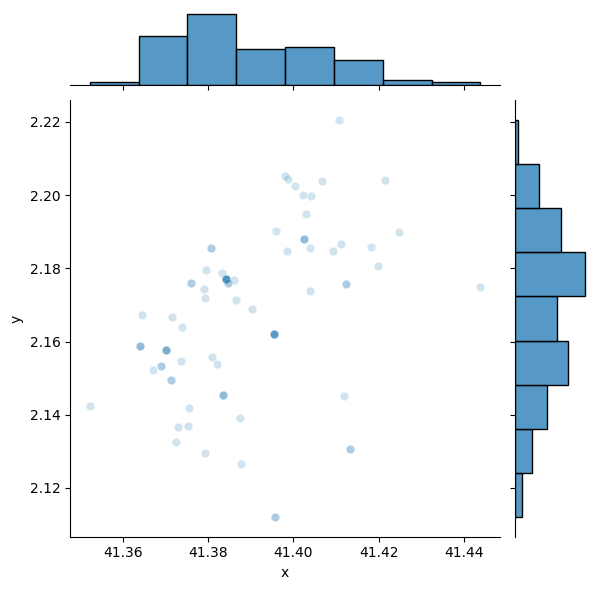

In [69]:
sns.jointplot(x="x", y="y", data=events_df, alpha=0.2)

In [70]:
std_dev_x, std_dev_y = events_df.x.std(), events_df.y.std()

In [71]:
# Filter df by the dates that we have
df_common_events = pd.concat(
    [
        pd.merge(df, events_df, left_on='date', right_on='start_date'), 
        pd.merge(df, events_df, left_on='date', right_on='end_date')
    ],
    axis=0
).drop_duplicates()

In [72]:
print(df_common_events.shape)
df_common_events.head()

(777279, 59)


station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6   17     0            24.500000   
1           1  2020      6   17     1            28.500000   
2           1  2020      6   17     2            28.916667   
3           1  2020      6   17     3            29.000000   
4           1  2020      6   17     4            29.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                             24.416667                         0.083333   
1                             28.250000                         0.250000   
2                             28.833333                         0.083333   
3                             29.000000                         0.000000   
4                             29.000000                         0.000000   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            18.583333           1.0         1.0           1.0   1.592347e+09   
1            14.750000           1.0         1.0           1.0   1.592350e+09   
2            15.166667           1.0         1.0           1.0   1.592354e+09   
3            15.083333           1.0         1.0           1.0   1.592357e+09   
4            17.000000           1.0         1.0           1.0   1.592361e+09   

   is_charging_station  status  last_updated        ttl           date_time  \
0                  1.0     1.0  1.592347e+09   9.083333 2020-06-17 00:00:00   
1                  1.0     1.0  1.592350e+09  17.750000 2020-06-17 01:00:00   
2                  1.0     1.0  1.592354e+09  20.250000 2020-06-17 02:00:00   
3                  1.0     1.0  1.592358e+09  15.916667 2020-06-17 03:00:00   
4                  1.0     1.0  1.592361e+09  14.250000 2020-06-17 04:00:00   

         date  percentage_docks_available  traffic        lat       lon  \
0  2020-06-17                    1.318386      0.0  41.397978  2.180107   
1  2020-06-17                    1.932203      0.0  41.397978  2.180107   
2  2020-06-17                    1.906593      0.0  41.397978  2.180107   
3  2020-06-17                    1.922652      0.0  41.397978  2.180107   
4  2020-06-17                    1.705882      0.0  41.397978  2.180107   

   altitude  capacity   datetime  tempmax  tempmin  temp  feelslikemax  \
0      16.0        46 2020-06-17     25.3     15.7  19.9          25.3   
1      16.0        46 2020-06-17     25.3     15.7  19.9          25.3   
2      16.0        46 2020-06-17     25.3     15.7  19.9          25.3   
3      16.0        46 2020-06-17     25.3     15.7  19.9          25.3   
4      16.0        46 2020-06-17     25.3     15.7  19.9          25.3   

   feelslikemin  feelslike   dew  humidity  precip  precipprob  precipcover  \
0          15.7       19.9  15.6      76.7   0.037       100.0         12.5   
1          15.7       19.9  15.6      76.7   0.037       100.0         12.5   
2          15.7       19.9  15.6      76.7   0.037       100.0         12.5   
3          15.7       19.9  15.6      76.7   0.037       100.0         12.5   
4          15.7       19.9  15.6      76.7   0.037       100.0         12.5   

   snow  snowdepth  windgust  windspeed  winddir  pressure  cloudcover  \
0   0.0        0.0      26.5       21.3    237.3    1015.3        27.0   
1   0.0        0.0      26.5       21.3    237.3    1015.3        27.0   
2   0.0        0.0      26.5       21.3    237.3    1015.3        27.0   
3   0.0        0.0      26.5       21.3    237.3    1015.3        27.0   
4   0.0        0.0      26.5       21.3    237.3    1015.3        27.0   

   visibility  solarradiation  solarenergy  uvindex  sunriseEpoch  \
0        18.3           277.5         23.9      9.0    1592367449   
1        18.3           277.5         23.9      9.0    1592367449   
2        18.3           277.5         23.9      9.0    1592367449   
3        18.3           277.5         23.9      9.0    1592367449   
4        18.3           277.5         23.9      9.

In [81]:
df_common_events.date

0         2020-06-17
1         2020-06-17
2         2020-06-17
3         2020-06-17
4         2020-06-17
             ...    
887867    2020-04-20
887868    2020-04-20
887869    2020-04-20
887870    2020-04-20
887871    2020-04-20
Name: date, Length: 777279, dtype: object

In [110]:
df_common_events.year.unique()

array([2020, 2019, 2021, 2023, 2022], dtype=int32)

In [89]:
with tqdm(total=len(events_df)) as pbar:
    for idx, row in events_df.iterrows():    
        # Filter by the range of the dates
        x, y = row.x, row.y
        start_date, end_date = row['start_date'], row['end_date']
        range_dates = pd.date_range(start_date, end_date)
        range_df = df_common_events[df_common_events.date.isin([range_date.date() for range_date in range_dates])]
        
        if len(range_df) > 0:
            # Near position of the event with relation of the biking center (30% of standard deviations of x & y)
            range_df = range_df[(range_df.lat > x - std_dev_x * 0.3) & (range_df.lat < x + std_dev_x * 0.3)]
            range_df = range_df[(range_df.lat > y - std_dev_y * 0.3) & (range_df.lat < y + std_dev_y * 0.3)]
            df.loc[range_df.index, 'has_event'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:01<00:00, 73.59it/s]


In [90]:
df.has_event = df.has_event.fillna(0)

### Public Holidays

In [73]:
e = open('calendarifestius_en.ics', 'rb')
ecal = icalendar.Calendar.from_ical(e.read())
for component in ecal.walk():
    print(component.name)
e.close()

VCALENDAR
VTIMEZONE
DAYLIGHT
STANDARD
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT
VEVENT


In [74]:
def get_cal_events(ecal):
    # Extract relevant information
    events = []
    for event in ecal.walk('VEVENT'):
        event_data = {
            'Summary': event.get('summary'),
            'Start': event.get('dtstart').dt,
            'End': event.get('dtend').dt,
            # Add more properties as needed
        }
        events.append(event_data)

    # Create a DataFrame from the extracted information
    return pd.DataFrame(events)

In [75]:
df_ecal = get_cal_events(ecal)

# Print the DataFrame
print(df_ecal.dtypes)

Summary    object
Start      object
End        object
dtype: object


In [77]:
df_ecal['Start'] = pd.to_datetime(df_ecal['Start'], utc=True).dt.date
df_ecal['End'] = pd.to_datetime(df_ecal['End'], utc=True).dt.date
df_ecal.head()

Summary       Start         End
0  Epiphany / Three Kings’ Day  2023-01-06  2023-01-07
1                  Good Friday  2023-04-07  2023-04-08
2                Easter Monday  2023-04-10  2023-04-11
3                   Labour Day  2023-05-01  2023-05-02
4  Local holidays in Barcelona  2023-06-05  2023-06-06

In [78]:
df_ecal = df_ecal.rename(columns={
    "Start": 'start_date', 
    "End": 'end_date', 
    "Summary":"name"
})
df_ecal.head()

name  start_date    end_date
0  Epiphany / Three Kings’ Day  2023-01-06  2023-01-07
1                  Good Friday  2023-04-07  2023-04-08
2                Easter Monday  2023-04-10  2023-04-11
3                   Labour Day  2023-05-01  2023-05-02
4  Local holidays in Barcelona  2023-06-05  2023-06-06

In [90]:
with tqdm(total=len(df_ecal)) as pbar:
    for idx, row in df_ecal.iterrows():    
        start_date, end_date = row['start_date'], row['end_date']
        
        for year in YEARS:
            holiday_start_date = date(year, start_date.month, start_date.day)
            holiday_end_date = date(year, end_date.month, end_date.day)
            range_dates = pd.date_range(holiday_start_date, holiday_end_date)
            range_df = df[df.date.isin([range_date.date() for range_date in range_dates])]
            
            if len(range_df) > 0:
                df.loc[range_df.index, 'has_holiday'] = 1

        pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:17<00:00,  1.19s/it]


In [94]:
# Check some dates
df[df.has_holiday.notnull()].head()

station_id  year  month  day  hour  num_bikes_available  \
95           1  2020      6    5     0            16.583333   
96           1  2020      6    5     1            16.000000   
97           1  2020      6    5     2            16.250000   
98           1  2020      6    5     3            17.166667   
99           1  2020      6    5     4            17.583333   

    num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
95                             16.583333                         0.000000   
96                             16.000000                         0.000000   
97                             16.250000                         0.000000   
98                             17.000000                         0.166667   
99                             17.000000                         0.583333   

    num_docks_available  is_installed  is_renting  is_returning  \
95            28.416667           1.0         1.0           1.0   
96            29.000000           1.0         1.0           1.0   
97            28.750000           1.0         1.0           1.0   
98            28.000000           1.0         1.0           1.0   
99            28.416667           1.0         1.0           1.0   

    last_reported  is_charging_station  status  last_updated        ttl  \
95   1.591310e+09                  1.0     1.0  1.591310e+09  18.166667   
96   1.591313e+09                  1.0     1.0  1.591314e+09  14.000000   
97   1.591317e+09                  1.0     1.0  1.591317e+09  17.833333   
98   1.591321e+09                  1.0     1.0  1.591321e+09  16.666667   
99   1.591324e+09                  1.0     1.0  1.591324e+09  13.000000   

              date_time        date  percentage_docks_available  traffic  \
95  2020-06-05 00:00:00  2020-06-05                    0.583578      0.0   
96  2020-06-05 01:00:00  2020-06-05                    0.551724      0.0   
97  2020-06-05 02:00:00  2020-06-05                    0.565217      0.0   
98  2020-06-05 03:00:00  2020-06-05                    0.613095      0.0   
99  2020-06-05 04:00:00  2020-06-05                    0.618768      0.0   

          lat       lon  altitude  capacity   datetime  tempmax  tempmin  \
95  41.397978  2.180107      16.0      46.0 2020-06-05     25.3     15.2   
96  41.397978  2.180107      16.0      46.0 2020-06-05     25.3     15.2   
97  41.397978  2.180107      16.0      46.0 2020-06-05     25.3     15.2   
98  41.397978  2.180107      16.0      46.0 2020-06-05     25.3     15.2   
99  41.397978  2.180107      16.0      46.0 2020-06-05     25.3     15.2   

    temp  feelslikemax  feelslikemin  feelslike   dew  humidity  precip  \
95  19.3          25.3          15.2       19.3  13.4      69.3     0.0   
96  19.3          25.3          15.2       19.3  13.4      69.3     0.0   
97  19.3          25.3          15.2       19.3  13.4      69.3     0.0   
98  19.3          25.3          15.2       19.3  13.4      69.3     0.0   
99  19.3          25.3          15.2       19.3  13.4      69.3     0.0   

    precipprob  precipcover  snow  snowdepth  windgust  windspeed  winddir  \
95         0.0          0.0   0.0        0.0      28.1       25.1    213.5   
96         0.0          0.0   0.0        0.0      28.1       25.1    213.5   
97         0.0          0.0   0.0        0.0      28.1       25.1    213.5   
98         0.0          0.0   0.0        0.0      28.1       25.1    213.5   
99         0.0          0.0   0.0        0.0      28.1       25.1    213.5   

    pressure  cloudcover  visibility  solarradiation  solarenergy  uvindex  \
95    1008.5        31.0        17.9           308.1         26.6      9.0   
96    1008.5        31.0        17.9           308.1         26.6      9.0   
97    1008.5        31.0        17.9           308.1         26.6      9.0   
98    1008.5        31.0        17.9           308.1         26.6      9.0   
99    1008.5        31.0        17.9           308.1         26.6      9.0   

    s

In [97]:
df['has_holiday'] = df['has_holiday'].fillna(0)
df['has_holiday'] = df['has_holiday'].astype('int')

In [98]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6    1     0             7.727273   
1           1  2020      6    1     1             8.076923   
2           1  2020      6    1     2             7.750000   
3           1  2020      6    1     3             8.000000   
4           1  2020      6    1     4             8.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                              7.727273                              0.0   
1                              8.076923                              0.0   
2                              7.750000                              0.0   
3                              8.000000                              0.0   
4                              8.000000                              0.0   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            36.272727           1.0         1.0           1.0   1.590964e+09   
1            35.923077           1.0         1.0           1.0   1.590968e+09   
2            36.250000           1.0         1.0           1.0   1.590971e+09   
3            36.000000           1.0         1.0           1.0   1.590975e+09   
4            36.000000           1.0         1.0           1.0   1.590979e+09   

   is_charging_station  status  last_updated        ttl            date_time  \
0                  1.0     1.0  1.590964e+09  17.363636  2020-06-01 00:00:00   
1                  1.0     1.0  1.590968e+09  15.461538  2020-06-01 01:00:00   
2                  1.0     1.0  1.590972e+09  14.083333  2020-06-01 02:00:00   
3                  1.0     1.0  1.590975e+09  14.250000  2020-06-01 03:00:00   
4                  1.0     1.0  1.590979e+09  19.250000  2020-06-01 04:00:00   

         date  percentage_docks_available  traffic        lat       lon  \
0  2020-06-01                    0.213033      0.0  41.397978  2.180107   
1  2020-06-01                    0.224839      0.0  41.397978  2.180107   
2  2020-06-01                    0.213793      0.0  41.397978  2.180107   
3  2020-06-01                    0.222222      0.0  41.397978  2.180107   
4  2020-06-01                    0.222222      0.0  41.397978  2.180107   

   altitude  capacity   datetime  tempmax  tempmin  temp  feelslikemax  \
0      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
1      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
2      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
3      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
4      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   

   feelslikemin  feelslike   dew  humidity  precip  precipprob  precipcover  \
0          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
1          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
2          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
3          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
4          18.1       21.5  17.6      78.5   0.196       100.0         8.33   

   snow  snowdepth  windgust  windspeed  winddir  pressure  cloudcover  \
0   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
1   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
2   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
3   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
4   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   

   visibility  solarradiation  solarenergy  uvindex  sunriseEpoch  \
0        17.5           182.8         15.7      8.0  1.590985e+09   
1        17.5           182.8         15.7      8.0  1.590985e+09   
2        17.5           182.8         15.7      8.0  1.590985e+09   
3        17.5           182.8         15.7      8.0  1.590985e+09   
4        17.5           182.8         15.7  

### Traffic

In [108]:
os.makedirs('./traffic', exist_ok=True)

In [105]:
TRAFFIC_BASE_URL = "https://opendata-ajuntament.barcelona.cat/data/en/dataset/trams"

In [102]:
response = requests.get(TRAFFIC_BASE_URL)

In [111]:
soup = BeautifulSoup(response.content)
resource_items = soup.find_all("li", {"class": "resource-item"})

In [178]:
for resource_item in resource_items[1:]:
    file_name: str = resource_item.find('a').text[:-4]
    download_path: str = resource_item.find('a', href = re.compile(r'^https://opendata-ajuntament.barcelona.cat/data/dataset/*')).href
        
    if int(file_name[:4])

    anchor_download_path = resource_item.find('a', href=re.compile(r'^https://opendata-ajuntament.barcelona.cat/data/dataset/*'))
    url_download_path = anchor_download_path['href']
    
    os.system(f"wget '{url_download_path}'")
    os.system(f"mv 'download' './traffic/{file_name}' ")

--2023-07-01 11:37:32--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/d3782748-9818-4d3d-a09e-4e8caecb341a/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_01_Gener_TRAMS_TRAMS.csv [following]
--2023-07-01 11:37:32--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_01_Gener_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106520261 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.05M 96s
    50K .......... .......... .......... .......... ..........  0% 1.07M 9

  8650K .......... .......... .......... .......... ..........  8% 40.2M 7s
  8700K .......... .......... .......... .......... ..........  8% 41.0M 7s
  8750K .......... .......... .......... .......... ..........  8% 20.5M 7s
  8800K .......... .......... .......... .......... ..........  8% 31.3M 7s
  8850K .......... .......... .......... .......... ..........  8% 15.3M 7s
  8900K .......... .......... .......... .......... ..........  8% 21.3M 7s
  8950K .......... .......... .......... .......... ..........  8% 7.38M 7s
  9000K .......... .......... .......... .......... ..........  8%  150M 7s
  9050K .......... .......... .......... .......... ..........  8% 18.9M 7s
  9100K .......... .......... .......... .......... ..........  8% 56.1M 7s
  9150K .......... .......... .......... .......... ..........  8% 26.4M 7s
  9200K .......... .......... .......... .......... ..........  8% 18.2M 7s
  9250K .......... .......... .......... .......... ..........  8%  169M 7s
  9300K ....

 17300K .......... .......... .......... .......... .......... 16% 3.93M 5s
 17350K .......... .......... .......... .......... .......... 16% 31.7M 5s
 17400K .......... .......... .......... .......... .......... 16% 62.7M 5s
 17450K .......... .......... .......... .......... .......... 16% 27.0M 5s
 17500K .......... .......... .......... .......... .......... 16% 40.4M 5s
 17550K .......... .......... .......... .......... .......... 16% 37.5M 5s
 17600K .......... .......... .......... .......... .......... 16% 17.1M 5s
 17650K .......... .......... .......... .......... .......... 17% 46.4M 5s
 17700K .......... .......... .......... .......... .......... 17% 29.6M 5s
 17750K .......... .......... .......... .......... .......... 17% 46.5M 5s
 17800K .......... .......... .......... .......... .......... 17% 30.0M 5s
 17850K .......... .......... .......... .......... .......... 17% 17.5M 5s
 17900K .......... .......... .......... .......... .......... 17%  191M 5s
 17950K ....

 22700K .......... .......... .......... .......... .......... 21% 18.6M 5s
 22750K .......... .......... .......... .......... .......... 21% 42.6M 5s
 22800K .......... .......... .......... .......... .......... 21% 11.9M 5s
 22850K .......... .......... .......... .......... .......... 22%  164M 4s
 22900K .......... .......... .......... .......... .......... 22% 10.7M 5s
 22950K .......... .......... .......... .......... .......... 22% 4.31M 5s
 23000K .......... .......... .......... .......... .......... 22% 18.7M 5s
 23050K .......... .......... .......... .......... .......... 22%  217M 5s
 23100K .......... .......... .......... .......... .......... 22% 26.3M 5s
 23150K .......... .......... .......... .......... .......... 22% 33.1M 5s
 23200K .......... .......... .......... .......... .......... 22% 41.3M 4s
 23250K .......... .......... .......... .......... .......... 22% 32.6M 4s
 23300K .......... .......... .......... .......... .......... 22% 33.3M 4s
 23350K ....

 28250K .......... .......... .......... .......... .......... 27% 41.9M 4s
 28300K .......... .......... .......... .......... .......... 27% 18.0M 4s
 28350K .......... .......... .......... .......... .......... 27% 29.8M 4s
 28400K .......... .......... .......... .......... .......... 27% 19.8M 4s
 28450K .......... .......... .......... .......... .......... 27% 15.2M 4s
 28500K .......... .......... .......... .......... .......... 27% 20.7M 4s
 28550K .......... .......... .......... .......... .......... 27% 16.4M 4s
 28600K .......... .......... .......... .......... .......... 27% 32.0M 4s
 28650K .......... .......... .......... .......... .......... 27% 46.1M 4s
 28700K .......... .......... .......... .......... .......... 27% 16.0M 4s
 28750K .......... .......... .......... .......... .......... 27% 46.4M 4s
 28800K .......... .......... .......... .......... .......... 27% 42.3M 4s
 28850K .......... .......... .......... .......... .......... 27% 27.1M 4s
 28900K ....

 38650K .......... .......... .......... .......... .......... 37% 6.60M 3s
 38700K .......... .......... .......... .......... .......... 37% 21.4M 3s
 38750K .......... .......... .......... .......... .......... 37% 23.9M 3s
 38800K .......... .......... .......... .......... .......... 37% 38.4M 3s
 38850K .......... .......... .......... .......... .......... 37% 38.4M 3s
 38900K .......... .......... .......... .......... .......... 37% 31.9M 3s
 38950K .......... .......... .......... .......... .......... 37% 36.2M 3s
 39000K .......... .......... .......... .......... .......... 37% 21.9M 3s
 39050K .......... .......... .......... .......... .......... 37% 25.5M 3s
 39100K .......... .......... .......... .......... .......... 37% 14.0M 3s
 39150K .......... .......... .......... .......... .......... 37%  176M 3s
 39200K .......... .......... .......... .......... .......... 37% 35.3M 3s
 39250K .......... .......... .......... .......... .......... 37% 31.1M 3s
 39300K ....

 49300K .......... .......... .......... .......... .......... 47% 1.19M 3s
 49350K .......... .......... .......... .......... .......... 47% 48.8M 3s
 49400K .......... .......... .......... .......... .......... 47% 4.21M 3s
 49450K .......... .......... .......... .......... .......... 47% 12.5M 3s
 49500K .......... .......... .......... .......... .......... 47% 38.3M 3s
 49550K .......... .......... .......... .......... .......... 47% 10.4M 3s
 49600K .......... .......... .......... .......... .......... 47% 11.7M 3s
 49650K .......... .......... .......... .......... .......... 47%  128M 3s
 49700K .......... .......... .......... .......... .......... 47%  183M 3s
 49750K .......... .......... .......... .......... .......... 47%  183M 3s
 49800K .......... .......... .......... .......... .......... 47%  160M 3s
 49850K .......... .......... .......... .......... .......... 47%  206M 3s
 49900K .......... .......... .......... .......... .......... 48%  249M 3s
 49950K ....

 59900K .......... .......... .......... .......... .......... 57% 19.2M 2s
 59950K .......... .......... .......... .......... .......... 57% 7.07M 2s
 60000K .......... .......... .......... .......... .......... 57%  194M 2s
 60050K .......... .......... .......... .......... .......... 57% 29.1M 2s
 60100K .......... .......... .......... .......... .......... 57% 16.9M 2s
 60150K .......... .......... .......... .......... .......... 57%  268M 2s
 60200K .......... .......... .......... .......... .......... 57% 11.6M 2s
 60250K .......... .......... .......... .......... .......... 57%  222M 2s
 60300K .......... .......... .......... .......... .......... 58% 16.5M 2s
 60350K .......... .......... .......... .......... .......... 58% 51.7M 2s
 60400K .......... .......... .......... .......... .......... 58% 41.2M 2s
 60450K .......... .......... .......... .......... .......... 58% 21.9M 2s
 60500K .......... .......... .......... .......... .......... 58%  151M 2s
 60550K ....

 69700K .......... .......... .......... .......... .......... 67% 16.7M 2s
 69750K .......... .......... .......... .......... .......... 67%  115M 2s
 69800K .......... .......... .......... .......... .......... 67% 31.3M 2s
 69850K .......... .......... .......... .......... .......... 67% 24.0M 2s
 69900K .......... .......... .......... .......... .......... 67% 17.2M 2s
 69950K .......... .......... .......... .......... .......... 67% 36.7M 2s
 70000K .......... .......... .......... .......... .......... 67% 55.8M 2s
 70050K .......... .......... .......... .......... .......... 67% 32.8M 2s
 70100K .......... .......... .......... .......... .......... 67% 19.3M 2s
 70150K .......... .......... .......... .......... .......... 67% 42.6M 2s
 70200K .......... .......... .......... .......... .......... 67% 28.0M 2s
 70250K .......... .......... .......... .......... .......... 67% 91.6M 2s
 70300K .......... .......... .......... .......... .......... 67% 19.8M 2s
 70350K ....

 79000K .......... .......... .......... .......... .......... 75% 12.5M 1s
 79050K .......... .......... .......... .......... .......... 76%  200M 1s
 79100K .......... .......... .......... .......... .......... 76% 32.1M 1s
 79150K .......... .......... .......... .......... .......... 76% 17.3M 1s
 79200K .......... .......... .......... .......... .......... 76% 13.2M 1s
 79250K .......... .......... .......... .......... .......... 76% 14.6M 1s
 79300K .......... .......... .......... .......... .......... 76%  186M 1s
 79350K .......... .......... .......... .......... .......... 76% 29.4M 1s
 79400K .......... .......... .......... .......... .......... 76% 19.8M 1s
 79450K .......... .......... .......... .......... .......... 76% 96.5M 1s
 79500K .......... .......... .......... .......... .......... 76% 17.1M 1s
 79550K .......... .......... .......... .......... .......... 76% 18.3M 1s
 79600K .......... .......... .......... .......... .......... 76% 24.2M 1s
 79650K ....

 90400K .......... .......... .......... .......... .......... 86% 42.2M 1s
 90450K .......... .......... .......... .......... .......... 86% 39.2M 1s
 90500K .......... .......... .......... .......... .......... 87% 24.8M 1s
 90550K .......... .......... .......... .......... .......... 87% 35.3M 1s
 90600K .......... .......... .......... .......... .......... 87% 19.0M 1s
 90650K .......... .......... .......... .......... .......... 87%  167M 1s
 90700K .......... .......... .......... .......... .......... 87% 36.3M 1s
 90750K .......... .......... .......... .......... .......... 87% 38.3M 1s
 90800K .......... .......... .......... .......... .......... 87% 16.8M 1s
 90850K .......... .......... .......... .......... .......... 87% 51.6M 1s
 90900K .......... .......... .......... .......... .......... 87% 56.3M 1s
 90950K .......... .......... .......... .......... .......... 87% 21.4M 1s
 91000K .......... .......... .......... .......... .......... 87% 16.6M 1s
 91050K ....

 96150K .......... .......... .......... .......... .......... 92% 14.9M 0s
 96200K .......... .......... .......... .......... .......... 92% 18.6M 0s
 96250K .......... .......... .......... .......... .......... 92%  207M 0s
 96300K .......... .......... .......... .......... .......... 92% 23.0M 0s
 96350K .......... .......... .......... .......... .......... 92% 20.2M 0s
 96400K .......... .......... .......... .......... .......... 92%  157M 0s
 96450K .......... .......... .......... .......... .......... 92% 43.7M 0s
 96500K .......... .......... .......... .......... .......... 92% 29.5M 0s
 96550K .......... .......... .......... .......... .......... 92% 32.9M 0s
 96600K .......... .......... .......... .......... .......... 92%  106M 0s
 96650K .......... .......... .......... .......... .......... 92% 9.66M 0s
 96700K .......... .......... .......... .......... .......... 93% 18.3M 0s
 96750K .......... .......... .......... .......... .......... 93% 13.5M 0s
 96800K ....

101600K .......... .......... .......... .......... .......... 97% 15.8M 0s
101650K .......... .......... .......... .......... .......... 97% 29.8M 0s
101700K .......... .......... .......... .......... .......... 97% 35.9M 0s
101750K .......... .......... .......... .......... .......... 97% 41.4M 0s
101800K .......... .......... .......... .......... .......... 97% 40.4M 0s
101850K .......... .......... .......... .......... .......... 97% 20.9M 0s
101900K .......... .......... .......... .......... .......... 98% 16.2M 0s
101950K .......... .......... .......... .......... .......... 98% 22.3M 0s
102000K .......... .......... .......... .......... .......... 98%  133M 0s
102050K .......... .......... .......... .......... .......... 98% 10.2M 0s
102100K .......... .......... .......... .......... .......... 98%  362M 0s
102150K .......... .......... .......... .......... .......... 98%  151M 0s
102200K .......... .......... .......... .......... .......... 98% 34.3M 0s
102250K ....

  6700K .......... .......... .......... .......... ..........  7%  549K 7s
  6750K .......... .......... .......... .......... ..........  7% 12.6M 7s
  6800K .......... .......... .......... .......... ..........  7% 6.65M 7s
  6850K .......... .......... .......... .......... ..........  7% 78.8M 7s
  6900K .......... .......... .......... .......... ..........  7% 64.0M 7s
  6950K .......... .......... .......... .......... ..........  7% 74.2M 7s
  7000K .......... .......... .......... .......... ..........  7% 77.8M 7s
  7050K .......... .......... .......... .......... ..........  7% 73.9M 7s
  7100K .......... .......... .......... .......... ..........  7% 27.3M 7s
  7150K .......... .......... .......... .......... ..........  7% 30.3M 7s
  7200K .......... .......... .......... .......... ..........  7% 19.3M 7s
  7250K .......... .......... .......... .......... ..........  7% 21.5M 7s
  7300K .......... .......... .......... .......... ..........  7% 6.03M 7s
  7350K ....

 12450K .......... .......... .......... .......... .......... 13% 19.7M 5s
 12500K .......... .......... .......... .......... .......... 13%  132M 5s
 12550K .......... .......... .......... .......... .......... 13% 11.9M 5s
 12600K .......... .......... .......... .......... .......... 13% 41.2M 5s
 12650K .......... .......... .......... .......... .......... 13% 27.6M 5s
 12700K .......... .......... .......... .......... .......... 13% 18.1M 5s
 12750K .......... .......... .......... .......... .......... 13% 22.5M 5s
 12800K .......... .......... .......... .......... .......... 13% 12.2M 5s
 12850K .......... .......... .......... .......... .......... 13% 21.8M 5s
 12900K .......... .......... .......... .......... .......... 13% 5.05M 5s
 12950K .......... .......... .......... .......... .......... 13% 47.9M 5s
 13000K .......... .......... .......... .......... .......... 14% 25.2M 5s
 13050K .......... .......... .......... .......... .......... 14% 16.9M 5s
 13100K ....

 23600K .......... .......... .......... .......... .......... 25% 12.0M 4s
 23650K .......... .......... .......... .......... .......... 25%  189M 4s
 23700K .......... .......... .......... .......... .......... 25%  221M 4s
 23750K .......... .......... .......... .......... .......... 25% 24.2M 4s
 23800K .......... .......... .......... .......... .......... 25%  193M 4s
 23850K .......... .......... .......... .......... .......... 25% 21.9M 4s
 23900K .......... .......... .......... .......... .......... 25% 35.5M 4s
 23950K .......... .......... .......... .......... .......... 25% 35.1M 4s
 24000K .......... .......... .......... .......... .......... 25% 51.7M 4s
 24050K .......... .......... .......... .......... .......... 25% 12.0M 4s
 24100K .......... .......... .......... .......... .......... 25% 49.1M 4s
 24150K .......... .......... .......... .......... .......... 26%  228M 4s
 24200K .......... .......... .......... .......... .......... 26% 18.9M 4s
 24250K ....

 29550K .......... .......... .......... .......... .......... 31% 24.8M 3s
 29600K .......... .......... .......... .......... .......... 31% 20.0M 3s
 29650K .......... .......... .......... .......... .......... 31% 17.8M 3s
 29700K .......... .......... .......... .......... .......... 31%  284M 3s
 29750K .......... .......... .......... .......... .......... 32% 47.2M 3s
 29800K .......... .......... .......... .......... .......... 32% 35.0M 3s
 29850K .......... .......... .......... .......... .......... 32% 19.3M 3s
 29900K .......... .......... .......... .......... .......... 32%  169M 3s
 29950K .......... .......... .......... .......... .......... 32% 29.8M 3s
 30000K .......... .......... .......... .......... .......... 32% 37.0M 3s
 30050K .......... .......... .......... .......... .......... 32% 13.0M 3s
 30100K .......... .......... .......... .......... .......... 32% 45.6M 3s
 30150K .......... .......... .......... .......... .......... 32% 34.7M 3s
 30200K ....

 35650K .......... .......... .......... .......... .......... 38% 14.9M 3s
 35700K .......... .......... .......... .......... .......... 38% 12.1M 3s
 35750K .......... .......... .......... .......... .......... 38%  359M 3s
 35800K .......... .......... .......... .......... .......... 38% 17.4M 3s
 35850K .......... .......... .......... .......... .......... 38%  244M 3s
 35900K .......... .......... .......... .......... .......... 38% 19.8M 3s
 35950K .......... .......... .......... .......... .......... 38% 40.0M 3s
 36000K .......... .......... .......... .......... .......... 38% 60.1M 3s
 36050K .......... .......... .......... .......... .......... 38% 26.9M 3s
 36100K .......... .......... .......... .......... .......... 38% 28.9M 3s
 36150K .......... .......... .......... .......... .......... 38% 35.1M 3s
 36200K .......... .......... .......... .......... .......... 38% 35.0M 3s
 36250K .......... .......... .......... .......... .......... 39% 18.7M 3s
 36300K ....

 41050K .......... .......... .......... .......... .......... 44% 6.76M 3s
 41100K .......... .......... .......... .......... .......... 44%  250M 3s
 41150K .......... .......... .......... .......... .......... 44%  125M 3s
 41200K .......... .......... .......... .......... .......... 44% 16.9M 3s
 41250K .......... .......... .......... .......... .......... 44% 14.7M 3s
 41300K .......... .......... .......... .......... .......... 44% 33.2M 3s
 41350K .......... .......... .......... .......... .......... 44% 49.2M 3s
 41400K .......... .......... .......... .......... .......... 44% 16.6M 3s
 41450K .......... .......... .......... .......... .......... 44%  225M 2s
 41500K .......... .......... .......... .......... .......... 44% 68.0M 2s
 41550K .......... .......... .......... .......... .......... 44% 19.9M 2s
 41600K .......... .......... .......... .......... .......... 44% 23.3M 2s
 41650K .......... .......... .......... .......... .......... 44% 86.3M 2s
 41700K ....

 50100K .......... .......... .......... .......... .......... 53% 9.06M 2s
 50150K .......... .......... .......... .......... .......... 53% 5.80M 2s
 50200K .......... .......... .......... .......... .......... 54%  216M 2s
 50250K .......... .......... .......... .......... .......... 54% 90.9M 2s
 50300K .......... .......... .......... .......... .......... 54%  198M 2s
 50350K .......... .......... .......... .......... .......... 54% 11.8M 2s
 50400K .......... .......... .......... .......... .......... 54% 39.9M 2s
 50450K .......... .......... .......... .......... .......... 54% 8.92M 2s
 50500K .......... .......... .......... .......... .......... 54% 95.2M 2s
 50550K .......... .......... .......... .......... .......... 54%  245M 2s
 50600K .......... .......... .......... .......... .......... 54% 95.7M 2s
 50650K .......... .......... .......... .......... .......... 54% 8.36M 2s
 50700K .......... .......... .......... .......... .......... 54%  165M 2s
 50750K ....

 55650K .......... .......... .......... .......... .......... 59% 15.9M 2s
 55700K .......... .......... .......... .......... .......... 59% 16.0M 2s
 55750K .......... .......... .......... .......... .......... 59% 96.5M 2s
 55800K .......... .......... .......... .......... .......... 60% 34.0M 2s
 55850K .......... .......... .......... .......... .......... 60%  414M 2s
 55900K .......... .......... .......... .......... .......... 60% 19.9M 2s
 55950K .......... .......... .......... .......... .......... 60% 29.8M 2s
 56000K .......... .......... .......... .......... .......... 60% 34.2M 2s
 56050K .......... .......... .......... .......... .......... 60% 9.56M 2s
 56100K .......... .......... .......... .......... .......... 60% 35.9M 2s
 56150K .......... .......... .......... .......... .......... 60% 22.0M 2s
 56200K .......... .......... .......... .......... .......... 60%  120M 2s
 56250K .......... .......... .......... .......... .......... 60% 8.99M 2s
 56300K ....

 61100K .......... .......... .......... .......... .......... 65% 16.0M 1s
 61150K .......... .......... .......... .......... .......... 65% 9.56M 1s
 61200K .......... .......... .......... .......... .......... 65% 13.5M 1s
 61250K .......... .......... .......... .......... .......... 65% 29.3M 1s
 61300K .......... .......... .......... .......... .......... 65% 29.5M 1s
 61350K .......... .......... .......... .......... .......... 66%  226M 1s
 61400K .......... .......... .......... .......... .......... 66% 10.9M 1s
 61450K .......... .......... .......... .......... .......... 66%  235M 1s
 61500K .......... .......... .......... .......... .......... 66% 22.5M 1s
 61550K .......... .......... .......... .......... .......... 66% 28.5M 1s
 61600K .......... .......... .......... .......... .......... 66% 46.5M 1s
 61650K .......... .......... .......... .......... .......... 66% 16.3M 1s
 61700K .......... .......... .......... .......... .......... 66%  194M 1s
 61750K ....

 66700K .......... .......... .......... .......... .......... 71% 17.5M 1s
 66750K .......... .......... .......... .......... .......... 71%  212M 1s
 66800K .......... .......... .......... .......... .......... 71% 53.2M 1s
 66850K .......... .......... .......... .......... .......... 71% 35.7M 1s
 66900K .......... .......... .......... .......... .......... 71% 6.29M 1s
 66950K .......... .......... .......... .......... .......... 72%  208M 1s
 67000K .......... .......... .......... .......... .......... 72% 24.2M 1s
 67050K .......... .......... .......... .......... .......... 72% 18.4M 1s
 67100K .......... .......... .......... .......... .......... 72%  237M 1s
 67150K .......... .......... .......... .......... .......... 72% 14.8M 1s
 67200K .......... .......... .......... .......... .......... 72% 16.6M 1s
 67250K .......... .......... .......... .......... .......... 72%  196M 1s
 67300K .......... .......... .......... .......... .......... 72% 21.6M 1s
 67350K ....

 72400K .......... .......... .......... .......... .......... 77% 19.2M 1s
 72450K .......... .......... .......... .......... .......... 77% 92.5M 1s
 72500K .......... .......... .......... .......... .......... 77% 15.7M 1s
 72550K .......... .......... .......... .......... .......... 78%  239M 1s
 72600K .......... .......... .......... .......... .......... 78% 21.2M 1s
 72650K .......... .......... .......... .......... .......... 78% 65.4M 1s
 72700K .......... .......... .......... .......... .......... 78% 31.9M 1s
 72750K .......... .......... .......... .......... .......... 78% 18.5M 1s
 72800K .......... .......... .......... .......... .......... 78% 15.0M 1s
 72850K .......... .......... .......... .......... .......... 78% 92.3M 1s
 72900K .......... .......... .......... .......... .......... 78% 64.7M 1s
 72950K .......... .......... .......... .......... .......... 78% 47.5M 1s
 73000K .......... .......... .......... .......... .......... 78% 36.2M 1s
 73050K ....

 82700K .......... .......... .......... .......... .......... 88% 13.0M 0s
 82750K .......... .......... .......... .......... .......... 89% 33.7M 0s
 82800K .......... .......... .......... .......... .......... 89% 33.5M 0s
 82850K .......... .......... .......... .......... .......... 89% 17.9M 0s
 82900K .......... .......... .......... .......... .......... 89% 83.2M 0s
 82950K .......... .......... .......... .......... .......... 89% 12.2M 0s
 83000K .......... .......... .......... .......... .......... 89% 40.4M 0s
 83050K .......... .......... .......... .......... .......... 89% 30.6M 0s
 83100K .......... .......... .......... .......... .......... 89% 31.3M 0s
 83150K .......... .......... .......... .......... .......... 89% 15.9M 0s
 83200K .......... .......... .......... .......... .......... 89%  257M 0s
 83250K .......... .......... .......... .......... .......... 89% 10.2M 0s
 83300K .......... .......... .......... .......... .......... 89%  170M 0s
 83350K ....

 88300K .......... .......... .......... .......... .......... 94% 15.6M 0s
 88350K .......... .......... .......... .......... .......... 95% 24.5M 0s
 88400K .......... .......... .......... .......... .......... 95% 38.7M 0s
 88450K .......... .......... .......... .......... .......... 95% 38.3M 0s
 88500K .......... .......... .......... .......... .......... 95% 43.4M 0s
 88550K .......... .......... .......... .......... .......... 95% 26.5M 0s
 88600K .......... .......... .......... .......... .......... 95% 35.6M 0s
 88650K .......... .......... .......... .......... .......... 95% 47.3M 0s
 88700K .......... .......... .......... .......... .......... 95% 33.5M 0s
 88750K .......... .......... .......... .......... .......... 95% 12.7M 0s
 88800K .......... .......... .......... .......... .......... 95% 17.8M 0s
 88850K .......... .......... .......... .......... .......... 95% 36.1M 0s
 88900K .......... .......... .......... .......... .......... 95% 42.0M 0s
 88950K ....

   850K .......... .......... .......... .......... ..........  0% 1.41M 27s
   900K .......... .......... .......... .......... ..........  0% 73.8M 25s
   950K .......... .......... .......... .......... ..........  0% 30.3M 24s
  1000K .......... .......... .......... .......... ..........  0% 20.4M 23s
  1050K .......... .......... .......... .......... ..........  1% 51.1M 22s
  1100K .......... .......... .......... .......... ..........  1% 27.3M 21s
  1150K .......... .......... .......... .......... ..........  1% 17.4M 21s
  1200K .......... .......... .......... .......... ..........  1% 51.8M 20s
  1250K .......... .......... .......... .......... ..........  1% 28.2M 19s
  1300K .......... .......... .......... .......... ..........  1% 41.5M 19s
  1350K .......... .......... .......... .......... ..........  1% 28.1M 18s
  1400K .......... .......... .......... .......... ..........  1% 18.3M 18s
  1450K .......... .......... .......... .......... ..........  1%  163M 17s

 11300K .......... .......... .......... .......... .......... 10% 13.5M 5s
 11350K .......... .......... .......... .......... .......... 10% 12.6M 5s
 11400K .......... .......... .......... .......... .......... 10%  146M 5s
 11450K .......... .......... .......... .......... .......... 10% 18.0M 5s
 11500K .......... .......... .......... .......... .......... 10%  139M 5s
 11550K .......... .......... .......... .......... .......... 11% 25.4M 5s
 11600K .......... .......... .......... .......... .......... 11%  102M 5s
 11650K .......... .......... .......... .......... .......... 11% 20.1M 5s
 11700K .......... .......... .......... .......... .......... 11% 17.1M 5s
 11750K .......... .......... .......... .......... .......... 11%  144M 5s
 11800K .......... .......... .......... .......... .......... 11%  170M 5s
 11850K .......... .......... .......... .......... .......... 11% 23.9M 5s
 11900K .......... .......... .......... .......... .......... 11% 47.7M 5s
 11950K ....

 17150K .......... .......... .......... .......... .......... 16% 18.4M 4s
 17200K .......... .......... .......... .......... .......... 16% 19.9M 4s
 17250K .......... .......... .......... .......... .......... 16%  182M 4s
 17300K .......... .......... .......... .......... .......... 16% 17.8M 4s
 17350K .......... .......... .......... .......... .......... 16%  268M 4s
 17400K .......... .......... .......... .......... .......... 16% 47.1M 4s
 17450K .......... .......... .......... .......... .......... 16% 15.9M 4s
 17500K .......... .......... .......... .......... .......... 16% 15.7M 4s
 17550K .......... .......... .......... .......... .......... 16% 18.8M 4s
 17600K .......... .......... .......... .......... .......... 16% 22.8M 4s
 17650K .......... .......... .......... .......... .......... 16% 45.6M 4s
 17700K .......... .......... .......... .......... .......... 16% 25.4M 4s
 17750K .......... .......... .......... .......... .......... 16% 44.7M 4s
 17800K ....

 22600K .......... .......... .......... .......... .......... 21% 18.3M 4s
 22650K .......... .......... .......... .......... .......... 21% 9.99M 4s
 22700K .......... .......... .......... .......... .......... 21%  276M 4s
 22750K .......... .......... .......... .......... .......... 21% 77.4M 4s
 22800K .......... .......... .......... .......... .......... 21% 35.3M 4s
 22850K .......... .......... .......... .......... .......... 21% 43.5M 4s
 22900K .......... .......... .......... .......... .......... 21% 38.4M 4s
 22950K .......... .......... .......... .......... .......... 21% 26.0M 4s
 23000K .......... .......... .......... .......... .......... 21% 35.5M 4s
 23050K .......... .......... .......... .......... .......... 21% 34.0M 4s
 23100K .......... .......... .......... .......... .......... 22% 32.4M 4s
 23150K .......... .......... .......... .......... .......... 22% 11.4M 4s
 23200K .......... .......... .......... .......... .......... 22% 9.96M 4s
 23250K ....

 28050K .......... .......... .......... .......... .......... 26% 28.4M 3s
 28100K .......... .......... .......... .......... .......... 26% 74.8M 3s
 28150K .......... .......... .......... .......... .......... 26% 19.4M 3s
 28200K .......... .......... .......... .......... .......... 26% 49.6M 3s
 28250K .......... .......... .......... .......... .......... 26% 30.7M 3s
 28300K .......... .......... .......... .......... .......... 26% 39.9M 3s
 28350K .......... .......... .......... .......... .......... 26% 39.5M 3s
 28400K .......... .......... .......... .......... .......... 27% 15.8M 3s
 28450K .......... .......... .......... .......... .......... 27% 16.5M 3s
 28500K .......... .......... .......... .......... .......... 27%  178M 3s
 28550K .......... .......... .......... .......... .......... 27%  183M 3s
 28600K .......... .......... .......... .......... .......... 27% 19.4M 3s
 28650K .......... .......... .......... .......... .......... 27% 34.2M 3s
 28700K ....

 33700K .......... .......... .......... .......... .......... 32% 5.01M 3s
 33750K .......... .......... .......... .......... .......... 32% 40.5M 3s
 33800K .......... .......... .......... .......... .......... 32% 32.5M 3s
 33850K .......... .......... .......... .......... .......... 32% 11.8M 3s
 33900K .......... .......... .......... .......... .......... 32%  113M 3s
 33950K .......... .......... .......... .......... .......... 32% 49.1M 3s
 34000K .......... .......... .......... .......... .......... 32%  254M 3s
 34050K .......... .......... .......... .......... .......... 32% 20.3M 3s
 34100K .......... .......... .......... .......... .......... 32% 40.8M 3s
 34150K .......... .......... .......... .......... .......... 32% 26.9M 3s
 34200K .......... .......... .......... .......... .......... 32% 34.7M 3s
 34250K .......... .......... .......... .......... .......... 32% 36.8M 3s
 34300K .......... .......... .......... .......... .......... 32% 41.0M 3s
 34350K ....

 39500K .......... .......... .......... .......... .......... 37% 22.3M 3s
 39550K .......... .......... .......... .......... .......... 37% 20.4M 3s
 39600K .......... .......... .......... .......... .......... 37%  122M 3s
 39650K .......... .......... .......... .......... .......... 37% 17.6M 3s
 39700K .......... .......... .......... .......... .......... 37% 57.9M 3s
 39750K .......... .......... .......... .......... .......... 37% 7.30M 3s
 39800K .......... .......... .......... .......... .......... 37%  197M 3s
 39850K .......... .......... .......... .......... .......... 37%  248M 3s
 39900K .......... .......... .......... .......... .......... 37%  208M 3s
 39950K .......... .......... .......... .......... .......... 38% 39.6M 3s
 40000K .......... .......... .......... .......... .......... 38% 31.6M 3s
 40050K .......... .......... .......... .......... .......... 38% 36.3M 3s
 40100K .......... .......... .......... .......... .......... 38% 15.4M 3s
 40150K ....

 45200K .......... .......... .......... .......... .......... 43% 21.8M 2s
 45250K .......... .......... .......... .......... .......... 43% 13.4M 2s
 45300K .......... .......... .......... .......... .......... 43% 44.4M 2s
 45350K .......... .......... .......... .......... .......... 43% 45.3M 2s
 45400K .......... .......... .......... .......... .......... 43%  157M 2s
 45450K .......... .......... .......... .......... .......... 43% 19.7M 2s
 45500K .......... .......... .......... .......... .......... 43% 39.9M 2s
 45550K .......... .......... .......... .......... .......... 43% 36.4M 2s
 45600K .......... .......... .......... .......... .......... 43% 18.8M 2s
 45650K .......... .......... .......... .......... .......... 43%  105M 2s
 45700K .......... .......... .......... .......... .......... 43% 15.0M 2s
 45750K .......... .......... .......... .......... .......... 43%  108M 2s
 45800K .......... .......... .......... .......... .......... 43% 22.4M 2s
 45850K ....

 55400K .......... .......... .......... .......... .......... 52% 42.1M 2s
 55450K .......... .......... .......... .......... .......... 52% 33.3M 2s
 55500K .......... .......... .......... .......... .......... 52% 28.3M 2s
 55550K .......... .......... .......... .......... .......... 52% 17.3M 2s
 55600K .......... .......... .......... .......... .......... 52% 37.4M 2s
 55650K .......... .......... .......... .......... .......... 52% 18.0M 2s
 55700K .......... .......... .......... .......... .......... 52% 59.4M 2s
 55750K .......... .......... .......... .......... .......... 53% 34.7M 2s
 55800K .......... .......... .......... .......... .......... 53% 38.1M 2s
 55850K .......... .......... .......... .......... .......... 53% 32.6M 2s
 55900K .......... .......... .......... .......... .......... 53% 27.0M 2s
 55950K .......... .......... .......... .......... .......... 53% 14.3M 2s
 56000K .......... .......... .......... .......... .......... 53% 17.2M 2s
 56050K ....

 61100K .......... .......... .......... .......... .......... 58% 17.5M 2s
 61150K .......... .......... .......... .......... .......... 58%  217M 2s
 61200K .......... .......... .......... .......... .......... 58% 24.3M 2s
 61250K .......... .......... .......... .......... .......... 58% 16.9M 2s
 61300K .......... .......... .......... .......... .......... 58%  257M 2s
 61350K .......... .......... .......... .......... .......... 58% 44.1M 2s
 61400K .......... .......... .......... .......... .......... 58% 23.5M 2s
 61450K .......... .......... .......... .......... .......... 58% 35.5M 2s
 61500K .......... .......... .......... .......... .......... 58% 53.7M 2s
 61550K .......... .......... .......... .......... .......... 58% 10.5M 2s
 61600K .......... .......... .......... .......... .......... 58% 17.9M 2s
 61650K .......... .......... .......... .......... .......... 58%  224M 2s
 61700K .......... .......... .......... .......... .......... 58% 21.4M 2s
 61750K ....

 67000K .......... .......... .......... .......... .......... 63% 40.7M 2s
 67050K .......... .......... .......... .......... .......... 63% 23.5M 2s
 67100K .......... .......... .......... .......... .......... 63% 38.2M 2s
 67150K .......... .......... .......... .......... .......... 63% 8.32M 2s
 67200K .......... .......... .......... .......... .......... 63% 15.8M 2s
 67250K .......... .......... .......... .......... .......... 63%  180M 2s
 67300K .......... .......... .......... .......... .......... 64% 51.7M 2s
 67350K .......... .......... .......... .......... .......... 64% 35.7M 1s
 67400K .......... .......... .......... .......... .......... 64% 15.3M 1s
 67450K .......... .......... .......... .......... .......... 64%  229M 1s
 67500K .......... .......... .......... .......... .......... 64% 21.7M 1s
 67550K .......... .......... .......... .......... .......... 64% 38.7M 1s
 67600K .......... .......... .......... .......... .......... 64% 24.5M 1s
 67650K ....

 72650K .......... .......... .......... .......... .......... 69% 24.2M 1s
 72700K .......... .......... .......... .......... .......... 69% 16.7M 1s
 72750K .......... .......... .......... .......... .......... 69% 31.1M 1s
 72800K .......... .......... .......... .......... .......... 69% 37.4M 1s
 72850K .......... .......... .......... .......... .......... 69% 18.0M 1s
 72900K .......... .......... .......... .......... .......... 69%  172M 1s
 72950K .......... .......... .......... .......... .......... 69%  150M 1s
 73000K .......... .......... .......... .......... .......... 69% 20.2M 1s
 73050K .......... .......... .......... .......... .......... 69% 20.0M 1s
 73100K .......... .......... .......... .......... .......... 69%  273M 1s
 73150K .......... .......... .......... .......... .......... 69% 12.1M 1s
 73200K .......... .......... .......... .......... .......... 69% 18.2M 1s
 73250K .......... .......... .......... .......... .......... 69%  153M 1s
 73300K ....

 78550K .......... .......... .......... .......... .......... 74% 11.0M 1s
 78600K .......... .......... .......... .......... .......... 74% 18.7M 1s
 78650K .......... .......... .......... .......... .......... 74%  367M 1s
 78700K .......... .......... .......... .......... .......... 74% 19.5M 1s
 78750K .......... .......... .......... .......... .......... 74%  294M 1s
 78800K .......... .......... .......... .......... .......... 74% 19.5M 1s
 78850K .......... .......... .......... .......... .......... 74%  307M 1s
 78900K .......... .......... .......... .......... .......... 75% 19.6M 1s
 78950K .......... .......... .......... .......... .......... 75%  452M 1s
 79000K .......... .......... .......... .......... .......... 75% 21.2M 1s
 79050K .......... .......... .......... .......... .......... 75% 21.6M 1s
 79100K .......... .......... .......... .......... .......... 75% 15.1M 1s
 79150K .......... .......... .......... .......... .......... 75% 19.5M 1s
 79200K ....

 84600K .......... .......... .......... .......... .......... 80% 31.3M 1s
 84650K .......... .......... .......... .......... .......... 80% 15.2M 1s
 84700K .......... .......... .......... .......... .......... 80%  144M 1s
 84750K .......... .......... .......... .......... .......... 80% 15.2M 1s
 84800K .......... .......... .......... .......... .......... 80% 73.5M 1s
 84850K .......... .......... .......... .......... .......... 80%  150M 1s
 84900K .......... .......... .......... .......... .......... 80% 35.2M 1s
 84950K .......... .......... .......... .......... .......... 80% 25.8M 1s
 85000K .......... .......... .......... .......... .......... 80% 23.3M 1s
 85050K .......... .......... .......... .......... .......... 80% 21.5M 1s
 85100K .......... .......... .......... .......... .......... 80% 30.2M 1s
 85150K .......... .......... .......... .......... .......... 80% 20.7M 1s
 85200K .......... .......... .......... .......... .......... 81% 23.3M 1s
 85250K ....

 96150K .......... .......... .......... .......... .......... 91% 9.21M 0s
 96200K .......... .......... .......... .......... .......... 91% 91.3M 0s
 96250K .......... .......... .......... .......... .......... 91% 35.8M 0s
 96300K .......... .......... .......... .......... .......... 91%  151M 0s
 96350K .......... .......... .......... .......... .......... 91% 11.3M 0s
 96400K .......... .......... .......... .......... .......... 91%  114M 0s
 96450K .......... .......... .......... .......... .......... 91% 13.6M 0s
 96500K .......... .......... .......... .......... .......... 91% 6.67M 0s
 96550K .......... .......... .......... .......... .......... 91% 83.0M 0s
 96600K .......... .......... .......... .......... .......... 91% 99.2M 0s
 96650K .......... .......... .......... .......... .......... 91% 51.4M 0s
 96700K .......... .......... .......... .......... .......... 91%  100M 0s
 96750K .......... .......... .......... .......... .......... 92% 15.7M 0s
 96800K ....

102100K .......... .......... .......... .......... .......... 97% 14.1M 0s
102150K .......... .......... .......... .......... .......... 97%  156M 0s
102200K .......... .......... .......... .......... .......... 97%  181M 0s
102250K .......... .......... .......... .......... .......... 97%  152M 0s
102300K .......... .......... .......... .......... .......... 97% 16.0M 0s
102350K .......... .......... .......... .......... .......... 97% 13.9M 0s
102400K .......... .......... .......... .......... .......... 97%  226M 0s
102450K .......... .......... .......... .......... .......... 97% 48.7M 0s
102500K .......... .......... .......... .......... .......... 97% 16.0M 0s
102550K .......... .......... .......... .......... .......... 97% 15.9M 0s
102600K .......... .......... .......... .......... .......... 97% 46.9M 0s
102650K .......... .......... .......... .......... .......... 97% 17.1M 0s
102700K .......... .......... .......... .......... .......... 97%  166M 0s
102750K ....

  1850K .......... .......... .......... .......... ..........  1% 1.39M 59s
  1900K .......... .......... .......... .......... ..........  1% 46.4M 58s
  1950K .......... .......... .......... .......... ..........  1% 1.09M 59s
  2000K .......... .......... .......... .......... ..........  2% 88.8M 57s
  2050K .......... .......... .......... .......... ..........  2% 24.2M 56s
  2100K .......... .......... .......... .......... ..........  2% 1.14M 57s
  2150K .......... .......... .......... .......... ..........  2% 58.3M 55s
  2200K .......... .......... .......... .......... ..........  2% 46.7M 54s
  2250K .......... .......... .......... .......... ..........  2% 1.15M 55s
  2300K .......... .......... .......... .......... ..........  2% 40.8M 54s
  2350K .......... .......... .......... .......... ..........  2% 12.0M 53s
  2400K .......... .......... .......... .......... ..........  2% 1.21M 53s
  2450K .......... .......... .......... .......... ..........  2% 17.6M 52s

  8950K .......... .......... .......... .......... ..........  8% 15.6M 25s
  9000K .......... .......... .......... .......... ..........  8%  121M 25s
  9050K .......... .......... .......... .......... ..........  8% 3.93M 25s
  9100K .......... .......... .......... .......... ..........  9% 28.2M 24s
  9150K .......... .......... .......... .......... ..........  9% 2.79M 24s
  9200K .......... .......... .......... .......... ..........  9% 15.6M 24s
  9250K .......... .......... .......... .......... ..........  9% 21.8M 24s
  9300K .......... .......... .......... .......... ..........  9% 22.8M 24s
  9350K .......... .......... .......... .......... ..........  9% 11.2M 24s
  9400K .......... .......... .......... .......... ..........  9% 31.6M 24s
  9450K .......... .......... .......... .......... ..........  9% 31.8M 24s
  9500K .......... .......... .......... .......... ..........  9% 16.2M 24s
  9550K .......... .......... .......... .......... ..........  9% 6.46M 24s

 17200K .......... .......... .......... .......... .......... 17% 6.06M 15s
 17250K .......... .......... .......... .......... .......... 17% 32.5M 15s
 17300K .......... .......... .......... .......... .......... 17% 20.9M 15s
 17350K .......... .......... .......... .......... .......... 17% 8.80M 15s
 17400K .......... .......... .......... .......... .......... 17% 44.8M 15s
 17450K .......... .......... .......... .......... .......... 17% 12.0M 15s
 17500K .......... .......... .......... .......... .......... 17% 23.4M 15s
 17550K .......... .......... .......... .......... .......... 17% 19.4M 15s
 17600K .......... .......... .......... .......... .......... 17%  207M 14s
 17650K .......... .......... .......... .......... .......... 17% 21.4M 14s
 17700K .......... .......... .......... .......... .......... 17% 20.1M 14s
 17750K .......... .......... .......... .......... .......... 17% 8.44M 14s
 17800K .......... .......... .......... .......... .......... 17%  221M 14s

 24950K .......... .......... .......... .......... .......... 24% 19.8M 11s
 25000K .......... .......... .......... .......... .......... 24%  191M 10s
 25050K .......... .......... .......... .......... .......... 24% 37.3M 10s
 25100K .......... .......... .......... .......... .......... 24% 17.9M 10s
 25150K .......... .......... .......... .......... .......... 24%  119M 10s
 25200K .......... .......... .......... .......... .......... 24% 19.1M 10s
 25250K .......... .......... .......... .......... .......... 24% 19.8M 10s
 25300K .......... .......... .......... .......... .......... 25% 18.3M 10s
 25350K .......... .......... .......... .......... .......... 25% 17.0M 10s
 25400K .......... .......... .......... .......... .......... 25%  109M 10s
 25450K .......... .......... .......... .......... .......... 25% 49.3M 10s
 25500K .......... .......... .......... .......... .......... 25% 37.9M 10s
 25550K .......... .......... .......... .......... .......... 25% 13.6M 10s

 32000K .......... .......... .......... .......... .......... 31% 17.2M 8s
 32050K .......... .......... .......... .......... .......... 31% 20.1M 8s
 32100K .......... .......... .......... .......... .......... 31% 56.6M 8s
 32150K .......... .......... .......... .......... .......... 31% 36.5M 8s
 32200K .......... .......... .......... .......... .......... 31% 19.9M 8s
 32250K .......... .......... .......... .......... .......... 31% 33.0M 8s
 32300K .......... .......... .......... .......... .......... 31% 19.6M 8s
 32350K .......... .......... .......... .......... .......... 31% 34.1M 8s
 32400K .......... .......... .......... .......... .......... 32% 2.44M 8s
 32450K .......... .......... .......... .......... .......... 32% 17.3M 8s
 32500K .......... .......... .......... .......... .......... 32% 15.0M 8s
 32550K .......... .......... .......... .......... .......... 32%  172M 8s
 32600K .......... .......... .......... .......... .......... 32% 23.7M 8s
 32650K ....

 38950K .......... .......... .......... .......... .......... 38% 13.4M 7s
 39000K .......... .......... .......... .......... .......... 38%  128M 7s
 39050K .......... .......... .......... .......... .......... 38% 46.3M 7s
 39100K .......... .......... .......... .......... .......... 38% 17.6M 7s
 39150K .......... .......... .......... .......... .......... 38% 38.3M 7s
 39200K .......... .......... .......... .......... .......... 38% 32.8M 7s
 39250K .......... .......... .......... .......... .......... 38% 25.7M 7s
 39300K .......... .......... .......... .......... .......... 38% 21.8M 7s
 39350K .......... .......... .......... .......... .......... 38% 16.8M 7s
 39400K .......... .......... .......... .......... .......... 38%  108M 7s
 39450K .......... .......... .......... .......... .......... 38% 18.8M 7s
 39500K .......... .......... .......... .......... .......... 39% 13.2M 7s
 39550K .......... .......... .......... .......... .......... 39% 25.1M 7s
 39600K ....

 46700K .......... .......... .......... .......... .......... 46% 28.2M 5s
 46750K .......... .......... .......... .......... .......... 46% 17.4M 5s
 46800K .......... .......... .......... .......... .......... 46% 19.9M 5s
 46850K .......... .......... .......... .......... .......... 46%  140M 5s
 46900K .......... .......... .......... .......... .......... 46% 52.3M 5s
 46950K .......... .......... .......... .......... .......... 46% 26.7M 5s
 47000K .......... .......... .......... .......... .......... 46% 57.3M 5s
 47050K .......... .......... .......... .......... .......... 46% 27.0M 5s
 47100K .......... .......... .......... .......... .......... 46% 17.0M 5s
 47150K .......... .......... .......... .......... .......... 46% 20.2M 5s
 47200K .......... .......... .......... .......... .......... 46% 17.6M 5s
 47250K .......... .......... .......... .......... .......... 46%  123M 5s
 47300K .......... .......... .......... .......... .......... 46% 21.2M 5s
 47350K ....

 56700K .......... .......... .......... .......... .......... 56% 23.3M 4s
 56750K .......... .......... .......... .......... .......... 56% 7.41M 4s
 56800K .......... .......... .......... .......... .......... 56%  144M 4s
 56850K .......... .......... .......... .......... .......... 56%  179M 4s
 56900K .......... .......... .......... .......... .......... 56% 38.8M 4s
 56950K .......... .......... .......... .......... .......... 56% 99.0M 4s
 57000K .......... .......... .......... .......... .......... 56% 21.0M 4s
 57050K .......... .......... .......... .......... .......... 56% 83.9M 4s
 57100K .......... .......... .......... .......... .......... 56% 25.1M 4s
 57150K .......... .......... .......... .......... .......... 56% 39.8M 4s
 57200K .......... .......... .......... .......... .......... 56% 12.9M 4s
 57250K .......... .......... .......... .......... .......... 56% 13.5M 4s
 57300K .......... .......... .......... .......... .......... 56% 14.4M 4s
 57350K ....

 67350K .......... .......... .......... .......... .......... 66% 8.95M 3s
 67400K .......... .......... .......... .......... .......... 66% 17.1M 3s
 67450K .......... .......... .......... .......... .......... 66% 13.6M 3s
 67500K .......... .......... .......... .......... .......... 66%  237M 3s
 67550K .......... .......... .......... .......... .......... 66% 13.7M 3s
 67600K .......... .......... .......... .......... .......... 66% 22.8M 3s
 67650K .......... .......... .......... .......... .......... 66% 18.8M 3s
 67700K .......... .......... .......... .......... .......... 66%  202M 3s
 67750K .......... .......... .......... .......... .......... 66% 41.3M 3s
 67800K .......... .......... .......... .......... .......... 66% 17.2M 3s
 67850K .......... .......... .......... .......... .......... 67% 14.5M 3s
 67900K .......... .......... .......... .......... .......... 67% 20.7M 3s
 67950K .......... .......... .......... .......... .......... 67% 22.0M 3s
 68000K ....

 78050K .......... .......... .......... .......... .......... 77% 18.0M 2s
 78100K .......... .......... .......... .......... .......... 77% 59.0M 2s
 78150K .......... .......... .......... .......... .......... 77% 26.3M 2s
 78200K .......... .......... .......... .......... .......... 77% 24.3M 2s
 78250K .......... .......... .......... .......... .......... 77% 12.4M 2s
 78300K .......... .......... .......... .......... .......... 77% 39.6M 2s
 78350K .......... .......... .......... .......... .......... 77% 9.55M 2s
 78400K .......... .......... .......... .......... .......... 77% 19.6M 2s
 78450K .......... .......... .......... .......... .......... 77% 45.7M 2s
 78500K .......... .......... .......... .......... .......... 77% 15.2M 2s
 78550K .......... .......... .......... .......... .......... 77%  133M 2s
 78600K .......... .......... .......... .......... .......... 77% 18.7M 2s
 78650K .......... .......... .......... .......... .......... 77% 29.7M 2s
 78700K ....

 83550K .......... .......... .......... .......... .......... 82% 5.01M 1s
 83600K .......... .......... .......... .......... .......... 82% 47.7M 1s
 83650K .......... .......... .......... .......... .......... 82% 16.3M 1s
 83700K .......... .......... .......... .......... .......... 82%  354M 1s
 83750K .......... .......... .......... .......... .......... 82%  356M 1s
 83800K .......... .......... .......... .......... .......... 82% 87.0M 1s
 83850K .......... .......... .......... .......... .......... 82%  326M 1s
 83900K .......... .......... .......... .......... .......... 82%  367M 1s
 83950K .......... .......... .......... .......... .......... 82% 17.2M 1s
 84000K .......... .......... .......... .......... .......... 82%  307M 1s
 84050K .......... .......... .......... .......... .......... 82% 21.4M 1s
 84100K .......... .......... .......... .......... .......... 83%  205M 1s
 84150K .......... .......... .......... .......... .......... 83% 38.8M 1s
 84200K ....

 89650K .......... .......... .......... .......... .......... 88% 12.8M 1s
 89700K .......... .......... .......... .......... .......... 88%  228M 1s
 89750K .......... .......... .......... .......... .......... 88% 44.8M 1s
 89800K .......... .......... .......... .......... .......... 88% 34.9M 1s
 89850K .......... .......... .......... .......... .......... 88% 20.2M 1s
 89900K .......... .......... .......... .......... .......... 88%  124M 1s
 89950K .......... .......... .......... .......... .......... 88% 16.6M 1s
 90000K .......... .......... .......... .......... .......... 88% 62.9M 1s
 90050K .......... .......... .......... .......... .......... 88% 28.3M 1s
 90100K .......... .......... .......... .......... .......... 88% 27.9M 1s
 90150K .......... .......... .......... .......... .......... 89% 53.4M 1s
 90200K .......... .......... .......... .......... .......... 89% 35.4M 1s
 90250K .......... .......... .......... .......... .......... 89% 32.4M 1s
 90300K ....

 95550K .......... .......... .......... .......... .......... 94% 10.9M 0s
 95600K .......... .......... .......... .......... .......... 94%  149M 0s
 95650K .......... .......... .......... .......... .......... 94% 51.9M 0s
 95700K .......... .......... .......... .......... .......... 94% 29.3M 0s
 95750K .......... .......... .......... .......... .......... 94% 18.1M 0s
 95800K .......... .......... .......... .......... .......... 94%  190M 0s
 95850K .......... .......... .......... .......... .......... 94% 19.4M 0s
 95900K .......... .......... .......... .......... .......... 94%  174M 0s
 95950K .......... .......... .......... .......... .......... 94% 17.2M 0s
 96000K .......... .......... .......... .......... .......... 94% 68.6M 0s
 96050K .......... .......... .......... .......... .......... 94% 22.8M 0s
 96100K .......... .......... .......... .......... .......... 94% 42.8M 0s
 96150K .......... .......... .......... .......... .......... 94% 59.1M 0s
 96200K ....

101250K .......... .......... .......... .......... .......... 99% 11.6M 0s
101300K .......... .......... .......... .....                100% 28.4M=6.7s

2023-07-01 11:37:53 (14.8 MB/s) - ‘download’ saved [103767205/103767205]

--2023-07-01 11:37:53--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/60931e1f-9f62-4335-a4f5-95cd98eb9a19/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_05_Maig_TRAMS_TRAMS.csv [following]
--2023-07-01 11:37:53--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_05_Maig_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting re

  6550K .......... .......... .......... .......... ..........  6% 14.7M 7s
  6600K .......... .......... .......... .......... ..........  7% 19.7M 7s
  6650K .......... .......... .......... .......... ..........  7% 10.4M 7s
  6700K .......... .......... .......... .......... ..........  7% 17.0M 7s
  6750K .......... .......... .......... .......... ..........  7% 21.6M 7s
  6800K .......... .......... .......... .......... ..........  7% 22.3M 7s
  6850K .......... .......... .......... .......... ..........  7%  169M 7s
  6900K .......... .......... .......... .......... ..........  7% 19.9M 7s
  6950K .......... .......... .......... .......... ..........  7% 27.4M 7s
  7000K .......... .......... .......... .......... ..........  7% 59.4M 7s
  7050K .......... .......... .......... .......... ..........  7% 36.2M 7s
  7100K .......... .......... .......... .......... ..........  7% 36.0M 7s
  7150K .......... .......... .......... .......... ..........  7% 13.8M 7s
  7200K ....

 16200K .......... .......... .......... .......... .......... 17%  135M 5s
 16250K .......... .......... .......... .......... .......... 17% 23.6M 5s
 16300K .......... .......... .......... .......... .......... 17% 20.6M 5s
 16350K .......... .......... .......... .......... .......... 17% 31.2M 5s
 16400K .......... .......... .......... .......... .......... 17% 50.6M 5s
 16450K .......... .......... .......... .......... .......... 17% 55.5M 5s
 16500K .......... .......... .......... .......... .......... 17% 14.2M 5s
 16550K .......... .......... .......... .......... .......... 17% 37.9M 5s
 16600K .......... .......... .......... .......... .......... 17% 18.1M 5s
 16650K .......... .......... .......... .......... .......... 17% 26.7M 5s
 16700K .......... .......... .......... .......... .......... 17% 51.5M 5s
 16750K .......... .......... .......... .......... .......... 17% 9.43M 5s
 16800K .......... .......... .......... .......... .......... 17% 95.7M 5s
 16850K ....

 25400K .......... .......... .......... .......... .......... 26% 44.7M 4s
 25450K .......... .......... .......... .......... .......... 26% 34.4M 4s
 25500K .......... .......... .......... .......... .......... 26% 19.4M 4s
 25550K .......... .......... .......... .......... .......... 26% 33.5M 4s
 25600K .......... .......... .......... .......... .......... 27% 38.8M 4s
 25650K .......... .......... .......... .......... .......... 27% 19.4M 4s
 25700K .......... .......... .......... .......... .......... 27% 35.8M 4s
 25750K .......... .......... .......... .......... .......... 27% 34.1M 4s
 25800K .......... .......... .......... .......... .......... 27%  205M 4s
 25850K .......... .......... .......... .......... .......... 27% 16.7M 4s
 25900K .......... .......... .......... .......... .......... 27% 35.4M 4s
 25950K .......... .......... .......... .......... .......... 27% 37.7M 4s
 26000K .......... .......... .......... .......... .......... 27% 16.0M 4s
 26050K ....

 31100K .......... .......... .......... .......... .......... 32% 23.1M 3s
 31150K .......... .......... .......... .......... .......... 32% 26.8M 3s
 31200K .......... .......... .......... .......... .......... 32% 19.3M 3s
 31250K .......... .......... .......... .......... .......... 33%  104M 3s
 31300K .......... .......... .......... .......... .......... 33% 19.9M 3s
 31350K .......... .......... .......... .......... .......... 33% 41.5M 3s
 31400K .......... .......... .......... .......... .......... 33% 37.8M 3s
 31450K .......... .......... .......... .......... .......... 33% 28.8M 3s
 31500K .......... .......... .......... .......... .......... 33% 36.2M 3s
 31550K .......... .......... .......... .......... .......... 33% 18.4M 3s
 31600K .......... .......... .......... .......... .......... 33% 14.9M 3s
 31650K .......... .......... .......... .......... .......... 33%  174M 3s
 31700K .......... .......... .......... .......... .......... 33% 27.2M 3s
 31750K ....

 41550K .......... .......... .......... .......... .......... 43% 7.59M 3s
 41600K .......... .......... .......... .......... .......... 43% 15.0M 3s
 41650K .......... .......... .......... .......... .......... 43% 63.3M 3s
 41700K .......... .......... .......... .......... .......... 44% 17.2M 3s
 41750K .......... .......... .......... .......... .......... 44%  117M 3s
 41800K .......... .......... .......... .......... .......... 44% 53.5M 3s
 41850K .......... .......... .......... .......... .......... 44% 39.3M 3s
 41900K .......... .......... .......... .......... .......... 44% 18.3M 2s
 41950K .......... .......... .......... .......... .......... 44%  200M 2s
 42000K .......... .......... .......... .......... .......... 44% 23.4M 2s
 42050K .......... .......... .......... .......... .......... 44% 30.4M 2s
 42100K .......... .......... .......... .......... .......... 44% 35.5M 2s
 42150K .......... .......... .......... .......... .......... 44% 18.3M 2s
 42200K ....

 51450K .......... .......... .......... .......... .......... 54% 16.0M 2s
 51500K .......... .......... .......... .......... .......... 54% 85.5M 2s
 51550K .......... .......... .......... .......... .......... 54% 17.1M 2s
 51600K .......... .......... .......... .......... .......... 54% 42.1M 2s
 51650K .......... .......... .......... .......... .......... 54% 52.7M 2s
 51700K .......... .......... .......... .......... .......... 54% 40.7M 2s
 51750K .......... .......... .......... .......... .......... 54% 22.8M 2s
 51800K .......... .......... .......... .......... .......... 54% 18.5M 2s
 51850K .......... .......... .......... .......... .......... 54% 98.4M 2s
 51900K .......... .......... .......... .......... .......... 54% 69.5M 2s
 51950K .......... .......... .......... .......... .......... 54% 14.0M 2s
 52000K .......... .......... .......... .......... .......... 54% 43.7M 2s
 52050K .......... .......... .......... .......... .......... 54% 48.0M 2s
 52100K ....

 57300K .......... .......... .......... .......... .......... 60% 43.4M 2s
 57350K .......... .......... .......... .......... .......... 60% 19.4M 2s
 57400K .......... .......... .......... .......... .......... 60%  149M 2s
 57450K .......... .......... .......... .......... .......... 60% 4.70M 2s
 57500K .......... .......... .......... .......... .......... 60% 45.8M 2s
 57550K .......... .......... .......... .......... .......... 60% 39.1M 2s
 57600K .......... .......... .......... .......... .......... 60% 9.31M 2s
 57650K .......... .......... .......... .......... .......... 60%  211M 2s
 57700K .......... .......... .......... .......... .......... 60% 52.3M 2s
 57750K .......... .......... .......... .......... .......... 60% 47.6M 2s
 57800K .......... .......... .......... .......... .......... 61% 24.6M 2s
 57850K .......... .......... .......... .......... .......... 61% 19.4M 2s
 57900K .......... .......... .......... .......... .......... 61%  166M 2s
 57950K ....

 63150K .......... .......... .......... .......... .......... 66% 12.7M 1s
 63200K .......... .......... .......... .......... .......... 66% 56.6M 1s
 63250K .......... .......... .......... .......... .......... 66% 43.8M 1s
 63300K .......... .......... .......... .......... .......... 66% 18.2M 1s
 63350K .......... .......... .......... .......... .......... 66% 26.8M 1s
 63400K .......... .......... .......... .......... .......... 66% 44.0M 1s
 63450K .......... .......... .......... .......... .......... 66% 40.4M 1s
 63500K .......... .......... .......... .......... .......... 67% 15.9M 1s
 63550K .......... .......... .......... .......... .......... 67% 27.4M 1s
 63600K .......... .......... .......... .......... .......... 67% 40.7M 1s
 63650K .......... .......... .......... .......... .......... 67% 17.9M 1s
 63700K .......... .......... .......... .......... .......... 67%  118M 1s
 63750K .......... .......... .......... .......... .......... 67% 18.8M 1s
 63800K ....

 69000K .......... .......... .......... .......... .......... 72% 19.1M 1s
 69050K .......... .......... .......... .......... .......... 72%  180M 1s
 69100K .......... .......... .......... .......... .......... 72% 7.32M 1s
 69150K .......... .......... .......... .......... .......... 72% 70.0M 1s
 69200K .......... .......... .......... .......... .......... 73%  183M 1s
 69250K .......... .......... .......... .......... .......... 73%  134M 1s
 69300K .......... .......... .......... .......... .......... 73% 22.5M 1s
 69350K .......... .......... .......... .......... .......... 73% 25.0M 1s
 69400K .......... .......... .......... .......... .......... 73% 42.3M 1s
 69450K .......... .......... .......... .......... .......... 73% 24.3M 1s
 69500K .......... .......... .......... .......... .......... 73%  103M 1s
 69550K .......... .......... .......... .......... .......... 73% 17.5M 1s
 69600K .......... .......... .......... .......... .......... 73% 19.2M 1s
 69650K ....

 74850K .......... .......... .......... .......... .......... 78% 18.8M 1s
 74900K .......... .......... .......... .......... .......... 79%  137M 1s
 74950K .......... .......... .......... .......... .......... 79% 46.1M 1s
 75000K .......... .......... .......... .......... .......... 79% 49.2M 1s
 75050K .......... .......... .......... .......... .......... 79% 17.6M 1s
 75100K .......... .......... .......... .......... .......... 79%  233M 1s
 75150K .......... .......... .......... .......... .......... 79% 9.48M 1s
 75200K .......... .......... .......... .......... .......... 79% 18.3M 1s
 75250K .......... .......... .......... .......... .......... 79% 31.4M 1s
 75300K .......... .......... .......... .......... .......... 79% 28.2M 1s
 75350K .......... .......... .......... .......... .......... 79% 45.1M 1s
 75400K .......... .......... .......... .......... .......... 79% 42.0M 1s
 75450K .......... .......... .......... .......... .......... 79% 28.4M 1s
 75500K ....

 80500K .......... .......... .......... .......... .......... 84% 48.2M 1s
 80550K .......... .......... .......... .......... .......... 85% 38.2M 1s
 80600K .......... .......... .......... .......... .......... 85% 17.7M 1s
 80650K .......... .......... .......... .......... .......... 85%  171M 1s
 80700K .......... .......... .......... .......... .......... 85% 14.0M 1s
 80750K .......... .......... .......... .......... .......... 85% 19.4M 1s
 80800K .......... .......... .......... .......... .......... 85%  110M 1s
 80850K .......... .......... .......... .......... .......... 85% 14.5M 1s
 80900K .......... .......... .......... .......... .......... 85%  117M 1s
 80950K .......... .......... .......... .......... .......... 85% 18.1M 1s
 81000K .......... .......... .......... .......... .......... 85% 65.7M 1s
 81050K .......... .......... .......... .......... .......... 85% 18.5M 1s
 81100K .......... .......... .......... .......... .......... 85% 46.6M 1s
 81150K ....

 89400K .......... .......... .......... .......... .......... 94% 21.3M 0s
 89450K .......... .......... .......... .......... .......... 94% 51.3M 0s
 89500K .......... .......... .......... .......... .......... 94% 22.9M 0s
 89550K .......... .......... .......... .......... .......... 94% 23.8M 0s
 89600K .......... .......... .......... .......... .......... 94% 19.5M 0s
 89650K .......... .......... .......... .......... .......... 94% 24.3M 0s
 89700K .......... .......... .......... .......... .......... 94% 43.6M 0s
 89750K .......... .......... .......... .......... .......... 94% 45.5M 0s
 89800K .......... .......... .......... .......... .......... 94% 36.1M 0s
 89850K .......... .......... .......... .......... .......... 94% 26.4M 0s
 89900K .......... .......... .......... .......... .......... 94% 27.3M 0s
 89950K .......... .......... .......... .......... .......... 94% 36.1M 0s
 90000K .......... .......... .......... .......... .......... 94% 19.9M 0s
 90050K ....

--2023-07-01 11:37:57--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/97145919-c094-4caf-8da1-b50be2799c51/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_06_Juny_TRAMS_TRAMS.csv [following]
--2023-07-01 11:37:58--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2023_06_Juny_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 67334693 (64M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.11M 58s
    50K .......... .......... .......... .......... ..........  0% 1.07M 59s
 

  7850K .......... .......... .......... .......... .......... 12% 11.2M 4s
  7900K .......... .......... .......... .......... .......... 12% 81.8M 4s
  7950K .......... .......... .......... .......... .......... 12% 20.1M 4s
  8000K .......... .......... .......... .......... .......... 12% 20.2M 4s
  8050K .......... .......... .......... .......... .......... 12% 64.9M 4s
  8100K .......... .......... .......... .......... .......... 12% 20.1M 4s
  8150K .......... .......... .......... .......... .......... 12% 22.0M 4s
  8200K .......... .......... .......... .......... .......... 12% 11.8M 4s
  8250K .......... .......... .......... .......... .......... 12%  110M 4s
  8300K .......... .......... .......... .......... .......... 12% 8.21M 4s
  8350K .......... .......... .......... .......... .......... 12% 7.74M 4s
  8400K .......... .......... .......... .......... .......... 12%  118M 4s
  8450K .......... .......... .......... .......... .......... 12% 75.8M 4s
  8500K ....

 18400K .......... .......... .......... .......... .......... 28% 17.7M 2s
 18450K .......... .......... .......... .......... .......... 28%  110M 2s
 18500K .......... .......... .......... .......... .......... 28% 1.10M 3s
 18550K .......... .......... .......... .......... .......... 28% 57.6M 3s
 18600K .......... .......... .......... .......... .......... 28%  191M 3s
 18650K .......... .......... .......... .......... .......... 28% 17.0M 3s
 18700K .......... .......... .......... .......... .......... 28% 23.0M 3s
 18750K .......... .......... .......... .......... .......... 28% 34.5M 3s
 18800K .......... .......... .......... .......... .......... 28% 11.3M 3s
 18850K .......... .......... .......... .......... .......... 28% 94.3M 3s
 18900K .......... .......... .......... .......... .......... 28% 15.9M 3s
 18950K .......... .......... .......... .......... .......... 28% 20.4M 3s
 19000K .......... .......... .......... .......... .......... 28%  271M 3s
 19050K ....

 27750K .......... .......... .......... .......... .......... 42% 14.7M 2s
 27800K .......... .......... .......... .......... .......... 42%  267M 2s
 27850K .......... .......... .......... .......... .......... 42% 38.9M 2s
 27900K .......... .......... .......... .......... .......... 42% 13.9M 2s
 27950K .......... .......... .......... .......... .......... 42%  191M 2s
 28000K .......... .......... .......... .......... .......... 42% 49.8M 2s
 28050K .......... .......... .......... .......... .......... 42% 9.60M 2s
 28100K .......... .......... .......... .......... .......... 42% 9.81M 2s
 28150K .......... .......... .......... .......... .......... 42%  267M 2s
 28200K .......... .......... .......... .......... .......... 42%  197M 2s
 28250K .......... .......... .......... .......... .......... 43% 11.5M 2s
 28300K .......... .......... .......... .......... .......... 43% 15.3M 2s
 28350K .......... .......... .......... .......... .......... 43%  122M 2s
 28400K ....

 33600K .......... .......... .......... .......... .......... 51% 27.8M 1s
 33650K .......... .......... .......... .......... .......... 51% 38.3M 1s
 33700K .......... .......... .......... .......... .......... 51% 16.9M 1s
 33750K .......... .......... .......... .......... .......... 51% 51.3M 1s
 33800K .......... .......... .......... .......... .......... 51% 20.1M 1s
 33850K .......... .......... .......... .......... .......... 51% 39.5M 1s
 33900K .......... .......... .......... .......... .......... 51% 35.9M 1s
 33950K .......... .......... .......... .......... .......... 51% 36.1M 1s
 34000K .......... .......... .......... .......... .......... 51% 17.9M 1s
 34050K .......... .......... .......... .......... .......... 51%  210M 1s
 34100K .......... .......... .......... .......... .......... 51% 21.4M 1s
 34150K .......... .......... .......... .......... .......... 52%  279M 1s
 34200K .......... .......... .......... .......... .......... 52% 22.8M 1s
 34250K ....

 39150K .......... .......... .......... .......... .......... 59% 15.6M 1s
 39200K .......... .......... .......... .......... .......... 59%  218M 1s
 39250K .......... .......... .......... .......... .......... 59% 30.6M 1s
 39300K .......... .......... .......... .......... .......... 59% 51.0M 1s
 39350K .......... .......... .......... .......... .......... 59% 19.4M 1s
 39400K .......... .......... .......... .......... .......... 59% 45.3M 1s
 39450K .......... .......... .......... .......... .......... 60% 34.4M 1s
 39500K .......... .......... .......... .......... .......... 60% 14.8M 1s
 39550K .......... .......... .......... .......... .......... 60% 23.7M 1s
 39600K .......... .......... .......... .......... .......... 60%  270M 1s
 39650K .......... .......... .......... .......... .......... 60% 53.5M 1s
 39700K .......... .......... .......... .......... .......... 60% 26.7M 1s
 39750K .......... .......... .......... .......... .......... 60% 31.0M 1s
 39800K ....

 45200K .......... .......... .......... .......... .......... 68% 19.0M 1s
 45250K .......... .......... .......... .......... .......... 68%  210M 1s
 45300K .......... .......... .......... .......... .......... 68% 46.0M 1s
 45350K .......... .......... .......... .......... .......... 69% 29.1M 1s
 45400K .......... .......... .......... .......... .......... 69% 20.9M 1s
 45450K .......... .......... .......... .......... .......... 69% 34.4M 1s
 45500K .......... .......... .......... .......... .......... 69% 37.4M 1s
 45550K .......... .......... .......... .......... .......... 69% 6.12M 1s
 45600K .......... .......... .......... .......... .......... 69%  131M 1s
 45650K .......... .......... .......... .......... .......... 69%  224M 1s
 45700K .......... .......... .......... .......... .......... 69%  219M 1s
 45750K .......... .......... .......... .......... .......... 69% 49.4M 1s
 45800K .......... .......... .......... .......... .......... 69% 42.6M 1s
 45850K ....

 50950K .......... .......... .......... .......... .......... 77% 48.8M 1s
 51000K .......... .......... .......... .......... .......... 77% 54.6M 1s
 51050K .......... .......... .......... .......... .......... 77% 16.0M 1s
 51100K .......... .......... .......... .......... .......... 77%  108M 1s
 51150K .......... .......... .......... .......... .......... 77% 24.0M 1s
 51200K .......... .......... .......... .......... .......... 77% 49.9M 1s
 51250K .......... .......... .......... .......... .......... 78% 39.8M 1s
 51300K .......... .......... .......... .......... .......... 78% 49.0M 1s
 51350K .......... .......... .......... .......... .......... 78% 10.8M 1s
 51400K .......... .......... .......... .......... .......... 78% 26.0M 1s
 51450K .......... .......... .......... .......... .......... 78%  134M 1s
 51500K .......... .......... .......... .......... .......... 78% 11.9M 1s
 51550K .......... .......... .......... .......... .......... 78% 56.9M 1s
 51600K ....

 56700K .......... .......... .......... .......... .......... 86% 5.06M 0s
 56750K .......... .......... .......... .......... .......... 86% 17.6M 0s
 56800K .......... .......... .......... .......... .......... 86% 67.4M 0s
 56850K .......... .......... .......... .......... .......... 86%  210M 0s
 56900K .......... .......... .......... .......... .......... 86% 23.9M 0s
 56950K .......... .......... .......... .......... .......... 86%  157M 0s
 57000K .......... .......... .......... .......... .......... 86% 39.9M 0s
 57050K .......... .......... .......... .......... .......... 86% 35.1M 0s
 57100K .......... .......... .......... .......... .......... 86%  116M 0s
 57150K .......... .......... .......... .......... .......... 86% 15.5M 0s
 57200K .......... .......... .......... .......... .......... 87% 40.8M 0s
 57250K .......... .......... .......... .......... .......... 87% 7.22M 0s
 57300K .......... .......... .......... .......... .......... 87%  267M 0s
 57350K ....

 62900K .......... .......... .......... .......... .......... 95% 9.57M 0s
 62950K .......... .......... .......... .......... .......... 95%  239M 0s
 63000K .......... .......... .......... .......... .......... 95% 48.9M 0s
 63050K .......... .......... .......... .......... .......... 95%  149M 0s
 63100K .......... .......... .......... .......... .......... 96% 17.8M 0s
 63150K .......... .......... .......... .......... .......... 96% 36.5M 0s
 63200K .......... .......... .......... .......... .......... 96% 41.2M 0s
 63250K .......... .......... .......... .......... .......... 96% 19.2M 0s
 63300K .......... .......... .......... .......... .......... 96%  137M 0s
 63350K .......... .......... .......... .......... .......... 96% 19.7M 0s
 63400K .......... .......... .......... .......... .......... 96% 17.4M 0s
 63450K .......... .......... .......... .......... .......... 96%  155M 0s
 63500K .......... .......... .......... .......... .......... 96% 22.5M 0s
 63550K ....

  2800K .......... .......... .......... .......... ..........  2% 1.58M 12s
  2850K .......... .......... .......... .......... ..........  2% 77.1M 12s
  2900K .......... .......... .......... .......... ..........  2% 39.3M 12s
  2950K .......... .......... .......... .......... ..........  3% 7.50M 12s
  3000K .......... .......... .......... .......... ..........  3% 80.4M 12s
  3050K .......... .......... .......... .......... ..........  3%  101M 12s
  3100K .......... .......... .......... .......... ..........  3% 39.5M 12s
  3150K .......... .......... .......... .......... ..........  3% 46.4M 11s
  3200K .......... .......... .......... .......... ..........  3% 64.8M 11s
  3250K .......... .......... .......... .......... ..........  3% 43.1M 11s
  3300K .......... .......... .......... .......... ..........  3% 25.0M 11s
  3350K .......... .......... .......... .......... ..........  3% 42.6M 11s
  3400K .......... .......... .......... .......... ..........  3% 32.5M 11s

 11250K .......... .......... .......... .......... .......... 11% 20.8M 6s
 11300K .......... .......... .......... .......... .......... 11% 14.4M 6s
 11350K .......... .......... .......... .......... .......... 11% 41.7M 6s
 11400K .......... .......... .......... .......... .......... 11% 47.5M 6s
 11450K .......... .......... .......... .......... .......... 11% 13.7M 6s
 11500K .......... .......... .......... .......... .......... 11%  102M 6s
 11550K .......... .......... .......... .......... .......... 11% 64.1M 6s
 11600K .......... .......... .......... .......... .......... 11% 14.5M 6s
 11650K .......... .......... .......... .......... .......... 11% 98.4M 6s
 11700K .......... .......... .......... .......... .......... 11% 59.3M 6s
 11750K .......... .......... .......... .......... .......... 11% 38.0M 6s
 11800K .......... .......... .......... .......... .......... 11% 28.8M 6s
 11850K .......... .......... .......... .......... .......... 12% 28.4M 6s
 11900K ....

 20550K .......... .......... .......... .......... .......... 20% 15.5M 4s
 20600K .......... .......... .......... .......... .......... 20% 43.6M 4s
 20650K .......... .......... .......... .......... .......... 20% 37.6M 4s
 20700K .......... .......... .......... .......... .......... 20% 26.7M 4s
 20750K .......... .......... .......... .......... .......... 21% 14.4M 4s
 20800K .......... .......... .......... .......... .......... 21% 28.8M 4s
 20850K .......... .......... .......... .......... .......... 21% 18.9M 4s
 20900K .......... .......... .......... .......... .......... 21%  107M 4s
 20950K .......... .......... .......... .......... .......... 21% 22.4M 4s
 21000K .......... .......... .......... .......... .......... 21% 24.2M 4s
 21050K .......... .......... .......... .......... .......... 21% 36.8M 4s
 21100K .......... .......... .......... .......... .......... 21% 89.4M 4s
 21150K .......... .......... .......... .......... .......... 21% 17.4M 4s
 21200K ....

 26000K .......... .......... .......... .......... .......... 26%  509K 4s
 26050K .......... .......... .......... .......... .......... 26% 70.8M 4s
 26100K .......... .......... .......... .......... .......... 26% 40.3M 4s
 26150K .......... .......... .......... .......... .......... 26% 26.3M 4s
 26200K .......... .......... .......... .......... .......... 26% 36.4M 4s
 26250K .......... .......... .......... .......... .......... 26% 34.8M 4s
 26300K .......... .......... .......... .......... .......... 26% 14.1M 4s
 26350K .......... .......... .......... .......... .......... 26% 92.3M 4s
 26400K .......... .......... .......... .......... .......... 26% 79.1M 4s
 26450K .......... .......... .......... .......... .......... 26% 15.2M 4s
 26500K .......... .......... .......... .......... .......... 26% 14.8M 4s
 26550K .......... .......... .......... .......... .......... 26% 87.7M 4s
 26600K .......... .......... .......... .......... .......... 26%  116M 4s
 26650K ....

 35700K .......... .......... .......... .......... .......... 36% 49.1M 3s
 35750K .......... .......... .......... .......... .......... 36% 23.7M 3s
 35800K .......... .......... .......... .......... .......... 36% 22.2M 3s
 35850K .......... .......... .......... .......... .......... 36% 38.2M 3s
 35900K .......... .......... .......... .......... .......... 36% 25.2M 3s
 35950K .......... .......... .......... .......... .......... 36% 15.0M 3s
 36000K .......... .......... .......... .......... .......... 36%  681K 3s
 36050K .......... .......... .......... .......... .......... 36% 41.3M 3s
 36100K .......... .......... .......... .......... .......... 36% 22.9M 3s
 36150K .......... .......... .......... .......... .......... 36% 18.9M 3s
 36200K .......... .......... .......... .......... .......... 36% 14.9M 3s
 36250K .......... .......... .......... .......... .......... 36% 63.4M 3s
 36300K .......... .......... .......... .......... .......... 36% 14.4M 3s
 36350K ....

 43900K .......... .......... .......... .......... .......... 44% 12.8M 3s
 43950K .......... .......... .......... .......... .......... 44%  110M 3s
 44000K .......... .......... .......... .......... .......... 44% 96.9M 3s
 44050K .......... .......... .......... .......... .......... 44% 9.25M 3s
 44100K .......... .......... .......... .......... .......... 44%  203M 3s
 44150K .......... .......... .......... .......... .......... 44%  166M 3s
 44200K .......... .......... .......... .......... .......... 44% 29.6M 3s
 44250K .......... .......... .......... .......... .......... 44% 89.6M 3s
 44300K .......... .......... .......... .......... .......... 44% 6.07M 3s
 44350K .......... .......... .......... .......... .......... 44%  172M 3s
 44400K .......... .......... .......... .......... .......... 44%  194M 3s
 44450K .......... .......... .......... .......... .......... 44% 14.4M 3s
 44500K .......... .......... .......... .......... .......... 45% 19.9M 3s
 44550K ....

 54100K .......... .......... .......... .......... .......... 54% 16.7M 2s
 54150K .......... .......... .......... .......... .......... 54% 30.3M 2s
 54200K .......... .......... .......... .......... .......... 54% 45.4M 2s
 54250K .......... .......... .......... .......... .......... 54% 31.8M 2s
 54300K .......... .......... .......... .......... .......... 54% 9.70M 2s
 54350K .......... .......... .......... .......... .......... 54% 81.7M 2s
 54400K .......... .......... .......... .......... .......... 55% 5.54M 2s
 54450K .......... .......... .......... .......... .......... 55% 12.8M 2s
 54500K .......... .......... .......... .......... .......... 55%  222M 2s
 54550K .......... .......... .......... .......... .......... 55% 6.24M 2s
 54600K .......... .......... .......... .......... .......... 55% 91.4M 2s
 54650K .......... .......... .......... .......... .......... 55%  225M 2s
 54700K .......... .......... .......... .......... .......... 55% 21.8M 2s
 54750K ....

 65050K .......... .......... .......... .......... .......... 65% 48.2M 2s
 65100K .......... .......... .......... .......... .......... 65% 10.8M 2s
 65150K .......... .......... .......... .......... .......... 65% 59.7M 2s
 65200K .......... .......... .......... .......... .......... 65% 87.5M 2s
 65250K .......... .......... .......... .......... .......... 65% 23.9M 2s
 65300K .......... .......... .......... .......... .......... 66%  182M 2s
 65350K .......... .......... .......... .......... .......... 66% 36.3M 2s
 65400K .......... .......... .......... .......... .......... 66% 43.3M 2s
 65450K .......... .......... .......... .......... .......... 66% 20.7M 2s
 65500K .......... .......... .......... .......... .......... 66% 13.3M 2s
 65550K .......... .......... .......... .......... .......... 66% 13.7M 2s
 65600K .......... .......... .......... .......... .......... 66%  160M 2s
 65650K .......... .......... .......... .......... .......... 66% 22.8M 2s
 65700K ....

 70800K .......... .......... .......... .......... .......... 71% 16.1M 1s
 70850K .......... .......... .......... .......... .......... 71%  184M 1s
 70900K .......... .......... .......... .......... .......... 71% 19.5M 1s
 70950K .......... .......... .......... .......... .......... 71%  134M 1s
 71000K .......... .......... .......... .......... .......... 71% 19.9M 1s
 71050K .......... .......... .......... .......... .......... 71% 17.0M 1s
 71100K .......... .......... .......... .......... .......... 71%  142M 1s
 71150K .......... .......... .......... .......... .......... 71% 18.8M 1s
 71200K .......... .......... .......... .......... .......... 71%  142M 1s
 71250K .......... .......... .......... .......... .......... 72% 51.4M 1s
 71300K .......... .......... .......... .......... .......... 72% 40.2M 1s
 71350K .......... .......... .......... .......... .......... 72% 7.81M 1s
 71400K .......... .......... .......... .......... .......... 72%  170M 1s
 71450K ....

 82000K .......... .......... .......... .......... .......... 82% 19.6M 1s
 82050K .......... .......... .......... .......... .......... 82% 14.6M 1s
 82100K .......... .......... .......... .......... .......... 82% 23.6M 1s
 82150K .......... .......... .......... .......... .......... 83% 24.3M 1s
 82200K .......... .......... .......... .......... .......... 83% 17.3M 1s
 82250K .......... .......... .......... .......... .......... 83% 64.9M 1s
 82300K .......... .......... .......... .......... .......... 83% 15.7M 1s
 82350K .......... .......... .......... .......... .......... 83% 18.3M 1s
 82400K .......... .......... .......... .......... .......... 83%  124M 1s
 82450K .......... .......... .......... .......... .......... 83% 61.2M 1s
 82500K .......... .......... .......... .......... .......... 83% 30.2M 1s
 82550K .......... .......... .......... .......... .......... 83% 43.9M 1s
 82600K .......... .......... .......... .......... .......... 83% 28.8M 1s
 82650K ....

 88000K .......... .......... .......... .......... .......... 88% 26.2M 0s
 88050K .......... .......... .......... .......... .......... 88% 17.8M 0s
 88100K .......... .......... .......... .......... .......... 89%  107M 0s
 88150K .......... .......... .......... .......... .......... 89% 70.2M 0s
 88200K .......... .......... .......... .......... .......... 89% 28.6M 0s
 88250K .......... .......... .......... .......... .......... 89% 34.1M 0s
 88300K .......... .......... .......... .......... .......... 89% 38.7M 0s
 88350K .......... .......... .......... .......... .......... 89% 15.9M 0s
 88400K .......... .......... .......... .......... .......... 89% 21.7M 0s
 88450K .......... .......... .......... .......... .......... 89%  202M 0s
 88500K .......... .......... .......... .......... .......... 89% 68.2M 0s
 88550K .......... .......... .......... .......... .......... 89% 8.35M 0s
 88600K .......... .......... .......... .......... .......... 89%  193M 0s
 88650K ....

 93950K .......... .......... .......... .......... .......... 94% 20.8M 0s
 94000K .......... .......... .......... .......... .......... 95% 53.0M 0s
 94050K .......... .......... .......... .......... .......... 95% 51.1M 0s
 94100K .......... .......... .......... .......... .......... 95% 29.0M 0s
 94150K .......... .......... .......... .......... .......... 95% 18.2M 0s
 94200K .......... .......... .......... .......... .......... 95%  111M 0s
 94250K .......... .......... .......... .......... .......... 95% 16.8M 0s
 94300K .......... .......... .......... .......... .......... 95% 43.6M 0s
 94350K .......... .......... .......... .......... .......... 95% 24.9M 0s
 94400K .......... .......... .......... .......... .......... 95% 39.7M 0s
 94450K .......... .......... .......... .......... .......... 95% 25.6M 0s
 94500K .......... .......... .......... .......... .......... 95% 41.3M 0s
 94550K .......... .......... .......... .......... .......... 95% 21.9M 0s
 94600K ....

   200K .......... .......... .......... .......... ..........  0% 1.14M 50s
   250K .......... .......... .......... .......... ..........  0% 17.5M 42s
   300K .......... .......... .......... .......... ..........  0% 21.7M 37s
   350K .......... .......... .......... .......... ..........  0% 34.9M 33s
   400K .......... .......... .......... .......... ..........  0% 1.20M 37s
   450K .......... .......... .......... .......... ..........  0%  113M 34s
   500K .......... .......... .......... .......... ..........  0% 10.3M 31s
   550K .......... .......... .......... .......... ..........  0% 18.5M 29s
   600K .......... .......... .......... .......... ..........  0%  140M 27s
   650K .......... .......... .......... .......... ..........  0% 7.19M 26s
   700K .......... .......... .......... .......... ..........  0% 73.4M 24s
   750K .......... .......... .......... .......... ..........  0% 26.8M 23s
   800K .......... .......... .......... .......... ..........  0% 18.9M 22s

  8250K .......... .......... .......... .......... ..........  8% 18.6M 6s
  8300K .......... .......... .......... .......... ..........  8%  101M 5s
  8350K .......... .......... .......... .......... ..........  9% 4.26M 6s
  8400K .......... .......... .......... .......... ..........  9%  136M 6s
  8450K .......... .......... .......... .......... ..........  9%  166M 5s
  8500K .......... .......... .......... .......... ..........  9%  164M 5s
  8550K .......... .......... .......... .......... ..........  9% 7.57M 5s
  8600K .......... .......... .......... .......... ..........  9%  105M 5s
  8650K .......... .......... .......... .......... ..........  9% 93.9M 5s
  8700K .......... .......... .......... .......... ..........  9%  127M 5s
  8750K .......... .......... .......... .......... ..........  9% 17.2M 5s
  8800K .......... .......... .......... .......... ..........  9% 13.5M 5s
  8850K .......... .......... .......... .......... ..........  9% 96.7M 5s
  8900K ....

 18500K .......... .......... .......... .......... .......... 19%  103M 4s
 18550K .......... .......... .......... .......... .......... 19%  101M 4s
 18600K .......... .......... .......... .......... .......... 19%  106M 4s
 18650K .......... .......... .......... .......... .......... 20% 16.8M 4s
 18700K .......... .......... .......... .......... .......... 20% 62.8M 4s
 18750K .......... .......... .......... .......... .......... 20% 23.0M 4s
 18800K .......... .......... .......... .......... .......... 20% 93.2M 4s
 18850K .......... .......... .......... .......... .......... 20% 45.9M 4s
 18900K .......... .......... .......... .......... .......... 20% 17.2M 4s
 18950K .......... .......... .......... .......... .......... 20% 40.7M 4s
 19000K .......... .......... .......... .......... .......... 20% 27.3M 4s
 19050K .......... .......... .......... .......... .......... 20% 47.3M 4s
 19100K .......... .......... .......... .......... .......... 20% 7.14M 4s
 19150K ....

 24650K .......... .......... .......... .......... .......... 26% 33.0M 3s
 24700K .......... .......... .......... .......... .......... 26% 45.3M 3s
 24750K .......... .......... .......... .......... .......... 26% 16.6M 3s
 24800K .......... .......... .......... .......... .......... 26% 37.6M 3s
 24850K .......... .......... .......... .......... .......... 26% 44.3M 3s
 24900K .......... .......... .......... .......... .......... 26% 30.9M 3s
 24950K .......... .......... .......... .......... .......... 26% 36.4M 3s
 25000K .......... .......... .......... .......... .......... 26% 34.0M 3s
 25050K .......... .......... .......... .......... .......... 26% 10.8M 3s
 25100K .......... .......... .......... .......... .......... 26%  101M 3s
 25150K .......... .......... .......... .......... .......... 27% 46.7M 3s
 25200K .......... .......... .......... .......... .......... 27% 41.8M 3s
 25250K .......... .......... .......... .......... .......... 27% 32.9M 3s
 25300K ....

 35900K .......... .......... .......... .......... .......... 38% 32.8M 2s
 35950K .......... .......... .......... .......... .......... 38% 12.2M 2s
 36000K .......... .......... .......... .......... .......... 38% 57.4M 2s
 36050K .......... .......... .......... .......... .......... 38% 50.3M 2s
 36100K .......... .......... .......... .......... .......... 38% 76.8M 2s
 36150K .......... .......... .......... .......... .......... 38% 18.4M 2s
 36200K .......... .......... .......... .......... .......... 38%  140M 2s
 36250K .......... .......... .......... .......... .......... 38% 37.3M 2s
 36300K .......... .......... .......... .......... .......... 38% 16.3M 2s
 36350K .......... .......... .......... .......... .......... 39% 16.3M 2s
 36400K .......... .......... .......... .......... .......... 39% 22.0M 2s
 36450K .......... .......... .......... .......... .......... 39% 20.6M 2s
 36500K .......... .......... .......... .......... .......... 39% 20.0M 2s
 36550K ....

 41850K .......... .......... .......... .......... .......... 44% 8.19M 2s
 41900K .......... .......... .......... .......... .......... 44%  120M 2s
 41950K .......... .......... .......... .......... .......... 45% 78.6M 2s
 42000K .......... .......... .......... .......... .......... 45%  128M 2s
 42050K .......... .......... .......... .......... .......... 45% 44.3M 2s
 42100K .......... .......... .......... .......... .......... 45% 46.2M 2s
 42150K .......... .......... .......... .......... .......... 45% 16.7M 2s
 42200K .......... .......... .......... .......... .......... 45%  138M 2s
 42250K .......... .......... .......... .......... .......... 45% 58.4M 2s
 42300K .......... .......... .......... .......... .......... 45% 37.5M 2s
 42350K .......... .......... .......... .......... .......... 45% 16.2M 2s
 42400K .......... .......... .......... .......... .......... 45% 52.4M 2s
 42450K .......... .......... .......... .......... .......... 45% 44.3M 2s
 42500K ....

 47800K .......... .......... .......... .......... .......... 51% 21.6M 2s
 47850K .......... .......... .......... .......... .......... 51%  151M 2s
 47900K .......... .......... .......... .......... .......... 51%  234M 2s
 47950K .......... .......... .......... .......... .......... 51% 23.1M 2s
 48000K .......... .......... .......... .......... .......... 51% 36.3M 2s
 48050K .......... .......... .......... .......... .......... 51% 33.6M 2s
 48100K .......... .......... .......... .......... .......... 51% 22.0M 2s
 48150K .......... .......... .......... .......... .......... 51%  213M 2s
 48200K .......... .......... .......... .......... .......... 51% 19.6M 2s
 48250K .......... .......... .......... .......... .......... 51% 20.1M 2s
 48300K .......... .......... .......... .......... .......... 51% 31.4M 2s
 48350K .......... .......... .......... .......... .......... 51% 23.8M 2s
 48400K .......... .......... .......... .......... .......... 51% 40.0M 2s
 48450K ....

 53650K .......... .......... .......... .......... .......... 57% 23.2M 2s
 53700K .......... .......... .......... .......... .......... 57% 21.2M 2s
 53750K .......... .......... .......... .......... .......... 57% 30.9M 2s
 53800K .......... .......... .......... .......... .......... 57% 11.2M 2s
 53850K .......... .......... .......... .......... .......... 57% 37.1M 2s
 53900K .......... .......... .......... .......... .......... 57% 44.3M 2s
 53950K .......... .......... .......... .......... .......... 57% 27.9M 2s
 54000K .......... .......... .......... .......... .......... 57% 36.6M 2s
 54050K .......... .......... .......... .......... .......... 58% 30.7M 2s
 54100K .......... .......... .......... .......... .......... 58% 5.14M 2s
 54150K .......... .......... .......... .......... .......... 58% 93.2M 2s
 54200K .......... .......... .......... .......... .......... 58%  102M 2s
 54250K .......... .......... .......... .......... .......... 58%  116M 2s
 54300K ....

 59050K .......... .......... .......... .......... .......... 63% 24.0M 1s
 59100K .......... .......... .......... .......... .......... 63% 37.3M 1s
 59150K .......... .......... .......... .......... .......... 63% 12.4M 1s
 59200K .......... .......... .......... .......... .......... 63% 99.0M 1s
 59250K .......... .......... .......... .......... .......... 63%  181M 1s
 59300K .......... .......... .......... .......... .......... 63% 36.0M 1s
 59350K .......... .......... .......... .......... .......... 63% 49.8M 1s
 59400K .......... .......... .......... .......... .......... 63% 26.9M 1s
 59450K .......... .......... .......... .......... .......... 63% 34.0M 1s
 59500K .......... .......... .......... .......... .......... 63% 36.5M 1s
 59550K .......... .......... .......... .......... .......... 63% 24.7M 1s
 59600K .......... .......... .......... .......... .......... 63% 43.2M 1s
 59650K .......... .......... .......... .......... .......... 64% 29.9M 1s
 59700K ....

 68600K .......... .......... .......... .......... .......... 73% 47.0M 1s
 68650K .......... .......... .......... .......... .......... 73%  207M 1s
 68700K .......... .......... .......... .......... .......... 73% 14.9M 1s
 68750K .......... .......... .......... .......... .......... 73% 53.1M 1s
 68800K .......... .......... .......... .......... .......... 73% 22.8M 1s
 68850K .......... .......... .......... .......... .......... 73% 47.4M 1s
 68900K .......... .......... .......... .......... .......... 73% 24.0M 1s
 68950K .......... .......... .......... .......... .......... 73% 55.7M 1s
 69000K .......... .......... .......... .......... .......... 74% 30.5M 1s
 69050K .......... .......... .......... .......... .......... 74% 6.67M 1s
 69100K .......... .......... .......... .......... .......... 74%  134M 1s
 69150K .......... .......... .......... .......... .......... 74%  128M 1s
 69200K .......... .......... .......... .......... .......... 74% 89.1M 1s
 69250K ....

 74550K .......... .......... .......... .......... .......... 79% 26.6M 1s
 74600K .......... .......... .......... .......... .......... 80% 27.8M 1s
 74650K .......... .......... .......... .......... .......... 80% 48.0M 1s
 74700K .......... .......... .......... .......... .......... 80% 33.5M 1s
 74750K .......... .......... .......... .......... .......... 80% 8.17M 1s
 74800K .......... .......... .......... .......... .......... 80%  119M 1s
 74850K .......... .......... .......... .......... .......... 80% 26.0M 1s
 74900K .......... .......... .......... .......... .......... 80% 85.4M 1s
 74950K .......... .......... .......... .......... .......... 80% 39.3M 1s
 75000K .......... .......... .......... .......... .......... 80% 32.3M 1s
 75050K .......... .......... .......... .......... .......... 80% 15.6M 1s
 75100K .......... .......... .......... .......... .......... 80% 50.0M 1s
 75150K .......... .......... .......... .......... .......... 80% 16.2M 1s
 75200K ....

 80400K .......... .......... .......... .......... .......... 86% 38.4M 1s
 80450K .......... .......... .......... .......... .......... 86% 18.2M 1s
 80500K .......... .......... .......... .......... .......... 86% 95.9M 1s
 80550K .......... .......... .......... .......... .......... 86% 34.9M 0s
 80600K .......... .......... .......... .......... .......... 86% 32.0M 0s
 80650K .......... .......... .......... .......... .......... 86% 23.2M 0s
 80700K .......... .......... .......... .......... .......... 86% 40.1M 0s
 80750K .......... .......... .......... .......... .......... 86% 38.6M 0s
 80800K .......... .......... .......... .......... .......... 86% 16.6M 0s
 80850K .......... .......... .......... .......... .......... 86%  138M 0s
 80900K .......... .......... .......... .......... .......... 86% 15.0M 0s
 80950K .......... .......... .......... .......... .......... 86%  136M 0s
 81000K .......... .......... .......... .......... .......... 86% 59.5M 0s
 81050K ....

 85900K .......... .......... .......... .......... .......... 92% 34.5M 0s
 85950K .......... .......... .......... .......... .......... 92% 12.6M 0s
 86000K .......... .......... .......... .......... .......... 92% 37.2M 0s
 86050K .......... .......... .......... .......... .......... 92% 12.0M 0s
 86100K .......... .......... .......... .......... .......... 92%  131M 0s
 86150K .......... .......... .......... .......... .......... 92% 58.4M 0s
 86200K .......... .......... .......... .......... .......... 92% 33.6M 0s
 86250K .......... .......... .......... .......... .......... 92% 16.0M 0s
 86300K .......... .......... .......... .......... .......... 92%  176M 0s
 86350K .......... .......... .......... .......... .......... 92% 19.6M 0s
 86400K .......... .......... .......... .......... .......... 92% 33.4M 0s
 86450K .......... .......... .......... .......... .......... 92% 16.5M 0s
 86500K .......... .......... .......... .......... .......... 92%  133M 0s
 86550K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2022_03_Marc_TRAMS_TRAMS.csv [following]
--2023-07-01 11:38:10--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2022_03_Marc_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 104849501 (100M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.08M 92s
    50K .......... .......... .......... .......... ..........  0% 1.09M 92s
   100K .......... .......... .......... .......... ..........  0% 53.4M 62s
   150K .......... .......... .......... .......... ..........  0% 44.3M 47s
   200K .......... .......... .......... .......... ..........  0% 1.12M 55s
   250K .......... .......... .......... .......... ..........  0% 18.1M 47s
   300K .......... .......... .......... .......... ..........  0% 30.7M 41s


  8400K .......... .......... .......... .......... ..........  8% 9.49M 7s
  8450K .......... .......... .......... .......... ..........  8%  133M 7s
  8500K .......... .......... .......... .......... ..........  8%  135M 7s
  8550K .......... .......... .......... .......... ..........  8% 13.1M 7s
  8600K .......... .......... .......... .......... ..........  8% 57.9M 7s
  8650K .......... .......... .......... .......... ..........  8% 28.5M 7s
  8700K .......... .......... .......... .......... ..........  8% 19.5M 7s
  8750K .......... .......... .......... .......... ..........  8% 7.04M 7s
  8800K .......... .......... .......... .......... ..........  8% 55.1M 7s
  8850K .......... .......... .......... .......... ..........  8% 42.4M 7s
  8900K .......... .......... .......... .......... ..........  8% 30.4M 7s
  8950K .......... .......... .......... .......... ..........  8% 11.8M 7s
  9000K .......... .......... .......... .......... ..........  8% 6.78M 7s
  9050K ....

 16900K .......... .......... .......... .......... .......... 16% 29.3M 5s
 16950K .......... .......... .......... .......... .......... 16% 99.0M 5s
 17000K .......... .......... .......... .......... .......... 16% 33.8M 5s
 17050K .......... .......... .......... .......... .......... 16% 99.2M 5s
 17100K .......... .......... .......... .......... .......... 16% 9.56M 5s
 17150K .......... .......... .......... .......... .......... 16% 25.7M 5s
 17200K .......... .......... .......... .......... .......... 16%  133M 5s
 17250K .......... .......... .......... .......... .......... 16% 9.77M 5s
 17300K .......... .......... .......... .......... .......... 16% 45.5M 5s
 17350K .......... .......... .......... .......... .......... 16% 2.48M 5s
 17400K .......... .......... .......... .......... .......... 17%  164M 5s
 17450K .......... .......... .......... .......... .......... 17%  210M 5s
 17500K .......... .......... .......... .......... .......... 17%  216M 5s
 17550K ....

 26100K .......... .......... .......... .......... .......... 25% 3.83M 4s
 26150K .......... .......... .......... .......... .......... 25%  209M 4s
 26200K .......... .......... .......... .......... .......... 25%  129M 4s
 26250K .......... .......... .......... .......... .......... 25%  143M 4s
 26300K .......... .......... .......... .......... .......... 25%  203M 4s
 26350K .......... .......... .......... .......... .......... 25%  119M 4s
 26400K .......... .......... .......... .......... .......... 25%  140M 4s
 26450K .......... .......... .......... .......... .......... 25% 34.9M 4s
 26500K .......... .......... .......... .......... .......... 25% 28.3M 4s
 26550K .......... .......... .......... .......... .......... 25% 40.7M 4s
 26600K .......... .......... .......... .......... .......... 26% 40.2M 4s
 26650K .......... .......... .......... .......... .......... 26% 26.8M 4s
 26700K .......... .......... .......... .......... .......... 26% 15.9M 4s
 26750K ....

 31750K .......... .......... .......... .......... .......... 31% 6.53M 4s
 31800K .......... .......... .......... .......... .......... 31%  108M 4s
 31850K .......... .......... .......... .......... .......... 31%  210M 4s
 31900K .......... .......... .......... .......... .......... 31% 41.3M 4s
 31950K .......... .......... .......... .......... .......... 31% 22.0M 4s
 32000K .......... .......... .......... .......... .......... 31%  138M 4s
 32050K .......... .......... .......... .......... .......... 31% 68.6M 4s
 32100K .......... .......... .......... .......... .......... 31% 6.36M 4s
 32150K .......... .......... .......... .......... .......... 31%  110M 4s
 32200K .......... .......... .......... .......... .......... 31%  244M 4s
 32250K .......... .......... .......... .......... .......... 31%  236M 4s
 32300K .......... .......... .......... .......... .......... 31% 25.1M 4s
 32350K .......... .......... .......... .......... .......... 31%  198M 4s
 32400K ....

 37700K .......... .......... .......... .......... .......... 36%  231M 3s
 37750K .......... .......... .......... .......... .......... 36% 94.3M 3s
 37800K .......... .......... .......... .......... .......... 36% 14.2M 3s
 37850K .......... .......... .......... .......... .......... 37% 22.2M 3s
 37900K .......... .......... .......... .......... .......... 37%  196M 3s
 37950K .......... .......... .......... .......... .......... 37% 17.6M 3s
 38000K .......... .......... .......... .......... .......... 37%  237M 3s
 38050K .......... .......... .......... .......... .......... 37% 32.6M 3s
 38100K .......... .......... .......... .......... .......... 37% 40.7M 3s
 38150K .......... .......... .......... .......... .......... 37% 19.2M 3s
 38200K .......... .......... .......... .......... .......... 37% 34.1M 3s
 38250K .......... .......... .......... .......... .......... 37% 42.0M 3s
 38300K .......... .......... .......... .......... .......... 37% 32.7M 3s
 38350K ....

 43700K .......... .......... .......... .......... .......... 42% 13.8M 3s
 43750K .......... .......... .......... .......... .......... 42% 25.3M 3s
 43800K .......... .......... .......... .......... .......... 42%  197M 3s
 43850K .......... .......... .......... .......... .......... 42%  196M 3s
 43900K .......... .......... .......... .......... .......... 42% 74.8M 3s
 43950K .......... .......... .......... .......... .......... 42% 22.1M 3s
 44000K .......... .......... .......... .......... .......... 43% 6.65M 3s
 44050K .......... .......... .......... .......... .......... 43%  127M 3s
 44100K .......... .......... .......... .......... .......... 43% 76.7M 3s
 44150K .......... .......... .......... .......... .......... 43%  271M 3s
 44200K .......... .......... .......... .......... .......... 43% 74.7M 3s
 44250K .......... .......... .......... .......... .......... 43% 15.7M 3s
 44300K .......... .......... .......... .......... .......... 43%  171M 3s
 44350K ....

 49650K .......... .......... .......... .......... .......... 48% 18.4M 2s
 49700K .......... .......... .......... .......... .......... 48%  101M 2s
 49750K .......... .......... .......... .......... .......... 48% 20.0M 2s
 49800K .......... .......... .......... .......... .......... 48%  214M 2s
 49850K .......... .......... .......... .......... .......... 48% 25.1M 2s
 49900K .......... .......... .......... .......... .......... 48% 33.4M 2s
 49950K .......... .......... .......... .......... .......... 48% 16.4M 2s
 50000K .......... .......... .......... .......... .......... 48% 67.8M 2s
 50050K .......... .......... .......... .......... .......... 48% 16.4M 2s
 50100K .......... .......... .......... .......... .......... 48%  210M 2s
 50150K .......... .......... .......... .......... .......... 49% 21.7M 2s
 50200K .......... .......... .......... .......... .......... 49% 67.1M 2s
 50250K .......... .......... .......... .......... .......... 49% 27.3M 2s
 50300K ....

 55600K .......... .......... .......... .......... .......... 54% 16.9M 2s
 55650K .......... .......... .......... .......... .......... 54% 44.1M 2s
 55700K .......... .......... .......... .......... .......... 54% 28.7M 2s
 55750K .......... .......... .......... .......... .......... 54% 25.3M 2s
 55800K .......... .......... .......... .......... .......... 54%  257M 2s
 55850K .......... .......... .......... .......... .......... 54% 17.1M 2s
 55900K .......... .......... .......... .......... .......... 54%  200M 2s
 55950K .......... .......... .......... .......... .......... 54% 19.1M 2s
 56000K .......... .......... .......... .......... .......... 54% 56.1M 2s
 56050K .......... .......... .......... .......... .......... 54% 33.8M 2s
 56100K .......... .......... .......... .......... .......... 54% 23.1M 2s
 56150K .......... .......... .......... .......... .......... 54% 16.2M 2s
 56200K .......... .......... .......... .......... .......... 54% 27.0M 2s
 56250K ....

 61450K .......... .......... .......... .......... .......... 60% 18.9M 2s
 61500K .......... .......... .......... .......... .......... 60% 90.6M 2s
 61550K .......... .......... .......... .......... .......... 60% 56.0M 2s
 61600K .......... .......... .......... .......... .......... 60% 34.6M 2s
 61650K .......... .......... .......... .......... .......... 60% 18.9M 2s
 61700K .......... .......... .......... .......... .......... 60%  100M 2s
 61750K .......... .......... .......... .......... .......... 60% 47.7M 2s
 61800K .......... .......... .......... .......... .......... 60% 24.1M 2s
 61850K .......... .......... .......... .......... .......... 60% 15.4M 2s
 61900K .......... .......... .......... .......... .......... 60% 19.1M 2s
 61950K .......... .......... .......... .......... .......... 60%  131M 2s
 62000K .......... .......... .......... .......... .......... 60% 20.9M 2s
 62050K .......... .......... .......... .......... .......... 60%  258M 2s
 62100K ....

 70850K .......... .......... .......... .......... .......... 69% 20.2M 1s
 70900K .......... .......... .......... .......... .......... 69%  180M 1s
 70950K .......... .......... .......... .......... .......... 69% 18.9M 1s
 71000K .......... .......... .......... .......... .......... 69% 9.61M 1s
 71050K .......... .......... .......... .......... .......... 69%  146M 1s
 71100K .......... .......... .......... .......... .......... 69%  164M 1s
 71150K .......... .......... .......... .......... .......... 69% 55.0M 1s
 71200K .......... .......... .......... .......... .......... 69% 36.4M 1s
 71250K .......... .......... .......... .......... .......... 69% 42.1M 1s
 71300K .......... .......... .......... .......... .......... 69% 17.8M 1s
 71350K .......... .......... .......... .......... .......... 69%  156M 1s
 71400K .......... .......... .......... .......... .......... 69% 54.5M 1s
 71450K .......... .......... .......... .......... .......... 69% 37.0M 1s
 71500K ....

 76800K .......... .......... .......... .......... .......... 75% 53.1M 1s
 76850K .......... .......... .......... .......... .......... 75% 43.9M 1s
 76900K .......... .......... .......... .......... .......... 75% 31.9M 1s
 76950K .......... .......... .......... .......... .......... 75% 16.1M 1s
 77000K .......... .......... .......... .......... .......... 75% 98.0M 1s
 77050K .......... .......... .......... .......... .......... 75% 33.7M 1s
 77100K .......... .......... .......... .......... .......... 75% 33.5M 1s
 77150K .......... .......... .......... .......... .......... 75% 18.0M 1s
 77200K .......... .......... .......... .......... .......... 75%  110M 1s
 77250K .......... .......... .......... .......... .......... 75% 40.5M 1s
 77300K .......... .......... .......... .......... .......... 75% 31.0M 1s
 77350K .......... .......... .......... .......... .......... 75% 10.9M 1s
 77400K .......... .......... .......... .......... .......... 75% 17.5M 1s
 77450K ....

 82700K .......... .......... .......... .......... .......... 80% 15.6M 1s
 82750K .......... .......... .......... .......... .......... 80% 29.3M 1s
 82800K .......... .......... .......... .......... .......... 80% 10.4M 1s
 82850K .......... .......... .......... .......... .......... 80%  149M 1s
 82900K .......... .......... .......... .......... .......... 81%  265M 1s
 82950K .......... .......... .......... .......... .......... 81% 41.8M 1s
 83000K .......... .......... .......... .......... .......... 81% 18.9M 1s
 83050K .......... .......... .......... .......... .......... 81% 99.2M 1s
 83100K .......... .......... .......... .......... .......... 81% 53.5M 1s
 83150K .......... .......... .......... .......... .......... 81% 17.4M 1s
 83200K .......... .......... .......... .......... .......... 81% 65.9M 1s
 83250K .......... .......... .......... .......... .......... 81% 71.8M 1s
 83300K .......... .......... .......... .......... .......... 81% 27.8M 1s
 83350K ....

 88600K .......... .......... .......... .......... .......... 86% 30.3M 1s
 88650K .......... .......... .......... .......... .......... 86% 31.1M 1s
 88700K .......... .......... .......... .......... .......... 86% 31.9M 1s
 88750K .......... .......... .......... .......... .......... 86% 7.80M 1s
 88800K .......... .......... .......... .......... .......... 86%  155M 1s
 88850K .......... .......... .......... .......... .......... 86%  138M 1s
 88900K .......... .......... .......... .......... .......... 86%  154M 1s
 88950K .......... .......... .......... .......... .......... 86% 53.3M 1s
 89000K .......... .......... .......... .......... .......... 86% 39.8M 1s
 89050K .......... .......... .......... .......... .......... 87% 11.3M 1s
 89100K .......... .......... .......... .......... .......... 87%  136M 1s
 89150K .......... .......... .......... .......... .......... 87% 25.4M 1s
 89200K .......... .......... .......... .......... .......... 87% 36.9M 1s
 89250K ....

 94600K .......... .......... .......... .......... .......... 92% 19.2M 0s
 94650K .......... .......... .......... .......... .......... 92% 79.7M 0s
 94700K .......... .......... .......... .......... .......... 92% 49.5M 0s
 94750K .......... .......... .......... .......... .......... 92% 32.4M 0s
 94800K .......... .......... .......... .......... .......... 92% 22.2M 0s
 94850K .......... .......... .......... .......... .......... 92% 20.9M 0s
 94900K .......... .......... .......... .......... .......... 92% 55.5M 0s
 94950K .......... .......... .......... .......... .......... 92% 37.9M 0s
 95000K .......... .......... .......... .......... .......... 92% 13.0M 0s
 95050K .......... .......... .......... .......... .......... 92% 46.0M 0s
 95100K .......... .......... .......... .......... .......... 92% 65.5M 0s
 95150K .......... .......... .......... .......... .......... 92% 25.7M 0s
 95200K .......... .......... .......... .......... .......... 93% 35.6M 0s
 95250K ....

100400K .......... .......... .......... .......... .......... 98% 30.9M 0s
100450K .......... .......... .......... .......... .......... 98% 36.9M 0s
100500K .......... .......... .......... .......... .......... 98% 73.3M 0s
100550K .......... .......... .......... .......... .......... 98% 1.13M 0s
100600K .......... .......... .......... .......... .......... 98% 17.4M 0s
100650K .......... .......... .......... .......... .......... 98% 83.6M 0s
100700K .......... .......... .......... .......... .......... 98% 7.61M 0s
100750K .......... .......... .......... .......... .......... 98% 81.2M 0s
100800K .......... .......... .......... .......... .......... 98% 90.3M 0s
100850K .......... .......... .......... .......... .......... 98%  129M 0s
100900K .......... .......... .......... .......... .......... 98%  123M 0s
100950K .......... .......... .......... .......... .......... 98% 25.7M 0s
101000K .......... .......... .......... .......... .......... 98%  130M 0s
101050K ....

  5800K .......... .......... .......... .......... ..........  5% 7.96M 7s
  5850K .......... .......... .......... .......... ..........  5%  131M 7s
  5900K .......... .......... .......... .......... ..........  5%  107M 7s
  5950K .......... .......... .......... .......... ..........  5% 31.7M 7s
  6000K .......... .......... .......... .......... ..........  5% 32.0M 7s
  6050K .......... .......... .......... .......... ..........  5% 16.7M 7s
  6100K .......... .......... .......... .......... ..........  6%  130M 7s
  6150K .......... .......... .......... .......... ..........  6% 24.8M 7s
  6200K .......... .......... .......... .......... ..........  6% 72.4M 7s
  6250K .......... .......... .......... .......... ..........  6% 17.1M 7s
  6300K .......... .......... .......... .......... ..........  6% 20.6M 7s
  6350K .......... .......... .......... .......... ..........  6% 98.0M 7s
  6400K .......... .......... .......... .......... ..........  6% 25.3M 7s
  6450K ....

 16000K .......... .......... .......... .......... .......... 15% 49.9M 5s
 16050K .......... .......... .......... .......... .......... 15% 30.9M 5s
 16100K .......... .......... .......... .......... .......... 15% 39.8M 5s
 16150K .......... .......... .......... .......... .......... 15% 37.1M 5s
 16200K .......... .......... .......... .......... .......... 15% 40.2M 5s
 16250K .......... .......... .......... .......... .......... 15% 33.6M 5s
 16300K .......... .......... .......... .......... .......... 16% 19.8M 5s
 16350K .......... .......... .......... .......... .......... 16% 45.5M 5s
 16400K .......... .......... .......... .......... .......... 16%  108M 5s
 16450K .......... .......... .......... .......... .......... 16% 2.88M 5s
 16500K .......... .......... .......... .......... .......... 16% 21.6M 5s
 16550K .......... .......... .......... .......... .......... 16%  120M 5s
 16600K .......... .......... .......... .......... .......... 16% 22.8M 5s
 16650K ....

 26500K .......... .......... .......... .......... .......... 26% 11.2M 4s
 26550K .......... .......... .......... .......... .......... 26%  176M 4s
 26600K .......... .......... .......... .......... .......... 26%  183M 4s
 26650K .......... .......... .......... .......... .......... 26% 52.6M 4s
 26700K .......... .......... .......... .......... .......... 26% 21.5M 4s
 26750K .......... .......... .......... .......... .......... 26% 15.8M 4s
 26800K .......... .......... .......... .......... .......... 26% 32.7M 4s
 26850K .......... .......... .......... .......... .......... 26% 18.6M 4s
 26900K .......... .......... .......... .......... .......... 26%  139M 4s
 26950K .......... .......... .......... .......... .......... 26% 78.8M 4s
 27000K .......... .......... .......... .......... .......... 26% 32.3M 4s
 27050K .......... .......... .......... .......... .......... 26% 17.7M 4s
 27100K .......... .......... .......... .......... .......... 26% 97.5M 4s
 27150K ....

 37150K .......... .......... .......... .......... .......... 36% 1.09M 3s
 37200K .......... .......... .......... .......... .......... 36%  154M 3s
 37250K .......... .......... .......... .......... .......... 36% 44.5M 3s
 37300K .......... .......... .......... .......... .......... 36% 11.9M 3s
 37350K .......... .......... .......... .......... .......... 36% 43.3M 3s
 37400K .......... .......... .......... .......... .......... 36% 36.7M 3s
 37450K .......... .......... .......... .......... .......... 36% 16.4M 3s
 37500K .......... .......... .......... .......... .......... 36%  247M 3s
 37550K .......... .......... .......... .......... .......... 36% 29.3M 3s
 37600K .......... .......... .......... .......... .......... 36% 47.4M 3s
 37650K .......... .......... .......... .......... .......... 36% 25.9M 3s
 37700K .......... .......... .......... .......... .......... 36% 48.4M 3s
 37750K .......... .......... .......... .......... .......... 37% 29.6M 3s
 37800K ....

 43150K .......... .......... .......... .......... .......... 42% 40.4M 3s
 43200K .......... .......... .......... .......... .......... 42%  155M 3s
 43250K .......... .......... .......... .......... .......... 42% 18.7M 3s
 43300K .......... .......... .......... .......... .......... 42%  140M 3s
 43350K .......... .......... .......... .......... .......... 42% 22.9M 3s
 43400K .......... .......... .......... .......... .......... 42% 40.0M 3s
 43450K .......... .......... .......... .......... .......... 42% 38.6M 3s
 43500K .......... .......... .......... .......... .......... 42% 18.6M 3s
 43550K .......... .......... .......... .......... .......... 42% 36.2M 3s
 43600K .......... .......... .......... .......... .......... 42% 45.5M 3s
 43650K .......... .......... .......... .......... .......... 42% 32.9M 3s
 43700K .......... .......... .......... .......... .......... 42% 31.9M 3s
 43750K .......... .......... .......... .......... .......... 42% 43.9M 3s
 43800K ....

 49200K .......... .......... .......... .......... .......... 48% 7.78M 2s
 49250K .......... .......... .......... .......... .......... 48%  135M 2s
 49300K .......... .......... .......... .......... .......... 48% 77.0M 2s
 49350K .......... .......... .......... .......... .......... 48%  122M 2s
 49400K .......... .......... .......... .......... .......... 48% 77.1M 2s
 49450K .......... .......... .......... .......... .......... 48% 17.3M 2s
 49500K .......... .......... .......... .......... .......... 48%  182M 2s
 49550K .......... .......... .......... .......... .......... 48% 18.0M 2s
 49600K .......... .......... .......... .......... .......... 48% 71.1M 2s
 49650K .......... .......... .......... .......... .......... 48% 55.2M 2s
 49700K .......... .......... .......... .......... .......... 48% 23.9M 2s
 49750K .......... .......... .......... .......... .......... 48%  102M 2s
 49800K .......... .......... .......... .......... .......... 48% 22.9M 2s
 49850K ....

 55450K .......... .......... .......... .......... .......... 54% 48.7M 2s
 55500K .......... .......... .......... .......... .......... 54% 18.2M 2s
 55550K .......... .......... .......... .......... .......... 54% 12.5M 2s
 55600K .......... .......... .......... .......... .......... 54%  193M 2s
 55650K .......... .......... .......... .......... .......... 54% 70.3M 2s
 55700K .......... .......... .......... .......... .......... 54% 49.8M 2s
 55750K .......... .......... .......... .......... .......... 54% 25.4M 2s
 55800K .......... .......... .......... .......... .......... 54% 16.2M 2s
 55850K .......... .......... .......... .......... .......... 54%  209M 2s
 55900K .......... .......... .......... .......... .......... 54% 22.2M 2s
 55950K .......... .......... .......... .......... .......... 54% 25.6M 2s
 56000K .......... .......... .......... .......... .......... 54% 25.2M 2s
 56050K .......... .......... .......... .......... .......... 54% 17.0M 2s
 56100K ....

 61450K .......... .......... .......... .......... .......... 60% 34.1M 2s
 61500K .......... .......... .......... .......... .......... 60% 12.0M 2s
 61550K .......... .......... .......... .......... .......... 60% 22.0M 2s
 61600K .......... .......... .......... .......... .......... 60% 44.1M 2s
 61650K .......... .......... .......... .......... .......... 60% 40.7M 2s
 61700K .......... .......... .......... .......... .......... 60% 18.9M 2s
 61750K .......... .......... .......... .......... .......... 60% 95.4M 2s
 61800K .......... .......... .......... .......... .......... 60% 34.2M 2s
 61850K .......... .......... .......... .......... .......... 60% 20.1M 2s
 61900K .......... .......... .......... .......... .......... 60%  162M 2s
 61950K .......... .......... .......... .......... .......... 60% 21.1M 2s
 62000K .......... .......... .......... .......... .......... 60% 16.2M 2s
 62050K .......... .......... .......... .......... .......... 60% 36.9M 2s
 62100K ....

 70750K .......... .......... .......... .......... .......... 69% 11.7M 1s
 70800K .......... .......... .......... .......... .......... 69% 40.5M 1s
 70850K .......... .......... .......... .......... .......... 69% 52.1M 1s
 70900K .......... .......... .......... .......... .......... 69% 13.3M 1s
 70950K .......... .......... .......... .......... .......... 69% 37.2M 1s
 71000K .......... .......... .......... .......... .......... 69% 31.3M 1s
 71050K .......... .......... .......... .......... .......... 69% 37.1M 1s
 71100K .......... .......... .......... .......... .......... 69% 40.9M 1s
 71150K .......... .......... .......... .......... .......... 69% 33.7M 1s
 71200K .......... .......... .......... .......... .......... 69% 28.2M 1s
 71250K .......... .......... .......... .......... .......... 69% 39.8M 1s
 71300K .......... .......... .......... .......... .......... 69% 18.3M 1s
 71350K .......... .......... .......... .......... .......... 69%  265M 1s
 71400K ....

 76350K .......... .......... .......... .......... .......... 74% 45.9M 1s
 76400K .......... .......... .......... .......... .......... 74% 36.8M 1s
 76450K .......... .......... .......... .......... .......... 74% 19.9M 1s
 76500K .......... .......... .......... .......... .......... 74%  209M 1s
 76550K .......... .......... .......... .......... .......... 75% 38.4M 1s
 76600K .......... .......... .......... .......... .......... 75% 41.9M 1s
 76650K .......... .......... .......... .......... .......... 75% 16.2M 1s
 76700K .......... .......... .......... .......... .......... 75%  162M 1s
 76750K .......... .......... .......... .......... .......... 75% 25.5M 1s
 76800K .......... .......... .......... .......... .......... 75% 17.7M 1s
 76850K .......... .......... .......... .......... .......... 75%  187M 1s
 76900K .......... .......... .......... .......... .......... 75% 20.3M 1s
 76950K .......... .......... .......... .......... .......... 75%  135M 1s
 77000K ....

 82200K .......... .......... .......... .......... .......... 80% 18.8M 1s
 82250K .......... .......... .......... .......... .......... 80%  268M 1s
 82300K .......... .......... .......... .......... .......... 80% 11.5M 1s
 82350K .......... .......... .......... .......... .......... 80%  188M 1s
 82400K .......... .......... .......... .......... .......... 80% 25.1M 1s
 82450K .......... .......... .......... .......... .......... 80% 26.6M 1s
 82500K .......... .......... .......... .......... .......... 80% 35.0M 1s
 82550K .......... .......... .......... .......... .......... 80%  221M 1s
 82600K .......... .......... .......... .......... .......... 80% 18.8M 1s
 82650K .......... .......... .......... .......... .......... 81% 30.3M 1s
 82700K .......... .......... .......... .......... .......... 81% 48.4M 1s
 82750K .......... .......... .......... .......... .......... 81% 22.5M 1s
 82800K .......... .......... .......... .......... .......... 81% 16.5M 1s
 82850K ....

 88300K .......... .......... .......... .......... .......... 86% 18.3M 1s
 88350K .......... .......... .......... .......... .......... 86%  141M 1s
 88400K .......... .......... .......... .......... .......... 86% 28.0M 1s
 88450K .......... .......... .......... .......... .......... 86% 36.9M 1s
 88500K .......... .......... .......... .......... .......... 86% 40.1M 1s
 88550K .......... .......... .......... .......... .......... 86% 15.9M 1s
 88600K .......... .......... .......... .......... .......... 86% 13.3M 1s
 88650K .......... .......... .......... .......... .......... 86%  164M 1s
 88700K .......... .......... .......... .......... .......... 86%  140M 1s
 88750K .......... .......... .......... .......... .......... 86% 59.0M 1s
 88800K .......... .......... .......... .......... .......... 87% 92.1M 1s
 88850K .......... .......... .......... .......... .......... 87% 16.9M 1s
 88900K .......... .......... .......... .......... .......... 87% 55.0M 1s
 88950K ....

 94000K .......... .......... .......... .......... .......... 92% 27.7M 0s
 94050K .......... .......... .......... .......... .......... 92% 92.8M 0s
 94100K .......... .......... .......... .......... .......... 92% 18.6M 0s
 94150K .......... .......... .......... .......... .......... 92% 43.7M 0s
 94200K .......... .......... .......... .......... .......... 92% 32.3M 0s
 94250K .......... .......... .......... .......... .......... 92% 16.2M 0s
 94300K .......... .......... .......... .......... .......... 92%  119M 0s
 94350K .......... .......... .......... .......... .......... 92% 48.9M 0s
 94400K .......... .......... .......... .......... .......... 92% 13.3M 0s
 94450K .......... .......... .......... .......... .......... 92% 77.1M 0s
 94500K .......... .......... .......... .......... .......... 92% 50.5M 0s
 94550K .......... .......... .......... .......... .......... 92% 30.2M 0s
 94600K .......... .......... .......... .......... .......... 92% 41.0M 0s
 94650K ....

 99750K .......... .......... .......... .......... .......... 97% 9.16M 0s
 99800K .......... .......... .......... .......... .......... 97%  131M 0s
 99850K .......... .......... .......... .......... .......... 97%  233M 0s
 99900K .......... .......... .......... .......... .......... 97%  187M 0s
 99950K .......... .......... .......... .......... .......... 97% 32.7M 0s
100000K .......... .......... .......... .......... .......... 98% 83.6M 0s
100050K .......... .......... .......... .......... .......... 98% 33.1M 0s
100100K .......... .......... .......... .......... .......... 98% 28.9M 0s
100150K .......... .......... .......... .......... .......... 98% 12.0M 0s
100200K .......... .......... .......... .......... .......... 98%  162M 0s
100250K .......... .......... .......... .......... .......... 98% 20.9M 0s
100300K .......... .......... .......... .......... .......... 98% 20.6M 0s
100350K .......... .......... .......... .......... .......... 98% 40.1M 0s
100400K ....

  3500K .......... .......... .......... .......... ..........  3% 17.0M 12s
  3550K .......... .......... .......... .......... ..........  3% 52.4M 12s
  3600K .......... .......... .......... .......... ..........  3% 71.9M 12s
  3650K .......... .......... .......... .......... ..........  3% 27.3M 11s
  3700K .......... .......... .......... .......... ..........  3% 37.8M 11s
  3750K .......... .......... .......... .......... ..........  3% 36.9M 11s
  3800K .......... .......... .......... .......... ..........  3% 31.5M 11s
  3850K .......... .......... .......... .......... ..........  3% 11.6M 11s
  3900K .......... .......... .......... .......... ..........  3% 31.5M 11s
  3950K .......... .......... .......... .......... ..........  3% 15.2M 11s
  4000K .......... .......... .......... .......... ..........  4% 1.71M 11s
  4050K .......... .......... .......... .......... ..........  4% 21.7M 11s
  4100K .......... .......... .......... .......... ..........  4% 37.2M 11s

 11450K .......... .......... .......... .......... .......... 11% 19.5M 7s
 11500K .......... .......... .......... .......... .......... 11%  168M 6s
 11550K .......... .......... .......... .......... .......... 11% 10.8M 6s
 11600K .......... .......... .......... .......... .......... 11%  106M 6s
 11650K .......... .......... .......... .......... .......... 11% 14.8M 6s
 11700K .......... .......... .......... .......... .......... 11%  143M 6s
 11750K .......... .......... .......... .......... .......... 11% 16.6M 6s
 11800K .......... .......... .......... .......... .......... 11% 79.9M 6s
 11850K .......... .......... .......... .......... .......... 11% 25.9M 6s
 11900K .......... .......... .......... .......... .......... 11% 14.3M 6s
 11950K .......... .......... .......... .......... .......... 11% 54.5M 6s
 12000K .......... .......... .......... .......... .......... 11% 57.8M 6s
 12050K .......... .......... .......... .......... .......... 12% 2.10M 6s
 12100K ....

 20750K .......... .......... .......... .......... .......... 20% 78.6M 5s
 20800K .......... .......... .......... .......... .......... 20% 17.2M 5s
 20850K .......... .......... .......... .......... .......... 20%  103M 5s
 20900K .......... .......... .......... .......... .......... 20% 18.5M 5s
 20950K .......... .......... .......... .......... .......... 20% 62.7M 5s
 21000K .......... .......... .......... .......... .......... 20% 25.8M 5s
 21050K .......... .......... .......... .......... .......... 20% 39.2M 5s
 21100K .......... .......... .......... .......... .......... 21% 15.9M 5s
 21150K .......... .......... .......... .......... .......... 21% 65.0M 5s
 21200K .......... .......... .......... .......... .......... 21% 39.9M 5s
 21250K .......... .......... .......... .......... .......... 21% 14.7M 5s
 21300K .......... .......... .......... .......... .......... 21% 46.7M 5s
 21350K .......... .......... .......... .......... .......... 21% 40.3M 5s
 21400K ....

 30900K .......... .......... .......... .......... .......... 30%  156M 4s
 30950K .......... .......... .......... .......... .......... 30%  161M 4s
 31000K .......... .......... .......... .......... .......... 30% 15.8M 4s
 31050K .......... .......... .......... .......... .......... 30%  155M 4s
 31100K .......... .......... .......... .......... .......... 30% 37.1M 4s
 31150K .......... .......... .......... .......... .......... 30% 10.3M 4s
 31200K .......... .......... .......... .......... .......... 31% 24.9M 4s
 31250K .......... .......... .......... .......... .......... 31%  164M 4s
 31300K .......... .......... .......... .......... .......... 31% 7.88M 4s
 31350K .......... .......... .......... .......... .......... 31% 93.2M 4s
 31400K .......... .......... .......... .......... .......... 31% 30.8M 4s
 31450K .......... .......... .......... .......... .......... 31% 12.3M 4s
 31500K .......... .......... .......... .......... .......... 31% 31.4M 4s
 31550K ....

 41450K .......... .......... .......... .......... .......... 41% 35.3M 3s
 41500K .......... .......... .......... .......... .......... 41% 32.2M 3s
 41550K .......... .......... .......... .......... .......... 41% 40.2M 3s
 41600K .......... .......... .......... .......... .......... 41% 29.6M 3s
 41650K .......... .......... .......... .......... .......... 41% 16.2M 3s
 41700K .......... .......... .......... .......... .......... 41% 45.1M 3s
 41750K .......... .......... .......... .......... .......... 41% 25.3M 3s
 41800K .......... .......... .......... .......... .......... 41% 35.9M 3s
 41850K .......... .......... .......... .......... .......... 41% 20.3M 3s
 41900K .......... .......... .......... .......... .......... 41%  116M 3s
 41950K .......... .......... .......... .......... .......... 41% 18.4M 3s
 42000K .......... .......... .......... .......... .......... 41% 6.37M 3s
 42050K .......... .......... .......... .......... .......... 41%  139M 3s
 42100K ....

 51900K .......... .......... .......... .......... .......... 51% 16.0M 2s
 51950K .......... .......... .......... .......... .......... 51%  142M 2s
 52000K .......... .......... .......... .......... .......... 51% 25.4M 2s
 52050K .......... .......... .......... .......... .......... 51% 93.2M 2s
 52100K .......... .......... .......... .......... .......... 51% 17.1M 2s
 52150K .......... .......... .......... .......... .......... 51% 57.1M 2s
 52200K .......... .......... .......... .......... .......... 51% 7.34M 2s
 52250K .......... .......... .......... .......... .......... 51%  138M 2s
 52300K .......... .......... .......... .......... .......... 52%  279M 2s
 52350K .......... .......... .......... .......... .......... 52% 49.1M 2s
 52400K .......... .......... .......... .......... .......... 52% 29.7M 2s
 52450K .......... .......... .......... .......... .......... 52% 48.0M 2s
 52500K .......... .......... .......... .......... .......... 52% 11.9M 2s
 52550K ....

 57450K .......... .......... .......... .......... .......... 57% 21.0M 2s
 57500K .......... .......... .......... .......... .......... 57% 37.2M 2s
 57550K .......... .......... .......... .......... .......... 57% 25.1M 2s
 57600K .......... .......... .......... .......... .......... 57% 13.1M 2s
 57650K .......... .......... .......... .......... .......... 57%  185M 2s
 57700K .......... .......... .......... .......... .......... 57% 31.7M 2s
 57750K .......... .......... .......... .......... .......... 57% 56.4M 2s
 57800K .......... .......... .......... .......... .......... 57% 23.8M 2s
 57850K .......... .......... .......... .......... .......... 57% 53.2M 2s
 57900K .......... .......... .......... .......... .......... 57% 15.0M 2s
 57950K .......... .......... .......... .......... .......... 57% 27.7M 2s
 58000K .......... .......... .......... .......... .......... 57%  119M 2s
 58050K .......... .......... .......... .......... .......... 57% 18.0M 2s
 58100K ....

 67700K .......... .......... .......... .......... .......... 67% 51.3M 1s
 67750K .......... .......... .......... .......... .......... 67% 20.0M 1s
 67800K .......... .......... .......... .......... .......... 67% 43.6M 1s
 67850K .......... .......... .......... .......... .......... 67% 31.0M 1s
 67900K .......... .......... .......... .......... .......... 67% 20.6M 1s
 67950K .......... .......... .......... .......... .......... 67% 17.3M 1s
 68000K .......... .......... .......... .......... .......... 67% 44.9M 1s
 68050K .......... .......... .......... .......... .......... 67% 47.0M 1s
 68100K .......... .......... .......... .......... .......... 67% 24.2M 1s
 68150K .......... .......... .......... .......... .......... 67% 39.7M 1s
 68200K .......... .......... .......... .......... .......... 67% 31.4M 1s
 68250K .......... .......... .......... .......... .......... 67% 19.9M 1s
 68300K .......... .......... .......... .......... .......... 67%  118M 1s
 68350K ....

 73700K .......... .......... .......... .......... .......... 73% 20.4M 1s
 73750K .......... .......... .......... .......... .......... 73% 85.8M 1s
 73800K .......... .......... .......... .......... .......... 73% 31.6M 1s
 73850K .......... .......... .......... .......... .......... 73% 46.6M 1s
 73900K .......... .......... .......... .......... .......... 73% 73.8M 1s
 73950K .......... .......... .......... .......... .......... 73% 17.5M 1s
 74000K .......... .......... .......... .......... .......... 73% 50.9M 1s
 74050K .......... .......... .......... .......... .......... 73% 36.1M 1s
 74100K .......... .......... .......... .......... .......... 73% 16.7M 1s
 74150K .......... .......... .......... .......... .......... 73%  213M 1s
 74200K .......... .......... .......... .......... .......... 73% 7.56M 1s
 74250K .......... .......... .......... .......... .......... 73% 23.8M 1s
 74300K .......... .......... .......... .......... .......... 73% 6.41M 1s
 74350K ....

 79250K .......... .......... .......... .......... .......... 78% 50.9M 1s
 79300K .......... .......... .......... .......... .......... 78% 27.6M 1s
 79350K .......... .......... .......... .......... .......... 78% 39.1M 1s
 79400K .......... .......... .......... .......... .......... 78% 17.9M 1s
 79450K .......... .......... .......... .......... .......... 78%  117M 1s
 79500K .......... .......... .......... .......... .......... 79% 66.2M 1s
 79550K .......... .......... .......... .......... .......... 79% 18.7M 1s
 79600K .......... .......... .......... .......... .......... 79% 21.5M 1s
 79650K .......... .......... .......... .......... .......... 79%  208M 1s
 79700K .......... .......... .......... .......... .......... 79% 21.0M 1s
 79750K .......... .......... .......... .......... .......... 79% 21.3M 1s
 79800K .......... .......... .......... .......... .......... 79% 8.46M 1s
 79850K .......... .......... .......... .......... .......... 79%  164M 1s
 79900K ....

 84800K .......... .......... .......... .......... .......... 84% 26.8M 1s
 84850K .......... .......... .......... .......... .......... 84% 31.9M 1s
 84900K .......... .......... .......... .......... .......... 84% 34.6M 1s
 84950K .......... .......... .......... .......... .......... 84% 38.9M 1s
 85000K .......... .......... .......... .......... .......... 84% 18.0M 1s
 85050K .......... .......... .......... .......... .......... 84%  109M 1s
 85100K .......... .......... .......... .......... .......... 84% 12.6M 1s
 85150K .......... .......... .......... .......... .......... 84%  193M 1s
 85200K .......... .......... .......... .......... .......... 84% 63.4M 1s
 85250K .......... .......... .......... .......... .......... 84% 35.5M 1s
 85300K .......... .......... .......... .......... .......... 84% 27.7M 1s
 85350K .......... .......... .......... .......... .......... 84% 35.2M 1s
 85400K .......... .......... .......... .......... .......... 84% 35.9M 1s
 85450K ....

 90300K .......... .......... .......... .......... .......... 89% 17.5M 0s
 90350K .......... .......... .......... .......... .......... 89% 22.7M 0s
 90400K .......... .......... .......... .......... .......... 89% 26.7M 0s
 90450K .......... .......... .......... .......... .......... 89% 43.6M 0s
 90500K .......... .......... .......... .......... .......... 89% 7.65M 0s
 90550K .......... .......... .......... .......... .......... 89% 37.7M 0s
 90600K .......... .......... .......... .......... .......... 90% 39.1M 0s
 90650K .......... .......... .......... .......... .......... 90% 15.6M 0s
 90700K .......... .......... .......... .......... .......... 90%  186M 0s
 90750K .......... .......... .......... .......... .......... 90% 11.8M 0s
 90800K .......... .......... .......... .......... .......... 90% 15.7M 0s
 90850K .......... .......... .......... .......... .......... 90% 30.4M 0s
 90900K .......... .......... .......... .......... .......... 90% 27.8M 0s
 90950K ....

 99700K .......... .......... .......... .......... .......... 99% 30.2M 0s
 99750K .......... .......... .......... .......... .......... 99% 16.7M 0s
 99800K .......... .......... .......... .......... .......... 99%  229M 0s
 99850K .......... .......... .......... .......... .......... 99% 18.8M 0s
 99900K .......... .......... .......... .......... .......... 99% 31.7M 0s
 99950K .......... .......... .......... .......... .......... 99% 35.6M 0s
100000K .......... .......... .......... .......... .......... 99% 41.0M 0s
100050K .......... .......... .......... .......... .......... 99% 8.06M 0s
100100K .......... .......... .......... .......... .......... 99% 31.3M 0s
100150K .......... .......... .......... .......... .......... 99% 29.9M 0s
100200K .......... .......... .......... .......... .......... 99% 18.9M 0s
100250K .......... .......... .......... .......... .......... 99%  260M 0s
100300K .......... .......... .......... .......... .......... 99% 21.4M 0s
100350K ....

  5450K .......... .......... .......... .......... ..........  5% 5.52M 8s
  5500K .......... .......... .......... .......... ..........  5% 14.6M 8s
  5550K .......... .......... .......... .......... ..........  5% 47.5M 8s
  5600K .......... .......... .......... .......... ..........  5% 31.7M 8s
  5650K .......... .......... .......... .......... ..........  5% 66.4M 8s
  5700K .......... .......... .......... .......... ..........  5% 16.1M 8s
  5750K .......... .......... .......... .......... ..........  5% 43.3M 8s
  5800K .......... .......... .......... .......... ..........  5% 34.7M 8s
  5850K .......... .......... .......... .......... ..........  5% 17.7M 8s
  5900K .......... .......... .......... .......... ..........  5%  132M 7s
  5950K .......... .......... .......... .......... ..........  5% 23.6M 7s
  6000K .......... .......... .......... .......... ..........  5% 19.5M 7s
  6050K .......... .......... .......... .......... ..........  5% 87.0M 7s
  6100K ....

 11050K .......... .......... .......... .......... .......... 10% 17.3M 5s
 11100K .......... .......... .......... .......... .......... 10% 70.9M 5s
 11150K .......... .......... .......... .......... .......... 11% 23.2M 5s
 11200K .......... .......... .......... .......... .......... 11%  102M 5s
 11250K .......... .......... .......... .......... .......... 11% 10.9M 5s
 11300K .......... .......... .......... .......... .......... 11% 35.9M 5s
 11350K .......... .......... .......... .......... .......... 11% 1.17M 6s
 11400K .......... .......... .......... .......... .......... 11% 15.8M 6s
 11450K .......... .......... .......... .......... .......... 11% 70.7M 6s
 11500K .......... .......... .......... .......... .......... 11% 43.1M 6s
 11550K .......... .......... .......... .......... .......... 11% 41.3M 6s
 11600K .......... .......... .......... .......... .......... 11% 20.7M 6s
 11650K .......... .......... .......... .......... .......... 11% 18.4M 5s
 11700K ....

 20800K .......... .......... .......... .......... .......... 20% 9.66M 4s
 20850K .......... .......... .......... .......... .......... 20% 20.8M 4s
 20900K .......... .......... .......... .......... .......... 20%  131M 4s
 20950K .......... .......... .......... .......... .......... 20% 14.2M 4s
 21000K .......... .......... .......... .......... .......... 20%  176M 4s
 21050K .......... .......... .......... .......... .......... 20% 52.4M 4s
 21100K .......... .......... .......... .......... .......... 20%  182M 4s
 21150K .......... .......... .......... .......... .......... 20% 20.0M 4s
 21200K .......... .......... .......... .......... .......... 20% 87.0M 4s
 21250K .......... .......... .......... .......... .......... 20% 16.3M 4s
 21300K .......... .......... .......... .......... .......... 20%  276M 4s
 21350K .......... .......... .......... .......... .......... 21% 19.8M 4s
 21400K .......... .......... .......... .......... .......... 21%  131M 4s
 21450K ....

 30350K .......... .......... .......... .......... .......... 29% 22.9M 3s
 30400K .......... .......... .......... .......... .......... 29% 41.5M 3s
 30450K .......... .......... .......... .......... .......... 29% 25.8M 3s
 30500K .......... .......... .......... .......... .......... 30% 10.7M 3s
 30550K .......... .......... .......... .......... .......... 30%  143M 3s
 30600K .......... .......... .......... .......... .......... 30% 20.8M 3s
 30650K .......... .......... .......... .......... .......... 30%  245M 3s
 30700K .......... .......... .......... .......... .......... 30% 10.8M 3s
 30750K .......... .......... .......... .......... .......... 30% 61.7M 3s
 30800K .......... .......... .......... .......... .......... 30% 30.4M 3s
 30850K .......... .......... .......... .......... .......... 30% 23.2M 3s
 30900K .......... .......... .......... .......... .......... 30%  223M 3s
 30950K .......... .......... .......... .......... .......... 30% 19.8M 3s
 31000K ....

 36300K .......... .......... .......... .......... .......... 35% 35.1M 3s
 36350K .......... .......... .......... .......... .......... 35% 18.4M 3s
 36400K .......... .......... .......... .......... .......... 35%  110M 3s
 36450K .......... .......... .......... .......... .......... 35% 17.4M 3s
 36500K .......... .......... .......... .......... .......... 35% 71.8M 3s
 36550K .......... .......... .......... .......... .......... 35% 29.6M 3s
 36600K .......... .......... .......... .......... .......... 36% 18.3M 3s
 36650K .......... .......... .......... .......... .......... 36%  127M 3s
 36700K .......... .......... .......... .......... .......... 36% 43.3M 3s
 36750K .......... .......... .......... .......... .......... 36% 10.9M 3s
 36800K .......... .......... .......... .......... .......... 36%  211M 3s
 36850K .......... .......... .......... .......... .......... 36% 37.4M 3s
 36900K .......... .......... .......... .......... .......... 36% 29.0M 3s
 36950K ....

 41850K .......... .......... .......... .......... .......... 41% 29.1M 3s
 41900K .......... .......... .......... .......... .......... 41% 37.8M 3s
 41950K .......... .......... .......... .......... .......... 41% 28.9M 3s
 42000K .......... .......... .......... .......... .......... 41% 17.0M 3s
 42050K .......... .......... .......... .......... .......... 41%  170M 3s
 42100K .......... .......... .......... .......... .......... 41% 48.8M 3s
 42150K .......... .......... .......... .......... .......... 41% 29.4M 3s
 42200K .......... .......... .......... .......... .......... 41% 7.14M 3s
 42250K .......... .......... .......... .......... .......... 41% 35.1M 3s
 42300K .......... .......... .......... .......... .......... 41% 28.9M 3s
 42350K .......... .......... .......... .......... .......... 41% 20.5M 3s
 42400K .......... .......... .......... .......... .......... 41% 37.6M 3s
 42450K .......... .......... .......... .......... .......... 41% 30.7M 3s
 42500K ....

 47450K .......... .......... .......... .......... .......... 46% 17.7M 2s
 47500K .......... .......... .......... .......... .......... 46%  127M 2s
 47550K .......... .......... .......... .......... .......... 46% 15.4M 2s
 47600K .......... .......... .......... .......... .......... 46%  142M 2s
 47650K .......... .......... .......... .......... .......... 46% 18.7M 2s
 47700K .......... .......... .......... .......... .......... 46%  151M 2s
 47750K .......... .......... .......... .......... .......... 47% 27.2M 2s
 47800K .......... .......... .......... .......... .......... 47%  156M 2s
 47850K .......... .......... .......... .......... .......... 47% 5.36M 2s
 47900K .......... .......... .......... .......... .......... 47% 22.0M 2s
 47950K .......... .......... .......... .......... .......... 47%  114M 2s
 48000K .......... .......... .......... .......... .......... 47% 15.9M 2s
 48050K .......... .......... .......... .......... .......... 47%  220M 2s
 48100K ....

 57100K .......... .......... .......... .......... .......... 56% 10.0M 2s
 57150K .......... .......... .......... .......... .......... 56% 16.3M 2s
 57200K .......... .......... .......... .......... .......... 56% 18.0M 2s
 57250K .......... .......... .......... .......... .......... 56%  109M 2s
 57300K .......... .......... .......... .......... .......... 56% 18.9M 2s
 57350K .......... .......... .......... .......... .......... 56% 15.1M 2s
 57400K .......... .......... .......... .......... .......... 56% 23.4M 2s
 57450K .......... .......... .......... .......... .......... 56% 29.9M 2s
 57500K .......... .......... .......... .......... .......... 56% 5.93M 2s
 57550K .......... .......... .......... .......... .......... 56%  127M 2s
 57600K .......... .......... .......... .......... .......... 56%  153M 2s
 57650K .......... .......... .......... .......... .......... 56%  233M 2s
 57700K .......... .......... .......... .......... .......... 56% 23.8M 2s
 57750K ....

 67300K .......... .......... .......... .......... .......... 66% 12.5M 1s
 67350K .......... .......... .......... .......... .......... 66% 32.4M 1s
 67400K .......... .......... .......... .......... .......... 66% 35.3M 1s
 67450K .......... .......... .......... .......... .......... 66% 9.15M 1s
 67500K .......... .......... .......... .......... .......... 66%  178M 1s
 67550K .......... .......... .......... .......... .......... 66%  194M 1s
 67600K .......... .......... .......... .......... .......... 66% 19.3M 1s
 67650K .......... .......... .......... .......... .......... 66%  231M 1s
 67700K .......... .......... .......... .......... .......... 66% 20.5M 1s
 67750K .......... .......... .......... .......... .......... 66% 34.3M 1s
 67800K .......... .......... .......... .......... .......... 66% 37.7M 1s
 67850K .......... .......... .......... .......... .......... 66% 18.0M 1s
 67900K .......... .......... .......... .......... .......... 66% 15.0M 1s
 67950K ....

 72750K .......... .......... .......... .......... .......... 71% 19.5M 1s
 72800K .......... .......... .......... .......... .......... 71%  239M 1s
 72850K .......... .......... .......... .......... .......... 71% 17.4M 1s
 72900K .......... .......... .......... .......... .......... 71%  233M 1s
 72950K .......... .......... .......... .......... .......... 71% 21.8M 1s
 73000K .......... .......... .......... .......... .......... 71%  180M 1s
 73050K .......... .......... .......... .......... .......... 71% 14.6M 1s
 73100K .......... .......... .......... .......... .......... 71% 92.5M 1s
 73150K .......... .......... .......... .......... .......... 71% 33.6M 1s
 73200K .......... .......... .......... .......... .......... 72% 17.2M 1s
 73250K .......... .......... .......... .......... .......... 72% 35.6M 1s
 73300K .......... .......... .......... .......... .......... 72% 31.6M 1s
 73350K .......... .......... .......... .......... .......... 72%  150M 1s
 73400K ....

 78450K .......... .......... .......... .......... .......... 77% 20.1M 1s
 78500K .......... .......... .......... .......... .......... 77% 36.8M 1s
 78550K .......... .......... .......... .......... .......... 77% 19.5M 1s
 78600K .......... .......... .......... .......... .......... 77%  654K 1s
 78650K .......... .......... .......... .......... .......... 77%  110M 1s
 78700K .......... .......... .......... .......... .......... 77%  154M 1s
 78750K .......... .......... .......... .......... .......... 77%  142M 1s
 78800K .......... .......... .......... .......... .......... 77%  196M 1s
 78850K .......... .......... .......... .......... .......... 77% 9.37M 1s
 78900K .......... .......... .......... .......... .......... 77% 5.04M 1s
 78950K .......... .......... .......... .......... .......... 77% 7.65M 1s
 79000K .......... .......... .......... .......... .......... 77% 37.0M 1s
 79050K .......... .......... .......... .......... .......... 77% 27.5M 1s
 79100K ....

 86900K .......... .......... .......... .......... .......... 85% 13.4M 1s
 86950K .......... .......... .......... .......... .......... 85% 29.1M 1s
 87000K .......... .......... .......... .......... .......... 85%  172M 1s
 87050K .......... .......... .......... .......... .......... 85% 18.0M 1s
 87100K .......... .......... .......... .......... .......... 85% 22.0M 1s
 87150K .......... .......... .......... .......... .......... 85% 15.5M 1s
 87200K .......... .......... .......... .......... .......... 85% 45.2M 1s
 87250K .......... .......... .......... .......... .......... 85% 21.7M 1s
 87300K .......... .......... .......... .......... .......... 85% 18.8M 1s
 87350K .......... .......... .......... .......... .......... 85% 32.8M 1s
 87400K .......... .......... .......... .......... .......... 85% 15.5M 1s
 87450K .......... .......... .......... .......... .......... 86% 63.7M 1s
 87500K .......... .......... .......... .......... .......... 86% 28.9M 1s
 87550K ....

 96750K .......... .......... .......... .......... .......... 95% 13.5M 0s
 96800K .......... .......... .......... .......... .......... 95% 71.7M 0s
 96850K .......... .......... .......... .......... .......... 95%  108M 0s
 96900K .......... .......... .......... .......... .......... 95% 9.64M 0s
 96950K .......... .......... .......... .......... .......... 95%  116M 0s
 97000K .......... .......... .......... .......... .......... 95% 26.8M 0s
 97050K .......... .......... .......... .......... .......... 95% 46.7M 0s
 97100K .......... .......... .......... .......... .......... 95% 39.6M 0s
 97150K .......... .......... .......... .......... .......... 95% 16.3M 0s
 97200K .......... .......... .......... .......... .......... 95% 32.2M 0s
 97250K .......... .......... .......... .......... .......... 95% 28.2M 0s
 97300K .......... .......... .......... .......... .......... 95% 38.7M 0s
 97350K .......... .......... .......... .......... .......... 95% 18.0M 0s
 97400K ....

   200K .......... .......... .......... .......... ..........  0% 1.23M 55s
   250K .......... .......... .......... .......... ..........  0% 33.9M 47s
   300K .......... .......... .......... .......... ..........  0% 16.8M 41s
   350K .......... .......... .......... .......... ..........  0% 34.0M 36s
   400K .......... .......... .......... .......... ..........  0% 1.10M 42s
   450K .......... .......... .......... .......... ..........  0% 67.4M 38s
   500K .......... .......... .......... .......... ..........  0% 45.0M 35s
   550K .......... .......... .......... .......... ..........  0% 28.0M 32s
   600K .......... .......... .......... .......... ..........  0% 41.4M 30s
   650K .......... .......... .......... .......... ..........  0% 38.2M 28s
   700K .......... .......... .......... .......... ..........  0% 19.3M 26s
   750K .......... .......... .......... .......... ..........  0% 8.44M 25s
   800K .......... .......... .......... .......... ..........  0%  132M 24s

  6700K .......... .......... .......... .......... ..........  6% 13.3M 8s
  6750K .......... .......... .......... .......... ..........  6% 8.39M 8s
  6800K .......... .......... .......... .......... ..........  6% 8.50M 8s
  6850K .......... .......... .......... .......... ..........  6%  140M 8s
  6900K .......... .......... .......... .......... ..........  6% 30.6M 8s
  6950K .......... .......... .......... .......... ..........  6%  135M 8s
  7000K .......... .......... .......... .......... ..........  6% 25.4M 8s
  7050K .......... .......... .......... .......... ..........  6% 12.4M 8s
  7100K .......... .......... .......... .......... ..........  6% 68.5M 8s
  7150K .......... .......... .......... .......... ..........  6% 13.0M 8s
  7200K .......... .......... .......... .......... ..........  7% 25.5M 8s
  7250K .......... .......... .......... .......... ..........  7% 15.2M 8s
  7300K .......... .......... .......... .......... ..........  7%  144M 8s
  7350K ....

 14300K .......... .......... .......... .......... .......... 13% 70.1M 6s
 14350K .......... .......... .......... .......... .......... 13% 33.8M 6s
 14400K .......... .......... .......... .......... .......... 14% 10.5M 6s
 14450K .......... .......... .......... .......... .......... 14% 78.6M 6s
 14500K .......... .......... .......... .......... .......... 14% 99.6M 6s
 14550K .......... .......... .......... .......... .......... 14% 58.8M 6s
 14600K .......... .......... .......... .......... .......... 14% 24.5M 6s
 14650K .......... .......... .......... .......... .......... 14%  109M 6s
 14700K .......... .......... .......... .......... .......... 14% 38.3M 6s
 14750K .......... .......... .......... .......... .......... 14% 8.51M 6s
 14800K .......... .......... .......... .......... .......... 14%  112M 6s
 14850K .......... .......... .......... .......... .......... 14%  152M 6s
 14900K .......... .......... .......... .......... .......... 14% 48.4M 6s
 14950K ....

 24850K .......... .......... .......... .......... .......... 24% 40.7M 5s
 24900K .......... .......... .......... .......... .......... 24% 19.9M 5s
 24950K .......... .......... .......... .......... .......... 24% 48.4M 5s
 25000K .......... .......... .......... .......... .......... 24% 32.4M 5s
 25050K .......... .......... .......... .......... .......... 24% 20.4M 5s
 25100K .......... .......... .......... .......... .......... 24% 17.9M 5s
 25150K .......... .......... .......... .......... .......... 24% 18.4M 5s
 25200K .......... .......... .......... .......... .......... 24%  205M 5s
 25250K .......... .......... .......... .......... .......... 24% 21.0M 5s
 25300K .......... .......... .......... .......... .......... 24% 36.2M 5s
 25350K .......... .......... .......... .......... .......... 24% 35.0M 5s
 25400K .......... .......... .......... .......... .......... 24% 39.8M 5s
 25450K .......... .......... .......... .......... .......... 24% 25.9M 5s
 25500K ....

 35250K .......... .......... .......... .......... .......... 34% 31.4M 4s
 35300K .......... .......... .......... .......... .......... 34% 33.2M 4s
 35350K .......... .......... .......... .......... .......... 34% 8.23M 4s
 35400K .......... .......... .......... .......... .......... 34%  241M 4s
 35450K .......... .......... .......... .......... .......... 34%  276M 4s
 35500K .......... .......... .......... .......... .......... 34% 29.1M 4s
 35550K .......... .......... .......... .......... .......... 34%  202M 4s
 35600K .......... .......... .......... .......... .......... 34% 47.4M 4s
 35650K .......... .......... .......... .......... .......... 34% 38.8M 4s
 35700K .......... .......... .......... .......... .......... 34% 39.8M 4s
 35750K .......... .......... .......... .......... .......... 34% 15.6M 4s
 35800K .......... .......... .......... .......... .......... 34%  237M 4s
 35850K .......... .......... .......... .......... .......... 34% 21.4M 4s
 35900K ....

 40950K .......... .......... .......... .......... .......... 39% 23.5M 3s
 41000K .......... .......... .......... .......... .......... 39% 15.1M 3s
 41050K .......... .......... .......... .......... .......... 39% 1.12M 3s
 41100K .......... .......... .......... .......... .......... 39% 33.1M 3s
 41150K .......... .......... .......... .......... .......... 39% 27.8M 3s
 41200K .......... .......... .......... .......... .......... 40% 23.8M 3s
 41250K .......... .......... .......... .......... .......... 40% 26.2M 3s
 41300K .......... .......... .......... .......... .......... 40% 45.1M 3s
 41350K .......... .......... .......... .......... .......... 40% 11.7M 3s
 41400K .......... .......... .......... .......... .......... 40% 19.9M 3s
 41450K .......... .......... .......... .......... .......... 40%  178M 3s
 41500K .......... .......... .......... .......... .......... 40% 58.2M 3s
 41550K .......... .......... .......... .......... .......... 40% 27.6M 3s
 41600K ....

 51050K .......... .......... .......... .......... .......... 49% 7.15M 3s
 51100K .......... .......... .......... .......... .......... 49%  135M 3s
 51150K .......... .......... .......... .......... .......... 49% 17.1M 3s
 51200K .......... .......... .......... .......... .......... 49% 8.96M 3s
 51250K .......... .......... .......... .......... .......... 49% 82.3M 3s
 51300K .......... .......... .......... .......... .......... 49% 15.0M 3s
 51350K .......... .......... .......... .......... .......... 49% 21.9M 3s
 51400K .......... .......... .......... .......... .......... 49%  198M 3s
 51450K .......... .......... .......... .......... .......... 49% 17.1M 3s
 51500K .......... .......... .......... .......... .......... 50%  195M 3s
 51550K .......... .......... .......... .......... .......... 50% 18.8M 3s
 51600K .......... .......... .......... .......... .......... 50% 20.3M 3s
 51650K .......... .......... .......... .......... .......... 50% 34.6M 3s
 51700K ....

 60700K .......... .......... .......... .......... .......... 58% 14.4M 2s
 60750K .......... .......... .......... .......... .......... 58% 13.4M 2s
 60800K .......... .......... .......... .......... .......... 59% 31.8M 2s
 60850K .......... .......... .......... .......... .......... 59% 43.2M 2s
 60900K .......... .......... .......... .......... .......... 59% 33.7M 2s
 60950K .......... .......... .......... .......... .......... 59% 39.1M 2s
 61000K .......... .......... .......... .......... .......... 59% 27.9M 2s
 61050K .......... .......... .......... .......... .......... 59% 17.0M 2s
 61100K .......... .......... .......... .......... .......... 59%  256M 2s
 61150K .......... .......... .......... .......... .......... 59% 22.9M 2s
 61200K .......... .......... .......... .......... .......... 59% 15.1M 2s
 61250K .......... .......... .......... .......... .......... 59% 10.5M 2s
 61300K .......... .......... .......... .......... .......... 59% 11.7M 2s
 61350K ....

 68900K .......... .......... .......... .......... .......... 66% 27.4M 2s
 68950K .......... .......... .......... .......... .......... 66% 21.6M 2s
 69000K .......... .......... .......... .......... .......... 66% 40.2M 2s
 69050K .......... .......... .......... .......... .......... 67% 20.5M 2s
 69100K .......... .......... .......... .......... .......... 67%  184M 2s
 69150K .......... .......... .......... .......... .......... 67% 4.56M 2s
 69200K .......... .......... .......... .......... .......... 67%  130M 2s
 69250K .......... .......... .......... .......... .......... 67% 20.6M 2s
 69300K .......... .......... .......... .......... .......... 67% 35.5M 2s
 69350K .......... .......... .......... .......... .......... 67% 56.2M 2s
 69400K .......... .......... .......... .......... .......... 67% 48.1M 2s
 69450K .......... .......... .......... .......... .......... 67% 21.8M 2s
 69500K .......... .......... .......... .......... .......... 67% 18.6M 2s
 69550K ....

 74500K .......... .......... .......... .......... .......... 72% 14.6M 1s
 74550K .......... .......... .......... .......... .......... 72% 11.4M 1s
 74600K .......... .......... .......... .......... .......... 72%  135M 1s
 74650K .......... .......... .......... .......... .......... 72%  116M 1s
 74700K .......... .......... .......... .......... .......... 72%  114M 1s
 74750K .......... .......... .......... .......... .......... 72% 23.6M 1s
 74800K .......... .......... .......... .......... .......... 72% 8.84M 1s
 74850K .......... .......... .......... .......... .......... 72% 39.2M 1s
 74900K .......... .......... .......... .......... .......... 72% 37.7M 1s
 74950K .......... .......... .......... .......... .......... 72% 21.9M 1s
 75000K .......... .......... .......... .......... .......... 72% 77.1M 1s
 75050K .......... .......... .......... .......... .......... 72% 12.7M 1s
 75100K .......... .......... .......... .......... .......... 72%  106M 1s
 75150K ....

 84300K .......... .......... .......... .......... .......... 81% 17.4M 1s
 84350K .......... .......... .......... .......... .......... 81%  131M 1s
 84400K .......... .......... .......... .......... .......... 81% 15.6M 1s
 84450K .......... .......... .......... .......... .......... 81%  183M 1s
 84500K .......... .......... .......... .......... .......... 82% 23.7M 1s
 84550K .......... .......... .......... .......... .......... 82% 78.8M 1s
 84600K .......... .......... .......... .......... .......... 82% 20.9M 1s
 84650K .......... .......... .......... .......... .......... 82% 40.5M 1s
 84700K .......... .......... .......... .......... .......... 82% 40.0M 1s
 84750K .......... .......... .......... .......... .......... 82% 24.0M 1s
 84800K .......... .......... .......... .......... .......... 82% 70.3M 1s
 84850K .......... .......... .......... .......... .......... 82% 15.7M 1s
 84900K .......... .......... .......... .......... .......... 82% 17.2M 1s
 84950K ....

 89900K .......... .......... .......... .......... .......... 87% 16.7M 1s
 89950K .......... .......... .......... .......... .......... 87% 39.1M 1s
 90000K .......... .......... .......... .......... .......... 87% 29.7M 1s
 90050K .......... .......... .......... .......... .......... 87% 51.0M 1s
 90100K .......... .......... .......... .......... .......... 87% 18.8M 1s
 90150K .......... .......... .......... .......... .......... 87% 12.7M 1s
 90200K .......... .......... .......... .......... .......... 87% 63.2M 1s
 90250K .......... .......... .......... .......... .......... 87% 16.3M 1s
 90300K .......... .......... .......... .......... .......... 87%  227M 1s
 90350K .......... .......... .......... .......... .......... 87% 18.6M 1s
 90400K .......... .......... .......... .......... .......... 87% 34.4M 1s
 90450K .......... .......... .......... .......... .......... 87% 15.9M 1s
 90500K .......... .......... .......... .......... .......... 87% 79.5M 1s
 90550K ....

 99400K .......... .......... .......... .......... .......... 96% 18.7M 0s
 99450K .......... .......... .......... .......... .......... 96% 42.6M 0s
 99500K .......... .......... .......... .......... .......... 96% 31.0M 0s
 99550K .......... .......... .......... .......... .......... 96% 17.6M 0s
 99600K .......... .......... .......... .......... .......... 96%  174M 0s
 99650K .......... .......... .......... .......... .......... 96% 27.6M 0s
 99700K .......... .......... .......... .......... .......... 96%  183M 0s
 99750K .......... .......... .......... .......... .......... 96% 16.8M 0s
 99800K .......... .......... .......... .......... .......... 96%  271M 0s
 99850K .......... .......... .......... .......... .......... 96% 18.8M 0s
 99900K .......... .......... .......... .......... .......... 96%  274M 0s
 99950K .......... .......... .......... .......... .......... 97% 9.02M 0s
100000K .......... .......... .......... .......... .......... 97% 18.0M 0s
100050K ....

  5400K .......... .......... .......... .......... ..........  5% 9.33M 8s
  5450K .......... .......... .......... .......... ..........  5% 97.9M 8s
  5500K .......... .......... .......... .......... ..........  5% 7.52M 8s
  5550K .......... .......... .......... .......... ..........  5% 14.2M 8s
  5600K .......... .......... .......... .......... ..........  5% 40.3M 8s
  5650K .......... .......... .......... .......... ..........  5%  111M 8s
  5700K .......... .......... .......... .......... ..........  5% 20.0M 8s
  5750K .......... .......... .......... .......... ..........  5% 22.3M 8s
  5800K .......... .......... .......... .......... ..........  5% 11.8M 8s
  5850K .......... .......... .......... .......... ..........  5% 2.57M 8s
  5900K .......... .......... .......... .......... ..........  5% 21.9M 8s
  5950K .......... .......... .......... .......... ..........  5% 18.5M 8s
  6000K .......... .......... .......... .......... ..........  5%  108M 8s
  6050K ....

 13850K .......... .......... .......... .......... .......... 13% 7.45M 6s
 13900K .......... .......... .......... .......... .......... 13% 16.9M 6s
 13950K .......... .......... .......... .......... .......... 13% 26.3M 6s
 14000K .......... .......... .......... .......... .......... 13% 4.90M 6s
 14050K .......... .......... .......... .......... .......... 13%  115M 6s
 14100K .......... .......... .......... .......... .......... 13% 9.49M 6s
 14150K .......... .......... .......... .......... .......... 13% 17.0M 6s
 14200K .......... .......... .......... .......... .......... 13% 11.5M 6s
 14250K .......... .......... .......... .......... .......... 13% 67.0M 6s
 14300K .......... .......... .......... .......... .......... 13% 17.9M 6s
 14350K .......... .......... .......... .......... .......... 13% 21.0M 6s
 14400K .......... .......... .......... .......... .......... 13% 16.9M 6s
 14450K .......... .......... .......... .......... .......... 13% 12.4M 6s
 14500K ....

 22150K .......... .......... .......... .......... .......... 21% 11.8M 5s
 22200K .......... .......... .......... .......... .......... 21% 24.0M 5s
 22250K .......... .......... .......... .......... .......... 21% 96.7M 5s
 22300K .......... .......... .......... .......... .......... 21% 18.2M 5s
 22350K .......... .......... .......... .......... .......... 21% 12.7M 5s
 22400K .......... .......... .......... .......... .......... 21% 10.7M 5s
 22450K .......... .......... .......... .......... .......... 21%  144M 5s
 22500K .......... .......... .......... .......... .......... 21% 23.0M 5s
 22550K .......... .......... .......... .......... .......... 21% 38.4M 5s
 22600K .......... .......... .......... .......... .......... 21% 26.5M 5s
 22650K .......... .......... .......... .......... .......... 21% 21.8M 5s
 22700K .......... .......... .......... .......... .......... 21% 14.4M 5s
 22750K .......... .......... .......... .......... .......... 21% 37.5M 5s
 22800K ....

 31150K .......... .......... .......... .......... .......... 29% 5.44M 4s
 31200K .......... .......... .......... .......... .......... 29%  117M 4s
 31250K .......... .......... .......... .......... .......... 29%  137M 4s
 31300K .......... .......... .......... .......... .......... 29%  203M 4s
 31350K .......... .......... .......... .......... .......... 29%  236M 4s
 31400K .......... .......... .......... .......... .......... 29% 47.7M 4s
 31450K .......... .......... .......... .......... .......... 29% 20.4M 4s
 31500K .......... .......... .......... .......... .......... 29%  237M 4s
 31550K .......... .......... .......... .......... .......... 29% 18.8M 4s
 31600K .......... .......... .......... .......... .......... 29% 43.1M 4s
 31650K .......... .......... .......... .......... .......... 30% 22.3M 4s
 31700K .......... .......... .......... .......... .......... 30% 32.7M 4s
 31750K .......... .......... .......... .......... .......... 30% 36.2M 4s
 31800K ....

 36700K .......... .......... .......... .......... .......... 34% 9.29M 3s
 36750K .......... .......... .......... .......... .......... 34% 19.9M 3s
 36800K .......... .......... .......... .......... .......... 34% 18.7M 3s
 36850K .......... .......... .......... .......... .......... 34% 38.4M 3s
 36900K .......... .......... .......... .......... .......... 34% 51.9M 3s
 36950K .......... .......... .......... .......... .......... 35% 26.4M 3s
 37000K .......... .......... .......... .......... .......... 35% 43.0M 3s
 37050K .......... .......... .......... .......... .......... 35% 31.6M 3s
 37100K .......... .......... .......... .......... .......... 35% 17.3M 3s
 37150K .......... .......... .......... .......... .......... 35% 17.1M 3s
 37200K .......... .......... .......... .......... .......... 35% 17.4M 3s
 37250K .......... .......... .......... .......... .......... 35%  200M 3s
 37300K .......... .......... .......... .......... .......... 35% 7.25M 3s
 37350K ....

 45450K .......... .......... .......... .......... .......... 43% 37.9M 3s
 45500K .......... .......... .......... .......... .......... 43% 43.7M 3s
 45550K .......... .......... .......... .......... .......... 43% 22.6M 3s
 45600K .......... .......... .......... .......... .......... 43% 37.9M 3s
 45650K .......... .......... .......... .......... .......... 43% 17.7M 3s
 45700K .......... .......... .......... .......... .......... 43% 32.9M 3s
 45750K .......... .......... .......... .......... .......... 43% 5.35M 3s
 45800K .......... .......... .......... .......... .......... 43% 32.6M 3s
 45850K .......... .......... .......... .......... .......... 43% 26.0M 3s
 45900K .......... .......... .......... .......... .......... 43%  207M 3s
 45950K .......... .......... .......... .......... .......... 43% 10.4M 3s
 46000K .......... .......... .......... .......... .......... 43% 31.2M 3s
 46050K .......... .......... .......... .......... .......... 43% 38.0M 3s
 46100K ....

 56550K .......... .......... .......... .......... .......... 53% 16.0M 2s
 56600K .......... .......... .......... .......... .......... 53% 65.8M 2s
 56650K .......... .......... .......... .......... .......... 53% 6.60M 2s
 56700K .......... .......... .......... .......... .......... 53%  124M 2s
 56750K .......... .......... .......... .......... .......... 53% 27.1M 2s
 56800K .......... .......... .......... .......... .......... 53% 33.4M 2s
 56850K .......... .......... .......... .......... .......... 53% 26.9M 2s
 56900K .......... .......... .......... .......... .......... 53% 34.4M 2s
 56950K .......... .......... .......... .......... .......... 53% 43.9M 2s
 57000K .......... .......... .......... .......... .......... 53% 15.7M 2s
 57050K .......... .......... .......... .......... .......... 54%  120M 2s
 57100K .......... .......... .......... .......... .......... 54% 15.8M 2s
 57150K .......... .......... .......... .......... .......... 54% 27.3M 2s
 57200K ....

 62350K .......... .......... .......... .......... .......... 59%  104M 2s
 62400K .......... .......... .......... .......... .......... 59%  180M 2s
 62450K .......... .......... .......... .......... .......... 59% 10.2M 2s
 62500K .......... .......... .......... .......... .......... 59%  132M 2s
 62550K .......... .......... .......... .......... .......... 59% 8.62M 2s
 62600K .......... .......... .......... .......... .......... 59%  168M 2s
 62650K .......... .......... .......... .......... .......... 59%  222M 2s
 62700K .......... .......... .......... .......... .......... 59%  114M 2s
 62750K .......... .......... .......... .......... .......... 59% 16.4M 2s
 62800K .......... .......... .......... .......... .......... 59% 31.4M 2s
 62850K .......... .......... .......... .......... .......... 59% 48.4M 2s
 62900K .......... .......... .......... .......... .......... 59% 33.7M 2s
 62950K .......... .......... .......... .......... .......... 59% 69.1M 2s
 63000K ....

 68450K .......... .......... .......... .......... .......... 64%  109M 2s
 68500K .......... .......... .......... .......... .......... 64%  104M 2s
 68550K .......... .......... .......... .......... .......... 64% 90.3M 2s
 68600K .......... .......... .......... .......... .......... 64% 47.6M 2s
 68650K .......... .......... .......... .......... .......... 65% 45.1M 2s
 68700K .......... .......... .......... .......... .......... 65% 68.2M 2s
 68750K .......... .......... .......... .......... .......... 65% 5.95M 2s
 68800K .......... .......... .......... .......... .......... 65%  201M 2s
 68850K .......... .......... .......... .......... .......... 65%  221M 2s
 68900K .......... .......... .......... .......... .......... 65% 13.7M 2s
 68950K .......... .......... .......... .......... .......... 65%  129M 2s
 69000K .......... .......... .......... .......... .......... 65%  233M 2s
 69050K .......... .......... .......... .......... .......... 65%  218M 2s
 69100K ....

 73850K .......... .......... .......... .......... .......... 69% 53.0M 1s
 73900K .......... .......... .......... .......... .......... 69% 33.6M 1s
 73950K .......... .......... .......... .......... .......... 70% 31.9M 1s
 74000K .......... .......... .......... .......... .......... 70% 39.1M 1s
 74050K .......... .......... .......... .......... .......... 70% 95.7M 1s
 74100K .......... .......... .......... .......... .......... 70% 16.5M 1s
 74150K .......... .......... .......... .......... .......... 70% 67.5M 1s
 74200K .......... .......... .......... .......... .......... 70% 35.1M 1s
 74250K .......... .......... .......... .......... .......... 70% 18.2M 1s
 74300K .......... .......... .......... .......... .......... 70% 17.4M 1s
 74350K .......... .......... .......... .......... .......... 70%  153M 1s
 74400K .......... .......... .......... .......... .......... 70%  216M 1s
 74450K .......... .......... .......... .......... .......... 70% 30.4M 1s
 74500K ....

 79750K .......... .......... .......... .......... .......... 75% 12.8M 1s
 79800K .......... .......... .......... .......... .......... 75%  203M 1s
 79850K .......... .......... .......... .......... .......... 75% 79.8M 1s
 79900K .......... .......... .......... .......... .......... 75% 15.5M 1s
 79950K .......... .......... .......... .......... .......... 75%  154M 1s
 80000K .......... .......... .......... .......... .......... 75% 25.8M 1s
 80050K .......... .......... .......... .......... .......... 75%  158M 1s
 80100K .......... .......... .......... .......... .......... 75% 50.9M 1s
 80150K .......... .......... .......... .......... .......... 75% 15.6M 1s
 80200K .......... .......... .......... .......... .......... 75% 19.2M 1s
 80250K .......... .......... .......... .......... .......... 75% 5.75M 1s
 80300K .......... .......... .......... .......... .......... 76% 67.2M 1s
 80350K .......... .......... .......... .......... .......... 76% 20.8M 1s
 80400K ....

 90900K .......... .......... .......... .......... .......... 86% 51.8M 1s
 90950K .......... .......... .......... .......... .......... 86% 33.7M 1s
 91000K .......... .......... .......... .......... .......... 86% 64.2M 1s
 91050K .......... .......... .......... .......... .......... 86% 18.3M 1s
 91100K .......... .......... .......... .......... .......... 86% 20.6M 1s
 91150K .......... .......... .......... .......... .......... 86%  137M 1s
 91200K .......... .......... .......... .......... .......... 86% 22.7M 1s
 91250K .......... .......... .......... .......... .......... 86% 36.4M 1s
 91300K .......... .......... .......... .......... .......... 86% 8.45M 1s
 91350K .......... .......... .......... .......... .......... 86% 42.5M 1s
 91400K .......... .......... .......... .......... .......... 86% 38.8M 1s
 91450K .......... .......... .......... .......... .......... 86% 31.9M 1s
 91500K .......... .......... .......... .......... .......... 86% 36.8M 1s
 91550K ....

 96900K .......... .......... .......... .......... .......... 91% 23.8M 0s
 96950K .......... .......... .......... .......... .......... 91% 39.0M 0s
 97000K .......... .......... .......... .......... .......... 91% 40.8M 0s
 97050K .......... .......... .......... .......... .......... 91% 15.5M 0s
 97100K .......... .......... .......... .......... .......... 91% 86.0M 0s
 97150K .......... .......... .......... .......... .......... 91% 73.2M 0s
 97200K .......... .......... .......... .......... .......... 92% 37.0M 0s
 97250K .......... .......... .......... .......... .......... 92% 8.22M 0s
 97300K .......... .......... .......... .......... .......... 92%  189M 0s
 97350K .......... .......... .......... .......... .......... 92%  220M 0s
 97400K .......... .......... .......... .......... .......... 92%  156M 0s
 97450K .......... .......... .......... .......... .......... 92% 41.8M 0s
 97500K .......... .......... .......... .......... .......... 92% 18.8M 0s
 97550K ....

102800K .......... .......... .......... .......... .......... 97% 17.4M 0s
102850K .......... .......... .......... .......... .......... 97% 95.4M 0s
102900K .......... .......... .......... .......... .......... 97% 56.4M 0s
102950K .......... .......... .......... .......... .......... 97% 13.6M 0s
103000K .......... .......... .......... .......... .......... 97% 48.8M 0s
103050K .......... .......... .......... .......... .......... 97%  139M 0s
103100K .......... .......... .......... .......... .......... 97% 25.1M 0s
103150K .......... .......... .......... .......... .......... 97% 40.0M 0s
103200K .......... .......... .......... .......... .......... 97% 34.9M 0s
103250K .......... .......... .......... .......... .......... 97% 41.6M 0s
103300K .......... .......... .......... .......... .......... 97% 12.9M 0s
103350K .......... .......... .......... .......... .......... 97% 17.4M 0s
103400K .......... .......... .......... .......... .......... 97%  103M 0s
103450K ....

  4400K .......... .......... .......... .......... ..........  4% 1.53M 10s
  4450K .......... .......... .......... .......... ..........  4% 43.4M 10s
  4500K .......... .......... .......... .......... ..........  4% 21.6M 10s
  4550K .......... .......... .......... .......... ..........  4% 53.2M 10s
  4600K .......... .......... .......... .......... ..........  4% 28.2M 10s
  4650K .......... .......... .......... .......... ..........  4% 45.2M 10s
  4700K .......... .......... .......... .......... ..........  4% 42.7M 10s
  4750K .......... .......... .......... .......... ..........  4% 44.4M 10s
  4800K .......... .......... .......... .......... ..........  4% 22.7M 10s
  4850K .......... .......... .......... .......... ..........  4% 52.9M 10s
  4900K .......... .......... .......... .......... ..........  4% 40.7M 9s
  4950K .......... .......... .......... .......... ..........  4% 54.7M 9s
  5000K .......... .......... .......... .......... ..........  4% 57.6M 9s
  

 12200K .......... .......... .......... .......... .......... 12% 8.58M 6s
 12250K .......... .......... .......... .......... .......... 12% 39.6M 6s
 12300K .......... .......... .......... .......... .......... 12% 3.59M 6s
 12350K .......... .......... .......... .......... .......... 12% 52.8M 6s
 12400K .......... .......... .......... .......... .......... 12%  154M 6s
 12450K .......... .......... .......... .......... .......... 12% 22.5M 6s
 12500K .......... .......... .......... .......... .......... 12% 5.84M 6s
 12550K .......... .......... .......... .......... .......... 12% 7.82M 6s
 12600K .......... .......... .......... .......... .......... 12%  102M 6s
 12650K .......... .......... .......... .......... .......... 12% 9.41M 6s
 12700K .......... .......... .......... .......... .......... 12% 77.4M 6s
 12750K .......... .......... .......... .......... .......... 12% 8.48M 6s
 12800K .......... .......... .......... .......... .......... 12% 42.0M 6s
 12850K ....

 20750K .......... .......... .......... .......... .......... 20% 6.54M 5s
 20800K .......... .......... .......... .......... .......... 20%  120M 5s
 20850K .......... .......... .......... .......... .......... 20%  126M 5s
 20900K .......... .......... .......... .......... .......... 20%  136M 5s
 20950K .......... .......... .......... .......... .......... 20% 66.4M 5s
 21000K .......... .......... .......... .......... .......... 20% 16.7M 5s
 21050K .......... .......... .......... .......... .......... 20%  186M 5s
 21100K .......... .......... .......... .......... .......... 20% 50.8M 5s
 21150K .......... .......... .......... .......... .......... 20% 20.5M 5s
 21200K .......... .......... .......... .......... .......... 20% 75.7M 5s
 21250K .......... .......... .......... .......... .......... 20% 27.5M 5s
 21300K .......... .......... .......... .......... .......... 21% 7.55M 5s
 21350K .......... .......... .......... .......... .......... 21%  106M 5s
 21400K ....

 26700K .......... .......... .......... .......... .......... 26% 13.5M 4s
 26750K .......... .......... .......... .......... .......... 26% 15.2M 4s
 26800K .......... .......... .......... .......... .......... 26%  166M 4s
 26850K .......... .......... .......... .......... .......... 26%  173M 4s
 26900K .......... .......... .......... .......... .......... 26%  119M 4s
 26950K .......... .......... .......... .......... .......... 26% 30.2M 4s
 27000K .......... .......... .......... .......... .......... 26% 81.7M 4s
 27050K .......... .......... .......... .......... .......... 26% 97.3M 4s
 27100K .......... .......... .......... .......... .......... 26% 28.1M 4s
 27150K .......... .......... .......... .......... .......... 26% 13.2M 4s
 27200K .......... .......... .......... .......... .......... 26% 60.0M 4s
 27250K .......... .......... .......... .......... .......... 26%  137M 4s
 27300K .......... .......... .......... .......... .......... 26% 46.8M 4s
 27350K ....

 32900K .......... .......... .......... .......... .......... 32% 15.5M 4s
 32950K .......... .......... .......... .......... .......... 32% 99.2M 4s
 33000K .......... .......... .......... .......... .......... 32% 8.24M 4s
 33050K .......... .......... .......... .......... .......... 32% 54.6M 4s
 33100K .......... .......... .......... .......... .......... 32% 30.1M 4s
 33150K .......... .......... .......... .......... .......... 32% 20.7M 4s
 33200K .......... .......... .......... .......... .......... 32% 57.6M 4s
 33250K .......... .......... .......... .......... .......... 32% 10.2M 4s
 33300K .......... .......... .......... .......... .......... 32%  193M 4s
 33350K .......... .......... .......... .......... .......... 32%  258M 3s
 33400K .......... .......... .......... .......... .......... 32% 66.3M 3s
 33450K .......... .......... .......... .......... .......... 33% 23.0M 3s
 33500K .......... .......... .......... .......... .......... 33% 12.6M 3s
 33550K ....

 44250K .......... .......... .......... .......... .......... 43% 81.8M 3s
 44300K .......... .......... .......... .......... .......... 43% 12.3M 3s
 44350K .......... .......... .......... .......... .......... 43% 32.9M 3s
 44400K .......... .......... .......... .......... .......... 43% 66.5M 3s
 44450K .......... .......... .......... .......... .......... 43% 47.7M 3s
 44500K .......... .......... .......... .......... .......... 43% 38.0M 3s
 44550K .......... .......... .......... .......... .......... 43% 33.4M 3s
 44600K .......... .......... .......... .......... .......... 43%  144M 3s
 44650K .......... .......... .......... .......... .......... 44% 51.4M 3s
 44700K .......... .......... .......... .......... .......... 44% 10.3M 3s
 44750K .......... .......... .......... .......... .......... 44%  199M 3s
 44800K .......... .......... .......... .......... .......... 44%  236M 3s
 44850K .......... .......... .......... .......... .......... 44%  107M 3s
 44900K ....

 50800K .......... .......... .......... .......... .......... 50%  119M 2s
 50850K .......... .......... .......... .......... .......... 50%  137M 2s
 50900K .......... .......... .......... .......... .......... 50% 24.0M 2s
 50950K .......... .......... .......... .......... .......... 50%  135M 2s
 51000K .......... .......... .......... .......... .......... 50% 75.9M 2s
 51050K .......... .......... .......... .......... .......... 50% 82.2M 2s
 51100K .......... .......... .......... .......... .......... 50% 22.6M 2s
 51150K .......... .......... .......... .......... .......... 50% 47.9M 2s
 51200K .......... .......... .......... .......... .......... 50% 6.99M 2s
 51250K .......... .......... .......... .......... .......... 50%  265M 2s
 51300K .......... .......... .......... .......... .......... 50%  224M 2s
 51350K .......... .......... .......... .......... .......... 50% 76.2M 2s
 51400K .......... .......... .......... .......... .......... 50% 39.3M 2s
 51450K ....

 57000K .......... .......... .......... .......... .......... 56% 25.9M 2s
 57050K .......... .......... .......... .......... .......... 56%  135M 2s
 57100K .......... .......... .......... .......... .......... 56% 66.3M 2s
 57150K .......... .......... .......... .......... .......... 56% 13.1M 2s
 57200K .......... .......... .......... .......... .......... 56% 42.7M 2s
 57250K .......... .......... .......... .......... .......... 56% 7.33M 2s
 57300K .......... .......... .......... .......... .......... 56% 8.84M 2s
 57350K .......... .......... .......... .......... .......... 56% 37.4M 2s
 57400K .......... .......... .......... .......... .......... 56%  135M 2s
 57450K .......... .......... .......... .......... .......... 56%  128M 2s
 57500K .......... .......... .......... .......... .......... 56% 17.2M 2s
 57550K .......... .......... .......... .......... .......... 56% 63.6M 2s
 57600K .......... .......... .......... .......... .......... 56%  102M 2s
 57650K ....

 62450K .......... .......... .......... .......... .......... 61%  127M 2s
 62500K .......... .......... .......... .......... .......... 61%  139M 2s
 62550K .......... .......... .......... .......... .......... 61% 71.8M 2s
 62600K .......... .......... .......... .......... .......... 61%  127M 2s
 62650K .......... .......... .......... .......... .......... 61%  127M 2s
 62700K .......... .......... .......... .......... .......... 61% 74.4M 2s
 62750K .......... .......... .......... .......... .......... 61% 16.3M 2s
 62800K .......... .......... .......... .......... .......... 61%  128M 2s
 62850K .......... .......... .......... .......... .......... 61% 18.2M 2s
 62900K .......... .......... .......... .......... .......... 62% 19.2M 2s
 62950K .......... .......... .......... .......... .......... 62% 11.7M 2s
 63000K .......... .......... .......... .......... .......... 62%  229M 2s
 63050K .......... .......... .......... .......... .......... 62%  117M 2s
 63100K ....

 68950K .......... .......... .......... .......... .......... 67% 15.6M 1s
 69000K .......... .......... .......... .......... .......... 68%  135M 1s
 69050K .......... .......... .......... .......... .......... 68% 17.1M 1s
 69100K .......... .......... .......... .......... .......... 68% 51.8M 1s
 69150K .......... .......... .......... .......... .......... 68% 39.5M 1s
 69200K .......... .......... .......... .......... .......... 68% 31.8M 1s
 69250K .......... .......... .......... .......... .......... 68% 52.2M 1s
 69300K .......... .......... .......... .......... .......... 68% 22.0M 1s
 69350K .......... .......... .......... .......... .......... 68% 44.1M 1s
 69400K .......... .......... .......... .......... .......... 68% 13.1M 1s
 69450K .......... .......... .......... .......... .......... 68%  249M 1s
 69500K .......... .......... .......... .......... .......... 68% 94.1M 1s
 69550K .......... .......... .......... .......... .......... 68% 13.2M 1s
 69600K ....

 74750K .......... .......... .......... .......... .......... 73% 10.9M 1s
 74800K .......... .......... .......... .......... .......... 73% 95.4M 1s
 74850K .......... .......... .......... .......... .......... 73% 15.7M 1s
 74900K .......... .......... .......... .......... .......... 73%  121M 1s
 74950K .......... .......... .......... .......... .......... 73% 69.4M 1s
 75000K .......... .......... .......... .......... .......... 73% 18.9M 1s
 75050K .......... .......... .......... .......... .......... 73%  227M 1s
 75100K .......... .......... .......... .......... .......... 74% 9.03M 1s
 75150K .......... .......... .......... .......... .......... 74%  155M 1s
 75200K .......... .......... .......... .......... .......... 74% 44.5M 1s
 75250K .......... .......... .......... .......... .......... 74% 16.4M 1s
 75300K .......... .......... .......... .......... .......... 74% 86.9M 1s
 75350K .......... .......... .......... .......... .......... 74%  107M 1s
 75400K ....

 80650K .......... .......... .......... .......... .......... 79% 13.6M 1s
 80700K .......... .......... .......... .......... .......... 79%  119M 1s
 80750K .......... .......... .......... .......... .......... 79%  113M 1s
 80800K .......... .......... .......... .......... .......... 79% 63.8M 1s
 80850K .......... .......... .......... .......... .......... 79% 7.51M 1s
 80900K .......... .......... .......... .......... .......... 79%  138M 1s
 80950K .......... .......... .......... .......... .......... 79%  165M 1s
 81000K .......... .......... .......... .......... .......... 79% 13.5M 1s
 81050K .......... .......... .......... .......... .......... 79%  181M 1s
 81100K .......... .......... .......... .......... .......... 79%  234M 1s
 81150K .......... .......... .......... .......... .......... 79%  167M 1s
 81200K .......... .......... .......... .......... .......... 80% 7.43M 1s
 81250K .......... .......... .......... .......... .......... 80%  103M 1s
 81300K ....

 86550K .......... .......... .......... .......... .......... 85%  148M 1s
 86600K .......... .......... .......... .......... .......... 85% 11.7M 1s
 86650K .......... .......... .......... .......... .......... 85%  218M 1s
 86700K .......... .......... .......... .......... .......... 85%  214M 1s
 86750K .......... .......... .......... .......... .......... 85% 8.44M 1s
 86800K .......... .......... .......... .......... .......... 85% 31.4M 1s
 86850K .......... .......... .......... .......... .......... 85%  115M 1s
 86900K .......... .......... .......... .......... .......... 85%  170M 1s
 86950K .......... .......... .......... .......... .......... 85% 80.7M 1s
 87000K .......... .......... .......... .......... .......... 85% 42.9M 1s
 87050K .......... .......... .......... .......... .......... 85% 17.4M 1s
 87100K .......... .......... .......... .......... .......... 85% 7.93M 1s
 87150K .......... .......... .......... .......... .......... 85%  210M 1s
 87200K ....

 92600K .......... .......... .......... .......... .......... 91% 10.3M 0s
 92650K .......... .......... .......... .......... .......... 91%  165M 0s
 92700K .......... .......... .......... .......... .......... 91%  189M 0s
 92750K .......... .......... .......... .......... .......... 91% 11.2M 0s
 92800K .......... .......... .......... .......... .......... 91%  153M 0s
 92850K .......... .......... .......... .......... .......... 91%  172M 0s
 92900K .......... .......... .......... .......... .......... 91% 93.5M 0s
 92950K .......... .......... .......... .......... .......... 91% 11.3M 0s
 93000K .......... .......... .......... .......... .......... 91%  210M 0s
 93050K .......... .......... .......... .......... .......... 91% 80.8M 0s
 93100K .......... .......... .......... .......... .......... 91% 21.5M 0s
 93150K .......... .......... .......... .......... .......... 91% 17.0M 0s
 93200K .......... .......... .......... .......... .......... 91%  214M 0s
 93250K ....

100450K .......... .......... .......... .......... .......... 99%  166M 0s
100500K .......... .......... .......... .......... .......... 99% 58.8M 0s
100550K .......... .......... .......... .......... .......... 99% 8.37M 0s
100600K .......... .......... .......... .......... .......... 99%  207M 0s
100650K .......... .......... .......... .......... .......... 99%  256M 0s
100700K .......... .......... .......... .......... .......... 99%  276M 0s
100750K .......... .......... .......... .......... .......... 99% 32.7M 0s
100800K .......... .......... .......... .......... .......... 99% 7.05M 0s
100850K .......... .......... .......... .......... .......... 99%  195M 0s
100900K .......... .......... .......... .......... .......... 99%  216M 0s
100950K .......... .......... .......... .......... .......... 99%  151M 0s
101000K .......... .......... .......... .......... .......... 99% 25.4M 0s
101050K .......... .......... .......... .......... .......... 99% 21.2M 0s
101100K ....

  7300K .......... .......... .......... .......... ..........  6% 9.29M 6s
  7350K .......... .......... .......... .......... ..........  7% 45.9M 6s
  7400K .......... .......... .......... .......... ..........  7% 69.1M 6s
  7450K .......... .......... .......... .......... ..........  7% 78.6M 6s
  7500K .......... .......... .......... .......... ..........  7% 7.09M 6s
  7550K .......... .......... .......... .......... ..........  7%  114M 6s
  7600K .......... .......... .......... .......... ..........  7% 64.0M 6s
  7650K .......... .......... .......... .......... ..........  7%  114M 6s
  7700K .......... .......... .......... .......... ..........  7% 43.9M 6s
  7750K .......... .......... .......... .......... ..........  7% 18.5M 6s
  7800K .......... .......... .......... .......... ..........  7% 70.4M 6s
  7850K .......... .......... .......... .......... ..........  7% 68.2M 6s
  7900K .......... .......... .......... .......... ..........  7% 43.5M 6s
  7950K ....

 13550K .......... .......... .......... .......... .......... 12% 14.3M 4s
 13600K .......... .......... .......... .......... .......... 12%  104M 4s
 13650K .......... .......... .......... .......... .......... 13% 88.6M 4s
 13700K .......... .......... .......... .......... .......... 13%  105M 4s
 13750K .......... .......... .......... .......... .......... 13% 44.2M 4s
 13800K .......... .......... .......... .......... .......... 13% 10.7M 4s
 13850K .......... .......... .......... .......... .......... 13% 11.3M 4s
 13900K .......... .......... .......... .......... .......... 13%  133M 4s
 13950K .......... .......... .......... .......... .......... 13% 19.0M 4s
 14000K .......... .......... .......... .......... .......... 13% 45.8M 4s
 14050K .......... .......... .......... .......... .......... 13% 9.26M 4s
 14100K .......... .......... .......... .......... .......... 13% 74.8M 4s
 14150K .......... .......... .......... .......... .......... 13% 75.4M 4s
 14200K ....

 19200K .......... .......... .......... .......... .......... 18% 1.12M 4s
 19250K .......... .......... .......... .......... .......... 18%  160M 4s
 19300K .......... .......... .......... .......... .......... 18%  127M 4s
 19350K .......... .......... .......... .......... .......... 18% 32.4M 4s
 19400K .......... .......... .......... .......... .......... 18% 45.9M 4s
 19450K .......... .......... .......... .......... .......... 18% 14.1M 4s
 19500K .......... .......... .......... .......... .......... 18% 57.2M 4s
 19550K .......... .......... .......... .......... .......... 18% 57.2M 4s
 19600K .......... .......... .......... .......... .......... 18% 49.6M 4s
 19650K .......... .......... .......... .......... .......... 18% 57.4M 4s
 19700K .......... .......... .......... .......... .......... 18% 19.0M 4s
 19750K .......... .......... .......... .......... .......... 18% 57.1M 4s
 19800K .......... .......... .......... .......... .......... 18% 21.6M 4s
 19850K ....

 25650K .......... .......... .......... .......... .......... 24% 9.42M 3s
 25700K .......... .......... .......... .......... .......... 24%  106M 3s
 25750K .......... .......... .......... .......... .......... 24% 14.2M 3s
 25800K .......... .......... .......... .......... .......... 24%  192M 3s
 25850K .......... .......... .......... .......... .......... 24% 23.6M 3s
 25900K .......... .......... .......... .......... .......... 24%  254M 3s
 25950K .......... .......... .......... .......... .......... 24% 24.0M 3s
 26000K .......... .......... .......... .......... .......... 24% 61.9M 3s
 26050K .......... .......... .......... .......... .......... 24%  139M 3s
 26100K .......... .......... .......... .......... .......... 24% 13.6M 3s
 26150K .......... .......... .......... .......... .......... 24% 62.8M 3s
 26200K .......... .......... .......... .......... .......... 24% 17.9M 3s
 26250K .......... .......... .......... .......... .......... 24% 22.3M 3s
 26300K ....

 31800K .......... .......... .......... .......... .......... 30% 11.5M 3s
 31850K .......... .......... .......... .......... .......... 30%  279M 3s
 31900K .......... .......... .......... .......... .......... 30% 79.1M 3s
 31950K .......... .......... .......... .......... .......... 30% 7.05M 3s
 32000K .......... .......... .......... .......... .......... 30%  241M 3s
 32050K .......... .......... .......... .......... .......... 30%  141M 3s
 32100K .......... .......... .......... .......... .......... 30%  282M 3s
 32150K .......... .......... .......... .......... .......... 30% 10.0M 3s
 32200K .......... .......... .......... .......... .......... 30%  247M 3s
 32250K .......... .......... .......... .......... .......... 30%  214M 3s
 32300K .......... .......... .......... .......... .......... 30% 12.0M 3s
 32350K .......... .......... .......... .......... .......... 30% 95.7M 3s
 32400K .......... .......... .......... .......... .......... 30%  260M 3s
 32450K ....

 37550K .......... .......... .......... .......... .......... 35% 17.5M 3s
 37600K .......... .......... .......... .......... .......... 35% 15.9M 3s
 37650K .......... .......... .......... .......... .......... 35%  129M 3s
 37700K .......... .......... .......... .......... .......... 35% 10.1M 3s
 37750K .......... .......... .......... .......... .......... 35%  140M 3s
 37800K .......... .......... .......... .......... .......... 35% 63.5M 3s
 37850K .......... .......... .......... .......... .......... 35%  153M 3s
 37900K .......... .......... .......... .......... .......... 36% 41.8M 3s
 37950K .......... .......... .......... .......... .......... 36% 52.5M 3s
 38000K .......... .......... .......... .......... .......... 36% 24.8M 3s
 38050K .......... .......... .......... .......... .......... 36%  110M 3s
 38100K .......... .......... .......... .......... .......... 36% 67.2M 3s
 38150K .......... .......... .......... .......... .......... 36% 19.3M 3s
 38200K ....

 43700K .......... .......... .......... .......... .......... 41% 7.21M 2s
 43750K .......... .......... .......... .......... .......... 41% 48.8M 2s
 43800K .......... .......... .......... .......... .......... 41%  136M 2s
 43850K .......... .......... .......... .......... .......... 41%  175M 2s
 43900K .......... .......... .......... .......... .......... 41% 12.5M 2s
 43950K .......... .......... .......... .......... .......... 41%  200M 2s
 44000K .......... .......... .......... .......... .......... 41%  184M 2s
 44050K .......... .......... .......... .......... .......... 41%  274M 2s
 44100K .......... .......... .......... .......... .......... 41% 36.4M 2s
 44150K .......... .......... .......... .......... .......... 41% 75.1M 2s
 44200K .......... .......... .......... .......... .......... 42% 16.5M 2s
 44250K .......... .......... .......... .......... .......... 42% 12.9M 2s
 44300K .......... .......... .......... .......... .......... 42%  208M 2s
 44350K ....

 49250K .......... .......... .......... .......... .......... 46% 1.07M 2s
 49300K .......... .......... .......... .......... .......... 46%  170M 2s
 49350K .......... .......... .......... .......... .......... 46% 13.2M 2s
 49400K .......... .......... .......... .......... .......... 46% 97.7M 2s
 49450K .......... .......... .......... .......... .......... 47% 9.48M 2s
 49500K .......... .......... .......... .......... .......... 47%  216M 2s
 49550K .......... .......... .......... .......... .......... 47%  123M 2s
 49600K .......... .......... .......... .......... .......... 47% 24.5M 2s
 49650K .......... .......... .......... .......... .......... 47% 94.6M 2s
 49700K .......... .......... .......... .......... .......... 47% 9.26M 2s
 49750K .......... .......... .......... .......... .......... 47% 52.6M 2s
 49800K .......... .......... .......... .......... .......... 47%  184M 2s
 49850K .......... .......... .......... .......... .......... 47%  210M 2s
 49900K ....

 55350K .......... .......... .......... .......... .......... 52% 9.57M 2s
 55400K .......... .......... .......... .......... .......... 52% 28.9M 2s
 55450K .......... .......... .......... .......... .......... 52%  225M 2s
 55500K .......... .......... .......... .......... .......... 52% 76.4M 2s
 55550K .......... .......... .......... .......... .......... 52% 12.2M 2s
 55600K .......... .......... .......... .......... .......... 52% 92.5M 2s
 55650K .......... .......... .......... .......... .......... 52% 97.1M 2s
 55700K .......... .......... .......... .......... .......... 52% 10.9M 2s
 55750K .......... .......... .......... .......... .......... 53%  217M 2s
 55800K .......... .......... .......... .......... .......... 53%  238M 2s
 55850K .......... .......... .......... .......... .......... 53% 79.7M 2s
 55900K .......... .......... .......... .......... .......... 53% 10.2M 2s
 55950K .......... .......... .......... .......... .......... 53%  117M 2s
 56000K ....

 60950K .......... .......... .......... .......... .......... 57% 8.25M 2s
 61000K .......... .......... .......... .......... .......... 57% 94.1M 2s
 61050K .......... .......... .......... .......... .......... 58%  102M 2s
 61100K .......... .......... .......... .......... .......... 58%  136M 2s
 61150K .......... .......... .......... .......... .......... 58% 11.1M 2s
 61200K .......... .......... .......... .......... .......... 58%  149M 2s
 61250K .......... .......... .......... .......... .......... 58%  162M 2s
 61300K .......... .......... .......... .......... .......... 58%  147M 2s
 61350K .......... .......... .......... .......... .......... 58% 97.7M 2s
 61400K .......... .......... .......... .......... .......... 58% 25.9M 2s
 61450K .......... .......... .......... .......... .......... 58% 72.3M 2s
 61500K .......... .......... .......... .......... .......... 58% 6.46M 2s
 61550K .......... .......... .......... .......... .......... 58%  186M 2s
 61600K ....

 70350K .......... .......... .......... .......... .......... 66% 16.9M 1s
 70400K .......... .......... .......... .......... .......... 66%  118M 1s
 70450K .......... .......... .......... .......... .......... 66% 17.7M 1s
 70500K .......... .......... .......... .......... .......... 67% 10.8M 1s
 70550K .......... .......... .......... .......... .......... 67%  210M 1s
 70600K .......... .......... .......... .......... .......... 67%  127M 1s
 70650K .......... .......... .......... .......... .......... 67% 8.79M 1s
 70700K .......... .......... .......... .......... .......... 67%  205M 1s
 70750K .......... .......... .......... .......... .......... 67%  187M 1s
 70800K .......... .......... .......... .......... .......... 67%  284M 1s
 70850K .......... .......... .......... .......... .......... 67% 84.9M 1s
 70900K .......... .......... .......... .......... .......... 67% 32.5M 1s
 70950K .......... .......... .......... .......... .......... 67%  142M 1s
 71000K ....

 78750K .......... .......... .......... .......... .......... 74% 9.94M 1s
 78800K .......... .......... .......... .......... .......... 74%  155M 1s
 78850K .......... .......... .......... .......... .......... 74% 16.6M 1s
 78900K .......... .......... .......... .......... .......... 74% 87.3M 1s
 78950K .......... .......... .......... .......... .......... 75% 7.35M 1s
 79000K .......... .......... .......... .......... .......... 75% 54.6M 1s
 79050K .......... .......... .......... .......... .......... 75% 12.7M 1s
 79100K .......... .......... .......... .......... .......... 75% 71.8M 1s
 79150K .......... .......... .......... .......... .......... 75% 12.1M 1s
 79200K .......... .......... .......... .......... .......... 75% 16.1M 1s
 79250K .......... .......... .......... .......... .......... 75%  225M 1s
 79300K .......... .......... .......... .......... .......... 75% 5.80M 1s
 79350K .......... .......... .......... .......... .......... 75%  164M 1s
 79400K ....

 88950K .......... .......... .......... .......... .......... 84% 8.10M 1s
 89000K .......... .......... .......... .......... .......... 84% 24.9M 1s
 89050K .......... .......... .......... .......... .......... 84%  143M 1s
 89100K .......... .......... .......... .......... .......... 84%  176M 1s
 89150K .......... .......... .......... .......... .......... 84% 12.2M 1s
 89200K .......... .......... .......... .......... .......... 84% 35.5M 1s
 89250K .......... .......... .......... .......... .......... 84% 48.9M 1s
 89300K .......... .......... .......... .......... .......... 84% 29.5M 1s
 89350K .......... .......... .......... .......... .......... 84% 25.3M 1s
 89400K .......... .......... .......... .......... .......... 84% 9.38M 1s
 89450K .......... .......... .......... .......... .......... 85%  138M 1s
 89500K .......... .......... .......... .......... .......... 85%  167M 1s
 89550K .......... .......... .......... .......... .......... 85% 98.4M 1s
 89600K ....

 94700K .......... .......... .......... .......... .......... 89% 1.70M 0s
 94750K .......... .......... .......... .......... .......... 90% 33.8M 0s
 94800K .......... .......... .......... .......... .......... 90% 35.5M 0s
 94850K .......... .......... .......... .......... .......... 90% 64.4M 0s
 94900K .......... .......... .......... .......... .......... 90% 18.9M 0s
 94950K .......... .......... .......... .......... .......... 90%  105M 0s
 95000K .......... .......... .......... .......... .......... 90% 88.0M 0s
 95050K .......... .......... .......... .......... .......... 90% 36.9M 0s
 95100K .......... .......... .......... .......... .......... 90%  116M 0s
 95150K .......... .......... .......... .......... .......... 90% 8.35M 0s
 95200K .......... .......... .......... .......... .......... 90% 18.5M 0s
 95250K .......... .......... .......... .......... .......... 90% 59.8M 0s
 95300K .......... .......... .......... .......... .......... 90% 42.8M 0s
 95350K ....

101300K .......... .......... .......... .......... .......... 96% 9.41M 0s
101350K .......... .......... .......... .......... .......... 96%  151M 0s
101400K .......... .......... .......... .......... .......... 96%  186M 0s
101450K .......... .......... .......... .......... .......... 96%  186M 0s
101500K .......... .......... .......... .......... .......... 96% 9.23M 0s
101550K .......... .......... .......... .......... .......... 96%  169M 0s
101600K .......... .......... .......... .......... .......... 96%  264M 0s
101650K .......... .......... .......... .......... .......... 96% 10.8M 0s
101700K .......... .......... .......... .......... .......... 96%  221M 0s
101750K .......... .......... .......... .......... .......... 96% 77.4M 0s
101800K .......... .......... .......... .......... .......... 96%  127M 0s
101850K .......... .......... .......... .......... .......... 96% 6.37M 0s
101900K .......... .......... .......... .......... .......... 96%  125M 0s
101950K ....

   850K .......... .......... .......... .......... ..........  0% 1.28M 25s
   900K .......... .......... .......... .......... ..........  0% 39.4M 24s
   950K .......... .......... .......... .......... ..........  0% 97.3M 23s
  1000K .......... .......... .......... .......... ..........  1% 23.9M 22s
  1050K .......... .......... .......... .......... ..........  1% 52.2M 21s
  1100K .......... .......... .......... .......... ..........  1% 15.3M 20s
  1150K .......... .......... .......... .......... ..........  1% 17.4M 20s
  1200K .......... .......... .......... .......... ..........  1% 15.8M 19s
  1250K .......... .......... .......... .......... ..........  1% 88.0M 18s
  1300K .......... .......... .......... .......... ..........  1% 60.6M 18s
  1350K .......... .......... .......... .......... ..........  1% 54.9M 17s
  1400K .......... .......... .......... .......... ..........  1%  129M 17s
  1450K .......... .......... .......... .......... ..........  1% 49.6M 16s

  8500K .......... .......... .......... .......... ..........  8% 7.17M 7s
  8550K .......... .......... .......... .......... ..........  8% 56.6M 7s
  8600K .......... .......... .......... .......... ..........  8% 12.5M 7s
  8650K .......... .......... .......... .......... ..........  8% 40.7M 7s
  8700K .......... .......... .......... .......... ..........  8% 43.7M 7s
  8750K .......... .......... .......... .......... ..........  8% 27.6M 7s
  8800K .......... .......... .......... .......... ..........  8% 59.8M 7s
  8850K .......... .......... .......... .......... ..........  8% 76.5M 7s
  8900K .......... .......... .......... .......... ..........  8% 27.8M 7s
  8950K .......... .......... .......... .......... ..........  8% 24.5M 7s
  9000K .......... .......... .......... .......... ..........  9%  102M 7s
  9050K .......... .......... .......... .......... ..........  9% 30.5M 7s
  9100K .......... .......... .......... .......... ..........  9% 36.0M 7s
  9150K ....

 17850K .......... .......... .......... .......... .......... 17% 1.78M 5s
 17900K .......... .......... .......... .......... .......... 17% 11.0M 5s
 17950K .......... .......... .......... .......... .......... 17% 43.5M 5s
 18000K .......... .......... .......... .......... .......... 17% 10.6M 5s
 18050K .......... .......... .......... .......... .......... 18% 63.4M 5s
 18100K .......... .......... .......... .......... .......... 18%  125M 5s
 18150K .......... .......... .......... .......... .......... 18% 87.2M 5s
 18200K .......... .......... .......... .......... .......... 18%  135M 5s
 18250K .......... .......... .......... .......... .......... 18% 52.4M 5s
 18300K .......... .......... .......... .......... .......... 18%  258M 5s
 18350K .......... .......... .......... .......... .......... 18% 23.0M 5s
 18400K .......... .......... .......... .......... .......... 18%  195M 5s
 18450K .......... .......... .......... .......... .......... 18% 28.7M 5s
 18500K ....

 26750K .......... .......... .......... .......... .......... 26% 4.88M 5s
 26800K .......... .......... .......... .......... .......... 26% 79.8M 5s
 26850K .......... .......... .......... .......... .......... 26% 17.3M 5s
 26900K .......... .......... .......... .......... .......... 26% 22.1M 5s
 26950K .......... .......... .......... .......... .......... 26%  109M 5s
 27000K .......... .......... .......... .......... .......... 26% 73.8M 5s
 27050K .......... .......... .......... .......... .......... 26% 29.1M 5s
 27100K .......... .......... .......... .......... .......... 27% 6.64M 5s
 27150K .......... .......... .......... .......... .......... 27%  189M 5s
 27200K .......... .......... .......... .......... .......... 27%  264M 5s
 27250K .......... .......... .......... .......... .......... 27% 41.3M 5s
 27300K .......... .......... .......... .......... .......... 27%  139M 5s
 27350K .......... .......... .......... .......... .......... 27% 39.0M 5s
 27400K ....

 33250K .......... .......... .......... .......... .......... 33% 20.6M 5s
 33300K .......... .......... .......... .......... .......... 33%  138M 5s
 33350K .......... .......... .......... .......... .......... 33% 9.25M 5s
 33400K .......... .......... .......... .......... .......... 33%  162M 5s
 33450K .......... .......... .......... .......... .......... 33%  177M 5s
 33500K .......... .......... .......... .......... .......... 33% 74.0M 5s
 33550K .......... .......... .......... .......... .......... 33% 11.8M 5s
 33600K .......... .......... .......... .......... .......... 33%  241M 5s
 33650K .......... .......... .......... .......... .......... 33%  156M 5s
 33700K .......... .......... .......... .......... .......... 33%  198M 5s
 33750K .......... .......... .......... .......... .......... 33% 22.9M 5s
 33800K .......... .......... .......... .......... .......... 33% 11.1M 5s
 33850K .......... .......... .......... .......... .......... 33%  133M 5s
 33900K ....

 43200K .......... .......... .......... .......... .......... 43% 5.50M 4s
 43250K .......... .......... .......... .......... .......... 43%  198M 4s
 43300K .......... .......... .......... .......... .......... 43%  239M 4s
 43350K .......... .......... .......... .......... .......... 43%  199M 4s
 43400K .......... .......... .......... .......... .......... 43% 13.3M 4s
 43450K .......... .......... .......... .......... .......... 43%  253M 4s
 43500K .......... .......... .......... .......... .......... 43%  287M 4s
 43550K .......... .......... .......... .......... .......... 43%  112M 4s
 43600K .......... .......... .......... .......... .......... 43% 45.1M 4s
 43650K .......... .......... .......... .......... .......... 43% 43.5M 4s
 43700K .......... .......... .......... .......... .......... 43% 33.0M 4s
 43750K .......... .......... .......... .......... .......... 43%  114M 4s
 43800K .......... .......... .......... .......... .......... 43% 61.7M 4s
 43850K ....

 53000K .......... .......... .......... .......... .......... 52% 7.02M 3s
 53050K .......... .......... .......... .......... .......... 52% 11.1M 3s
 53100K .......... .......... .......... .......... .......... 52%  247M 3s
 53150K .......... .......... .......... .......... .......... 52% 76.3M 3s
 53200K .......... .......... .......... .......... .......... 53% 57.0M 3s
 53250K .......... .......... .......... .......... .......... 53%  111M 3s
 53300K .......... .......... .......... .......... .......... 53% 17.4M 3s
 53350K .......... .......... .......... .......... .......... 53%  210M 3s
 53400K .......... .......... .......... .......... .......... 53% 17.1M 3s
 53450K .......... .......... .......... .......... .......... 53%  104M 3s
 53500K .......... .......... .......... .......... .......... 53% 10.5M 3s
 53550K .......... .......... .......... .......... .......... 53% 45.9M 3s
 53600K .......... .......... .......... .......... .......... 53%  163M 3s
 53650K ....

 63300K .......... .......... .......... .......... .......... 63% 11.1M 2s
 63350K .......... .......... .......... .......... .......... 63% 71.9M 2s
 63400K .......... .......... .......... .......... .......... 63% 86.3M 2s
 63450K .......... .......... .......... .......... .......... 63% 52.1M 2s
 63500K .......... .......... .......... .......... .......... 63% 6.41M 2s
 63550K .......... .......... .......... .......... .......... 63%  191M 2s
 63600K .......... .......... .......... .......... .......... 63%  250M 2s
 63650K .......... .......... .......... .......... .......... 63% 30.5M 2s
 63700K .......... .......... .......... .......... .......... 63%  216M 2s
 63750K .......... .......... .......... .......... .......... 63% 39.3M 2s
 63800K .......... .......... .......... .......... .......... 63% 53.1M 2s
 63850K .......... .......... .......... .......... .......... 63% 9.65M 2s
 63900K .......... .......... .......... .......... .......... 63%  209M 2s
 63950K ....

 68700K .......... .......... .......... .......... .......... 68% 5.90M 2s
 68750K .......... .......... .......... .......... .......... 68%  132M 2s
 68800K .......... .......... .......... .......... .......... 68%  150M 2s
 68850K .......... .......... .......... .......... .......... 68%  172M 2s
 68900K .......... .......... .......... .......... .......... 68% 12.0M 2s
 68950K .......... .......... .......... .......... .......... 68%  152M 2s
 69000K .......... .......... .......... .......... .......... 68%  125M 2s
 69050K .......... .......... .......... .......... .......... 68%  171M 2s
 69100K .......... .......... .......... .......... .......... 68% 72.0M 2s
 69150K .......... .......... .......... .......... .......... 68% 49.5M 2s
 69200K .......... .......... .......... .......... .......... 68% 18.9M 2s
 69250K .......... .......... .......... .......... .......... 69% 36.5M 2s
 69300K .......... .......... .......... .......... .......... 69% 36.3M 2s
 69350K ....

 74800K .......... .......... .......... .......... .......... 74% 10.8M 1s
 74850K .......... .......... .......... .......... .......... 74%  105M 1s
 74900K .......... .......... .......... .......... .......... 74%  109M 1s
 74950K .......... .......... .......... .......... .......... 74% 18.3M 1s
 75000K .......... .......... .......... .......... .......... 74% 19.6M 1s
 75050K .......... .......... .......... .......... .......... 74%  174M 1s
 75100K .......... .......... .......... .......... .......... 74% 28.4M 1s
 75150K .......... .......... .......... .......... .......... 74% 28.7M 1s
 75200K .......... .......... .......... .......... .......... 74% 50.8M 1s
 75250K .......... .......... .......... .......... .......... 75% 17.5M 1s
 75300K .......... .......... .......... .......... .......... 75% 18.2M 1s
 75350K .......... .......... .......... .......... .......... 75%  224M 1s
 75400K .......... .......... .......... .......... .......... 75% 32.5M 1s
 75450K ....

 80500K .......... .......... .......... .......... .......... 80% 4.89M 1s
 80550K .......... .......... .......... .......... .......... 80%  222M 1s
 80600K .......... .......... .......... .......... .......... 80%  235M 1s
 80650K .......... .......... .......... .......... .......... 80%  210M 1s
 80700K .......... .......... .......... .......... .......... 80%  226M 1s
 80750K .......... .......... .......... .......... .......... 80% 62.1M 1s
 80800K .......... .......... .......... .......... .......... 80% 25.6M 1s
 80850K .......... .......... .......... .......... .......... 80%  168M 1s
 80900K .......... .......... .......... .......... .......... 80% 15.1M 1s
 80950K .......... .......... .......... .......... .......... 80% 81.7M 1s
 81000K .......... .......... .......... .......... .......... 80% 27.1M 1s
 81050K .......... .......... .......... .......... .......... 80% 19.6M 1s
 81100K .......... .......... .......... .......... .......... 80% 99.6M 1s
 81150K ....

 86450K .......... .......... .......... .......... .......... 86% 9.94M 1s
 86500K .......... .......... .......... .......... .......... 86%  109M 1s
 86550K .......... .......... .......... .......... .......... 86%  247M 1s
 86600K .......... .......... .......... .......... .......... 86%  264M 1s
 86650K .......... .......... .......... .......... .......... 86%  127M 1s
 86700K .......... .......... .......... .......... .......... 86% 31.8M 1s
 86750K .......... .......... .......... .......... .......... 86% 47.5M 1s
 86800K .......... .......... .......... .......... .......... 86% 23.9M 1s
 86850K .......... .......... .......... .......... .......... 86% 20.0M 1s
 86900K .......... .......... .......... .......... .......... 86%  160M 1s
 86950K .......... .......... .......... .......... .......... 86% 8.38M 1s
 87000K .......... .......... .......... .......... .......... 86%  263M 1s
 87050K .......... .......... .......... .......... .......... 86% 12.2M 1s
 87100K ....

 92300K .......... .......... .......... .......... .......... 91% 28.1M 0s
 92350K .......... .......... .......... .......... .......... 92% 96.3M 0s
 92400K .......... .......... .......... .......... .......... 92% 40.5M 0s
 92450K .......... .......... .......... .......... .......... 92% 19.4M 0s
 92500K .......... .......... .......... .......... .......... 92% 49.5M 0s
 92550K .......... .......... .......... .......... .......... 92% 7.74M 0s
 92600K .......... .......... .......... .......... .......... 92%  172M 0s
 92650K .......... .......... .......... .......... .......... 92%  196M 0s
 92700K .......... .......... .......... .......... .......... 92%  228M 0s
 92750K .......... .......... .......... .......... .......... 92% 20.5M 0s
 92800K .......... .......... .......... .......... .......... 92%  135M 0s
 92850K .......... .......... .......... .......... .......... 92% 5.99M 0s
 92900K .......... .......... .......... .......... .......... 92% 90.1M 0s
 92950K ....

 97950K .......... .......... .......... .......... .......... 97% 14.7M 0s
 98000K .......... .......... .......... .......... .......... 97% 12.4M 0s
 98050K .......... .......... .......... .......... .......... 97%  117M 0s
 98100K .......... .......... .......... .......... .......... 97% 54.7M 0s
 98150K .......... .......... .......... .......... .......... 97% 40.1M 0s
 98200K .......... .......... .......... .......... .......... 97% 30.2M 0s
 98250K .......... .......... .......... .......... .......... 97% 27.3M 0s
 98300K .......... .......... .......... .......... .......... 97% 57.4M 0s
 98350K .......... .......... .......... .......... .......... 98% 9.79M 0s
 98400K .......... .......... .......... .......... .......... 98% 19.5M 0s
 98450K .......... .......... .......... .......... .......... 98% 23.8M 0s
 98500K .......... .......... .......... .......... .......... 98% 19.3M 0s
 98550K .......... .......... .......... .......... .......... 98% 24.3M 0s
 98600K ....

  4500K .......... .......... .......... .......... ..........  4% 15.3M 10s
  4550K .......... .......... .......... .......... ..........  4% 15.0M 10s
  4600K .......... .......... .......... .......... ..........  4% 5.38M 10s
  4650K .......... .......... .......... .......... ..........  4% 64.7M 10s
  4700K .......... .......... .......... .......... ..........  4% 36.1M 10s
  4750K .......... .......... .......... .......... ..........  4% 16.7M 10s
  4800K .......... .......... .......... .......... ..........  4%  102M 10s
  4850K .......... .......... .......... .......... ..........  4% 39.2M 9s
  4900K .......... .......... .......... .......... ..........  4% 60.2M 9s
  4950K .......... .......... .......... .......... ..........  4% 50.0M 9s
  5000K .......... .......... .......... .......... ..........  4% 28.3M 9s
  5050K .......... .......... .......... .......... ..........  4% 38.7M 9s
  5100K .......... .......... .......... .......... ..........  4% 37.9M 9s
  515

 13500K .......... .......... .......... .......... .......... 12% 6.38M 6s
 13550K .......... .......... .......... .......... .......... 12% 10.2M 6s
 13600K .......... .......... .......... .......... .......... 12% 88.5M 6s
 13650K .......... .......... .......... .......... .......... 13% 43.9M 6s
 13700K .......... .......... .......... .......... .......... 13% 49.9M 6s
 13750K .......... .......... .......... .......... .......... 13% 31.6M 6s
 13800K .......... .......... .......... .......... .......... 13% 23.0M 6s
 13850K .......... .......... .......... .......... .......... 13%  140M 6s
 13900K .......... .......... .......... .......... .......... 13% 21.1M 6s
 13950K .......... .......... .......... .......... .......... 13% 81.1M 6s
 14000K .......... .......... .......... .......... .......... 13% 34.9M 6s
 14050K .......... .......... .......... .......... .......... 13% 37.9M 6s
 14100K .......... .......... .......... .......... .......... 13% 34.2M 6s
 14150K ....

 23950K .......... .......... .......... .......... .......... 22% 19.9M 4s
 24000K .......... .......... .......... .......... .......... 22% 74.2M 4s
 24050K .......... .......... .......... .......... .......... 22% 4.52M 4s
 24100K .......... .......... .......... .......... .......... 22%  199M 4s
 24150K .......... .......... .......... .......... .......... 22%  271M 4s
 24200K .......... .......... .......... .......... .......... 23% 16.6M 4s
 24250K .......... .......... .......... .......... .......... 23% 31.5M 4s
 24300K .......... .......... .......... .......... .......... 23%  122M 4s
 24350K .......... .......... .......... .......... .......... 23%  133M 4s
 24400K .......... .......... .......... .......... .......... 23% 45.7M 4s
 24450K .......... .......... .......... .......... .......... 23% 30.4M 4s
 24500K .......... .......... .......... .......... .......... 23% 14.9M 4s
 24550K .......... .......... .......... .......... .......... 23% 13.3M 4s
 24600K ....

 30400K .......... .......... .......... .......... .......... 28% 14.2M 4s
 30450K .......... .......... .......... .......... .......... 28% 15.6M 4s
 30500K .......... .......... .......... .......... .......... 29% 53.1M 4s
 30550K .......... .......... .......... .......... .......... 29% 96.9M 4s
 30600K .......... .......... .......... .......... .......... 29%  170M 4s
 30650K .......... .......... .......... .......... .......... 29%  143M 4s
 30700K .......... .......... .......... .......... .......... 29% 57.7M 4s
 30750K .......... .......... .......... .......... .......... 29% 33.9M 4s
 30800K .......... .......... .......... .......... .......... 29%  110M 4s
 30850K .......... .......... .......... .......... .......... 29% 49.7M 4s
 30900K .......... .......... .......... .......... .......... 29% 34.6M 4s
 30950K .......... .......... .......... .......... .......... 29% 17.4M 4s
 31000K .......... .......... .......... .......... .......... 29% 24.5M 4s
 31050K ....

 37250K .......... .......... .......... .......... .......... 35%  231M 3s
 37300K .......... .......... .......... .......... .......... 35%  270M 3s
 37350K .......... .......... .......... .......... .......... 35%  261M 3s
 37400K .......... .......... .......... .......... .......... 35% 63.2M 3s
 37450K .......... .......... .......... .......... .......... 35% 28.8M 3s
 37500K .......... .......... .......... .......... .......... 35% 97.5M 3s
 37550K .......... .......... .......... .......... .......... 35% 33.0M 3s
 37600K .......... .......... .......... .......... .......... 35% 21.3M 3s
 37650K .......... .......... .......... .......... .......... 35%  234M 3s
 37700K .......... .......... .......... .......... .......... 35% 28.2M 3s
 37750K .......... .......... .......... .......... .......... 35% 14.5M 3s
 37800K .......... .......... .......... .......... .......... 35%  254M 3s
 37850K .......... .......... .......... .......... .......... 35%  112M 3s
 37900K ....

 43950K .......... .......... .......... .......... .......... 41% 10.6M 3s
 44000K .......... .......... .......... .......... .......... 41%  271M 3s
 44050K .......... .......... .......... .......... .......... 41% 82.2M 3s
 44100K .......... .......... .......... .......... .......... 41% 28.4M 3s
 44150K .......... .......... .......... .......... .......... 41%  234M 3s
 44200K .......... .......... .......... .......... .......... 42% 44.2M 3s
 44250K .......... .......... .......... .......... .......... 42% 11.9M 3s
 44300K .......... .......... .......... .......... .......... 42% 56.4M 3s
 44350K .......... .......... .......... .......... .......... 42%  195M 3s
 44400K .......... .......... .......... .......... .......... 42% 11.1M 3s
 44450K .......... .......... .......... .......... .......... 42% 41.0M 3s
 44500K .......... .......... .......... .......... .......... 42% 48.4M 3s
 44550K .......... .......... .......... .......... .......... 42% 47.2M 3s
 44600K ....

 50800K .......... .......... .......... .......... .......... 48% 8.20M 2s
 50850K .......... .......... .......... .......... .......... 48%  108M 2s
 50900K .......... .......... .......... .......... .......... 48%  137M 2s
 50950K .......... .......... .......... .......... .......... 48% 31.2M 2s
 51000K .......... .......... .......... .......... .......... 48% 68.1M 2s
 51050K .......... .......... .......... .......... .......... 48% 19.9M 2s
 51100K .......... .......... .......... .......... .......... 48% 26.6M 2s
 51150K .......... .......... .......... .......... .......... 48%  174M 2s
 51200K .......... .......... .......... .......... .......... 48% 99.6M 2s
 51250K .......... .......... .......... .......... .......... 48% 65.0M 2s
 51300K .......... .......... .......... .......... .......... 48% 28.8M 2s
 51350K .......... .......... .......... .......... .......... 48%  258M 2s
 51400K .......... .......... .......... .......... .......... 48% 31.5M 2s
 51450K ....

 58100K .......... .......... .......... .......... .......... 55% 1.09M 2s
 58150K .......... .......... .......... .......... .......... 55%  106M 2s
 58200K .......... .......... .......... .......... .......... 55% 33.4M 2s
 58250K .......... .......... .......... .......... .......... 55% 68.7M 2s
 58300K .......... .......... .......... .......... .......... 55% 13.4M 2s
 58350K .......... .......... .......... .......... .......... 55% 80.0M 2s
 58400K .......... .......... .......... .......... .......... 55% 14.8M 2s
 58450K .......... .......... .......... .......... .......... 55%  134M 2s
 58500K .......... .......... .......... .......... .......... 55% 97.1M 2s
 58550K .......... .......... .......... .......... .......... 55% 92.3M 2s
 58600K .......... .......... .......... .......... .......... 55%  127M 2s
 58650K .......... .......... .......... .......... .......... 55% 25.2M 2s
 58700K .......... .......... .......... .......... .......... 55% 60.1M 2s
 58750K ....

 65350K .......... .......... .......... .......... .......... 62% 18.0M 2s
 65400K .......... .......... .......... .......... .......... 62%  106M 2s
 65450K .......... .......... .......... .......... .......... 62%  130M 2s
 65500K .......... .......... .......... .......... .......... 62%  117M 2s
 65550K .......... .......... .......... .......... .......... 62% 23.4M 2s
 65600K .......... .......... .......... .......... .......... 62%  131M 2s
 65650K .......... .......... .......... .......... .......... 62% 30.7M 2s
 65700K .......... .......... .......... .......... .......... 62% 58.4M 2s
 65750K .......... .......... .......... .......... .......... 62% 51.9M 2s
 65800K .......... .......... .......... .......... .......... 62% 10.9M 2s
 65850K .......... .......... .......... .......... .......... 62%  170M 2s
 65900K .......... .......... .......... .......... .......... 62% 88.8M 2s
 65950K .......... .......... .......... .......... .......... 62% 11.9M 2s
 66000K ....

 72750K .......... .......... .......... .......... .......... 69% 29.5M 1s
 72800K .......... .......... .......... .......... .......... 69% 54.4M 1s
 72850K .......... .......... .......... .......... .......... 69% 52.4M 1s
 72900K .......... .......... .......... .......... .......... 69% 34.7M 1s
 72950K .......... .......... .......... .......... .......... 69% 41.7M 1s
 73000K .......... .......... .......... .......... .......... 69% 8.85M 1s
 73050K .......... .......... .......... .......... .......... 69%  171M 1s
 73100K .......... .......... .......... .......... .......... 69% 12.8M 1s
 73150K .......... .......... .......... .......... .......... 69% 31.3M 1s
 73200K .......... .......... .......... .......... .......... 69% 36.0M 1s
 73250K .......... .......... .......... .......... .......... 69% 45.5M 1s
 73300K .......... .......... .......... .......... .......... 69% 42.9M 1s
 73350K .......... .......... .......... .......... .......... 69%  134M 1s
 73400K ....

 79800K .......... .......... .......... .......... .......... 75% 8.13M 1s
 79850K .......... .......... .......... .......... .......... 75% 97.5M 1s
 79900K .......... .......... .......... .......... .......... 75%  155M 1s
 79950K .......... .......... .......... .......... .......... 75% 28.4M 1s
 80000K .......... .......... .......... .......... .......... 76% 18.7M 1s
 80050K .......... .......... .......... .......... .......... 76% 17.3M 1s
 80100K .......... .......... .......... .......... .......... 76%  215M 1s
 80150K .......... .......... .......... .......... .......... 76%  221M 1s
 80200K .......... .......... .......... .......... .......... 76%  225M 1s
 80250K .......... .......... .......... .......... .......... 76%  101M 1s
 80300K .......... .......... .......... .......... .......... 76% 46.6M 1s
 80350K .......... .......... .......... .......... .......... 76% 25.6M 1s
 80400K .......... .......... .......... .......... .......... 76% 13.1M 1s
 80450K ....

 86550K .......... .......... .......... .......... .......... 82%  110M 1s
 86600K .......... .......... .......... .......... .......... 82% 96.1M 1s
 86650K .......... .......... .......... .......... .......... 82% 33.7M 1s
 86700K .......... .......... .......... .......... .......... 82% 6.55M 1s
 86750K .......... .......... .......... .......... .......... 82% 79.3M 1s
 86800K .......... .......... .......... .......... .......... 82%  263M 1s
 86850K .......... .......... .......... .......... .......... 82% 8.71M 1s
 86900K .......... .......... .......... .......... .......... 82% 16.1M 1s
 86950K .......... .......... .......... .......... .......... 82%  236M 1s
 87000K .......... .......... .......... .......... .......... 82% 99.4M 1s
 87050K .......... .......... .......... .......... .......... 82%  231M 1s
 87100K .......... .......... .......... .......... .......... 82% 53.5M 1s
 87150K .......... .......... .......... .......... .......... 82% 30.6M 1s
 87200K ....

 93450K .......... .......... .......... .......... .......... 88% 8.20M 0s
 93500K .......... .......... .......... .......... .......... 88%  129M 0s
 93550K .......... .......... .......... .......... .......... 88%  144M 0s
 93600K .......... .......... .......... .......... .......... 88%  177M 0s
 93650K .......... .......... .......... .......... .......... 89% 7.68M 0s
 93700K .......... .......... .......... .......... .......... 89%  203M 0s
 93750K .......... .......... .......... .......... .......... 89%  117M 0s
 93800K .......... .......... .......... .......... .......... 89% 11.2M 0s
 93850K .......... .......... .......... .......... .......... 89%  215M 0s
 93900K .......... .......... .......... .......... .......... 89% 92.7M 0s
 93950K .......... .......... .......... .......... .......... 89% 60.5M 0s
 94000K .......... .......... .......... .......... .......... 89% 25.7M 0s
 94050K .......... .......... .......... .......... .......... 89%  143M 0s
 94100K ....

100400K .......... .......... .......... .......... .......... 95% 17.8M 0s
100450K .......... .......... .......... .......... .......... 95% 45.6M 0s
100500K .......... .......... .......... .......... .......... 95% 60.5M 0s
100550K .......... .......... .......... .......... .......... 95% 66.3M 0s
100600K .......... .......... .......... .......... .......... 95% 36.8M 0s
100650K .......... .......... .......... .......... .......... 95% 17.3M 0s
100700K .......... .......... .......... .......... .......... 95% 34.4M 0s
100750K .......... .......... .......... .......... .......... 95% 19.8M 0s
100800K .......... .......... .......... .......... .......... 95% 98.6M 0s
100850K .......... .......... .......... .......... .......... 95% 38.1M 0s
100900K .......... .......... .......... .......... .......... 95% 52.1M 0s
100950K .......... .......... .......... .......... .......... 95% 11.5M 0s
101000K .......... .......... .......... .......... .......... 95% 17.6M 0s
101050K ....

   100K .......... .......... .......... .......... ..........  0% 1.07M 97s
   150K .......... .......... .......... .......... ..........  0% 1.05M 97s
   200K .......... .......... .......... .......... ..........  0% 1.11M 96s
   250K .......... .......... .......... .......... ..........  0% 1.14M 95s
   300K .......... .......... .......... .......... ..........  0% 1.08M 94s
   350K .......... .......... .......... .......... ..........  0% 1.07M 94s
   400K .......... .......... .......... .......... ..........  0% 1.07M 94s
   450K .......... .......... .......... .......... ..........  0% 1.03M 95s
   500K .......... .......... .......... .......... ..........  0% 1.18M 94s
   550K .......... .......... .......... .......... ..........  0% 8.11M 87s
   600K .......... .......... .......... .......... ..........  0% 1.09M 87s
   650K .......... .......... .......... .......... ..........  0% 1.07M 88s
   700K .......... .......... .......... .......... ..........  0%  107M 82s

  6450K .......... .......... .......... .......... ..........  6% 3.18M 32s
  6500K .......... .......... .......... .......... ..........  6% 72.3M 31s
  6550K .......... .......... .......... .......... ..........  6% 1.87M 32s
  6600K .......... .......... .......... .......... ..........  6% 72.2M 31s
  6650K .......... .......... .......... .......... ..........  6% 30.0M 31s
  6700K .......... .......... .......... .......... ..........  6% 17.9M 31s
  6750K .......... .......... .......... .......... ..........  6%  191M 31s
  6800K .......... .......... .......... .......... ..........  6% 49.7M 30s
  6850K .......... .......... .......... .......... ..........  6% 4.29M 30s
  6900K .......... .......... .......... .......... ..........  6% 7.16M 30s
  6950K .......... .......... .......... .......... ..........  6% 2.07M 30s
  7000K .......... .......... .......... .......... ..........  6% 19.1M 30s
  7050K .......... .......... .......... .......... ..........  6%  221M 30s

 12500K .......... .......... .......... .......... .......... 12% 2.14M 20s
 12550K .......... .......... .......... .......... .......... 12% 47.1M 20s
 12600K .......... .......... .......... .......... .......... 12% 7.52M 20s
 12650K .......... .......... .......... .......... .......... 12% 46.6M 20s
 12700K .......... .......... .......... .......... .......... 12% 5.49M 20s
 12750K .......... .......... .......... .......... .......... 12% 5.15M 20s
 12800K .......... .......... .......... .......... .......... 12% 47.7M 20s
 12850K .......... .......... .......... .......... .......... 12%  131M 20s
 12900K .......... .......... .......... .......... .......... 12%  203M 20s
 12950K .......... .......... .......... .......... .......... 12%  228M 19s
 13000K .......... .......... .......... .......... .......... 12%  264M 19s
 13050K .......... .......... .......... .......... .......... 12% 86.3M 19s
 13100K .......... .......... .......... .......... .......... 12%  100M 19s

 18400K .......... .......... .......... .......... .......... 17% 22.3M 15s
 18450K .......... .......... .......... .......... .......... 17% 64.4M 15s
 18500K .......... .......... .......... .......... .......... 17% 21.7M 15s
 18550K .......... .......... .......... .......... .......... 17% 18.3M 15s
 18600K .......... .......... .......... .......... .......... 17%  222M 14s
 18650K .......... .......... .......... .......... .......... 17% 33.8M 14s
 18700K .......... .......... .......... .......... .......... 18% 4.01M 14s
 18750K .......... .......... .......... .......... .......... 18% 20.3M 14s
 18800K .......... .......... .......... .......... .......... 18% 18.3M 14s
 18850K .......... .......... .......... .......... .......... 18%  250M 14s
 18900K .......... .......... .......... .......... .......... 18% 21.7M 14s
 18950K .......... .......... .......... .......... .......... 18% 33.7M 14s
 19000K .......... .......... .......... .......... .......... 18% 22.7M 14s

 26850K .......... .......... .......... .......... .......... 25% 2.55M 10s
 26900K .......... .......... .......... .......... .......... 25%  157M 10s
 26950K .......... .......... .......... .......... .......... 25% 38.4M 10s
 27000K .......... .......... .......... .......... .......... 26% 39.2M 10s
 27050K .......... .......... .......... .......... .......... 26% 28.5M 10s
 27100K .......... .......... .......... .......... .......... 26% 47.4M 10s
 27150K .......... .......... .......... .......... .......... 26% 15.1M 10s
 27200K .......... .......... .......... .......... .......... 26% 28.0M 10s
 27250K .......... .......... .......... .......... .......... 26% 50.2M 10s
 27300K .......... .......... .......... .......... .......... 26%  129M 10s
 27350K .......... .......... .......... .......... .......... 26% 27.7M 10s
 27400K .......... .......... .......... .......... .......... 26% 17.5M 10s
 27450K .......... .......... .......... .......... .......... 26% 29.7M 10s

 35600K .......... .......... .......... .......... .......... 34% 5.79M 8s
 35650K .......... .......... .......... .......... .......... 34%  181M 8s
 35700K .......... .......... .......... .......... .......... 34% 76.2M 8s
 35750K .......... .......... .......... .......... .......... 34% 74.2M 8s
 35800K .......... .......... .......... .......... .......... 34% 21.1M 8s
 35850K .......... .......... .......... .......... .......... 34% 15.6M 8s
 35900K .......... .......... .......... .......... .......... 34% 21.3M 8s
 35950K .......... .......... .......... .......... .......... 34% 42.3M 8s
 36000K .......... .......... .......... .......... .......... 34% 16.8M 8s
 36050K .......... .......... .......... .......... .......... 34%  284M 8s
 36100K .......... .......... .......... .......... .......... 34% 35.2M 7s
 36150K .......... .......... .......... .......... .......... 34% 13.1M 7s
 36200K .......... .......... .......... .......... .......... 34% 32.7M 7s
 36250K ....

 45950K .......... .......... .......... .......... .......... 44% 15.6M 6s
 46000K .......... .......... .......... .......... .......... 44% 15.3M 6s
 46050K .......... .......... .......... .......... .......... 44%  115M 6s
 46100K .......... .......... .......... .......... .......... 44% 53.3M 6s
 46150K .......... .......... .......... .......... .......... 44% 38.0M 5s
 46200K .......... .......... .......... .......... .......... 44% 39.3M 5s
 46250K .......... .......... .......... .......... .......... 44% 52.7M 5s
 46300K .......... .......... .......... .......... .......... 44% 17.6M 5s
 46350K .......... .......... .......... .......... .......... 44% 18.3M 5s
 46400K .......... .......... .......... .......... .......... 44%  257M 5s
 46450K .......... .......... .......... .......... .......... 44% 46.8M 5s
 46500K .......... .......... .......... .......... .......... 44% 34.9M 5s
 46550K .......... .......... .......... .......... .......... 44% 19.7M 5s
 46600K ....

 51700K .......... .......... .......... .......... .......... 49% 9.32M 5s
 51750K .......... .......... .......... .......... .......... 49% 18.8M 5s
 51800K .......... .......... .......... .......... .......... 49%  198M 5s
 51850K .......... .......... .......... .......... .......... 49% 10.2M 5s
 51900K .......... .......... .......... .......... .......... 49%  214M 5s
 51950K .......... .......... .......... .......... .......... 50% 20.6M 5s
 52000K .......... .......... .......... .......... .......... 50% 16.1M 5s
 52050K .......... .......... .......... .......... .......... 50%  214M 5s
 52100K .......... .......... .......... .......... .......... 50% 23.2M 5s
 52150K .......... .......... .......... .......... .......... 50%  213M 5s
 52200K .......... .......... .......... .......... .......... 50% 34.0M 5s
 52250K .......... .......... .......... .......... .......... 50% 37.0M 5s
 52300K .......... .......... .......... .......... .......... 50% 28.2M 5s
 52350K ....

 61600K .......... .......... .......... .......... .......... 59% 1.15M 3s
 61650K .......... .......... .......... .......... .......... 59% 23.2M 3s
 61700K .......... .......... .......... .......... .......... 59%  236M 3s
 61750K .......... .......... .......... .......... .......... 59% 27.1M 3s
 61800K .......... .......... .......... .......... .......... 59% 15.6M 3s
 61850K .......... .......... .......... .......... .......... 59%  131M 3s
 61900K .......... .......... .......... .......... .......... 59% 21.3M 3s
 61950K .......... .......... .......... .......... .......... 59% 48.6M 3s
 62000K .......... .......... .......... .......... .......... 59% 32.6M 3s
 62050K .......... .......... .......... .......... .......... 59% 18.2M 3s
 62100K .......... .......... .......... .......... .......... 59%  127M 3s
 62150K .......... .......... .......... .......... .......... 59% 50.5M 3s
 62200K .......... .......... .......... .......... .......... 59% 96.1M 3s
 62250K ....

 72500K .......... .......... .......... .......... .......... 69% 9.39M 2s
 72550K .......... .......... .......... .......... .......... 69% 40.3M 2s
 72600K .......... .......... .......... .......... .......... 69% 31.5M 2s
 72650K .......... .......... .......... .......... .......... 69% 32.8M 2s
 72700K .......... .......... .......... .......... .......... 69% 38.7M 2s
 72750K .......... .......... .......... .......... .......... 70% 34.8M 2s
 72800K .......... .......... .......... .......... .......... 70% 14.2M 2s
 72850K .......... .......... .......... .......... .......... 70% 28.7M 2s
 72900K .......... .......... .......... .......... .......... 70% 41.1M 2s
 72950K .......... .......... .......... .......... .......... 70% 31.9M 2s
 73000K .......... .......... .......... .......... .......... 70% 14.8M 2s
 73050K .......... .......... .......... .......... .......... 70%  134M 2s
 73100K .......... .......... .......... .......... .......... 70% 57.5M 2s
 73150K ....

 83100K .......... .......... .......... .......... .......... 79% 32.8M 1s
 83150K .......... .......... .......... .......... .......... 80% 36.1M 1s
 83200K .......... .......... .......... .......... .......... 80% 22.7M 1s
 83250K .......... .......... .......... .......... .......... 80% 27.2M 1s
 83300K .......... .......... .......... .......... .......... 80% 33.9M 1s
 83350K .......... .......... .......... .......... .......... 80% 26.4M 1s
 83400K .......... .......... .......... .......... .......... 80% 24.6M 1s
 83450K .......... .......... .......... .......... .......... 80% 19.9M 1s
 83500K .......... .......... .......... .......... .......... 80%  207M 1s
 83550K .......... .......... .......... .......... .......... 80% 22.8M 1s
 83600K .......... .......... .......... .......... .......... 80%  135M 1s
 83650K .......... .......... .......... .......... .......... 80% 26.1M 1s
 83700K .......... .......... .......... .......... .......... 80% 33.8M 1s
 83750K ....

 89100K .......... .......... .......... .......... .......... 85% 40.6M 1s
 89150K .......... .......... .......... .......... .......... 85% 6.43M 1s
 89200K .......... .......... .......... .......... .......... 85%  154M 1s
 89250K .......... .......... .......... .......... .......... 85% 7.64M 1s
 89300K .......... .......... .......... .......... .......... 85%  190M 1s
 89350K .......... .......... .......... .......... .......... 86% 51.0M 1s
 89400K .......... .......... .......... .......... .......... 86% 7.75M 1s
 89450K .......... .......... .......... .......... .......... 86% 50.9M 1s
 89500K .......... .......... .......... .......... .......... 86% 84.2M 1s
 89550K .......... .......... .......... .......... .......... 86% 76.8M 1s
 89600K .......... .......... .......... .......... .......... 86% 29.8M 1s
 89650K .......... .......... .......... .......... .......... 86% 33.2M 1s
 89700K .......... .......... .......... .......... .......... 86% 19.0M 1s
 89750K ....

 99550K .......... .......... .......... .......... .......... 95% 16.7M 0s
 99600K .......... .......... .......... .......... .......... 95%  187M 0s
 99650K .......... .......... .......... .......... .......... 95% 41.1M 0s
 99700K .......... .......... .......... .......... .......... 95% 21.9M 0s
 99750K .......... .......... .......... .......... .......... 96% 13.5M 0s
 99800K .......... .......... .......... .......... .......... 96%  137M 0s
 99850K .......... .......... .......... .......... .......... 96% 32.7M 0s
 99900K .......... .......... .......... .......... .......... 96% 18.4M 0s
 99950K .......... .......... .......... .......... .......... 96% 76.5M 0s
100000K .......... .......... .......... .......... .......... 96% 31.5M 0s
100050K .......... .......... .......... .......... .......... 96% 32.2M 0s
100100K .......... .......... .......... .......... .......... 96% 13.6M 0s
100150K .......... .......... .......... .......... .......... 96%  131M 0s
100200K ....

  3200K .......... .......... .......... .......... ..........  3% 17.2M 9s
  3250K .......... .......... .......... .......... ..........  3%  103M 9s
  3300K .......... .......... .......... .......... ..........  3% 22.2M 9s
  3350K .......... .......... .......... .......... ..........  3% 20.0M 9s
  3400K .......... .......... .......... .......... ..........  3%  165M 9s
  3450K .......... .......... .......... .......... ..........  3% 58.1M 9s
  3500K .......... .......... .......... .......... ..........  3% 33.9M 9s
  3550K .......... .......... .......... .......... ..........  3% 21.1M 9s
  3600K .......... .......... .......... .......... ..........  3%  139M 9s
  3650K .......... .......... .......... .......... ..........  3% 20.6M 9s
  3700K .......... .......... .......... .......... ..........  3% 19.4M 8s
  3750K .......... .......... .......... .......... ..........  4%  115M 8s
  3800K .......... .......... .......... .......... ..........  4% 18.5M 8s
  3850K ....

 14700K .......... .......... .......... .......... .......... 15% 5.89M 4s
 14750K .......... .......... .......... .......... .......... 15% 9.70M 4s
 14800K .......... .......... .......... .......... .......... 15%  123M 4s
 14850K .......... .......... .......... .......... .......... 15% 93.5M 4s
 14900K .......... .......... .......... .......... .......... 15%  100M 4s
 14950K .......... .......... .......... .......... .......... 15% 25.3M 4s
 15000K .......... .......... .......... .......... .......... 15% 40.5M 4s
 15050K .......... .......... .......... .......... .......... 16% 47.9M 4s
 15100K .......... .......... .......... .......... .......... 16% 59.3M 4s
 15150K .......... .......... .......... .......... .......... 16% 27.4M 4s
 15200K .......... .......... .......... .......... .......... 16% 9.90M 4s
 15250K .......... .......... .......... .......... .......... 16% 66.3M 4s
 15300K .......... .......... .......... .......... .......... 16% 82.8M 4s
 15350K ....

 21350K .......... .......... .......... .......... .......... 22% 52.5M 3s
 21400K .......... .......... .......... .......... .......... 22% 55.1M 3s
 21450K .......... .......... .......... .......... .......... 22% 53.2M 3s
 21500K .......... .......... .......... .......... .......... 22% 37.7M 3s
 21550K .......... .......... .......... .......... .......... 22% 11.0M 3s
 21600K .......... .......... .......... .......... .......... 23% 90.3M 3s
 21650K .......... .......... .......... .......... .......... 23% 93.0M 3s
 21700K .......... .......... .......... .......... .......... 23% 50.3M 3s
 21750K .......... .......... .......... .......... .......... 23% 39.6M 3s
 21800K .......... .......... .......... .......... .......... 23% 87.0M 3s
 21850K .......... .......... .......... .......... .......... 23% 28.7M 3s
 21900K .......... .......... .......... .......... .......... 23% 31.9M 3s
 21950K .......... .......... .......... .......... .......... 23% 60.1M 3s
 22000K ....

 27250K .......... .......... .......... .......... .......... 29% 8.75M 3s
 27300K .......... .......... .......... .......... .......... 29% 60.6M 3s
 27350K .......... .......... .......... .......... .......... 29%  130M 3s
 27400K .......... .......... .......... .......... .......... 29%  135M 3s
 27450K .......... .......... .......... .......... .......... 29%  120M 3s
 27500K .......... .......... .......... .......... .......... 29% 47.6M 3s
 27550K .......... .......... .......... .......... .......... 29% 11.9M 3s
 27600K .......... .......... .......... .......... .......... 29%  120M 3s
 27650K .......... .......... .......... .......... .......... 29%  196M 3s
 27700K .......... .......... .......... .......... .......... 29%  215M 3s
 27750K .......... .......... .......... .......... .......... 29% 16.8M 3s
 27800K .......... .......... .......... .......... .......... 29% 37.7M 3s
 27850K .......... .......... .......... .......... .......... 29% 73.6M 3s
 27900K ....

 33950K .......... .......... .......... .......... .......... 36% 9.26M 2s
 34000K .......... .......... .......... .......... .......... 36% 94.4M 2s
 34050K .......... .......... .......... .......... .......... 36%  127M 2s
 34100K .......... .......... .......... .......... .......... 36%  135M 2s
 34150K .......... .......... .......... .......... .......... 36%  139M 2s
 34200K .......... .......... .......... .......... .......... 36% 56.4M 2s
 34250K .......... .......... .......... .......... .......... 36%  113M 2s
 34300K .......... .......... .......... .......... .......... 36% 14.1M 2s
 34350K .......... .......... .......... .......... .......... 36% 18.0M 2s
 34400K .......... .......... .......... .......... .......... 36%  243M 2s
 34450K .......... .......... .......... .......... .......... 36%  254M 2s
 34500K .......... .......... .......... .......... .......... 36%  136M 2s
 34550K .......... .......... .......... .......... .......... 36% 25.9M 2s
 34600K ....

 40550K .......... .......... .......... .......... .......... 43% 16.4M 2s
 40600K .......... .......... .......... .......... .......... 43%  104M 2s
 40650K .......... .......... .......... .......... .......... 43% 12.6M 2s
 40700K .......... .......... .......... .......... .......... 43%  124M 2s
 40750K .......... .......... .......... .......... .......... 43% 17.0M 2s
 40800K .......... .......... .......... .......... .......... 43%  157M 2s
 40850K .......... .......... .......... .......... .......... 43%  217M 2s
 40900K .......... .......... .......... .......... .......... 43% 33.6M 2s
 40950K .......... .......... .......... .......... .......... 43% 40.9M 2s
 41000K .......... .......... .......... .......... .......... 43% 66.7M 2s
 41050K .......... .......... .......... .......... .......... 43% 3.71M 2s
 41100K .......... .......... .......... .......... .......... 43% 90.6M 2s
 41150K .......... .......... .......... .......... .......... 43%  129M 2s
 41200K ....

 47300K .......... .......... .......... .......... .......... 50% 37.1M 2s
 47350K .......... .......... .......... .......... .......... 50% 64.4M 2s
 47400K .......... .......... .......... .......... .......... 50% 9.40M 2s
 47450K .......... .......... .......... .......... .......... 50% 49.5M 2s
 47500K .......... .......... .......... .......... .......... 50%  123M 2s
 47550K .......... .......... .......... .......... .......... 50%  107M 2s
 47600K .......... .......... .......... .......... .......... 50%  130M 2s
 47650K .......... .......... .......... .......... .......... 50% 33.6M 2s
 47700K .......... .......... .......... .......... .......... 50% 74.3M 2s
 47750K .......... .......... .......... .......... .......... 50% 21.0M 2s
 47800K .......... .......... .......... .......... .......... 50%  147M 2s
 47850K .......... .......... .......... .......... .......... 50%  115M 2s
 47900K .......... .......... .......... .......... .......... 50% 30.4M 2s
 47950K ....

 54600K .......... .......... .......... .......... .......... 58% 15.6M 1s
 54650K .......... .......... .......... .......... .......... 58%  136M 1s
 54700K .......... .......... .......... .......... .......... 58%  132M 1s
 54750K .......... .......... .......... .......... .......... 58% 9.70M 1s
 54800K .......... .......... .......... .......... .......... 58% 75.6M 1s
 54850K .......... .......... .......... .......... .......... 58% 95.4M 1s
 54900K .......... .......... .......... .......... .......... 58% 24.7M 1s
 54950K .......... .......... .......... .......... .......... 58% 95.2M 1s
 55000K .......... .......... .......... .......... .......... 58% 35.0M 1s
 55050K .......... .......... .......... .......... .......... 58%  137M 1s
 55100K .......... .......... .......... .......... .......... 58% 41.5M 1s
 55150K .......... .......... .......... .......... .......... 58% 27.2M 1s
 55200K .......... .......... .......... .......... .......... 58% 43.3M 1s
 55250K ....

 61850K .......... .......... .......... .......... .......... 65% 20.9M 1s
 61900K .......... .......... .......... .......... .......... 65% 35.7M 1s
 61950K .......... .......... .......... .......... .......... 65% 38.0M 1s
 62000K .......... .......... .......... .......... .......... 65% 8.22M 1s
 62050K .......... .......... .......... .......... .......... 66%  230M 1s
 62100K .......... .......... .......... .......... .......... 66%  235M 1s
 62150K .......... .......... .......... .......... .......... 66%  237M 1s
 62200K .......... .......... .......... .......... .......... 66%  234M 1s
 62250K .......... .......... .......... .......... .......... 66%  114M 1s
 62300K .......... .......... .......... .......... .......... 66% 36.9M 1s
 62350K .......... .......... .......... .......... .......... 66% 29.6M 1s
 62400K .......... .......... .......... .......... .......... 66% 46.0M 1s
 62450K .......... .......... .......... .......... .......... 66% 11.8M 1s
 62500K ....

 68950K .......... .......... .......... .......... .......... 73% 81.2M 1s
 69000K .......... .......... .......... .......... .......... 73%  137M 1s
 69050K .......... .......... .......... .......... .......... 73%  126M 1s
 69100K .......... .......... .......... .......... .......... 73%  140M 1s
 69150K .......... .......... .......... .......... .......... 73% 42.3M 1s
 69200K .......... .......... .......... .......... .......... 73% 78.6M 1s
 69250K .......... .......... .......... .......... .......... 73% 42.6M 1s
 69300K .......... .......... .......... .......... .......... 73% 53.9M 1s
 69350K .......... .......... .......... .......... .......... 73% 24.3M 1s
 69400K .......... .......... .......... .......... .......... 73% 58.0M 1s
 69450K .......... .......... .......... .......... .......... 73% 74.0M 1s
 69500K .......... .......... .......... .......... .......... 73% 69.2M 1s
 69550K .......... .......... .......... .......... .......... 73% 8.26M 1s
 69600K ....

 76400K .......... .......... .......... .......... .......... 81% 8.97M 1s
 76450K .......... .......... .......... .......... .......... 81%  110M 1s
 76500K .......... .......... .......... .......... .......... 81% 87.3M 1s
 76550K .......... .......... .......... .......... .......... 81%  105M 1s
 76600K .......... .......... .......... .......... .......... 81% 83.5M 1s
 76650K .......... .......... .......... .......... .......... 81%  109M 1s
 76700K .......... .......... .......... .......... .......... 81% 43.0M 1s
 76750K .......... .......... .......... .......... .......... 81% 32.6M 1s
 76800K .......... .......... .......... .......... .......... 81% 83.2M 1s
 76850K .......... .......... .......... .......... .......... 81% 25.3M 1s
 76900K .......... .......... .......... .......... .......... 81% 64.1M 1s
 76950K .......... .......... .......... .......... .......... 81% 32.7M 1s
 77000K .......... .......... .......... .......... .......... 81% 29.2M 1s
 77050K ....

 83850K .......... .......... .......... .......... .......... 89%  102M 0s
 83900K .......... .......... .......... .......... .......... 89% 97.9M 0s
 83950K .......... .......... .......... .......... .......... 89% 88.9M 0s
 84000K .......... .......... .......... .......... .......... 89%  135M 0s
 84050K .......... .......... .......... .......... .......... 89% 44.2M 0s
 84100K .......... .......... .......... .......... .......... 89% 56.8M 0s
 84150K .......... .......... .......... .......... .......... 89% 39.4M 0s
 84200K .......... .......... .......... .......... .......... 89% 32.3M 0s
 84250K .......... .......... .......... .......... .......... 89% 54.2M 0s
 84300K .......... .......... .......... .......... .......... 89% 27.8M 0s
 84350K .......... .......... .......... .......... .......... 89% 54.8M 0s
 84400K .......... .......... .......... .......... .......... 89% 25.9M 0s
 84450K .......... .......... .......... .......... .......... 89% 13.7M 0s
 84500K ....

 91550K .......... .......... .......... .......... .......... 97% 43.4M 0s
 91600K .......... .......... .......... .......... .......... 97% 38.4M 0s
 91650K .......... .......... .......... .......... .......... 97% 35.1M 0s
 91700K .......... .......... .......... .......... .......... 97% 32.8M 0s
 91750K .......... .......... .......... .......... .......... 97% 80.4M 0s
 91800K .......... .......... .......... .......... .......... 97% 12.5M 0s
 91850K .......... .......... .......... .......... .......... 97%  145M 0s
 91900K .......... .......... .......... .......... .......... 97% 26.2M 0s
 91950K .......... .......... .......... .......... .......... 97% 63.6M 0s
 92000K .......... .......... .......... .......... .......... 97% 44.7M 0s
 92050K .......... .......... .......... .......... .......... 97% 11.2M 0s
 92100K .......... .......... .......... .......... .......... 97%  107M 0s
 92150K .......... .......... .......... .......... .......... 98% 65.0M 0s
 92200K ....

  2400K .......... .......... .......... .......... ..........  2% 1.35M 56s
  2450K .......... .......... .......... .......... ..........  2%  133M 55s
  2500K .......... .......... .......... .......... ..........  2% 6.12M 54s
  2550K .......... .......... .......... .......... ..........  2% 1.26M 54s
  2600K .......... .......... .......... .......... ..........  2%  104M 53s
  2650K .......... .......... .......... .......... ..........  2% 8.01M 53s
  2700K .......... .......... .......... .......... ..........  2% 63.7M 52s
  2750K .......... .......... .......... .......... ..........  2% 1.24M 52s
  2800K .......... .......... .......... .......... ..........  2% 27.5M 51s
  2850K .......... .......... .......... .......... ..........  2% 6.99M 51s
  2900K .......... .......... .......... .......... ..........  2% 1.34M 51s
  2950K .......... .......... .......... .......... ..........  2%  108M 50s
  3000K .......... .......... .......... .......... ..........  2% 7.69M 49s

  9000K .......... .......... .......... .......... ..........  8% 2.17M 25s
  9050K .......... .......... .......... .......... ..........  8% 13.2M 25s
  9100K .......... .......... .......... .......... ..........  8% 73.4M 25s
  9150K .......... .......... .......... .......... ..........  8% 3.84M 25s
  9200K .......... .......... .......... .......... ..........  8%  140M 25s
  9250K .......... .......... .......... .......... ..........  8% 26.6M 25s
  9300K .......... .......... .......... .......... ..........  8% 51.3M 25s
  9350K .......... .......... .......... .......... ..........  9% 23.2M 24s
  9400K .......... .......... .......... .......... ..........  9%  135M 24s
  9450K .......... .......... .......... .......... ..........  9% 5.41M 24s
  9500K .......... .......... .......... .......... ..........  9% 3.18M 24s
  9550K .......... .......... .......... .......... ..........  9% 32.0M 24s
  9600K .......... .......... .......... .......... ..........  9% 9.64M 24s

 17350K .......... .......... .......... .......... .......... 16% 57.5M 15s
 17400K .......... .......... .......... .......... .......... 16% 5.09M 15s
 17450K .......... .......... .......... .......... .......... 16% 29.6M 15s
 17500K .......... .......... .......... .......... .......... 16%  127M 15s
 17550K .......... .......... .......... .......... .......... 16% 26.7M 15s
 17600K .......... .......... .......... .......... .......... 16% 64.7M 15s
 17650K .......... .......... .......... .......... .......... 16% 48.8M 15s
 17700K .......... .......... .......... .......... .......... 17% 29.8M 15s
 17750K .......... .......... .......... .......... .......... 17%  136M 15s
 17800K .......... .......... .......... .......... .......... 17% 31.5M 15s
 17850K .......... .......... .......... .......... .......... 17% 31.1M 15s
 17900K .......... .......... .......... .......... .......... 17%  117M 15s
 17950K .......... .......... .......... .......... .......... 17% 2.98M 15s

 25500K .......... .......... .......... .......... .......... 24% 3.25M 11s
 25550K .......... .......... .......... .......... .......... 24% 15.4M 11s
 25600K .......... .......... .......... .......... .......... 24% 96.9M 11s
 25650K .......... .......... .......... .......... .......... 24% 16.5M 10s
 25700K .......... .......... .......... .......... .......... 24%  107M 10s
 25750K .......... .......... .......... .......... .......... 24%  192M 10s
 25800K .......... .......... .......... .......... .......... 24%  130M 10s
 25850K .......... .......... .......... .......... .......... 24% 62.2M 10s
 25900K .......... .......... .......... .......... .......... 24%  127M 10s
 25950K .......... .......... .......... .......... .......... 24% 6.99M 10s
 26000K .......... .......... .......... .......... .......... 24%  276M 10s
 26050K .......... .......... .......... .......... .......... 25%  252M 10s
 26100K .......... .......... .......... .......... .......... 25% 23.1M 10s

 36150K .......... .......... .......... .......... .......... 34% 3.80M 7s
 36200K .......... .......... .......... .......... .......... 34% 83.2M 7s
 36250K .......... .......... .......... .......... .......... 34%  167M 7s
 36300K .......... .......... .......... .......... .......... 34% 63.7M 7s
 36350K .......... .......... .......... .......... .......... 34% 66.5M 7s
 36400K .......... .......... .......... .......... .......... 34% 7.95M 7s
 36450K .......... .......... .......... .......... .......... 35% 91.8M 7s
 36500K .......... .......... .......... .......... .......... 35%  161M 7s
 36550K .......... .......... .......... .......... .......... 35%  172M 7s
 36600K .......... .......... .......... .......... .......... 35% 11.2M 7s
 36650K .......... .......... .......... .......... .......... 35%  234M 7s
 36700K .......... .......... .......... .......... .......... 35%  258M 7s
 36750K .......... .......... .......... .......... .......... 35% 58.3M 7s
 36800K ....

 42600K .......... .......... .......... .......... .......... 40% 8.82M 6s
 42650K .......... .......... .......... .......... .......... 40% 71.6M 6s
 42700K .......... .......... .......... .......... .......... 40%  135M 6s
 42750K .......... .......... .......... .......... .......... 41% 49.9M 6s
 42800K .......... .......... .......... .......... .......... 41% 72.2M 6s
 42850K .......... .......... .......... .......... .......... 41% 9.81M 6s
 42900K .......... .......... .......... .......... .......... 41%  162M 6s
 42950K .......... .......... .......... .......... .......... 41%  218M 6s
 43000K .......... .......... .......... .......... .......... 41%  241M 6s
 43050K .......... .......... .......... .......... .......... 41% 10.8M 6s
 43100K .......... .......... .......... .......... .......... 41%  243M 6s
 43150K .......... .......... .......... .......... .......... 41%  207M 6s
 43200K .......... .......... .......... .......... .......... 41% 68.0M 6s
 43250K ....

 49150K .......... .......... .......... .......... .......... 47% 37.0M 5s
 49200K .......... .......... .......... .......... .......... 47%  166M 5s
 49250K .......... .......... .......... .......... .......... 47%  180M 5s
 49300K .......... .......... .......... .......... .......... 47%  118M 5s
 49350K .......... .......... .......... .......... .......... 47% 42.8M 5s
 49400K .......... .......... .......... .......... .......... 47% 62.5M 5s
 49450K .......... .......... .......... .......... .......... 47% 94.3M 5s
 49500K .......... .......... .......... .......... .......... 47% 31.2M 5s
 49550K .......... .......... .......... .......... .......... 47% 30.9M 5s
 49600K .......... .......... .......... .......... .......... 47% 14.6M 5s
 49650K .......... .......... .......... .......... .......... 47% 19.9M 5s
 49700K .......... .......... .......... .......... .......... 47% 55.5M 5s
 49750K .......... .......... .......... .......... .......... 47% 40.4M 5s
 49800K ....

 55650K .......... .......... .......... .......... .......... 53% 68.4M 4s
 55700K .......... .......... .......... .......... .......... 53% 60.5M 4s
 55750K .......... .......... .......... .......... .......... 53% 55.3M 4s
 55800K .......... .......... .......... .......... .......... 53% 39.0M 4s
 55850K .......... .......... .......... .......... .......... 53% 9.02M 4s
 55900K .......... .......... .......... .......... .......... 53%  139M 4s
 55950K .......... .......... .......... .......... .......... 53%  113M 4s
 56000K .......... .......... .......... .......... .......... 53%  117M 4s
 56050K .......... .......... .......... .......... .......... 53%  176M 4s
 56100K .......... .......... .......... .......... .......... 53% 30.0M 4s
 56150K .......... .......... .......... .......... .......... 53% 24.4M 4s
 56200K .......... .......... .......... .......... .......... 53%  256M 4s
 56250K .......... .......... .......... .......... .......... 53%  140M 4s
 56300K ....

 62800K .......... .......... .......... .......... .......... 60% 50.5M 3s
 62850K .......... .......... .......... .......... .......... 60% 67.5M 3s
 62900K .......... .......... .......... .......... .......... 60% 41.4M 3s
 62950K .......... .......... .......... .......... .......... 60% 41.9M 3s
 63000K .......... .......... .......... .......... .......... 60% 41.3M 3s
 63050K .......... .......... .......... .......... .......... 60% 58.7M 3s
 63100K .......... .......... .......... .......... .......... 60% 47.9M 3s
 63150K .......... .......... .......... .......... .......... 60% 43.2M 3s
 63200K .......... .......... .......... .......... .......... 60% 46.8M 3s
 63250K .......... .......... .......... .......... .......... 60% 22.7M 3s
 63300K .......... .......... .......... .......... .......... 60%  107M 3s
 63350K .......... .......... .......... .......... .......... 60% 6.86M 3s
 63400K .......... .......... .......... .......... .......... 60%  212M 3s
 63450K ....

 70150K .......... .......... .......... .......... .......... 67% 46.3M 2s
 70200K .......... .......... .......... .......... .......... 67%  159M 2s
 70250K .......... .......... .......... .......... .......... 67% 42.0M 2s
 70300K .......... .......... .......... .......... .......... 67% 17.7M 2s
 70350K .......... .......... .......... .......... .......... 67% 87.5M 2s
 70400K .......... .......... .......... .......... .......... 67%  155M 2s
 70450K .......... .......... .......... .......... .......... 67% 42.1M 2s
 70500K .......... .......... .......... .......... .......... 67% 31.3M 2s
 70550K .......... .......... .......... .......... .......... 67% 31.5M 2s
 70600K .......... .......... .......... .......... .......... 67% 84.6M 2s
 70650K .......... .......... .......... .......... .......... 67% 41.0M 2s
 70700K .......... .......... .......... .......... .......... 67% 11.0M 2s
 70750K .......... .......... .......... .......... .......... 67% 7.38M 2s
 70800K ....

 77000K .......... .......... .......... .......... .......... 73% 21.5M 2s
 77050K .......... .......... .......... .......... .......... 73% 73.0M 2s
 77100K .......... .......... .......... .......... .......... 73% 81.0M 2s
 77150K .......... .......... .......... .......... .......... 74% 48.2M 2s
 77200K .......... .......... .......... .......... .......... 74% 12.1M 2s
 77250K .......... .......... .......... .......... .......... 74% 42.3M 2s
 77300K .......... .......... .......... .......... .......... 74% 11.0M 2s
 77350K .......... .......... .......... .......... .......... 74% 20.5M 2s
 77400K .......... .......... .......... .......... .......... 74%  169M 2s
 77450K .......... .......... .......... .......... .......... 74% 15.7M 2s
 77500K .......... .......... .......... .......... .......... 74% 20.8M 2s
 77550K .......... .......... .......... .......... .......... 74%  123M 2s
 77600K .......... .......... .......... .......... .......... 74%  104M 2s
 77650K ....

 83650K .......... .......... .......... .......... .......... 80% 44.3M 1s
 83700K .......... .......... .......... .......... .......... 80% 21.0M 1s
 83750K .......... .......... .......... .......... .......... 80% 27.7M 1s
 83800K .......... .......... .......... .......... .......... 80% 81.2M 1s
 83850K .......... .......... .......... .......... .......... 80% 8.18M 1s
 83900K .......... .......... .......... .......... .......... 80%  210M 1s
 83950K .......... .......... .......... .......... .......... 80%  183M 1s
 84000K .......... .......... .......... .......... .......... 80%  261M 1s
 84050K .......... .......... .......... .......... .......... 80% 34.6M 1s
 84100K .......... .......... .......... .......... .......... 80%  254M 1s
 84150K .......... .......... .......... .......... .......... 80% 32.4M 1s
 84200K .......... .......... .......... .......... .......... 80% 19.0M 1s
 84250K .......... .......... .......... .......... .......... 80% 39.5M 1s
 84300K ....

 89900K .......... .......... .......... .......... .......... 86% 45.1M 1s
 89950K .......... .......... .......... .......... .......... 86% 39.9M 1s
 90000K .......... .......... .......... .......... .......... 86% 55.7M 1s
 90050K .......... .......... .......... .......... .......... 86% 54.4M 1s
 90100K .......... .......... .......... .......... .......... 86% 15.6M 1s
 90150K .......... .......... .......... .......... .......... 86%  162M 1s
 90200K .......... .......... .......... .......... .......... 86% 69.5M 1s
 90250K .......... .......... .......... .......... .......... 86% 84.2M 1s
 90300K .......... .......... .......... .......... .......... 86% 21.1M 1s
 90350K .......... .......... .......... .......... .......... 86%  132M 1s
 90400K .......... .......... .......... .......... .......... 86% 36.5M 1s
 90450K .......... .......... .......... .......... .......... 86% 14.6M 1s
 90500K .......... .......... .......... .......... .......... 86%  184M 1s
 90550K ....

 95800K .......... .......... .......... .......... .......... 91% 81.9M 0s
 95850K .......... .......... .......... .......... .......... 91% 32.1M 0s
 95900K .......... .......... .......... .......... .......... 92% 7.95M 0s
 95950K .......... .......... .......... .......... .......... 92% 92.1M 0s
 96000K .......... .......... .......... .......... .......... 92%  185M 0s
 96050K .......... .......... .......... .......... .......... 92%  190M 0s
 96100K .......... .......... .......... .......... .......... 92%  148M 0s
 96150K .......... .......... .......... .......... .......... 92% 26.6M 0s
 96200K .......... .......... .......... .......... .......... 92%  193M 0s
 96250K .......... .......... .......... .......... .......... 92% 40.0M 0s
 96300K .......... .......... .......... .......... .......... 92% 45.0M 0s
 96350K .......... .......... .......... .......... .......... 92% 28.7M 0s
 96400K .......... .......... .......... .......... .......... 92% 36.2M 0s
 96450K ....

102650K .......... .......... .......... .......... .......... 98% 9.46M 0s
102700K .......... .......... .......... .......... .......... 98%  139M 0s
102750K .......... .......... .......... .......... .......... 98%  103M 0s
102800K .......... .......... .......... .......... .......... 98%  140M 0s
102850K .......... .......... .......... .......... .......... 98% 68.2M 0s
102900K .......... .......... .......... .......... .......... 98% 72.1M 0s
102950K .......... .......... .......... .......... .......... 98% 34.3M 0s
103000K .......... .......... .......... .......... .......... 98% 54.4M 0s
103050K .......... .......... .......... .......... .......... 98% 36.2M 0s
103100K .......... .......... .......... .......... .......... 98% 59.0M 0s
103150K .......... .......... .......... .......... .......... 98% 54.6M 0s
103200K .......... .......... .......... .......... .......... 99% 48.0M 0s
103250K .......... .......... .......... .......... .......... 99% 12.6M 0s
103300K ....

  7250K .......... .......... .......... .......... ..........  7% 30.9M 6s
  7300K .......... .......... .......... .......... ..........  7% 73.3M 6s
  7350K .......... .......... .......... .......... ..........  7% 7.98M 6s
  7400K .......... .......... .......... .......... ..........  7%  101M 6s
  7450K .......... .......... .......... .......... ..........  7%  126M 6s
  7500K .......... .......... .......... .......... ..........  7%  122M 6s
  7550K .......... .......... .......... .......... ..........  7% 70.1M 6s
  7600K .......... .......... .......... .......... ..........  7% 20.5M 6s
  7650K .......... .......... .......... .......... ..........  7% 5.18M 6s
  7700K .......... .......... .......... .......... ..........  7% 73.3M 6s
  7750K .......... .......... .......... .......... ..........  7% 78.4M 6s
  7800K .......... .......... .......... .......... ..........  7% 76.3M 6s
  7850K .......... .......... .......... .......... ..........  7% 78.6M 6s
  7900K ....

 13500K .......... .......... .......... .......... .......... 13% 73.2M 4s
 13550K .......... .......... .......... .......... .......... 13% 59.6M 4s
 13600K .......... .......... .......... .......... .......... 13% 81.8M 4s
 13650K .......... .......... .......... .......... .......... 13% 40.0M 4s
 13700K .......... .......... .......... .......... .......... 13% 94.3M 4s
 13750K .......... .......... .......... .......... .......... 13% 42.7M 4s
 13800K .......... .......... .......... .......... .......... 13% 56.6M 4s
 13850K .......... .......... .......... .......... .......... 13% 49.9M 4s
 13900K .......... .......... .......... .......... .......... 13% 51.2M 4s
 13950K .......... .......... .......... .......... .......... 14% 7.53M 4s
 14000K .......... .......... .......... .......... .......... 14%  156M 4s
 14050K .......... .......... .......... .......... .......... 14%  170M 4s
 14100K .......... .......... .......... .......... .......... 14%  159M 4s
 14150K ....

 19800K .......... .......... .......... .......... .......... 19% 1.25M 3s
 19850K .......... .......... .......... .......... .......... 19% 51.0M 3s
 19900K .......... .......... .......... .......... .......... 19% 57.6M 3s
 19950K .......... .......... .......... .......... .......... 20% 45.4M 3s
 20000K .......... .......... .......... .......... .......... 20% 39.0M 3s
 20050K .......... .......... .......... .......... .......... 20% 44.9M 3s
 20100K .......... .......... .......... .......... .......... 20% 8.67M 3s
 20150K .......... .......... .......... .......... .......... 20%  126M 3s
 20200K .......... .......... .......... .......... .......... 20%  166M 3s
 20250K .......... .......... .......... .......... .......... 20%  162M 3s
 20300K .......... .......... .......... .......... .......... 20% 83.0M 3s
 20350K .......... .......... .......... .......... .......... 20% 51.3M 3s
 20400K .......... .......... .......... .......... .......... 20% 38.8M 3s
 20450K ....

 27350K .......... .......... .......... .......... .......... 27% 40.8M 3s
 27400K .......... .......... .......... .......... .......... 27% 61.2M 3s
 27450K .......... .......... .......... .......... .......... 27% 9.42M 3s
 27500K .......... .......... .......... .......... .......... 27%  102M 3s
 27550K .......... .......... .......... .......... .......... 27%  130M 3s
 27600K .......... .......... .......... .......... .......... 27% 73.3M 3s
 27650K .......... .......... .......... .......... .......... 27% 25.7M 3s
 27700K .......... .......... .......... .......... .......... 27%  197M 3s
 27750K .......... .......... .......... .......... .......... 27% 56.9M 3s
 27800K .......... .......... .......... .......... .......... 27% 32.1M 3s
 27850K .......... .......... .......... .......... .......... 27% 36.4M 3s
 27900K .......... .......... .......... .......... .......... 27% 35.3M 3s
 27950K .......... .......... .......... .......... .......... 28% 18.0M 3s
 28000K ....

 34750K .......... .......... .......... .......... .......... 34% 35.2M 2s
 34800K .......... .......... .......... .......... .......... 34% 23.1M 2s
 34850K .......... .......... .......... .......... .......... 34% 44.6M 2s
 34900K .......... .......... .......... .......... .......... 34% 29.0M 2s
 34950K .......... .......... .......... .......... .......... 35% 42.5M 2s
 35000K .......... .......... .......... .......... .......... 35%  143M 2s
 35050K .......... .......... .......... .......... .......... 35% 43.8M 2s
 35100K .......... .......... .......... .......... .......... 35% 42.3M 2s
 35150K .......... .......... .......... .......... .......... 35% 41.6M 2s
 35200K .......... .......... .......... .......... .......... 35% 16.8M 2s
 35250K .......... .......... .......... .......... .......... 35% 6.55M 2s
 35300K .......... .......... .......... .......... .......... 35%  123M 2s
 35350K .......... .......... .......... .......... .......... 35%  125M 2s
 35400K ....

 41800K .......... .......... .......... .......... .......... 41% 54.8M 2s
 41850K .......... .......... .......... .......... .......... 41% 11.3M 2s
 41900K .......... .......... .......... .......... .......... 41% 49.4M 2s
 41950K .......... .......... .......... .......... .......... 42% 9.66M 2s
 42000K .......... .......... .......... .......... .......... 42% 13.5M 2s
 42050K .......... .......... .......... .......... .......... 42% 19.6M 2s
 42100K .......... .......... .......... .......... .......... 42% 13.9M 2s
 42150K .......... .......... .......... .......... .......... 42% 36.9M 2s
 42200K .......... .......... .......... .......... .......... 42% 8.65M 2s
 42250K .......... .......... .......... .......... .......... 42% 52.0M 2s
 42300K .......... .......... .......... .......... .......... 42% 5.62M 2s
 42350K .......... .......... .......... .......... .......... 42%  177M 2s
 42400K .......... .......... .......... .......... .......... 42%  104M 2s
 42450K ....

 49450K .......... .......... .......... .......... .......... 49% 25.8M 2s
 49500K .......... .......... .......... .......... .......... 49% 8.02M 2s
 49550K .......... .......... .......... .......... .......... 49% 92.5M 2s
 49600K .......... .......... .......... .......... .......... 49% 57.2M 2s
 49650K .......... .......... .......... .......... .......... 49%  127M 2s
 49700K .......... .......... .......... .......... .......... 49%  127M 2s
 49750K .......... .......... .......... .......... .......... 49%  157M 2s
 49800K .......... .......... .......... .......... .......... 49% 10.1M 2s
 49850K .......... .......... .......... .......... .......... 49% 20.1M 2s
 49900K .......... .......... .......... .......... .......... 49% 35.2M 2s
 49950K .......... .......... .......... .......... .......... 50% 28.3M 2s
 50000K .......... .......... .......... .......... .......... 50% 43.8M 2s
 50050K .......... .......... .......... .......... .......... 50% 17.8M 2s
 50100K ....

 55650K .......... .......... .......... .......... .......... 55% 7.20M 2s
 55700K .......... .......... .......... .......... .......... 55% 13.4M 2s
 55750K .......... .......... .......... .......... .......... 55%  197M 2s
 55800K .......... .......... .......... .......... .......... 55% 16.3M 2s
 55850K .......... .......... .......... .......... .......... 55% 19.9M 2s
 55900K .......... .......... .......... .......... .......... 55% 16.6M 2s
 55950K .......... .......... .......... .......... .......... 56% 98.8M 2s
 56000K .......... .......... .......... .......... .......... 56% 15.8M 2s
 56050K .......... .......... .......... .......... .......... 56% 10.1M 2s
 56100K .......... .......... .......... .......... .......... 56%  187M 2s
 56150K .......... .......... .......... .......... .......... 56% 24.5M 2s
 56200K .......... .......... .......... .......... .......... 56% 21.4M 2s
 56250K .......... .......... .......... .......... .......... 56% 10.3M 2s
 56300K ....

 61150K .......... .......... .......... .......... .......... 61% 36.9M 1s
 61200K .......... .......... .......... .......... .......... 61% 12.3M 1s
 61250K .......... .......... .......... .......... .......... 61% 72.3M 1s
 61300K .......... .......... .......... .......... .......... 61% 19.1M 1s
 61350K .......... .......... .......... .......... .......... 61%  225M 1s
 61400K .......... .......... .......... .......... .......... 61% 36.7M 1s
 61450K .......... .......... .......... .......... .......... 61% 32.0M 1s
 61500K .......... .......... .......... .......... .......... 61% 45.0M 1s
 61550K .......... .......... .......... .......... .......... 61% 15.8M 1s
 61600K .......... .......... .......... .......... .......... 61% 18.5M 1s
 61650K .......... .......... .......... .......... .......... 61%  108M 1s
 61700K .......... .......... .......... .......... .......... 61% 21.6M 1s
 61750K .......... .......... .......... .......... .......... 61%  111M 1s
 61800K ....

 67150K .......... .......... .......... .......... .......... 67% 19.2M 1s
 67200K .......... .......... .......... .......... .......... 67% 9.62M 1s
 67250K .......... .......... .......... .......... .......... 67% 27.5M 1s
 67300K .......... .......... .......... .......... .......... 67% 49.2M 1s
 67350K .......... .......... .......... .......... .......... 67% 32.2M 1s
 67400K .......... .......... .......... .......... .......... 67% 36.0M 1s
 67450K .......... .......... .......... .......... .......... 67% 35.9M 1s
 67500K .......... .......... .......... .......... .......... 67% 29.3M 1s
 67550K .......... .......... .......... .......... .......... 67% 19.9M 1s
 67600K .......... .......... .......... .......... .......... 67% 36.6M 1s
 67650K .......... .......... .......... .......... .......... 67% 41.8M 1s
 67700K .......... .......... .......... .......... .......... 67% 31.8M 1s
 67750K .......... .......... .......... .......... .......... 67% 52.7M 1s
 67800K ....

 72700K .......... .......... .......... .......... .......... 72% 18.5M 1s
 72750K .......... .......... .......... .......... .......... 72% 10.9M 1s
 72800K .......... .......... .......... .......... .......... 72% 69.1M 1s
 72850K .......... .......... .......... .......... .......... 72% 26.2M 1s
 72900K .......... .......... .......... .......... .......... 72% 60.3M 1s
 72950K .......... .......... .......... .......... .......... 73% 27.4M 1s
 73000K .......... .......... .......... .......... .......... 73% 38.5M 1s
 73050K .......... .......... .......... .......... .......... 73% 28.7M 1s
 73100K .......... .......... .......... .......... .......... 73% 14.8M 1s
 73150K .......... .......... .......... .......... .......... 73%  164M 1s
 73200K .......... .......... .......... .......... .......... 73% 62.7M 1s
 73250K .......... .......... .......... .......... .......... 73% 26.4M 1s
 73300K .......... .......... .......... .......... .......... 73% 13.0M 1s
 73350K ....

 82150K .......... .......... .......... .......... .......... 82% 16.5M 1s
 82200K .......... .......... .......... .......... .......... 82% 78.0M 1s
 82250K .......... .......... .......... .......... .......... 82% 37.9M 1s
 82300K .......... .......... .......... .......... .......... 82% 82.8M 1s
 82350K .......... .......... .......... .......... .......... 82% 17.1M 1s
 82400K .......... .......... .......... .......... .......... 82% 36.1M 1s
 82450K .......... .......... .......... .......... .......... 82% 73.2M 1s
 82500K .......... .......... .......... .......... .......... 82%  102M 1s
 82550K .......... .......... .......... .......... .......... 82% 32.3M 1s
 82600K .......... .......... .......... .......... .......... 82% 17.5M 1s
 82650K .......... .......... .......... .......... .......... 82%  222M 1s
 82700K .......... .......... .......... .......... .......... 82% 21.3M 1s
 82750K .......... .......... .......... .......... .......... 82% 23.5M 1s
 82800K ....

 88650K .......... .......... .......... .......... .......... 88% 35.1M 0s
 88700K .......... .......... .......... .......... .......... 88% 31.4M 0s
 88750K .......... .......... .......... .......... .......... 88% 19.0M 0s
 88800K .......... .......... .......... .......... .......... 88%  114M 0s
 88850K .......... .......... .......... .......... .......... 88% 46.8M 0s
 88900K .......... .......... .......... .......... .......... 88% 32.8M 0s
 88950K .......... .......... .......... .......... .......... 89% 17.2M 0s
 89000K .......... .......... .......... .......... .......... 89%  188M 0s
 89050K .......... .......... .......... .......... .......... 89% 47.7M 0s
 89100K .......... .......... .......... .......... .......... 89% 84.6M 0s
 89150K .......... .......... .......... .......... .......... 89% 23.6M 0s
 89200K .......... .......... .......... .......... .......... 89% 17.0M 0s
 89250K .......... .......... .......... .......... .......... 89%  250M 0s
 89300K ....

 94350K .......... .......... .......... .......... .......... 94% 12.9M 0s
 94400K .......... .......... .......... .......... .......... 94% 18.3M 0s
 94450K .......... .......... .......... .......... .......... 94% 34.4M 0s
 94500K .......... .......... .......... .......... .......... 94%  121M 0s
 94550K .......... .......... .......... .......... .......... 94% 95.0M 0s
 94600K .......... .......... .......... .......... .......... 94% 27.2M 0s
 94650K .......... .......... .......... .......... .......... 94% 49.4M 0s
 94700K .......... .......... .......... .......... .......... 94% 41.6M 0s
 94750K .......... .......... .......... .......... .......... 94% 7.35M 0s
 94800K .......... .......... .......... .......... .......... 94%  138M 0s
 94850K .......... .......... .......... .......... .......... 94%  220M 0s
 94900K .......... .......... .......... .......... .......... 94%  234M 0s
 94950K .......... .......... .......... .......... .......... 95% 14.2M 0s
 95000K ....

Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_05_Maig_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:18--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_05_Maig_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106651451 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.11M 91s
    50K .......... .......... .......... .......... ..........  0% 1.07M 93s
   100K .......... .......... .......... .......... ..........  0% 37.9M 63s
   150K .......... .......... .......... .......... ..........  0% 36.0M 48s
   200K .........

  9850K .......... .......... .......... .......... ..........  9% 10.0M 5s
  9900K .......... .......... .......... .......... ..........  9% 63.5M 5s
  9950K .......... .......... .......... .......... ..........  9% 59.0M 5s
 10000K .......... .......... .......... .......... ..........  9% 66.3M 5s
 10050K .......... .......... .......... .......... ..........  9% 60.3M 5s
 10100K .......... .......... .......... .......... ..........  9% 76.8M 5s
 10150K .......... .......... .......... .......... ..........  9% 66.1M 5s
 10200K .......... .......... .......... .......... ..........  9% 50.7M 5s
 10250K .......... .......... .......... .......... ..........  9% 54.8M 5s
 10300K .......... .......... .......... .......... ..........  9% 15.8M 5s
 10350K .......... .......... .......... .......... ..........  9% 25.0M 5s
 10400K .......... .......... .......... .......... .......... 10%  145M 5s
 10450K .......... .......... .......... .......... .......... 10%  168M 5s
 10500K ....

 16650K .......... .......... .......... .......... .......... 16% 78.0M 4s
 16700K .......... .......... .......... .......... .......... 16% 42.0M 4s
 16750K .......... .......... .......... .......... .......... 16% 57.3M 4s
 16800K .......... .......... .......... .......... .......... 16% 48.7M 4s
 16850K .......... .......... .......... .......... .......... 16% 25.0M 4s
 16900K .......... .......... .......... .......... .......... 16% 45.8M 4s
 16950K .......... .......... .......... .......... .......... 16% 75.6M 4s
 17000K .......... .......... .......... .......... .......... 16% 11.2M 4s
 17050K .......... .......... .......... .......... .......... 16%  102M 4s
 17100K .......... .......... .......... .......... .......... 16% 65.7M 4s
 17150K .......... .......... .......... .......... .......... 16% 17.1M 4s
 17200K .......... .......... .......... .......... .......... 16% 5.87M 4s
 17250K .......... .......... .......... .......... .......... 16% 75.2M 4s
 17300K ....

 22550K .......... .......... .......... .......... .......... 21% 53.4M 3s
 22600K .......... .......... .......... .......... .......... 21% 38.7M 3s
 22650K .......... .......... .......... .......... .......... 21% 44.3M 3s
 22700K .......... .......... .......... .......... .......... 21% 47.5M 3s
 22750K .......... .......... .......... .......... .......... 21% 30.1M 3s
 22800K .......... .......... .......... .......... .......... 21%  105M 3s
 22850K .......... .......... .......... .......... .......... 21% 35.1M 3s
 22900K .......... .......... .......... .......... .......... 22% 57.8M 3s
 22950K .......... .......... .......... .......... .......... 22% 32.9M 3s
 23000K .......... .......... .......... .......... .......... 22% 40.9M 3s
 23050K .......... .......... .......... .......... .......... 22% 43.6M 3s
 23100K .......... .......... .......... .......... .......... 22% 32.7M 3s
 23150K .......... .......... .......... .......... .......... 22% 76.9M 3s
 23200K ....

 30000K .......... .......... .......... .......... .......... 28% 14.6M 3s
 30050K .......... .......... .......... .......... .......... 28%  125M 3s
 30100K .......... .......... .......... .......... .......... 28%  157M 3s
 30150K .......... .......... .......... .......... .......... 28%  176M 3s
 30200K .......... .......... .......... .......... .......... 29% 26.6M 3s
 30250K .......... .......... .......... .......... .......... 29%  117M 3s
 30300K .......... .......... .......... .......... .......... 29% 19.7M 3s
 30350K .......... .......... .......... .......... .......... 29%  103M 3s
 30400K .......... .......... .......... .......... .......... 29% 15.1M 3s
 30450K .......... .......... .......... .......... .......... 29% 90.4M 3s
 30500K .......... .......... .......... .......... .......... 29% 36.8M 3s
 30550K .......... .......... .......... .......... .......... 29% 76.3M 3s
 30600K .......... .......... .......... .......... .......... 29% 38.1M 3s
 30650K ....

 37500K .......... .......... .......... .......... .......... 36%  187M 2s
 37550K .......... .......... .......... .......... .......... 36%  113M 2s
 37600K .......... .......... .......... .......... .......... 36% 54.9M 2s
 37650K .......... .......... .......... .......... .......... 36% 97.1M 2s
 37700K .......... .......... .......... .......... .......... 36% 34.7M 2s
 37750K .......... .......... .......... .......... .......... 36% 38.9M 2s
 37800K .......... .......... .......... .......... .......... 36% 44.9M 2s
 37850K .......... .......... .......... .......... .......... 36% 35.8M 2s
 37900K .......... .......... .......... .......... .......... 36%  212M 2s
 37950K .......... .......... .......... .......... .......... 36% 30.2M 2s
 38000K .......... .......... .......... .......... .......... 36% 48.8M 2s
 38050K .......... .......... .......... .......... .......... 36% 23.3M 2s
 38100K .......... .......... .......... .......... .......... 36% 33.0M 2s
 38150K ....

 44700K .......... .......... .......... .......... .......... 42% 49.0M 2s
 44750K .......... .......... .......... .......... .......... 43% 6.58M 2s
 44800K .......... .......... .......... .......... .......... 43%  189M 2s
 44850K .......... .......... .......... .......... .......... 43%  150M 2s
 44900K .......... .......... .......... .......... .......... 43%  213M 2s
 44950K .......... .......... .......... .......... .......... 43% 10.1M 2s
 45000K .......... .......... .......... .......... .......... 43%  257M 2s
 45050K .......... .......... .......... .......... .......... 43%  265M 2s
 45100K .......... .......... .......... .......... .......... 43%  271M 2s
 45150K .......... .......... .......... .......... .......... 43% 43.4M 2s
 45200K .......... .......... .......... .......... .......... 43% 38.3M 2s
 45250K .......... .......... .......... .......... .......... 43% 23.0M 2s
 45300K .......... .......... .......... .......... .......... 43% 33.7M 2s
 45350K ....

 52100K .......... .......... .......... .......... .......... 50% 54.1M 2s
 52150K .......... .......... .......... .......... .......... 50% 34.7M 2s
 52200K .......... .......... .......... .......... .......... 50% 45.5M 2s
 52250K .......... .......... .......... .......... .......... 50% 62.6M 2s
 52300K .......... .......... .......... .......... .......... 50% 83.8M 2s
 52350K .......... .......... .......... .......... .......... 50% 18.8M 2s
 52400K .......... .......... .......... .......... .......... 50% 49.9M 2s
 52450K .......... .......... .......... .......... .......... 50% 52.2M 2s
 52500K .......... .......... .......... .......... .......... 50% 42.0M 2s
 52550K .......... .......... .......... .......... .......... 50% 64.3M 2s
 52600K .......... .......... .......... .......... .......... 50%  105M 2s
 52650K .......... .......... .......... .......... .......... 50% 15.3M 2s
 52700K .......... .......... .......... .......... .......... 50%  233M 2s
 52750K ....

 58150K .......... .......... .......... .......... .......... 55% 30.8M 2s
 58200K .......... .......... .......... .......... .......... 55% 6.16M 2s
 58250K .......... .......... .......... .......... .......... 55%  114M 2s
 58300K .......... .......... .......... .......... .......... 56%  276M 2s
 58350K .......... .......... .......... .......... .......... 56%  192M 2s
 58400K .......... .......... .......... .......... .......... 56% 54.2M 2s
 58450K .......... .......... .......... .......... .......... 56% 22.5M 2s
 58500K .......... .......... .......... .......... .......... 56% 12.6M 2s
 58550K .......... .......... .......... .......... .......... 56% 56.4M 2s
 58600K .......... .......... .......... .......... .......... 56%  110M 2s
 58650K .......... .......... .......... .......... .......... 56% 33.2M 2s
 58700K .......... .......... .......... .......... .......... 56% 66.4M 2s
 58750K .......... .......... .......... .......... .......... 56% 24.5M 2s
 58800K ....

 63950K .......... .......... .......... .......... .......... 61% 9.12M 1s
 64000K .......... .......... .......... .......... .......... 61% 91.6M 1s
 64050K .......... .......... .......... .......... .......... 61%  123M 1s
 64100K .......... .......... .......... .......... .......... 61%  112M 1s
 64150K .......... .......... .......... .......... .......... 61%  120M 1s
 64200K .......... .......... .......... .......... .......... 61%  120M 1s
 64250K .......... .......... .......... .......... .......... 61% 44.1M 1s
 64300K .......... .......... .......... .......... .......... 61% 30.1M 1s
 64350K .......... .......... .......... .......... .......... 61% 19.2M 1s
 64400K .......... .......... .......... .......... .......... 61% 34.4M 1s
 64450K .......... .......... .......... .......... .......... 61% 11.6M 1s
 64500K .......... .......... .......... .......... .......... 61%  220M 1s
 64550K .......... .......... .......... .......... .......... 62%  256M 1s
 64600K ....

 71200K .......... .......... .......... .......... .......... 68% 46.8M 1s
 71250K .......... .......... .......... .......... .......... 68% 54.1M 1s
 71300K .......... .......... .......... .......... .......... 68% 13.6M 1s
 71350K .......... .......... .......... .......... .......... 68% 55.1M 1s
 71400K .......... .......... .......... .......... .......... 68% 13.7M 1s
 71450K .......... .......... .......... .......... .......... 68% 27.9M 1s
 71500K .......... .......... .......... .......... .......... 68% 64.7M 1s
 71550K .......... .......... .......... .......... .......... 68% 15.6M 1s
 71600K .......... .......... .......... .......... .......... 68% 17.5M 1s
 71650K .......... .......... .......... .......... .......... 68% 74.8M 1s
 71700K .......... .......... .......... .......... .......... 68%  270M 1s
 71750K .......... .......... .......... .......... .......... 68%  101M 1s
 71800K .......... .......... .......... .......... .......... 68% 19.4M 1s
 71850K ....

 78250K .......... .......... .......... .......... .......... 75% 14.4M 1s
 78300K .......... .......... .......... .......... .......... 75% 97.1M 1s
 78350K .......... .......... .......... .......... .......... 75% 24.1M 1s
 78400K .......... .......... .......... .......... .......... 75% 50.7M 1s
 78450K .......... .......... .......... .......... .......... 75% 16.4M 1s
 78500K .......... .......... .......... .......... .......... 75% 60.3M 1s
 78550K .......... .......... .......... .......... .......... 75% 77.5M 1s
 78600K .......... .......... .......... .......... .......... 75% 9.27M 1s
 78650K .......... .......... .......... .......... .......... 75%  219M 1s
 78700K .......... .......... .......... .......... .......... 75%  229M 1s
 78750K .......... .......... .......... .......... .......... 75%  174M 1s
 78800K .......... .......... .......... .......... .......... 75% 56.6M 1s
 78850K .......... .......... .......... .......... .......... 75% 32.3M 1s
 78900K ....

 84050K .......... .......... .......... .......... .......... 80% 2.25M 1s
 84100K .......... .......... .......... .......... .......... 80% 6.24M 1s
 84150K .......... .......... .......... .......... .......... 80% 1.74M 1s
 84200K .......... .......... .......... .......... .......... 80%  155M 1s
 84250K .......... .......... .......... .......... .......... 80% 47.0M 1s
 84300K .......... .......... .......... .......... .......... 80% 31.1M 1s
 84350K .......... .......... .......... .......... .......... 81% 9.51M 1s
 84400K .......... .......... .......... .......... .......... 81% 25.9M 1s
 84450K .......... .......... .......... .......... .......... 81% 9.22M 1s
 84500K .......... .......... .......... .......... .......... 81% 20.7M 1s
 84550K .......... .......... .......... .......... .......... 81% 19.1M 1s
 84600K .......... .......... .......... .......... .......... 81% 1.83M 1s
 84650K .......... .......... .......... .......... .......... 81% 13.4M 1s
 84700K ....

 95950K .......... .......... .......... .......... .......... 92% 54.7M 0s
 96000K .......... .......... .......... .......... .......... 92%  112M 0s
 96050K .......... .......... .......... .......... .......... 92% 23.0M 0s
 96100K .......... .......... .......... .......... .......... 92% 29.7M 0s
 96150K .......... .......... .......... .......... .......... 92% 10.5M 0s
 96200K .......... .......... .......... .......... .......... 92%  133M 0s
 96250K .......... .......... .......... .......... .......... 92%  182M 0s
 96300K .......... .......... .......... .......... .......... 92%  212M 0s
 96350K .......... .......... .......... .......... .......... 92% 54.6M 0s
 96400K .......... .......... .......... .......... .......... 92% 37.8M 0s
 96450K .......... .......... .......... .......... .......... 92% 53.2M 0s
 96500K .......... .......... .......... .......... .......... 92% 21.8M 0s
 96550K .......... .......... .......... .......... .......... 92%  217M 0s
 96600K ....

102250K .......... .......... .......... .......... .......... 98% 11.9M 0s
102300K .......... .......... .......... .......... .......... 98%  135M 0s
102350K .......... .......... .......... .......... .......... 98% 77.0M 0s
102400K .......... .......... .......... .......... .......... 98% 16.7M 0s
102450K .......... .......... .......... .......... .......... 98% 68.7M 0s
102500K .......... .......... .......... .......... .......... 98% 36.4M 0s
102550K .......... .......... .......... .......... .......... 98% 12.4M 0s
102600K .......... .......... .......... .......... .......... 98%  126M 0s
102650K .......... .......... .......... .......... .......... 98%  139M 0s
102700K .......... .......... .......... .......... .......... 98% 11.8M 0s
102750K .......... .......... .......... .......... .......... 98% 77.9M 0s
102800K .......... .......... .......... .......... .......... 98%  133M 0s
102850K .......... .......... .......... .......... .......... 98%  119M 0s
102900K ....

  6200K .......... .......... .......... .......... ..........  6% 19.8M 6s
  6250K .......... .......... .......... .......... ..........  6% 92.5M 6s
  6300K .......... .......... .......... .......... ..........  6% 52.9M 6s
  6350K .......... .......... .......... .......... ..........  6% 20.3M 6s
  6400K .......... .......... .......... .......... ..........  6% 36.7M 6s
  6450K .......... .......... .......... .......... ..........  6% 19.5M 6s
  6500K .......... .......... .......... .......... ..........  6%  128M 6s
  6550K .......... .......... .......... .......... ..........  6% 20.6M 6s
  6600K .......... .......... .......... .......... ..........  7%  141M 6s
  6650K .......... .......... .......... .......... ..........  7% 17.6M 6s
  6700K .......... .......... .......... .......... ..........  7% 18.9M 6s
  6750K .......... .......... .......... .......... ..........  7% 21.0M 6s
  6800K .......... .......... .......... .......... ..........  7%  125M 6s
  6850K ....

 17150K .......... .......... .......... .......... .......... 18% 7.03M 4s
 17200K .......... .......... .......... .......... .......... 18% 46.8M 4s
 17250K .......... .......... .......... .......... .......... 18% 34.6M 4s
 17300K .......... .......... .......... .......... .......... 18% 45.7M 4s
 17350K .......... .......... .......... .......... .......... 18% 27.3M 4s
 17400K .......... .......... .......... .......... .......... 18% 38.1M 4s
 17450K .......... .......... .......... .......... .......... 18% 45.4M 4s
 17500K .......... .......... .......... .......... .......... 18% 16.6M 4s
 17550K .......... .......... .......... .......... .......... 18% 14.7M 4s
 17600K .......... .......... .......... .......... .......... 18%  139M 4s
 17650K .......... .......... .......... .......... .......... 18% 19.7M 4s
 17700K .......... .......... .......... .......... .......... 18% 14.4M 4s
 17750K .......... .......... .......... .......... .......... 18% 12.3M 4s
 17800K ....

 22900K .......... .......... .......... .......... .......... 24% 47.0M 4s
 22950K .......... .......... .......... .......... .......... 24% 6.94M 4s
 23000K .......... .......... .......... .......... .......... 24% 6.01M 4s
 23050K .......... .......... .......... .......... .......... 24% 94.1M 4s
 23100K .......... .......... .......... .......... .......... 24% 3.73M 4s
 23150K .......... .......... .......... .......... .......... 24% 20.1M 4s
 23200K .......... .......... .......... .......... .......... 24% 9.65M 4s
 23250K .......... .......... .......... .......... .......... 24% 36.9M 4s
 23300K .......... .......... .......... .......... .......... 24% 12.8M 4s
 23350K .......... .......... .......... .......... .......... 24% 38.3M 4s
 23400K .......... .......... .......... .......... .......... 24% 4.72M 4s
 23450K .......... .......... .......... .......... .......... 24% 4.74M 4s
 23500K .......... .......... .......... .......... .......... 24% 15.1M 4s
 23550K ....

 31850K .......... .......... .......... .......... .......... 33% 3.01M 3s
 31900K .......... .......... .......... .......... .......... 33% 23.6M 3s
 31950K .......... .......... .......... .......... .......... 33% 12.0M 3s
 32000K .......... .......... .......... .......... .......... 33% 8.33M 3s
 32050K .......... .......... .......... .......... .......... 34% 51.1M 3s
 32100K .......... .......... .......... .......... .......... 34% 6.10M 3s
 32150K .......... .......... .......... .......... .......... 34% 46.0M 3s
 32200K .......... .......... .......... .......... .......... 34% 2.36M 3s
 32250K .......... .......... .......... .......... .......... 34% 56.6M 3s
 32300K .......... .......... .......... .......... .......... 34% 3.45M 3s
 32350K .......... .......... .......... .......... .......... 34% 8.98M 3s
 32400K .......... .......... .......... .......... .......... 34% 74.1M 3s
 32450K .......... .......... .......... .......... .......... 34% 7.32M 3s
 32500K ....

 37850K .......... .......... .......... .......... .......... 40% 37.6M 3s
 37900K .......... .......... .......... .......... .......... 40% 14.2M 3s
 37950K .......... .......... .......... .......... .......... 40% 18.0M 3s
 38000K .......... .......... .......... .......... .......... 40%  230M 3s
 38050K .......... .......... .......... .......... .......... 40% 4.06M 3s
 38100K .......... .......... .......... .......... .......... 40% 22.9M 3s
 38150K .......... .......... .......... .......... .......... 40% 3.45M 3s
 38200K .......... .......... .......... .......... .......... 40% 88.3M 3s
 38250K .......... .......... .......... .......... .......... 40% 2.56M 3s
 38300K .......... .......... .......... .......... .......... 40% 68.0M 3s
 38350K .......... .......... .......... .......... .......... 40% 14.5M 3s
 38400K .......... .......... .......... .......... .......... 40% 5.42M 3s
 38450K .......... .......... .......... .......... .......... 40% 41.8M 3s
 38500K ....

 43550K .......... .......... .......... .......... .......... 46% 4.07M 3s
 43600K .......... .......... .......... .......... .......... 46% 35.0M 3s
 43650K .......... .......... .......... .......... .......... 46% 2.44M 3s
 43700K .......... .......... .......... .......... .......... 46% 19.1M 3s
 43750K .......... .......... .......... .......... .......... 46%  160M 3s
 43800K .......... .......... .......... .......... .......... 46% 23.1M 3s
 43850K .......... .......... .......... .......... .......... 46% 4.29M 3s
 43900K .......... .......... .......... .......... .......... 46% 23.5M 3s
 43950K .......... .......... .......... .......... .......... 46% 99.2M 3s
 44000K .......... .......... .......... .......... .......... 46% 4.51M 3s
 44050K .......... .......... .......... .......... .......... 46% 20.4M 3s
 44100K .......... .......... .......... .......... .......... 46% 30.7M 3s
 44150K .......... .......... .......... .......... .......... 46% 18.5M 3s
 44200K ....

 51600K .......... .......... .......... .......... .......... 54% 49.0M 2s
 51650K .......... .......... .......... .......... .......... 54% 30.4M 2s
 51700K .......... .......... .......... .......... .......... 54% 18.5M 2s
 51750K .......... .......... .......... .......... .......... 54%  182M 2s
 51800K .......... .......... .......... .......... .......... 54% 18.8M 2s
 51850K .......... .......... .......... .......... .......... 54%  197M 2s
 51900K .......... .......... .......... .......... .......... 55% 31.5M 2s
 51950K .......... .......... .......... .......... .......... 55% 11.5M 2s
 52000K .......... .......... .......... .......... .......... 55% 31.6M 2s
 52050K .......... .......... .......... .......... .......... 55% 37.5M 2s
 52100K .......... .......... .......... .......... .......... 55%  201M 2s
 52150K .......... .......... .......... .......... .......... 55% 18.0M 2s
 52200K .......... .......... .......... .......... .......... 55% 19.0M 2s
 52250K ....

 57150K .......... .......... .......... .......... .......... 60% 6.70M 2s
 57200K .......... .......... .......... .......... .......... 60%  177M 2s
 57250K .......... .......... .......... .......... .......... 60% 19.3M 2s
 57300K .......... .......... .......... .......... .......... 60%  201M 2s
 57350K .......... .......... .......... .......... .......... 60% 44.5M 2s
 57400K .......... .......... .......... .......... .......... 60% 41.5M 2s
 57450K .......... .......... .......... .......... .......... 60% 16.6M 2s
 57500K .......... .......... .......... .......... .......... 60%  197M 2s
 57550K .......... .......... .......... .......... .......... 61% 5.52M 2s
 57600K .......... .......... .......... .......... .......... 61% 15.6M 2s
 57650K .......... .......... .......... .......... .......... 61% 33.2M 2s
 57700K .......... .......... .......... .......... .......... 61% 48.2M 2s
 57750K .......... .......... .......... .......... .......... 61% 41.0M 2s
 57800K ....

 67750K .......... .......... .......... .......... .......... 71% 34.5M 1s
 67800K .......... .......... .......... .......... .......... 71% 20.1M 1s
 67850K .......... .......... .......... .......... .......... 71% 57.9M 1s
 67900K .......... .......... .......... .......... .......... 71% 21.2M 1s
 67950K .......... .......... .......... .......... .......... 72% 34.1M 1s
 68000K .......... .......... .......... .......... .......... 72% 38.5M 1s
 68050K .......... .......... .......... .......... .......... 72% 39.7M 1s
 68100K .......... .......... .......... .......... .......... 72% 41.1M 1s
 68150K .......... .......... .......... .......... .......... 72% 21.4M 1s
 68200K .......... .......... .......... .......... .......... 72% 39.8M 1s
 68250K .......... .......... .......... .......... .......... 72% 41.0M 1s
 68300K .......... .......... .......... .......... .......... 72% 36.7M 1s
 68350K .......... .......... .......... .......... .......... 72% 27.5M 1s
 68400K ....

 73300K .......... .......... .......... .......... .......... 77% 3.83M 1s
 73350K .......... .......... .......... .......... .......... 77%  189M 1s
 73400K .......... .......... .......... .......... .......... 77% 9.41M 1s
 73450K .......... .......... .......... .......... .......... 77%  178M 1s
 73500K .......... .......... .......... .......... .......... 77% 10.9M 1s
 73550K .......... .......... .......... .......... .......... 77% 18.1M 1s
 73600K .......... .......... .......... .......... .......... 78%  245M 1s
 73650K .......... .......... .......... .......... .......... 78% 45.6M 1s
 73700K .......... .......... .......... .......... .......... 78% 9.92M 1s
 73750K .......... .......... .......... .......... .......... 78%  163M 1s
 73800K .......... .......... .......... .......... .......... 78% 19.0M 1s
 73850K .......... .......... .......... .......... .......... 78% 12.9M 1s
 73900K .......... .......... .......... .......... .......... 78% 28.8M 1s
 73950K ....

 82500K .......... .......... .......... .......... .......... 87% 7.80M 1s
 82550K .......... .......... .......... .......... .......... 87%  122M 1s
 82600K .......... .......... .......... .......... .......... 87%  149M 1s
 82650K .......... .......... .......... .......... .......... 87%  144M 1s
 82700K .......... .......... .......... .......... .......... 87% 64.9M 1s
 82750K .......... .......... .......... .......... .......... 87% 34.7M 1s
 82800K .......... .......... .......... .......... .......... 87% 37.1M 1s
 82850K .......... .......... .......... .......... .......... 87% 18.3M 1s
 82900K .......... .......... .......... .......... .......... 87%  250M 1s
 82950K .......... .......... .......... .......... .......... 87% 35.4M 1s
 83000K .......... .......... .......... .......... .......... 87% 15.7M 1s
 83050K .......... .......... .......... .......... .......... 88%  163M 1s
 83100K .......... .......... .......... .......... .......... 88% 68.9M 1s
 83150K ....

 88750K .......... .......... .......... .......... .......... 94% 12.5M 0s
 88800K .......... .......... .......... .......... .......... 94% 89.1M 0s
 88850K .......... .......... .......... .......... .......... 94% 50.9M 0s
 88900K .......... .......... .......... .......... .......... 94% 31.2M 0s
 88950K .......... .......... .......... .......... .......... 94% 36.7M 0s
 89000K .......... .......... .......... .......... .......... 94% 29.5M 0s
 89050K .......... .......... .......... .......... .......... 94% 35.7M 0s
 89100K .......... .......... .......... .......... .......... 94% 37.1M 0s
 89150K .......... .......... .......... .......... .......... 94% 18.0M 0s
 89200K .......... .......... .......... .......... .......... 94% 16.7M 0s
 89250K .......... .......... .......... .......... .......... 94%  216M 0s
 89300K .......... .......... .......... .......... .......... 94%  207M 0s
 89350K .......... .......... .......... .......... .......... 94% 16.7M 0s
 89400K ....

--2023-07-01 11:39:27--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/8bead630-ed4a-429d-b0ad-e2f6136b7734/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_07_Juliol_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:27--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_07_Juliol_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 105510216 (101M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1015K 1m41s
    50K .......... .......... .......... .......... ..........  0% 1.1

  6350K .......... .......... .......... .......... ..........  6% 5.35M 8s
  6400K .......... .......... .......... .......... ..........  6% 70.2M 8s
  6450K .......... .......... .......... .......... ..........  6% 74.7M 8s
  6500K .......... .......... .......... .......... ..........  6% 72.6M 8s
  6550K .......... .......... .......... .......... ..........  6% 36.4M 7s
  6600K .......... .......... .......... .......... ..........  6% 53.4M 7s
  6650K .......... .......... .......... .......... ..........  6% 18.9M 7s
  6700K .......... .......... .......... .......... ..........  6%  108M 7s
  6750K .......... .......... .......... .......... ..........  6% 24.4M 7s
  6800K .......... .......... .......... .......... ..........  6%  121M 7s
  6850K .......... .......... .......... .......... ..........  6% 21.2M 7s
  6900K .......... .......... .......... .......... ..........  6% 18.7M 7s
  6950K .......... .......... .......... .......... ..........  6%  139M 7s
  7000K ....

 15900K .......... .......... .......... .......... .......... 15%  435K 6s
 15950K .......... .......... .......... .......... .......... 15% 17.9M 6s
 16000K .......... .......... .......... .......... .......... 15%  135M 6s
 16050K .......... .......... .......... .......... .......... 15% 40.0M 6s
 16100K .......... .......... .......... .......... .......... 15% 28.6M 6s
 16150K .......... .......... .......... .......... .......... 15% 25.0M 6s
 16200K .......... .......... .......... .......... .......... 15% 21.8M 6s
 16250K .......... .......... .......... .......... .......... 15%  102M 6s
 16300K .......... .......... .......... .......... .......... 15% 16.1M 6s
 16350K .......... .......... .......... .......... .......... 15% 20.9M 6s
 16400K .......... .......... .......... .......... .......... 15%  105M 5s
 16450K .......... .......... .......... .......... .......... 16% 19.0M 5s
 16500K .......... .......... .......... .......... .......... 16% 94.6M 5s
 16550K ....

 25000K .......... .......... .......... .......... .......... 24% 40.2M 6s
 25050K .......... .......... .......... .......... .......... 24% 29.7M 5s
 25100K .......... .......... .......... .......... .......... 24% 24.0M 5s
 25150K .......... .......... .......... .......... .......... 24% 31.6M 5s
 25200K .......... .......... .......... .......... .......... 24% 49.4M 5s
 25250K .......... .......... .......... .......... .......... 24% 11.0M 5s
 25300K .......... .......... .......... .......... .......... 24%  144M 5s
 25350K .......... .......... .......... .......... .......... 24% 2.15M 6s
 25400K .......... .......... .......... .......... .......... 24%  442K 6s
 25450K .......... .......... .......... .......... .......... 24% 78.1M 6s
 25500K .......... .......... .......... .......... .......... 24% 93.5M 6s
 25550K .......... .......... .......... .......... .......... 24% 18.3M 6s
 25600K .......... .......... .......... .......... .......... 24% 21.4M 6s
 25650K ....

 32600K .......... .......... .......... .......... .......... 31% 1.09M 5s
 32650K .......... .......... .......... .......... .......... 31%  173M 5s
 32700K .......... .......... .......... .......... .......... 31%  277M 5s
 32750K .......... .......... .......... .......... .......... 31% 12.6M 5s
 32800K .......... .......... .......... .......... .......... 31%  186M 5s
 32850K .......... .......... .......... .......... .......... 31% 13.8M 5s
 32900K .......... .......... .......... .......... .......... 31% 30.9M 5s
 32950K .......... .......... .......... .......... .......... 32% 48.3M 5s
 33000K .......... .......... .......... .......... .......... 32% 17.1M 5s
 33050K .......... .......... .......... .......... .......... 32%  105M 5s
 33100K .......... .......... .......... .......... .......... 32% 45.5M 5s
 33150K .......... .......... .......... .......... .......... 32% 14.2M 5s
 33200K .......... .......... .......... .......... .......... 32% 94.3M 5s
 33250K ....

 38300K .......... .......... .......... .......... .......... 37% 19.6M 4s
 38350K .......... .......... .......... .......... .......... 37% 40.8M 4s
 38400K .......... .......... .......... .......... .......... 37% 28.9M 4s
 38450K .......... .......... .......... .......... .......... 37% 24.0M 4s
 38500K .......... .......... .......... .......... .......... 37% 34.3M 4s
 38550K .......... .......... .......... .......... .......... 37% 53.8M 4s
 38600K .......... .......... .......... .......... .......... 37% 28.1M 4s
 38650K .......... .......... .......... .......... .......... 37% 21.3M 4s
 38700K .......... .......... .......... .......... .......... 37% 28.5M 4s
 38750K .......... .......... .......... .......... .......... 37% 10.1M 4s
 38800K .......... .......... .......... .......... .......... 37% 41.5M 4s
 38850K .......... .......... .......... .......... .......... 37% 38.1M 4s
 38900K .......... .......... .......... .......... .......... 37% 20.0M 4s
 38950K ....

 48150K .......... .......... .......... .......... .......... 46% 19.3M 3s
 48200K .......... .......... .......... .......... .......... 46% 9.51M 3s
 48250K .......... .......... .......... .......... .......... 46%  156M 3s
 48300K .......... .......... .......... .......... .......... 46% 91.4M 3s
 48350K .......... .......... .......... .......... .......... 46% 17.2M 3s
 48400K .......... .......... .......... .......... .......... 47% 39.0M 3s
 48450K .......... .......... .......... .......... .......... 47% 15.8M 3s
 48500K .......... .......... .......... .......... .......... 47%  128M 3s
 48550K .......... .......... .......... .......... .......... 47% 45.4M 3s
 48600K .......... .......... .......... .......... .......... 47% 8.71M 3s
 48650K .......... .......... .......... .......... .......... 47% 73.8M 3s
 48700K .......... .......... .......... .......... .......... 47%  217M 3s
 48750K .......... .......... .......... .......... .......... 47% 15.6M 3s
 48800K ....

 58250K .......... .......... .......... .......... .......... 56% 37.1M 2s
 58300K .......... .......... .......... .......... .......... 56% 17.4M 2s
 58350K .......... .......... .......... .......... .......... 56% 17.7M 2s
 58400K .......... .......... .......... .......... .......... 56% 44.5M 2s
 58450K .......... .......... .......... .......... .......... 56% 26.9M 2s
 58500K .......... .......... .......... .......... .......... 56% 26.6M 2s
 58550K .......... .......... .......... .......... .......... 56% 11.6M 2s
 58600K .......... .......... .......... .......... .......... 56% 39.6M 2s
 58650K .......... .......... .......... .......... .......... 56% 22.9M 2s
 58700K .......... .......... .......... .......... .......... 57% 11.0M 2s
 58750K .......... .......... .......... .......... .......... 57%  160M 2s
 58800K .......... .......... .......... .......... .......... 57% 23.2M 2s
 58850K .......... .......... .......... .......... .......... 57% 38.4M 2s
 58900K ....

 67950K .......... .......... .......... .......... .......... 65% 14.4M 2s
 68000K .......... .......... .......... .......... .......... 66% 8.45M 2s
 68050K .......... .......... .......... .......... .......... 66%  180M 2s
 68100K .......... .......... .......... .......... .......... 66% 21.6M 2s
 68150K .......... .......... .......... .......... .......... 66% 30.6M 2s
 68200K .......... .......... .......... .......... .......... 66%  184M 2s
 68250K .......... .......... .......... .......... .......... 66% 25.1M 2s
 68300K .......... .......... .......... .......... .......... 66% 21.2M 2s
 68350K .......... .......... .......... .......... .......... 66% 15.3M 2s
 68400K .......... .......... .......... .......... .......... 66%  130M 2s
 68450K .......... .......... .......... .......... .......... 66% 15.0M 2s
 68500K .......... .......... .......... .......... .......... 66% 22.8M 2s
 68550K .......... .......... .......... .......... .......... 66%  253M 2s
 68600K ....

 77900K .......... .......... .......... .......... .......... 75% 30.7M 1s
 77950K .......... .......... .......... .......... .......... 75% 16.9M 1s
 78000K .......... .......... .......... .......... .......... 75% 17.4M 1s
 78050K .......... .......... .......... .......... .......... 75% 53.2M 1s
 78100K .......... .......... .......... .......... .......... 75% 75.8M 1s
 78150K .......... .......... .......... .......... .......... 75% 7.69M 1s
 78200K .......... .......... .......... .......... .......... 75% 38.4M 1s
 78250K .......... .......... .......... .......... .......... 75% 36.0M 1s
 78300K .......... .......... .......... .......... .......... 76% 15.9M 1s
 78350K .......... .......... .......... .......... .......... 76% 14.9M 1s
 78400K .......... .......... .......... .......... .......... 76%  200M 1s
 78450K .......... .......... .......... .......... .......... 76% 20.9M 1s
 78500K .......... .......... .......... .......... .......... 76% 33.4M 1s
 78550K ....

 88100K .......... .......... .......... .......... .......... 85% 17.1M 1s
 88150K .......... .......... .......... .......... .......... 85% 69.6M 1s
 88200K .......... .......... .......... .......... .......... 85% 21.3M 1s
 88250K .......... .......... .......... .......... .......... 85%  181M 1s
 88300K .......... .......... .......... .......... .......... 85% 43.6M 1s
 88350K .......... .......... .......... .......... .......... 85% 15.2M 1s
 88400K .......... .......... .......... .......... .......... 85%  124M 1s
 88450K .......... .......... .......... .......... .......... 85% 20.1M 1s
 88500K .......... .......... .......... .......... .......... 85% 33.6M 1s
 88550K .......... .......... .......... .......... .......... 85% 41.6M 1s
 88600K .......... .......... .......... .......... .......... 86% 20.4M 1s
 88650K .......... .......... .......... .......... .......... 86% 28.9M 1s
 88700K .......... .......... .......... .......... .......... 86% 34.3M 1s
 88750K ....

 93550K .......... .......... .......... .......... .......... 90% 10.9M 0s
 93600K .......... .......... .......... .......... .......... 90% 95.0M 0s
 93650K .......... .......... .......... .......... .......... 90% 60.7M 0s
 93700K .......... .......... .......... .......... .......... 90% 43.0M 0s
 93750K .......... .......... .......... .......... .......... 91% 8.74M 0s
 93800K .......... .......... .......... .......... .......... 91% 45.6M 0s
 93850K .......... .......... .......... .......... .......... 91% 30.0M 0s
 93900K .......... .......... .......... .......... .......... 91% 6.62M 0s
 93950K .......... .......... .......... .......... .......... 91% 17.6M 0s
 94000K .......... .......... .......... .......... .......... 91% 51.9M 0s
 94050K .......... .......... .......... .......... .......... 91% 59.8M 0s
 94100K .......... .......... .......... .......... .......... 91% 23.7M 0s
 94150K .......... .......... .......... .......... .......... 91% 30.9M 0s
 94200K ....

--2023-07-01 11:39:32--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/d40ef0e8-9bdc-44d6-a1c7-e16d881a84c9/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_08_Agost_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:32--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_08_Agost_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106747555 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.11M 92s
    50K .......... .......... .......... .......... ..........  0% 1.04M 9

  6150K .......... .......... .......... .......... ..........  5% 6.75M 9s
  6200K .......... .......... .......... .......... ..........  5% 33.1M 9s
  6250K .......... .......... .......... .......... ..........  6% 26.2M 9s
  6300K .......... .......... .......... .......... ..........  6% 4.87M 9s
  6350K .......... .......... .......... .......... ..........  6% 15.2M 9s
  6400K .......... .......... .......... .......... ..........  6% 14.9M 9s
  6450K .......... .......... .......... .......... ..........  6% 41.2M 9s
  6500K .......... .......... .......... .......... ..........  6% 7.58M 9s
  6550K .......... .......... .......... .......... ..........  6% 45.2M 9s
  6600K .......... .......... .......... .......... ..........  6% 46.2M 9s
  6650K .......... .......... .......... .......... ..........  6% 31.5M 9s
  6700K .......... .......... .......... .......... ..........  6% 21.5M 9s
  6750K .......... .......... .......... .......... ..........  6% 36.2M 9s
  6800K ....

 14150K .......... .......... .......... .......... .......... 13% 23.5M 6s
 14200K .......... .......... .......... .......... .......... 13% 5.49M 6s
 14250K .......... .......... .......... .......... .......... 13%  125M 6s
 14300K .......... .......... .......... .......... .......... 13%  131M 6s
 14350K .......... .......... .......... .......... .......... 13% 42.0M 6s
 14400K .......... .......... .......... .......... .......... 13% 9.78M 6s
 14450K .......... .......... .......... .......... .......... 13% 22.6M 6s
 14500K .......... .......... .......... .......... .......... 13% 38.9M 6s
 14550K .......... .......... .......... .......... .......... 14% 17.9M 6s
 14600K .......... .......... .......... .......... .......... 14% 35.6M 6s
 14650K .......... .......... .......... .......... .......... 14% 9.22M 6s
 14700K .......... .......... .......... .......... .......... 14% 17.6M 6s
 14750K .......... .......... .......... .......... .......... 14% 31.6M 6s
 14800K ....

 23750K .......... .......... .......... .......... .......... 22% 14.4M 5s
 23800K .......... .......... .......... .......... .......... 22% 53.5M 5s
 23850K .......... .......... .......... .......... .......... 22% 38.3M 5s
 23900K .......... .......... .......... .......... .......... 22% 21.0M 5s
 23950K .......... .......... .......... .......... .......... 23% 19.6M 5s
 24000K .......... .......... .......... .......... .......... 23% 47.0M 5s
 24050K .......... .......... .......... .......... .......... 23% 29.1M 5s
 24100K .......... .......... .......... .......... .......... 23% 37.1M 5s
 24150K .......... .......... .......... .......... .......... 23% 26.2M 5s
 24200K .......... .......... .......... .......... .......... 23% 31.1M 5s
 24250K .......... .......... .......... .......... .......... 23% 41.9M 5s
 24300K .......... .......... .......... .......... .......... 23% 19.0M 5s
 24350K .......... .......... .......... .......... .......... 23% 16.4M 5s
 24400K ....

 33850K .......... .......... .......... .......... .......... 32% 6.65M 4s
 33900K .......... .......... .......... .......... .......... 32% 48.0M 4s
 33950K .......... .......... .......... .......... .......... 32% 5.84M 4s
 34000K .......... .......... .......... .......... .......... 32% 38.4M 4s
 34050K .......... .......... .......... .......... .......... 32%  247M 4s
 34100K .......... .......... .......... .......... .......... 32% 74.8M 4s
 34150K .......... .......... .......... .......... .......... 32% 36.7M 4s
 34200K .......... .......... .......... .......... .......... 32% 17.1M 4s
 34250K .......... .......... .......... .......... .......... 32% 26.9M 4s
 34300K .......... .......... .......... .......... .......... 32%  139M 4s
 34350K .......... .......... .......... .......... .......... 32% 5.54M 4s
 34400K .......... .......... .......... .......... .......... 33%  127M 4s
 34450K .......... .......... .......... .......... .......... 33% 14.8M 4s
 34500K ....

 43400K .......... .......... .......... .......... .......... 41%  230M 3s
 43450K .......... .......... .......... .......... .......... 41%  239M 3s
 43500K .......... .......... .......... .......... .......... 41%  248M 3s
 43550K .......... .......... .......... .......... .......... 41%  195M 3s
 43600K .......... .......... .......... .......... .......... 41% 70.2M 3s
 43650K .......... .......... .......... .......... .......... 41%  235M 3s
 43700K .......... .......... .......... .......... .......... 41% 17.7M 3s
 43750K .......... .......... .......... .......... .......... 42%  204M 3s
 43800K .......... .......... .......... .......... .......... 42% 20.4M 3s
 43850K .......... .......... .......... .......... .......... 42%  180M 3s
 43900K .......... .......... .......... .......... .......... 42% 34.7M 3s
 43950K .......... .......... .......... .......... .......... 42% 14.2M 3s
 44000K .......... .......... .......... .......... .......... 42%  178M 3s
 44050K ....

 49850K .......... .......... .......... .......... .......... 47% 6.88M 3s
 49900K .......... .......... .......... .......... .......... 47% 99.0M 3s
 49950K .......... .......... .......... .......... .......... 47% 13.4M 3s
 50000K .......... .......... .......... .......... .......... 48% 55.0M 3s
 50050K .......... .......... .......... .......... .......... 48% 13.8M 3s
 50100K .......... .......... .......... .......... .......... 48%  176M 3s
 50150K .......... .......... .......... .......... .......... 48%  234M 3s
 50200K .......... .......... .......... .......... .......... 48% 16.9M 3s
 50250K .......... .......... .......... .......... .......... 48%  264M 3s
 50300K .......... .......... .......... .......... .......... 48% 6.83M 3s
 50350K .......... .......... .......... .......... .......... 48% 38.1M 3s
 50400K .......... .......... .......... .......... .......... 48% 41.6M 3s
 50450K .......... .......... .......... .......... .......... 48% 34.6M 3s
 50500K ....

 55250K .......... .......... .......... .......... .......... 53% 8.50M 2s
 55300K .......... .......... .......... .......... .......... 53% 22.4M 2s
 55350K .......... .......... .......... .......... .......... 53% 69.3M 2s
 55400K .......... .......... .......... .......... .......... 53% 16.3M 2s
 55450K .......... .......... .......... .......... .......... 53%  168M 2s
 55500K .......... .......... .......... .......... .......... 53% 10.2M 2s
 55550K .......... .......... .......... .......... .......... 53% 18.1M 2s
 55600K .......... .......... .......... .......... .......... 53%  135M 2s
 55650K .......... .......... .......... .......... .......... 53% 26.5M 2s
 55700K .......... .......... .......... .......... .......... 53% 23.4M 2s
 55750K .......... .......... .......... .......... .......... 53% 20.8M 2s
 55800K .......... .......... .......... .......... .......... 53%  190M 2s
 55850K .......... .......... .......... .......... .......... 53% 13.7M 2s
 55900K ....

 64750K .......... .......... .......... .......... .......... 62% 16.2M 2s
 64800K .......... .......... .......... .......... .......... 62% 18.4M 2s
 64850K .......... .......... .......... .......... .......... 62% 23.3M 2s
 64900K .......... .......... .......... .......... .......... 62% 91.4M 2s
 64950K .......... .......... .......... .......... .......... 62% 19.8M 2s
 65000K .......... .......... .......... .......... .......... 62% 16.7M 2s
 65050K .......... .......... .......... .......... .......... 62% 19.5M 2s
 65100K .......... .......... .......... .......... .......... 62%  256M 2s
 65150K .......... .......... .......... .......... .......... 62% 20.4M 2s
 65200K .......... .......... .......... .......... .......... 62% 16.9M 2s
 65250K .......... .......... .......... .......... .......... 62%  129M 2s
 65300K .......... .......... .......... .......... .......... 62% 70.3M 2s
 65350K .......... .......... .......... .......... .......... 62% 10.5M 2s
 65400K ....

 70200K .......... .......... .......... .......... .......... 67% 14.1M 2s
 70250K .......... .......... .......... .......... .......... 67%  136M 2s
 70300K .......... .......... .......... .......... .......... 67% 23.7M 2s
 70350K .......... .......... .......... .......... .......... 67% 16.2M 2s
 70400K .......... .......... .......... .......... .......... 67%  148M 2s
 70450K .......... .......... .......... .......... .......... 67% 52.5M 2s
 70500K .......... .......... .......... .......... .......... 67% 17.2M 2s
 70550K .......... .......... .......... .......... .......... 67% 41.9M 2s
 70600K .......... .......... .......... .......... .......... 67% 23.5M 2s
 70650K .......... .......... .......... .......... .......... 67%  241M 2s
 70700K .......... .......... .......... .......... .......... 67% 20.0M 2s
 70750K .......... .......... .......... .......... .......... 67% 19.8M 2s
 70800K .......... .......... .......... .......... .......... 67% 14.8M 2s
 70850K ....

 75700K .......... .......... .......... .......... .......... 72% 5.77M 1s
 75750K .......... .......... .......... .......... .......... 72%  110M 1s
 75800K .......... .......... .......... .......... .......... 72%  134M 1s
 75850K .......... .......... .......... .......... .......... 72%  138M 1s
 75900K .......... .......... .......... .......... .......... 72% 27.0M 1s
 75950K .......... .......... .......... .......... .......... 72% 16.8M 1s
 76000K .......... .......... .......... .......... .......... 72% 82.5M 1s
 76050K .......... .......... .......... .......... .......... 73% 16.9M 1s
 76100K .......... .......... .......... .......... .......... 73%  185M 1s
 76150K .......... .......... .......... .......... .......... 73% 14.4M 1s
 76200K .......... .......... .......... .......... .......... 73% 58.1M 1s
 76250K .......... .......... .......... .......... .......... 73% 28.8M 1s
 76300K .......... .......... .......... .......... .......... 73% 29.5M 1s
 76350K ....

 81250K .......... .......... .......... .......... .......... 77% 36.2M 1s
 81300K .......... .......... .......... .......... .......... 78% 23.9M 1s
 81350K .......... .......... .......... .......... .......... 78% 30.0M 1s
 81400K .......... .......... .......... .......... .......... 78% 30.5M 1s
 81450K .......... .......... .......... .......... .......... 78% 42.9M 1s
 81500K .......... .......... .......... .......... .......... 78% 30.7M 1s
 81550K .......... .......... .......... .......... .......... 78% 20.7M 1s
 81600K .......... .......... .......... .......... .......... 78% 20.9M 1s
 81650K .......... .......... .......... .......... .......... 78% 91.3M 1s
 81700K .......... .......... .......... .......... .......... 78% 24.4M 1s
 81750K .......... .......... .......... .......... .......... 78% 16.5M 1s
 81800K .......... .......... .......... .......... .......... 78% 19.9M 1s
 81850K .......... .......... .......... .......... .......... 78%  120M 1s
 81900K ....

 87000K .......... .......... .......... .......... .......... 83% 29.3M 1s
 87050K .......... .......... .......... .......... .......... 83% 32.8M 1s
 87100K .......... .......... .......... .......... .......... 83% 22.6M 1s
 87150K .......... .......... .......... .......... .......... 83% 28.3M 1s
 87200K .......... .......... .......... .......... .......... 83% 21.2M 1s
 87250K .......... .......... .......... .......... .......... 83% 45.2M 1s
 87300K .......... .......... .......... .......... .......... 83% 5.80M 1s
 87350K .......... .......... .......... .......... .......... 83%  229M 1s
 87400K .......... .......... .......... .......... .......... 83%  239M 1s
 87450K .......... .......... .......... .......... .......... 83%  248M 1s
 87500K .......... .......... .......... .......... .......... 83% 29.5M 1s
 87550K .......... .......... .......... .......... .......... 84% 42.3M 1s
 87600K .......... .......... .......... .......... .......... 84% 36.7M 1s
 87650K ....

 97400K .......... .......... .......... .......... .......... 93% 1.06M 0s
 97450K .......... .......... .......... .......... .......... 93% 37.8M 0s
 97500K .......... .......... .......... .......... .......... 93%  131M 0s
 97550K .......... .......... .......... .......... .......... 93% 29.0M 0s
 97600K .......... .......... .......... .......... .......... 93% 18.0M 0s
 97650K .......... .......... .......... .......... .......... 93% 78.5M 0s
 97700K .......... .......... .......... .......... .......... 93% 24.3M 0s
 97750K .......... .......... .......... .......... .......... 93% 45.6M 0s
 97800K .......... .......... .......... .......... .......... 93% 32.1M 0s
 97850K .......... .......... .......... .......... .......... 93% 19.3M 0s
 97900K .......... .......... .......... .......... .......... 93%  176M 0s
 97950K .......... .......... .......... .......... .......... 94% 32.9M 0s
 98000K .......... .......... .......... .......... .......... 94% 47.6M 0s
 98050K ....

103100K .......... .......... .......... .......... .......... 98% 18.2M 0s
103150K .......... .......... .......... .......... .......... 98% 22.9M 0s
103200K .......... .......... .......... .......... .......... 99% 35.6M 0s
103250K .......... .......... .......... .......... .......... 99% 22.5M 0s
103300K .......... .......... .......... .......... .......... 99% 41.7M 0s
103350K .......... .......... .......... .......... .......... 99% 46.0M 0s
103400K .......... .......... .......... .......... .......... 99% 35.7M 0s
103450K .......... .......... .......... .......... .......... 99% 35.2M 0s
103500K .......... .......... .......... .......... .......... 99% 34.2M 0s
103550K .......... .......... .......... .......... .......... 99% 17.0M 0s
103600K .......... .......... .......... .......... .......... 99%  226M 0s
103650K .......... .......... .......... .......... .......... 99% 22.0M 0s
103700K .......... .......... .......... .......... .......... 99% 40.9M 0s
103750K ....

  6400K .......... .......... .......... .......... ..........  6% 37.5M 6s
  6450K .......... .......... .......... .......... ..........  6% 20.1M 6s
  6500K .......... .......... .......... .......... ..........  6% 48.8M 6s
  6550K .......... .......... .......... .......... ..........  6% 25.7M 6s
  6600K .......... .......... .......... .......... ..........  6% 23.9M 6s
  6650K .......... .......... .......... .......... ..........  6% 34.0M 6s
  6700K .......... .......... .......... .......... ..........  6% 41.5M 6s
  6750K .......... .......... .......... .......... ..........  6% 18.7M 6s
  6800K .......... .......... .......... .......... ..........  6% 26.9M 6s
  6850K .......... .......... .......... .......... ..........  6% 12.9M 6s
  6900K .......... .......... .......... .......... ..........  6% 16.1M 6s
  6950K .......... .......... .......... .......... ..........  7% 30.8M 6s
  7000K .......... .......... .......... .......... ..........  7% 72.8M 6s
  7050K ....

 16500K .......... .......... .......... .......... .......... 16% 29.9M 4s
 16550K .......... .......... .......... .......... .......... 16% 29.4M 4s
 16600K .......... .......... .......... .......... .......... 16% 30.1M 4s
 16650K .......... .......... .......... .......... .......... 16% 5.60M 4s
 16700K .......... .......... .......... .......... .......... 16% 43.9M 4s
 16750K .......... .......... .......... .......... .......... 16% 37.6M 4s
 16800K .......... .......... .......... .......... .......... 16% 14.3M 4s
 16850K .......... .......... .......... .......... .......... 16% 67.5M 4s
 16900K .......... .......... .......... .......... .......... 16% 19.9M 4s
 16950K .......... .......... .......... .......... .......... 17% 23.6M 4s
 17000K .......... .......... .......... .......... .......... 17% 51.4M 4s
 17050K .......... .......... .......... .......... .......... 17% 14.4M 4s
 17100K .......... .......... .......... .......... .......... 17% 29.3M 4s
 17150K ....

 26350K .......... .......... .......... .......... .......... 26% 56.4M 4s
 26400K .......... .......... .......... .......... .......... 26% 17.2M 4s
 26450K .......... .......... .......... .......... .......... 26% 35.5M 4s
 26500K .......... .......... .......... .......... .......... 26% 36.9M 4s
 26550K .......... .......... .......... .......... .......... 26% 44.1M 4s
 26600K .......... .......... .......... .......... .......... 26% 31.6M 4s
 26650K .......... .......... .......... .......... .......... 26% 37.2M 3s
 26700K .......... .......... .......... .......... .......... 26% 4.76M 4s
 26750K .......... .......... .......... .......... .......... 26%  184M 4s
 26800K .......... .......... .......... .......... .......... 26%  273M 3s
 26850K .......... .......... .......... .......... .......... 26% 40.9M 3s
 26900K .......... .......... .......... .......... .......... 26% 29.6M 3s
 26950K .......... .......... .......... .......... .......... 27% 45.8M 3s
 27000K ....

 32150K .......... .......... .......... .......... .......... 32% 19.3M 3s
 32200K .......... .......... .......... .......... .......... 32% 43.9M 3s
 32250K .......... .......... .......... .......... .......... 32% 39.1M 3s
 32300K .......... .......... .......... .......... .......... 32% 15.2M 3s
 32350K .......... .......... .......... .......... .......... 32% 78.1M 3s
 32400K .......... .......... .......... .......... .......... 32% 52.2M 3s
 32450K .......... .......... .......... .......... .......... 32% 37.0M 3s
 32500K .......... .......... .......... .......... .......... 32% 25.8M 3s
 32550K .......... .......... .......... .......... .......... 32%  120M 3s
 32600K .......... .......... .......... .......... .......... 32% 20.8M 3s
 32650K .......... .......... .......... .......... .......... 32%  114M 3s
 32700K .......... .......... .......... .......... .......... 32% 19.4M 3s
 32750K .......... .......... .......... .......... .......... 32% 36.1M 3s
 32800K ....

 42800K .......... .......... .......... .......... .......... 42% 69.8M 2s
 42850K .......... .......... .......... .......... .......... 42% 39.0M 2s
 42900K .......... .......... .......... .......... .......... 43% 9.40M 2s
 42950K .......... .......... .......... .......... .......... 43% 19.4M 2s
 43000K .......... .......... .......... .......... .......... 43%  179M 2s
 43050K .......... .......... .......... .......... .......... 43% 20.5M 2s
 43100K .......... .......... .......... .......... .......... 43% 23.0M 2s
 43150K .......... .......... .......... .......... .......... 43% 14.0M 2s
 43200K .......... .......... .......... .......... .......... 43%  107M 2s
 43250K .......... .......... .......... .......... .......... 43% 19.6M 2s
 43300K .......... .......... .......... .......... .......... 43%  277M 2s
 43350K .......... .......... .......... .......... .......... 43% 20.9M 2s
 43400K .......... .......... .......... .......... .......... 43% 35.5M 2s
 43450K ....

 48200K .......... .......... .......... .......... .......... 48% 19.8M 2s
 48250K .......... .......... .......... .......... .......... 48% 62.8M 2s
 48300K .......... .......... .......... .......... .......... 48% 32.1M 2s
 48350K .......... .......... .......... .......... .......... 48% 15.9M 2s
 48400K .......... .......... .......... .......... .......... 48%  112M 2s
 48450K .......... .......... .......... .......... .......... 48% 29.3M 2s
 48500K .......... .......... .......... .......... .......... 48% 18.3M 2s
 48550K .......... .......... .......... .......... .......... 48% 21.4M 2s
 48600K .......... .......... .......... .......... .......... 48% 18.4M 2s
 48650K .......... .......... .......... .......... .......... 48%  209M 2s
 48700K .......... .......... .......... .......... .......... 48% 20.2M 2s
 48750K .......... .......... .......... .......... .......... 48%  199M 2s
 48800K .......... .......... .......... .......... .......... 48% 20.4M 2s
 48850K ....

 53850K .......... .......... .......... .......... .......... 53% 41.6M 2s
 53900K .......... .......... .......... .......... .......... 54% 17.9M 2s
 53950K .......... .......... .......... .......... .......... 54% 85.8M 2s
 54000K .......... .......... .......... .......... .......... 54% 18.2M 2s
 54050K .......... .......... .......... .......... .......... 54%  122M 2s
 54100K .......... .......... .......... .......... .......... 54% 7.56M 2s
 54150K .......... .......... .......... .......... .......... 54%  228M 2s
 54200K .......... .......... .......... .......... .......... 54%  231M 2s
 54250K .......... .......... .......... .......... .......... 54%  273M 2s
 54300K .......... .......... .......... .......... .......... 54% 57.0M 2s
 54350K .......... .......... .......... .......... .......... 54% 16.9M 2s
 54400K .......... .......... .......... .......... .......... 54%  201M 2s
 54450K .......... .......... .......... .......... .......... 54% 24.9M 2s
 54500K ....

 59500K .......... .......... .......... .......... .......... 59% 38.6M 2s
 59550K .......... .......... .......... .......... .......... 59% 16.3M 2s
 59600K .......... .......... .......... .......... .......... 59%  254M 2s
 59650K .......... .......... .......... .......... .......... 59% 43.8M 2s
 59700K .......... .......... .......... .......... .......... 59% 63.2M 2s
 59750K .......... .......... .......... .......... .......... 59% 17.2M 2s
 59800K .......... .......... .......... .......... .......... 59%  211M 2s
 59850K .......... .......... .......... .......... .......... 59% 30.9M 2s
 59900K .......... .......... .......... .......... .......... 60% 34.9M 2s
 59950K .......... .......... .......... .......... .......... 60% 7.55M 2s
 60000K .......... .......... .......... .......... .......... 60%  110M 2s
 60050K .......... .......... .......... .......... .......... 60% 61.7M 2s
 60100K .......... .......... .......... .......... .......... 60% 30.4M 2s
 60150K ....

 65450K .......... .......... .......... .......... .......... 65% 21.3M 1s
 65500K .......... .......... .......... .......... .......... 65%  106M 1s
 65550K .......... .......... .......... .......... .......... 65% 9.07M 1s
 65600K .......... .......... .......... .......... .......... 65%  120M 1s
 65650K .......... .......... .......... .......... .......... 65% 33.3M 1s
 65700K .......... .......... .......... .......... .......... 65% 42.2M 1s
 65750K .......... .......... .......... .......... .......... 65% 11.9M 1s
 65800K .......... .......... .......... .......... .......... 65%  189M 1s
 65850K .......... .......... .......... .......... .......... 66% 43.1M 1s
 65900K .......... .......... .......... .......... .......... 66% 18.1M 1s
 65950K .......... .......... .......... .......... .......... 66% 37.3M 1s
 66000K .......... .......... .......... .......... .......... 66% 44.3M 1s
 66050K .......... .......... .......... .......... .......... 66% 17.1M 1s
 66100K ....

 71400K .......... .......... .......... .......... .......... 71% 34.3M 1s
 71450K .......... .......... .......... .......... .......... 71% 14.9M 1s
 71500K .......... .......... .......... .......... .......... 71%  120M 1s
 71550K .......... .......... .......... .......... .......... 71% 12.8M 1s
 71600K .......... .......... .......... .......... .......... 71% 19.4M 1s
 71650K .......... .......... .......... .......... .......... 71%  163M 1s
 71700K .......... .......... .......... .......... .......... 71% 41.4M 1s
 71750K .......... .......... .......... .......... .......... 71% 33.3M 1s
 71800K .......... .......... .......... .......... .......... 71% 36.7M 1s
 71850K .......... .......... .......... .......... .......... 72% 35.4M 1s
 71900K .......... .......... .......... .......... .......... 72% 32.6M 1s
 71950K .......... .......... .......... .......... .......... 72% 9.20M 1s
 72000K .......... .......... .......... .......... .......... 72% 97.9M 1s
 72050K ....

 76800K .......... .......... .......... .......... .......... 76% 9.53M 1s
 76850K .......... .......... .......... .......... .......... 77% 14.6M 1s
 76900K .......... .......... .......... .......... .......... 77% 87.7M 1s
 76950K .......... .......... .......... .......... .......... 77% 50.4M 1s
 77000K .......... .......... .......... .......... .......... 77% 68.0M 1s
 77050K .......... .......... .......... .......... .......... 77% 15.4M 1s
 77100K .......... .......... .......... .......... .......... 77% 64.6M 1s
 77150K .......... .......... .......... .......... .......... 77% 13.4M 1s
 77200K .......... .......... .......... .......... .......... 77%  196M 1s
 77250K .......... .......... .......... .......... .......... 77% 17.9M 1s
 77300K .......... .......... .......... .......... .......... 77% 16.6M 1s
 77350K .......... .......... .......... .......... .......... 77%  173M 1s
 77400K .......... .......... .......... .......... .......... 77% 28.2M 1s
 77450K ....

 82500K .......... .......... .......... .......... .......... 82% 9.37M 1s
 82550K .......... .......... .......... .......... .......... 82% 18.8M 1s
 82600K .......... .......... .......... .......... .......... 82% 16.9M 1s
 82650K .......... .......... .......... .......... .......... 82% 16.1M 1s
 82700K .......... .......... .......... .......... .......... 82%  159M 1s
 82750K .......... .......... .......... .......... .......... 82% 41.5M 1s
 82800K .......... .......... .......... .......... .......... 82% 32.7M 1s
 82850K .......... .......... .......... .......... .......... 83% 30.2M 1s
 82900K .......... .......... .......... .......... .......... 83% 39.0M 1s
 82950K .......... .......... .......... .......... .......... 83% 20.2M 1s
 83000K .......... .......... .......... .......... .......... 83% 18.8M 1s
 83050K .......... .......... .......... .......... .......... 83% 97.7M 1s
 83100K .......... .......... .......... .......... .......... 83% 39.0M 1s
 83150K ....

 88400K .......... .......... .......... .......... .......... 88% 3.39M 0s
 88450K .......... .......... .......... .......... .......... 88% 50.4M 0s
 88500K .......... .......... .......... .......... .......... 88% 37.3M 0s
 88550K .......... .......... .......... .......... .......... 88% 31.6M 0s
 88600K .......... .......... .......... .......... .......... 88% 18.5M 0s
 88650K .......... .......... .......... .......... .......... 88%  268M 0s
 88700K .......... .......... .......... .......... .......... 88% 19.1M 0s
 88750K .......... .......... .......... .......... .......... 88% 15.9M 0s
 88800K .......... .......... .......... .......... .......... 88%  110M 0s
 88850K .......... .......... .......... .......... .......... 89% 72.3M 0s
 88900K .......... .......... .......... .......... .......... 89% 37.0M 0s
 88950K .......... .......... .......... .......... .......... 89% 41.4M 0s
 89000K .......... .......... .......... .......... .......... 89% 34.5M 0s
 89050K ....

 94500K .......... .......... .......... .......... .......... 94% 30.9M 0s
 94550K .......... .......... .......... .......... .......... 94% 43.2M 0s
 94600K .......... .......... .......... .......... .......... 94% 40.0M 0s
 94650K .......... .......... .......... .......... .......... 94% 15.1M 0s
 94700K .......... .......... .......... .......... .......... 94%  135M 0s
 94750K .......... .......... .......... .......... .......... 94% 24.6M 0s
 94800K .......... .......... .......... .......... .......... 95% 21.6M 0s
 94850K .......... .......... .......... .......... .......... 95% 9.78M 0s
 94900K .......... .......... .......... .......... .......... 95%  224M 0s
 94950K .......... .......... .......... .......... .......... 95%  219M 0s
 95000K .......... .......... .......... .......... .......... 95%  223M 0s
 95050K .......... .......... .......... .......... .......... 95% 47.2M 0s
 95100K .......... .......... .......... .......... .......... 95% 27.6M 0s
 95150K ....

--2023-07-01 11:39:41--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/ea65c284-5879-4291-ad65-c57879cfa099/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_10_Octubre_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:41--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_10_Octubre_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106963789 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.10M 93s
    50K .......... .......... .......... .......... ..........  0% 1.0

  9150K .......... .......... .......... .......... ..........  8% 18.1M 6s
  9200K .......... .......... .......... .......... ..........  8% 16.2M 6s
  9250K .......... .......... .......... .......... ..........  8% 44.0M 6s
  9300K .......... .......... .......... .......... ..........  8% 8.02M 6s
  9350K .......... .......... .......... .......... ..........  8% 79.0M 6s
  9400K .......... .......... .......... .......... ..........  9% 42.4M 6s
  9450K .......... .......... .......... .......... ..........  9% 15.3M 6s
  9500K .......... .......... .......... .......... ..........  9%  156M 5s
  9550K .......... .......... .......... .......... ..........  9% 21.5M 5s
  9600K .......... .......... .......... .......... ..........  9% 46.7M 5s
  9650K .......... .......... .......... .......... ..........  9% 25.5M 5s
  9700K .......... .......... .......... .......... ..........  9% 17.7M 5s
  9750K .......... .......... .......... .......... ..........  9%  170M 5s
  9800K ....

 18100K .......... .......... .......... .......... .......... 17%  189K 5s
 18150K .......... .......... .......... .......... .......... 17% 65.5M 5s
 18200K .......... .......... .......... .......... .......... 17%  127M 5s
 18250K .......... .......... .......... .......... .......... 17% 29.5M 5s
 18300K .......... .......... .......... .......... .......... 17%  548K 6s
 18350K .......... .......... .......... .......... .......... 17% 87.7M 6s
 18400K .......... .......... .......... .......... .......... 17% 26.6M 6s
 18450K .......... .......... .......... .......... .......... 17% 1.12M 6s
 18500K .......... .......... .......... .......... .......... 17% 38.8M 6s
 18550K .......... .......... .......... .......... .......... 17% 32.5M 6s
 18600K .......... .......... .......... .......... .......... 17% 21.5M 6s
 18650K .......... .......... .......... .......... .......... 17% 68.1M 6s
 18700K .......... .......... .......... .......... .......... 17% 27.2M 6s
 18750K ....

 28500K .......... .......... .......... .......... .......... 27%  223M 5s
 28550K .......... .......... .......... .......... .......... 27%  229M 5s
 28600K .......... .......... .......... .......... .......... 27% 57.5M 5s
 28650K .......... .......... .......... .......... .......... 27% 44.7M 5s
 28700K .......... .......... .......... .......... .......... 27% 17.3M 5s
 28750K .......... .......... .......... .......... .......... 27% 32.1M 5s
 28800K .......... .......... .......... .......... .......... 27% 24.0M 5s
 28850K .......... .......... .......... .......... .......... 27% 20.0M 5s
 28900K .......... .......... .......... .......... .......... 27%  143M 5s
 28950K .......... .......... .......... .......... .......... 27% 19.7M 5s
 29000K .......... .......... .......... .......... .......... 27%  203M 5s
 29050K .......... .......... .......... .......... .......... 27% 19.6M 5s
 29100K .......... .......... .......... .......... .......... 27% 17.6M 5s
 29150K ....

 33950K .......... .......... .......... .......... .......... 32% 20.6M 4s
 34000K .......... .......... .......... .......... .......... 32% 15.3M 4s
 34050K .......... .......... .......... .......... .......... 32%  117M 4s
 34100K .......... .......... .......... .......... .......... 32% 47.8M 4s
 34150K .......... .......... .......... .......... .......... 32% 56.8M 4s
 34200K .......... .......... .......... .......... .......... 32% 12.4M 4s
 34250K .......... .......... .......... .......... .......... 32% 74.2M 4s
 34300K .......... .......... .......... .......... .......... 32% 11.6M 4s
 34350K .......... .......... .......... .......... .......... 32%  175M 4s
 34400K .......... .......... .......... .......... .......... 32% 22.5M 4s
 34450K .......... .......... .......... .......... .......... 33% 37.0M 4s
 34500K .......... .......... .......... .......... .......... 33% 30.4M 4s
 34550K .......... .......... .......... .......... .......... 33% 10.8M 4s
 34600K ....

 39350K .......... .......... .......... .......... .......... 37% 9.92M 4s
 39400K .......... .......... .......... .......... .......... 37% 35.5M 4s
 39450K .......... .......... .......... .......... .......... 37% 42.5M 4s
 39500K .......... .......... .......... .......... .......... 37% 17.4M 4s
 39550K .......... .......... .......... .......... .......... 37% 38.6M 4s
 39600K .......... .......... .......... .......... .......... 37% 20.4M 4s
 39650K .......... .......... .......... .......... .......... 38%  229M 4s
 39700K .......... .......... .......... .......... .......... 38% 17.6M 4s
 39750K .......... .......... .......... .......... .......... 38% 17.6M 4s
 39800K .......... .......... .......... .......... .......... 38%  117M 4s
 39850K .......... .......... .......... .......... .......... 38% 67.6M 4s
 39900K .......... .......... .......... .......... .......... 38% 19.5M 4s
 39950K .......... .......... .......... .......... .......... 38% 36.0M 4s
 40000K ....

 45200K .......... .......... .......... .......... .......... 43% 18.8M 3s
 45250K .......... .......... .......... .......... .......... 43%  104M 3s
 45300K .......... .......... .......... .......... .......... 43% 21.8M 3s
 45350K .......... .......... .......... .......... .......... 43% 41.1M 3s
 45400K .......... .......... .......... .......... .......... 43% 31.8M 3s
 45450K .......... .......... .......... .......... .......... 43% 44.6M 3s
 45500K .......... .......... .......... .......... .......... 43% 36.3M 3s
 45550K .......... .......... .......... .......... .......... 43% 12.6M 3s
 45600K .......... .......... .......... .......... .......... 43%  231M 3s
 45650K .......... .......... .......... .......... .......... 43% 20.2M 3s
 45700K .......... .......... .......... .......... .......... 43%  256M 3s
 45750K .......... .......... .......... .......... .......... 43% 20.1M 3s
 45800K .......... .......... .......... .......... .......... 43%  230M 3s
 45850K ....

 50650K .......... .......... .......... .......... .......... 48% 13.6M 3s
 50700K .......... .......... .......... .......... .......... 48%  101M 3s
 50750K .......... .......... .......... .......... .......... 48% 20.2M 3s
 50800K .......... .......... .......... .......... .......... 48% 33.7M 3s
 50850K .......... .......... .......... .......... .......... 48% 42.2M 3s
 50900K .......... .......... .......... .......... .......... 48% 23.2M 3s
 50950K .......... .......... .......... .......... .......... 48% 17.6M 3s
 51000K .......... .......... .......... .......... .......... 48% 11.0M 3s
 51050K .......... .......... .......... .......... .......... 48% 59.8M 3s
 51100K .......... .......... .......... .......... .......... 48% 11.9M 3s
 51150K .......... .......... .......... .......... .......... 49% 80.3M 3s
 51200K .......... .......... .......... .......... .......... 49% 38.8M 3s
 51250K .......... .......... .......... .......... .......... 49% 15.8M 3s
 51300K ....

 56100K .......... .......... .......... .......... .......... 53% 10.6M 2s
 56150K .......... .......... .......... .......... .......... 53%  174M 2s
 56200K .......... .......... .......... .......... .......... 53%  160M 2s
 56250K .......... .......... .......... .......... .......... 53% 88.9M 2s
 56300K .......... .......... .......... .......... .......... 53% 31.5M 2s
 56350K .......... .......... .......... .......... .......... 53% 34.1M 2s
 56400K .......... .......... .......... .......... .......... 54% 33.9M 2s
 56450K .......... .......... .......... .......... .......... 54% 19.9M 2s
 56500K .......... .......... .......... .......... .......... 54% 19.3M 2s
 56550K .......... .......... .......... .......... .......... 54%  206M 2s
 56600K .......... .......... .......... .......... .......... 54% 6.80M 2s
 56650K .......... .......... .......... .......... .......... 54%  126M 2s
 56700K .......... .......... .......... .......... .......... 54% 11.0M 2s
 56750K ....

 66450K .......... .......... .......... .......... .......... 63% 6.67M 2s
 66500K .......... .......... .......... .......... .......... 63% 84.5M 2s
 66550K .......... .......... .......... .......... .......... 63%  135M 2s
 66600K .......... .......... .......... .......... .......... 63%  131M 2s
 66650K .......... .......... .......... .......... .......... 63%  136M 2s
 66700K .......... .......... .......... .......... .......... 63% 20.4M 2s
 66750K .......... .......... .......... .......... .......... 63%  106M 2s
 66800K .......... .......... .......... .......... .......... 63% 18.4M 2s
 66850K .......... .......... .......... .......... .......... 64%  248M 2s
 66900K .......... .......... .......... .......... .......... 64% 53.6M 2s
 66950K .......... .......... .......... .......... .......... 64% 39.4M 2s
 67000K .......... .......... .......... .......... .......... 64% 30.9M 2s
 67050K .......... .......... .......... .......... .......... 64% 38.1M 2s
 67100K ....

 72350K .......... .......... .......... .......... .......... 69% 20.4M 1s
 72400K .......... .......... .......... .......... .......... 69% 35.6M 1s
 72450K .......... .......... .......... .......... .......... 69%  108M 1s
 72500K .......... .......... .......... .......... .......... 69% 17.5M 1s
 72550K .......... .......... .......... .......... .......... 69% 19.0M 1s
 72600K .......... .......... .......... .......... .......... 69%  135M 1s
 72650K .......... .......... .......... .......... .......... 69% 71.6M 1s
 72700K .......... .......... .......... .......... .......... 69% 32.4M 1s
 72750K .......... .......... .......... .......... .......... 69% 37.2M 1s
 72800K .......... .......... .......... .......... .......... 69% 40.6M 1s
 72850K .......... .......... .......... .......... .......... 69% 21.7M 1s
 72900K .......... .......... .......... .......... .......... 69% 18.0M 1s
 72950K .......... .......... .......... .......... .......... 69% 8.66M 1s
 73000K ....

 82500K .......... .......... .......... .......... .......... 79% 26.7M 1s
 82550K .......... .......... .......... .......... .......... 79% 41.8M 1s
 82600K .......... .......... .......... .......... .......... 79% 10.6M 1s
 82650K .......... .......... .......... .......... .......... 79%  114M 1s
 82700K .......... .......... .......... .......... .......... 79% 20.3M 1s
 82750K .......... .......... .......... .......... .......... 79% 40.9M 1s
 82800K .......... .......... .......... .......... .......... 79% 30.2M 1s
 82850K .......... .......... .......... .......... .......... 79% 14.8M 1s
 82900K .......... .......... .......... .......... .......... 79% 23.5M 1s
 82950K .......... .......... .......... .......... .......... 79%  229M 1s
 83000K .......... .......... .......... .......... .......... 79% 39.4M 1s
 83050K .......... .......... .......... .......... .......... 79% 31.8M 1s
 83100K .......... .......... .......... .......... .......... 79% 20.2M 1s
 83150K ....

 88450K .......... .......... .......... .......... .......... 84% 5.65M 1s
 88500K .......... .......... .......... .......... .......... 84% 38.8M 1s
 88550K .......... .......... .......... .......... .......... 84% 27.7M 1s
 88600K .......... .......... .......... .......... .......... 84% 43.4M 1s
 88650K .......... .......... .......... .......... .......... 84% 19.6M 1s
 88700K .......... .......... .......... .......... .......... 84% 18.4M 1s
 88750K .......... .......... .......... .......... .......... 85%  192M 1s
 88800K .......... .......... .......... .......... .......... 85% 14.0M 1s
 88850K .......... .......... .......... .......... .......... 85% 61.0M 1s
 88900K .......... .......... .......... .......... .......... 85% 73.1M 1s
 88950K .......... .......... .......... .......... .......... 85% 13.0M 1s
 89000K .......... .......... .......... .......... .......... 85% 20.9M 1s
 89050K .......... .......... .......... .......... .......... 85% 39.9M 1s
 89100K ....

 99000K .......... .......... .......... .......... .......... 94% 20.1M 0s
 99050K .......... .......... .......... .......... .......... 94%  177M 0s
 99100K .......... .......... .......... .......... .......... 94% 44.6M 0s
 99150K .......... .......... .......... .......... .......... 94% 18.3M 0s
 99200K .......... .......... .......... .......... .......... 95% 32.4M 0s
 99250K .......... .......... .......... .......... .......... 95%  122M 0s
 99300K .......... .......... .......... .......... .......... 95% 21.4M 0s
 99350K .......... .......... .......... .......... .......... 95%  198M 0s
 99400K .......... .......... .......... .......... .......... 95% 17.9M 0s
 99450K .......... .......... .......... .......... .......... 95% 63.2M 0s
 99500K .......... .......... .......... .......... .......... 95% 14.4M 0s
 99550K .......... .......... .......... .......... .......... 95% 20.1M 0s
 99600K .......... .......... .......... .......... .......... 95% 41.5M 0s
 99650K ....

--2023-07-01 11:39:46--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/c403d0ad-b94e-4e69-8c8c-cb922a3937d7/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_11_Novembre_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:46--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_11_Novembre_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 94422217 (90M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.09M 83s
    50K .......... .......... .......... .......... ..........  0% 1.1

  5550K .......... .......... .......... .......... ..........  6% 1.77M 9s
  5600K .......... .......... .......... .......... ..........  6%  133M 9s
  5650K .......... .......... .......... .......... ..........  6% 19.8M 9s
  5700K .......... .......... .......... .......... ..........  6% 36.9M 9s
  5750K .......... .......... .......... .......... ..........  6% 16.3M 8s
  5800K .......... .......... .......... .......... ..........  6%  123M 8s
  5850K .......... .......... .......... .......... ..........  6% 97.3M 8s
  5900K .......... .......... .......... .......... ..........  6% 32.9M 8s
  5950K .......... .......... .......... .......... ..........  6% 15.5M 8s
  6000K .......... .......... .......... .......... ..........  6%  123M 8s
  6050K .......... .......... .......... .......... ..........  6% 52.0M 8s
  6100K .......... .......... .......... .......... ..........  6% 39.5M 8s
  6150K .......... .......... .......... .......... ..........  6% 17.2M 8s
  6200K ....

 13450K .......... .......... .......... .......... .......... 14% 6.45M 6s
 13500K .......... .......... .......... .......... .......... 14% 94.8M 6s
 13550K .......... .......... .......... .......... .......... 14%  105M 6s
 13600K .......... .......... .......... .......... .......... 14% 22.7M 6s
 13650K .......... .......... .......... .......... .......... 14%  136M 6s
 13700K .......... .......... .......... .......... .......... 14% 13.1M 6s
 13750K .......... .......... .......... .......... .......... 14% 32.5M 6s
 13800K .......... .......... .......... .......... .......... 15% 36.0M 6s
 13850K .......... .......... .......... .......... .......... 15%  102M 6s
 13900K .......... .......... .......... .......... .......... 15% 13.7M 6s
 13950K .......... .......... .......... .......... .......... 15%  106M 5s
 14000K .......... .......... .......... .......... .......... 15% 6.94M 6s
 14050K .......... .......... .......... .......... .......... 15% 71.2M 5s
 14100K ....

 23800K .......... .......... .......... .......... .......... 25% 31.7M 4s
 23850K .......... .......... .......... .......... .......... 25% 13.7M 4s
 23900K .......... .......... .......... .......... .......... 25% 48.2M 4s
 23950K .......... .......... .......... .......... .......... 26% 18.0M 4s
 24000K .......... .......... .......... .......... .......... 26% 13.6M 4s
 24050K .......... .......... .......... .......... .......... 26% 17.6M 4s
 24100K .......... .......... .......... .......... .......... 26%  132M 4s
 24150K .......... .......... .......... .......... .......... 26% 23.0M 4s
 24200K .......... .......... .......... .......... .......... 26% 14.0M 4s
 24250K .......... .......... .......... .......... .......... 26% 14.2M 4s
 24300K .......... .......... .......... .......... .......... 26% 33.7M 4s
 24350K .......... .......... .......... .......... .......... 26% 18.0M 4s
 24400K .......... .......... .......... .......... .......... 26% 5.35M 4s
 24450K ....

 33800K .......... .......... .......... .......... .......... 36% 1.02M 3s
 33850K .......... .......... .......... .......... .......... 36% 18.9M 3s
 33900K .......... .......... .......... .......... .......... 36%  250M 3s
 33950K .......... .......... .......... .......... .......... 36% 14.3M 3s
 34000K .......... .......... .......... .......... .......... 36% 59.2M 3s
 34050K .......... .......... .......... .......... .......... 36% 36.3M 3s
 34100K .......... .......... .......... .......... .......... 37% 30.2M 3s
 34150K .......... .......... .......... .......... .......... 37% 18.9M 3s
 34200K .......... .......... .......... .......... .......... 37% 83.0M 3s
 34250K .......... .......... .......... .......... .......... 37% 16.8M 3s
 34300K .......... .......... .......... .......... .......... 37% 16.0M 3s
 34350K .......... .......... .......... .......... .......... 37% 53.2M 3s
 34400K .......... .......... .......... .......... .......... 37% 47.7M 3s
 34450K ....

 42900K .......... .......... .......... .......... .......... 46% 24.0M 3s
 42950K .......... .......... .......... .......... .......... 46% 16.2M 3s
 43000K .......... .......... .......... .......... .......... 46% 13.8M 3s
 43050K .......... .......... .......... .......... .......... 46% 15.8M 3s
 43100K .......... .......... .......... .......... .......... 46% 11.4M 3s
 43150K .......... .......... .......... .......... .......... 46% 81.0M 3s
 43200K .......... .......... .......... .......... .......... 46% 18.7M 3s
 43250K .......... .......... .......... .......... .......... 46% 43.1M 3s
 43300K .......... .......... .......... .......... .......... 47% 21.1M 3s
 43350K .......... .......... .......... .......... .......... 47% 20.0M 3s
 43400K .......... .......... .......... .......... .......... 47%  180M 3s
 43450K .......... .......... .......... .......... .......... 47% 19.9M 3s
 43500K .......... .......... .......... .......... .......... 47%  161M 2s
 43550K ....

 48400K .......... .......... .......... .......... .......... 52% 7.60M 2s
 48450K .......... .......... .......... .......... .......... 52%  115M 2s
 48500K .......... .......... .......... .......... .......... 52%  182M 2s
 48550K .......... .......... .......... .......... .......... 52% 83.2M 2s
 48600K .......... .......... .......... .......... .......... 52% 1.13M 2s
 48650K .......... .......... .......... .......... .......... 52% 52.8M 2s
 48700K .......... .......... .......... .......... .......... 52% 54.3M 2s
 48750K .......... .......... .......... .......... .......... 52% 18.3M 2s
 48800K .......... .......... .......... .......... .......... 52% 27.8M 2s
 48850K .......... .......... .......... .......... .......... 53% 7.76M 2s
 48900K .......... .......... .......... .......... .......... 53% 18.0M 2s
 48950K .......... .......... .......... .......... .......... 53% 81.8M 2s
 49000K .......... .......... .......... .......... .......... 53% 17.6M 2s
 49050K ....

 57450K .......... .......... .......... .......... .......... 62% 14.6M 2s
 57500K .......... .......... .......... .......... .......... 62% 37.9M 2s
 57550K .......... .......... .......... .......... .......... 62% 30.5M 2s
 57600K .......... .......... .......... .......... .......... 62% 18.6M 2s
 57650K .......... .......... .......... .......... .......... 62%  210M 2s
 57700K .......... .......... .......... .......... .......... 62% 20.1M 2s
 57750K .......... .......... .......... .......... .......... 62%  245M 2s
 57800K .......... .......... .......... .......... .......... 62% 7.87M 2s
 57850K .......... .......... .......... .......... .......... 62%  201M 2s
 57900K .......... .......... .......... .......... .......... 62%  264M 2s
 57950K .......... .......... .......... .......... .......... 62%  105M 2s
 58000K .......... .......... .......... .......... .......... 62% 29.8M 2s
 58050K .......... .......... .......... .......... .......... 63% 31.0M 2s
 58100K ....

 62950K .......... .......... .......... .......... .......... 68% 4.65M 1s
 63000K .......... .......... .......... .......... .......... 68% 11.1M 1s
 63050K .......... .......... .......... .......... .......... 68%  142M 1s
 63100K .......... .......... .......... .......... .......... 68%  138M 1s
 63150K .......... .......... .......... .......... .......... 68%  217M 1s
 63200K .......... .......... .......... .......... .......... 68%  152M 1s
 63250K .......... .......... .......... .......... .......... 68%  267M 1s
 63300K .......... .......... .......... .......... .......... 68%  287M 1s
 63350K .......... .......... .......... .......... .......... 68% 12.3M 1s
 63400K .......... .......... .......... .......... .......... 68%  180M 1s
 63450K .......... .......... .......... .......... .......... 68%  260M 1s
 63500K .......... .......... .......... .......... .......... 68% 18.2M 1s
 63550K .......... .......... .......... .......... .......... 68%  132M 1s
 63600K ....

 69150K .......... .......... .......... .......... .......... 75% 15.9M 1s
 69200K .......... .......... .......... .......... .......... 75%  163M 1s
 69250K .......... .......... .......... .......... .......... 75% 11.4M 1s
 69300K .......... .......... .......... .......... .......... 75% 27.5M 1s
 69350K .......... .......... .......... .......... .......... 75% 15.3M 1s
 69400K .......... .......... .......... .......... .......... 75% 27.6M 1s
 69450K .......... .......... .......... .......... .......... 75% 52.2M 1s
 69500K .......... .......... .......... .......... .......... 75%  119M 1s
 69550K .......... .......... .......... .......... .......... 75% 20.4M 1s
 69600K .......... .......... .......... .......... .......... 75% 16.5M 1s
 69650K .......... .......... .......... .......... .......... 75%  142M 1s
 69700K .......... .......... .......... .......... .......... 75% 19.0M 1s
 69750K .......... .......... .......... .......... .......... 75%  223M 1s
 69800K ....

 74900K .......... .......... .......... .......... .......... 81% 96.7M 1s
 74950K .......... .......... .......... .......... .......... 81% 14.5M 1s
 75000K .......... .......... .......... .......... .......... 81% 17.3M 1s
 75050K .......... .......... .......... .......... .......... 81%  105M 1s
 75100K .......... .......... .......... .......... .......... 81% 70.0M 1s
 75150K .......... .......... .......... .......... .......... 81% 24.1M 1s
 75200K .......... .......... .......... .......... .......... 81% 18.3M 1s
 75250K .......... .......... .......... .......... .......... 81%  226M 1s
 75300K .......... .......... .......... .......... .......... 81% 49.2M 1s
 75350K .......... .......... .......... .......... .......... 81% 22.6M 1s
 75400K .......... .......... .......... .......... .......... 81% 13.8M 1s
 75450K .......... .......... .......... .......... .......... 81% 70.8M 1s
 75500K .......... .......... .......... .......... .......... 81% 32.4M 1s
 75550K ....

 85350K .......... .......... .......... .......... .......... 92% 8.25M 0s
 85400K .......... .......... .......... .......... .......... 92% 43.3M 0s
 85450K .......... .......... .......... .......... .......... 92% 7.89M 0s
 85500K .......... .......... .......... .......... .......... 92%  125M 0s
 85550K .......... .......... .......... .......... .......... 92% 16.2M 0s
 85600K .......... .......... .......... .......... .......... 92% 42.8M 0s
 85650K .......... .......... .......... .......... .......... 92% 37.1M 0s
 85700K .......... .......... .......... .......... .......... 92% 17.6M 0s
 85750K .......... .......... .......... .......... .......... 93%  189M 0s
 85800K .......... .......... .......... .......... .......... 93% 21.8M 0s
 85850K .......... .......... .......... .......... .......... 93%  226M 0s
 85900K .......... .......... .......... .......... .......... 93% 16.0M 0s
 85950K .......... .......... .......... .......... .......... 93% 53.6M 0s
 86000K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_12_Desembre_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:51--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2021_12_Desembre_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 69822303 (67M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.10M 60s
    50K .......... .......... .......... .......... ..........  0% 1.11M 60s
   100K .......... .......... .......... .......... ..........  0% 19.0M 41s
   150K .......... .......... .......... .......... ..........  0% 84.3M 31s
   200K .......... .......... .......... .......... ..........  0% 1.15M 36s
   250K .......... .......... .

  8750K .......... .......... .......... .......... .......... 12% 6.92M 4s
  8800K .......... .......... .......... .......... .......... 12% 14.6M 4s
  8850K .......... .......... .......... .......... .......... 13% 98.0M 4s
  8900K .......... .......... .......... .......... .......... 13% 34.7M 4s
  8950K .......... .......... .......... .......... .......... 13% 12.6M 4s
  9000K .......... .......... .......... .......... .......... 13% 47.5M 4s
  9050K .......... .......... .......... .......... .......... 13% 33.2M 4s
  9100K .......... .......... .......... .......... .......... 13% 24.7M 4s
  9150K .......... .......... .......... .......... .......... 13% 16.5M 4s
  9200K .......... .......... .......... .......... .......... 13% 37.4M 4s
  9250K .......... .......... .......... .......... .......... 13% 27.4M 4s
  9300K .......... .......... .......... .......... .......... 13% 46.2M 4s
  9350K .......... .......... .......... .......... .......... 13% 10.7M 4s
  9400K ....

 18900K .......... .......... .......... .......... .......... 27% 38.9M 3s
 18950K .......... .......... .......... .......... .......... 27% 45.7M 3s
 19000K .......... .......... .......... .......... .......... 27% 23.3M 3s
 19050K .......... .......... .......... .......... .......... 28% 24.9M 3s
 19100K .......... .......... .......... .......... .......... 28% 32.4M 3s
 19150K .......... .......... .......... .......... .......... 28% 27.6M 3s
 19200K .......... .......... .......... .......... .......... 28% 17.4M 3s
 19250K .......... .......... .......... .......... .......... 28% 18.4M 3s
 19300K .......... .......... .......... .......... .......... 28%  216M 3s
 19350K .......... .......... .......... .......... .......... 28% 19.7M 3s
 19400K .......... .......... .......... .......... .......... 28% 23.3M 3s
 19450K .......... .......... .......... .......... .......... 28%  145M 3s
 19500K .......... .......... .......... .......... .......... 28% 16.7M 3s
 19550K ....

 24500K .......... .......... .......... .......... .......... 36% 98.4M 2s
 24550K .......... .......... .......... .......... .......... 36% 33.9M 2s
 24600K .......... .......... .......... .......... .......... 36%  183M 2s
 24650K .......... .......... .......... .......... .......... 36% 18.5M 2s
 24700K .......... .......... .......... .......... .......... 36% 17.2M 2s
 24750K .......... .......... .......... .......... .......... 36% 90.4M 2s
 24800K .......... .......... .......... .......... .......... 36% 11.8M 2s
 24850K .......... .......... .......... .......... .......... 36% 36.9M 2s
 24900K .......... .......... .......... .......... .......... 36% 15.5M 2s
 24950K .......... .......... .......... .......... .......... 36% 86.1M 2s
 25000K .......... .......... .......... .......... .......... 36% 13.3M 2s
 25050K .......... .......... .......... .......... .......... 36% 56.8M 2s
 25100K .......... .......... .......... .......... .......... 36% 26.0M 2s
 25150K ....

 35450K .......... .......... .......... .......... .......... 52% 11.2M 2s
 35500K .......... .......... .......... .......... .......... 52% 18.7M 2s
 35550K .......... .......... .......... .......... .......... 52%  135M 2s
 35600K .......... .......... .......... .......... .......... 52% 10.6M 2s
 35650K .......... .......... .......... .......... .......... 52%  208M 2s
 35700K .......... .......... .......... .......... .......... 52%  103M 2s
 35750K .......... .......... .......... .......... .......... 52% 42.3M 2s
 35800K .......... .......... .......... .......... .......... 52% 30.9M 1s
 35850K .......... .......... .......... .......... .......... 52% 37.2M 1s
 35900K .......... .......... .......... .......... .......... 52% 14.9M 1s
 35950K .......... .......... .......... .......... .......... 52% 11.9M 1s
 36000K .......... .......... .......... .......... .......... 52% 18.0M 1s
 36050K .......... .......... .......... .......... .......... 52%  202M 1s
 36100K ....

 41050K .......... .......... .......... .......... .......... 60% 18.7M 1s
 41100K .......... .......... .......... .......... .......... 60% 72.2M 1s
 41150K .......... .......... .......... .......... .......... 60% 26.1M 1s
 41200K .......... .......... .......... .......... .......... 60% 21.5M 1s
 41250K .......... .......... .......... .......... .......... 60%  181M 1s
 41300K .......... .......... .......... .......... .......... 60% 19.6M 1s
 41350K .......... .......... .......... .......... .......... 60% 30.7M 1s
 41400K .......... .......... .......... .......... .......... 60% 42.5M 1s
 41450K .......... .......... .......... .......... .......... 60% 37.5M 1s
 41500K .......... .......... .......... .......... .......... 60% 17.0M 1s
 41550K .......... .......... .......... .......... .......... 61% 27.5M 1s
 41600K .......... .......... .......... .......... .......... 61% 16.0M 1s
 41650K .......... .......... .......... .......... .......... 61%  118M 1s
 41700K ....

 46850K .......... .......... .......... .......... .......... 68%  227M 1s
 46900K .......... .......... .......... .......... .......... 68%  291M 1s
 46950K .......... .......... .......... .......... .......... 68%  273M 1s
 47000K .......... .......... .......... .......... .......... 69% 26.2M 1s
 47050K .......... .......... .......... .......... .......... 69% 29.0M 1s
 47100K .......... .......... .......... .......... .......... 69% 40.6M 1s
 47150K .......... .......... .......... .......... .......... 69% 18.2M 1s
 47200K .......... .......... .......... .......... .......... 69%  268M 1s
 47250K .......... .......... .......... .......... .......... 69% 35.7M 1s
 47300K .......... .......... .......... .......... .......... 69% 37.4M 1s
 47350K .......... .......... .......... .......... .......... 69% 31.3M 1s
 47400K .......... .......... .......... .......... .......... 69% 40.6M 1s
 47450K .......... .......... .......... .......... .......... 69% 6.59M 1s
 47500K ....

 52800K .......... .......... .......... .......... .......... 77% 19.1M 1s
 52850K .......... .......... .......... .......... .......... 77%  112M 1s
 52900K .......... .......... .......... .......... .......... 77% 46.0M 1s
 52950K .......... .......... .......... .......... .......... 77% 8.09M 1s
 53000K .......... .......... .......... .......... .......... 77%  151M 1s
 53050K .......... .......... .......... .......... .......... 77%  171M 1s
 53100K .......... .......... .......... .......... .......... 77% 59.6M 1s
 53150K .......... .......... .......... .......... .......... 78% 52.5M 1s
 53200K .......... .......... .......... .......... .......... 78% 17.8M 1s
 53250K .......... .......... .......... .......... .......... 78%  233M 1s
 53300K .......... .......... .......... .......... .......... 78% 17.3M 1s
 53350K .......... .......... .......... .......... .......... 78% 53.4M 1s
 53400K .......... .......... .......... .......... .......... 78% 32.0M 1s
 53450K ....

 58500K .......... .......... .......... .......... .......... 85% 16.2M 0s
 58550K .......... .......... .......... .......... .......... 85% 45.3M 0s
 58600K .......... .......... .......... .......... .......... 86% 34.4M 0s
 58650K .......... .......... .......... .......... .......... 86% 18.6M 0s
 58700K .......... .......... .......... .......... .......... 86%  244M 0s
 58750K .......... .......... .......... .......... .......... 86% 45.0M 0s
 58800K .......... .......... .......... .......... .......... 86% 32.6M 0s
 58850K .......... .......... .......... .......... .......... 86% 16.2M 0s
 58900K .......... .......... .......... .......... .......... 86% 22.4M 0s
 58950K .......... .......... .......... .......... .......... 86%  143M 0s
 59000K .......... .......... .......... .......... .......... 86% 20.9M 0s
 59050K .......... .......... .......... .......... .......... 86%  156M 0s
 59100K .......... .......... .......... .......... .......... 86% 19.9M 0s
 59150K ....

 64350K .......... .......... .......... .......... .......... 94% 23.9M 0s
 64400K .......... .......... .......... .......... .......... 94% 16.6M 0s
 64450K .......... .......... .......... .......... .......... 94%  177M 0s
 64500K .......... .......... .......... .......... .......... 94% 48.1M 0s
 64550K .......... .......... .......... .......... .......... 94% 36.2M 0s
 64600K .......... .......... .......... .......... .......... 94% 17.6M 0s
 64650K .......... .......... .......... .......... .......... 94%  195M 0s
 64700K .......... .......... .......... .......... .......... 94%  131M 0s
 64750K .......... .......... .......... .......... .......... 95% 9.97M 0s
 64800K .......... .......... .......... .......... .......... 95%  186M 0s
 64850K .......... .......... .......... .......... .......... 95% 53.7M 0s
 64900K .......... .......... .......... .......... .......... 95% 35.3M 0s
 64950K .......... .......... .......... .......... .......... 95% 24.4M 0s
 65000K ....

  4900K .......... .......... .......... .......... ..........  4% 3.23M 9s
  4950K .......... .......... .......... .......... ..........  4% 9.52M 9s
  5000K .......... .......... .......... .......... ..........  4%  130M 9s
  5050K .......... .......... .......... .......... ..........  4%  134M 8s
  5100K .......... .......... .......... .......... ..........  4% 17.7M 8s
  5150K .......... .......... .......... .......... ..........  5%  122M 8s
  5200K .......... .......... .......... .......... ..........  5% 20.3M 8s
  5250K .......... .......... .......... .......... ..........  5% 43.4M 8s
  5300K .......... .......... .......... .......... ..........  5% 36.9M 8s
  5350K .......... .......... .......... .......... ..........  5% 51.1M 8s
  5400K .......... .......... .......... .......... ..........  5% 9.30M 8s
  5450K .......... .......... .......... .......... ..........  5% 17.9M 8s
  5500K .......... .......... .......... .......... ..........  5% 11.6M 8s
  5550K ....

 14200K .......... .......... .......... .......... .......... 13% 69.0M 5s
 14250K .......... .......... .......... .......... .......... 13% 16.8M 5s
 14300K .......... .......... .......... .......... .......... 13% 81.2M 5s
 14350K .......... .......... .......... .......... .......... 13% 37.8M 5s
 14400K .......... .......... .......... .......... .......... 13% 12.3M 5s
 14450K .......... .......... .......... .......... .......... 14% 58.0M 5s
 14500K .......... .......... .......... .......... .......... 14% 16.6M 5s
 14550K .......... .......... .......... .......... .......... 14% 26.1M 5s
 14600K .......... .......... .......... .......... .......... 14% 23.3M 5s
 14650K .......... .......... .......... .......... .......... 14% 17.5M 5s
 14700K .......... .......... .......... .......... .......... 14% 68.2M 5s
 14750K .......... .......... .......... .......... .......... 14% 17.7M 5s
 14800K .......... .......... .......... .......... .......... 14% 48.1M 5s
 14850K ....

 19900K .......... .......... .......... .......... .......... 19% 17.7M 4s
 19950K .......... .......... .......... .......... .......... 19% 13.1M 4s
 20000K .......... .......... .......... .......... .......... 19% 14.1M 4s
 20050K .......... .......... .......... .......... .......... 19% 21.6M 4s
 20100K .......... .......... .......... .......... .......... 19% 30.5M 4s
 20150K .......... .......... .......... .......... .......... 19% 18.4M 4s
 20200K .......... .......... .......... .......... .......... 19%  134M 4s
 20250K .......... .......... .......... .......... .......... 19% 40.0M 4s
 20300K .......... .......... .......... .......... .......... 19% 9.42M 4s
 20350K .......... .......... .......... .......... .......... 19% 14.2M 4s
 20400K .......... .......... .......... .......... .......... 19%  150M 4s
 20450K .......... .......... .......... .......... .......... 19%  117M 4s
 20500K .......... .......... .......... .......... .......... 19%  134M 4s
 20550K ....

 30450K .......... .......... .......... .......... .......... 29% 28.9M 3s
 30500K .......... .......... .......... .......... .......... 29% 20.0M 3s
 30550K .......... .......... .......... .......... .......... 29% 23.2M 3s
 30600K .......... .......... .......... .......... .......... 29%  126M 3s
 30650K .......... .......... .......... .......... .......... 29% 15.7M 3s
 30700K .......... .......... .......... .......... .......... 29%  121M 3s
 30750K .......... .......... .......... .......... .......... 29% 5.43M 3s
 30800K .......... .......... .......... .......... .......... 29% 20.0M 3s
 30850K .......... .......... .......... .......... .......... 29% 17.3M 3s
 30900K .......... .......... .......... .......... .......... 29% 21.0M 3s
 30950K .......... .......... .......... .......... .......... 30%  114M 3s
 31000K .......... .......... .......... .......... .......... 30% 24.6M 3s
 31050K .......... .......... .......... .......... .......... 30% 14.7M 3s
 31100K ....

 41350K .......... .......... .......... .......... .......... 40% 17.5M 3s
 41400K .......... .......... .......... .......... .......... 40%  107M 3s
 41450K .......... .......... .......... .......... .......... 40% 16.6M 3s
 41500K .......... .......... .......... .......... .......... 40% 40.8M 3s
 41550K .......... .......... .......... .......... .......... 40% 21.3M 3s
 41600K .......... .......... .......... .......... .......... 40% 24.0M 3s
 41650K .......... .......... .......... .......... .......... 40% 48.2M 3s
 41700K .......... .......... .......... .......... .......... 40% 14.3M 3s
 41750K .......... .......... .......... .......... .......... 40% 37.6M 3s
 41800K .......... .......... .......... .......... .......... 40% 22.9M 3s
 41850K .......... .......... .......... .......... .......... 40% 50.1M 3s
 41900K .......... .......... .......... .......... .......... 40% 15.9M 3s
 41950K .......... .......... .......... .......... .......... 40% 40.2M 3s
 42000K ....

 46950K .......... .......... .......... .......... .......... 45% 25.5M 2s
 47000K .......... .......... .......... .......... .......... 45% 19.5M 2s
 47050K .......... .......... .......... .......... .......... 45% 70.1M 2s
 47100K .......... .......... .......... .......... .......... 45% 18.0M 2s
 47150K .......... .......... .......... .......... .......... 45% 35.4M 2s
 47200K .......... .......... .......... .......... .......... 45% 9.30M 2s
 47250K .......... .......... .......... .......... .......... 45% 20.9M 2s
 47300K .......... .......... .......... .......... .......... 45% 9.52M 2s
 47350K .......... .......... .......... .......... .......... 45% 25.8M 2s
 47400K .......... .......... .......... .......... .......... 45% 39.0M 2s
 47450K .......... .......... .......... .......... .......... 45% 10.5M 2s
 47500K .......... .......... .......... .......... .......... 46%  172M 2s
 47550K .......... .......... .......... .......... .......... 46% 24.7M 2s
 47600K ....

 58050K .......... .......... .......... .......... .......... 56% 34.2M 2s
 58100K .......... .......... .......... .......... .......... 56% 19.7M 2s
 58150K .......... .......... .......... .......... .......... 56%  148M 2s
 58200K .......... .......... .......... .......... .......... 56% 51.1M 2s
 58250K .......... .......... .......... .......... .......... 56% 44.3M 2s
 58300K .......... .......... .......... .......... .......... 56% 6.63M 2s
 58350K .......... .......... .......... .......... .......... 56% 98.8M 2s
 58400K .......... .......... .......... .......... .......... 56%  253M 2s
 58450K .......... .......... .......... .......... .......... 56% 40.5M 2s
 58500K .......... .......... .......... .......... .......... 56% 35.8M 2s
 58550K .......... .......... .......... .......... .......... 56% 18.5M 2s
 58600K .......... .......... .......... .......... .......... 56% 91.3M 2s
 58650K .......... .......... .......... .......... .......... 56% 53.9M 2s
 58700K ....

 63700K .......... .......... .......... .......... .......... 61% 18.0M 2s
 63750K .......... .......... .......... .......... .......... 61%  114M 2s
 63800K .......... .......... .......... .......... .......... 61% 18.5M 2s
 63850K .......... .......... .......... .......... .......... 61%  102M 2s
 63900K .......... .......... .......... .......... .......... 61% 62.9M 2s
 63950K .......... .......... .......... .......... .......... 61% 9.67M 2s
 64000K .......... .......... .......... .......... .......... 62% 27.2M 2s
 64050K .......... .......... .......... .......... .......... 62%  140M 2s
 64100K .......... .......... .......... .......... .......... 62% 15.9M 2s
 64150K .......... .......... .......... .......... .......... 62%  261M 2s
 64200K .......... .......... .......... .......... .......... 62% 19.8M 2s
 64250K .......... .......... .......... .......... .......... 62%  160M 2s
 64300K .......... .......... .......... .......... .......... 62% 20.0M 2s
 64350K ....

 74250K .......... .......... .......... .......... .......... 71% 17.9M 1s
 74300K .......... .......... .......... .......... .......... 71% 14.4M 1s
 74350K .......... .......... .......... .......... .......... 72% 99.2M 1s
 74400K .......... .......... .......... .......... .......... 72% 23.0M 1s
 74450K .......... .......... .......... .......... .......... 72% 13.7M 1s
 74500K .......... .......... .......... .......... .......... 72%  166M 1s
 74550K .......... .......... .......... .......... .......... 72% 38.1M 1s
 74600K .......... .......... .......... .......... .......... 72% 36.9M 1s
 74650K .......... .......... .......... .......... .......... 72% 26.8M 1s
 74700K .......... .......... .......... .......... .......... 72% 37.1M 1s
 74750K .......... .......... .......... .......... .......... 72% 18.1M 1s
 74800K .......... .......... .......... .......... .......... 72% 15.5M 1s
 74850K .......... .......... .......... .......... .......... 72% 18.3M 1s
 74900K ....

 79950K .......... .......... .......... .......... .......... 77% 15.9M 1s
 80000K .......... .......... .......... .......... .......... 77%  148M 1s
 80050K .......... .......... .......... .......... .......... 77% 12.4M 1s
 80100K .......... .......... .......... .......... .......... 77% 35.0M 1s
 80150K .......... .......... .......... .......... .......... 77% 15.2M 1s
 80200K .......... .......... .......... .......... .......... 77%  182M 1s
 80250K .......... .......... .......... .......... .......... 77% 74.8M 1s
 80300K .......... .......... .......... .......... .......... 77% 30.0M 1s
 80350K .......... .......... .......... .......... .......... 77% 18.8M 1s
 80400K .......... .......... .......... .......... .......... 77% 56.0M 1s
 80450K .......... .......... .......... .......... .......... 77% 36.8M 1s
 80500K .......... .......... .......... .......... .......... 77% 17.2M 1s
 80550K .......... .......... .......... .......... .......... 78%  214M 1s
 80600K ....

 85350K .......... .......... .......... .......... .......... 82% 45.2M 1s
 85400K .......... .......... .......... .......... .......... 82% 21.6M 1s
 85450K .......... .......... .......... .......... .......... 82% 15.0M 1s
 85500K .......... .......... .......... .......... .......... 82% 95.0M 1s
 85550K .......... .......... .......... .......... .......... 82% 23.3M 1s
 85600K .......... .......... .......... .......... .......... 82% 27.8M 1s
 85650K .......... .......... .......... .......... .......... 82% 20.0M 1s
 85700K .......... .......... .......... .......... .......... 83%  104M 1s
 85750K .......... .......... .......... .......... .......... 83% 18.3M 1s
 85800K .......... .......... .......... .......... .......... 83% 12.6M 1s
 85850K .......... .......... .......... .......... .......... 83% 69.5M 1s
 85900K .......... .......... .......... .......... .......... 83% 13.6M 1s
 85950K .......... .......... .......... .......... .......... 83% 14.8M 1s
 86000K ....

 94900K .......... .......... .......... .......... .......... 91% 7.69M 0s
 94950K .......... .......... .......... .......... .......... 91%  147M 0s
 95000K .......... .......... .......... .......... .......... 92%  155M 0s
 95050K .......... .......... .......... .......... .......... 92%  214M 0s
 95100K .......... .......... .......... .......... .......... 92% 39.3M 0s
 95150K .......... .......... .......... .......... .......... 92% 19.3M 0s
 95200K .......... .......... .......... .......... .......... 92% 23.2M 0s
 95250K .......... .......... .......... .......... .......... 92% 36.5M 0s
 95300K .......... .......... .......... .......... .......... 92% 33.8M 0s
 95350K .......... .......... .......... .......... .......... 92% 51.2M 0s
 95400K .......... .......... .......... .......... .......... 92% 29.1M 0s
 95450K .......... .......... .......... .......... .......... 92% 18.7M 0s
 95500K .......... .......... .......... .......... .......... 92%  203M 0s
 95550K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_02_Febrer_TRAMS_TRAMS.csv [following]
--2023-07-01 11:39:59--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_02_Febrer_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 99359560 (95M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.12M 85s
    50K .......... .......... .......... .......... ..........  0% 1.12M 85s
   100K .......... .......... .......... .......... ..........  0% 57.3M 57s
   150K .......... .......... .......... .......... ..........  0% 48.4M 43s
   200K .......... .......... .......... .......... ..........  0% 1.14M 51s
   250K .......... .......... .....

  8950K .......... .......... .......... .......... ..........  9% 2.73M 6s
  9000K .......... .......... .......... .......... ..........  9% 84.2M 6s
  9050K .......... .......... .......... .......... ..........  9% 19.4M 6s
  9100K .......... .......... .......... .......... ..........  9% 76.3M 6s
  9150K .......... .......... .......... .......... ..........  9% 20.2M 6s
  9200K .......... .......... .......... .......... ..........  9% 32.0M 6s
  9250K .......... .......... .......... .......... ..........  9% 45.2M 6s
  9300K .......... .......... .......... .......... ..........  9% 17.6M 6s
  9350K .......... .......... .......... .......... ..........  9%  102M 6s
  9400K .......... .......... .......... .......... ..........  9% 23.1M 6s
  9450K .......... .......... .......... .......... ..........  9% 42.0M 6s
  9500K .......... .......... .......... .......... ..........  9% 15.4M 6s
  9550K .......... .......... .......... .......... ..........  9% 42.9M 6s
  9600K ....

 19150K .......... .......... .......... .......... .......... 19% 14.8M 4s
 19200K .......... .......... .......... .......... .......... 19% 53.0M 4s
 19250K .......... .......... .......... .......... .......... 19% 58.7M 4s
 19300K .......... .......... .......... .......... .......... 19% 30.2M 4s
 19350K .......... .......... .......... .......... .......... 19% 30.9M 4s
 19400K .......... .......... .......... .......... .......... 20% 18.0M 4s
 19450K .......... .......... .......... .......... .......... 20%  245M 4s
 19500K .......... .......... .......... .......... .......... 20% 11.0M 4s
 19550K .......... .......... .......... .......... .......... 20% 29.2M 4s
 19600K .......... .......... .......... .......... .......... 20% 19.9M 4s
 19650K .......... .......... .......... .......... .......... 20%  182M 4s
 19700K .......... .......... .......... .......... .......... 20% 25.5M 4s
 19750K .......... .......... .......... .......... .......... 20% 18.0M 4s
 19800K ....

 28950K .......... .......... .......... .......... .......... 29% 8.37M 3s
 29000K .......... .......... .......... .......... .......... 29%  171M 3s
 29050K .......... .......... .......... .......... .......... 29%  187M 3s
 29100K .......... .......... .......... .......... .......... 30%  171M 3s
 29150K .......... .......... .......... .......... .......... 30% 19.8M 3s
 29200K .......... .......... .......... .......... .......... 30% 19.7M 3s
 29250K .......... .......... .......... .......... .......... 30% 48.4M 3s
 29300K .......... .......... .......... .......... .......... 30% 23.6M 3s
 29350K .......... .......... .......... .......... .......... 30% 33.8M 3s
 29400K .......... .......... .......... .......... .......... 30% 40.9M 3s
 29450K .......... .......... .......... .......... .......... 30%  124M 3s
 29500K .......... .......... .......... .......... .......... 30% 20.1M 3s
 29550K .......... .......... .......... .......... .......... 30% 6.83M 3s
 29600K ....

 34900K .......... .......... .......... .......... .......... 36%  271M 3s
 34950K .......... .......... .......... .......... .......... 36% 42.2M 3s
 35000K .......... .......... .......... .......... .......... 36% 55.9M 3s
 35050K .......... .......... .......... .......... .......... 36% 25.1M 3s
 35100K .......... .......... .......... .......... .......... 36% 36.5M 3s
 35150K .......... .......... .......... .......... .......... 36% 15.1M 3s
 35200K .......... .......... .......... .......... .......... 36% 37.4M 3s
 35250K .......... .......... .......... .......... .......... 36% 38.3M 3s
 35300K .......... .......... .......... .......... .......... 36% 34.0M 3s
 35350K .......... .......... .......... .......... .......... 36% 34.5M 3s
 35400K .......... .......... .......... .......... .......... 36% 37.0M 3s
 35450K .......... .......... .......... .......... .......... 36% 44.2M 3s
 35500K .......... .......... .......... .......... .......... 36% 16.2M 3s
 35550K ....

 41000K .......... .......... .......... .......... .......... 42% 53.1M 3s
 41050K .......... .......... .......... .......... .......... 42% 18.4M 3s
 41100K .......... .......... .......... .......... .......... 42% 10.6M 3s
 41150K .......... .......... .......... .......... .......... 42% 14.2M 3s
 41200K .......... .......... .......... .......... .......... 42%  103M 3s
 41250K .......... .......... .......... .......... .......... 42% 10.0M 3s
 41300K .......... .......... .......... .......... .......... 42% 17.7M 3s
 41350K .......... .......... .......... .......... .......... 42%  154M 3s
 41400K .......... .......... .......... .......... .......... 42% 25.0M 3s
 41450K .......... .......... .......... .......... .......... 42% 18.1M 3s
 41500K .......... .......... .......... .......... .......... 42% 92.0M 3s
 41550K .......... .......... .......... .......... .......... 42% 31.0M 3s
 41600K .......... .......... .......... .......... .......... 42% 40.6M 3s
 41650K ....

 48850K .......... .......... .......... .......... .......... 50% 2.17M 2s
 48900K .......... .......... .......... .......... .......... 50% 38.0M 2s
 48950K .......... .......... .......... .......... .......... 50% 3.18M 2s
 49000K .......... .......... .......... .......... .......... 50% 49.9M 2s
 49050K .......... .......... .......... .......... .......... 50% 10.6M 2s
 49100K .......... .......... .......... .......... .......... 50% 23.4M 2s
 49150K .......... .......... .......... .......... .......... 50% 6.34M 2s
 49200K .......... .......... .......... .......... .......... 50% 37.2M 2s
 49250K .......... .......... .......... .......... .......... 50% 19.1M 2s
 49300K .......... .......... .......... .......... .......... 50% 18.7M 2s
 49350K .......... .......... .......... .......... .......... 50% 47.2M 2s
 49400K .......... .......... .......... .......... .......... 50% 8.71M 2s
 49450K .......... .......... .......... .......... .......... 51% 41.3M 2s
 49500K ....

 58950K .......... .......... .......... .......... .......... 60% 24.3M 2s
 59000K .......... .......... .......... .......... .......... 60% 20.7M 2s
 59050K .......... .......... .......... .......... .......... 60%  200M 2s
 59100K .......... .......... .......... .......... .......... 60% 28.3M 2s
 59150K .......... .......... .......... .......... .......... 61% 48.7M 2s
 59200K .......... .......... .......... .......... .......... 61% 33.9M 2s
 59250K .......... .......... .......... .......... .......... 61% 39.6M 2s
 59300K .......... .......... .......... .......... .......... 61% 10.0M 2s
 59350K .......... .......... .......... .......... .......... 61% 49.3M 2s
 59400K .......... .......... .......... .......... .......... 61% 13.4M 2s
 59450K .......... .......... .......... .......... .......... 61% 33.1M 2s
 59500K .......... .......... .......... .......... .......... 61% 24.2M 2s
 59550K .......... .......... .......... .......... .......... 61% 19.7M 2s
 59600K ....

 68400K .......... .......... .......... .......... .......... 70% 7.80M 1s
 68450K .......... .......... .......... .......... .......... 70% 12.4M 1s
 68500K .......... .......... .......... .......... .......... 70% 13.8M 1s
 68550K .......... .......... .......... .......... .......... 70% 37.7M 1s
 68600K .......... .......... .......... .......... .......... 70% 13.8M 1s
 68650K .......... .......... .......... .......... .......... 70% 29.7M 1s
 68700K .......... .......... .......... .......... .......... 70% 35.2M 1s
 68750K .......... .......... .......... .......... .......... 70% 21.5M 1s
 68800K .......... .......... .......... .......... .......... 70% 10.7M 1s
 68850K .......... .......... .......... .......... .......... 71% 14.4M 1s
 68900K .......... .......... .......... .......... .......... 71% 12.4M 1s
 68950K .......... .......... .......... .......... .......... 71% 22.7M 1s
 69000K .......... .......... .......... .......... .......... 71% 2.34M 1s
 69050K ....

 74050K .......... .......... .......... .......... .......... 76% 19.2M 1s
 74100K .......... .......... .......... .......... .......... 76% 10.4M 1s
 74150K .......... .......... .......... .......... .......... 76% 17.9M 1s
 74200K .......... .......... .......... .......... .......... 76% 15.8M 1s
 74250K .......... .......... .......... .......... .......... 76% 11.7M 1s
 74300K .......... .......... .......... .......... .......... 76% 4.96M 1s
 74350K .......... .......... .......... .......... .......... 76% 14.5M 1s
 74400K .......... .......... .......... .......... .......... 76% 32.8M 1s
 74450K .......... .......... .......... .......... .......... 76%  183M 1s
 74500K .......... .......... .......... .......... .......... 76% 8.65M 1s
 74550K .......... .......... .......... .......... .......... 76% 16.4M 1s
 74600K .......... .......... .......... .......... .......... 76% 20.5M 1s
 74650K .......... .......... .......... .......... .......... 76% 15.1M 1s
 74700K ....

 83150K .......... .......... .......... .......... .......... 85% 23.3M 1s
 83200K .......... .......... .......... .......... .......... 85% 30.9M 1s
 83250K .......... .......... .......... .......... .......... 85% 32.4M 1s
 83300K .......... .......... .......... .......... .......... 85% 33.6M 1s
 83350K .......... .......... .......... .......... .......... 85% 70.1M 1s
 83400K .......... .......... .......... .......... .......... 86% 17.2M 1s
 83450K .......... .......... .......... .......... .......... 86%  237M 1s
 83500K .......... .......... .......... .......... .......... 86% 19.1M 1s
 83550K .......... .......... .......... .......... .......... 86% 16.9M 1s
 83600K .......... .......... .......... .......... .......... 86%  201M 1s
 83650K .......... .......... .......... .......... .......... 86% 95.7M 1s
 83700K .......... .......... .......... .......... .......... 86% 27.9M 1s
 83750K .......... .......... .......... .......... .......... 86% 19.6M 1s
 83800K ....

 93600K .......... .......... .......... .......... .......... 96% 30.5M 0s
 93650K .......... .......... .......... .......... .......... 96% 37.7M 0s
 93700K .......... .......... .......... .......... .......... 96% 15.2M 0s
 93750K .......... .......... .......... .......... .......... 96% 55.5M 0s
 93800K .......... .......... .......... .......... .......... 96% 33.9M 0s
 93850K .......... .......... .......... .......... .......... 96% 46.9M 0s
 93900K .......... .......... .......... .......... .......... 96% 25.0M 0s
 93950K .......... .......... .......... .......... .......... 96% 10.3M 0s
 94000K .......... .......... .......... .......... .......... 96% 17.4M 0s
 94050K .......... .......... .......... .......... .......... 96%  107M 0s
 94100K .......... .......... .......... .......... .......... 97% 22.4M 0s
 94150K .......... .......... .......... .......... .......... 97% 33.9M 0s
 94200K .......... .......... .......... .......... .......... 97% 32.9M 0s
 94250K ....

  4500K .......... .......... .......... .......... ..........  4% 12.1M 10s
  4550K .......... .......... .......... .......... ..........  4% 4.83M 10s
  4600K .......... .......... .......... .......... ..........  4%  113M 10s
  4650K .......... .......... .......... .......... ..........  4% 19.7M 10s
  4700K .......... .......... .......... .......... ..........  4% 21.1M 9s
  4750K .......... .......... .......... .......... ..........  4%  102M 9s
  4800K .......... .......... .......... .......... ..........  4% 17.5M 9s
  4850K .......... .......... .......... .......... ..........  4%  146M 9s
  4900K .......... .......... .......... .......... ..........  4% 19.8M 9s
  4950K .......... .......... .......... .......... ..........  4% 39.6M 9s
  5000K .......... .......... .......... .......... ..........  4% 10.3M 9s
  5050K .......... .......... .......... .......... ..........  4% 69.3M 9s
  5100K .......... .......... .......... .......... ..........  4% 26.0M 9s
  5150K 

 13500K .......... .......... .......... .......... .......... 13% 17.0M 6s
 13550K .......... .......... .......... .......... .......... 13% 49.3M 6s
 13600K .......... .......... .......... .......... .......... 13% 39.0M 6s
 13650K .......... .......... .......... .......... .......... 13% 4.57M 6s
 13700K .......... .......... .......... .......... .......... 13% 11.3M 6s
 13750K .......... .......... .......... .......... .......... 13% 33.8M 6s
 13800K .......... .......... .......... .......... .......... 13% 22.7M 6s
 13850K .......... .......... .......... .......... .......... 13% 1.16M 6s
 13900K .......... .......... .......... .......... .......... 13% 56.8M 6s
 13950K .......... .......... .......... .......... .......... 13% 13.3M 6s
 14000K .......... .......... .......... .......... .......... 13% 27.7M 6s
 14050K .......... .......... .......... .......... .......... 13% 38.4M 6s
 14100K .......... .......... .......... .......... .......... 13% 31.7M 6s
 14150K ....

 22350K .......... .......... .......... .......... .......... 21% 13.1M 5s
 22400K .......... .......... .......... .......... .......... 21% 24.8M 5s
 22450K .......... .......... .......... .......... .......... 21% 40.3M 5s
 22500K .......... .......... .......... .......... .......... 21% 22.1M 5s
 22550K .......... .......... .......... .......... .......... 21% 50.9M 5s
 22600K .......... .......... .......... .......... .......... 21% 25.7M 5s
 22650K .......... .......... .......... .......... .......... 21% 37.1M 5s
 22700K .......... .......... .......... .......... .......... 21% 21.8M 4s
 22750K .......... .......... .......... .......... .......... 21% 15.9M 4s
 22800K .......... .......... .......... .......... .......... 21%  150M 4s
 22850K .......... .......... .......... .......... .......... 21% 6.21M 5s
 22900K .......... .......... .......... .......... .......... 22%  108M 4s
 22950K .......... .......... .......... .......... .......... 22%  105M 4s
 23000K ....

 32700K .......... .......... .......... .......... .......... 31% 17.9M 4s
 32750K .......... .......... .......... .......... .......... 31% 12.3M 4s
 32800K .......... .......... .......... .......... .......... 31%  112M 4s
 32850K .......... .......... .......... .......... .......... 31% 14.0M 4s
 32900K .......... .......... .......... .......... .......... 31% 18.0M 4s
 32950K .......... .......... .......... .......... .......... 31%  159M 4s
 33000K .......... .......... .......... .......... .......... 31% 23.2M 4s
 33050K .......... .......... .......... .......... .......... 31% 22.5M 4s
 33100K .......... .......... .......... .......... .......... 31% 95.7M 4s
 33150K .......... .......... .......... .......... .......... 31% 19.0M 4s
 33200K .......... .......... .......... .......... .......... 31% 30.3M 4s
 33250K .......... .......... .......... .......... .......... 31% 14.1M 4s
 33300K .......... .......... .......... .......... .......... 32% 88.5M 4s
 33350K ....

 38450K .......... .......... .......... .......... .......... 36% 17.9M 3s
 38500K .......... .......... .......... .......... .......... 37%  170M 3s
 38550K .......... .......... .......... .......... .......... 37% 7.51M 3s
 38600K .......... .......... .......... .......... .......... 37%  230M 3s
 38650K .......... .......... .......... .......... .......... 37%  247M 3s
 38700K .......... .......... .......... .......... .......... 37% 74.9M 3s
 38750K .......... .......... .......... .......... .......... 37% 38.1M 3s
 38800K .......... .......... .......... .......... .......... 37% 46.0M 3s
 38850K .......... .......... .......... .......... .......... 37% 18.3M 3s
 38900K .......... .......... .......... .......... .......... 37% 38.1M 3s
 38950K .......... .......... .......... .......... .......... 37% 18.2M 3s
 39000K .......... .......... .......... .......... .......... 37%  227M 3s
 39050K .......... .......... .......... .......... .......... 37% 53.1M 3s
 39100K ....

 43950K .......... .......... .......... .......... .......... 42% 33.3M 3s
 44000K .......... .......... .......... .......... .......... 42% 34.2M 3s
 44050K .......... .......... .......... .......... .......... 42% 39.0M 3s
 44100K .......... .......... .......... .......... .......... 42% 42.2M 3s
 44150K .......... .......... .......... .......... .......... 42% 18.4M 3s
 44200K .......... .......... .......... .......... .......... 42%  239M 3s
 44250K .......... .......... .......... .......... .......... 42% 20.0M 3s
 44300K .......... .......... .......... .......... .......... 42% 19.2M 3s
 44350K .......... .......... .......... .......... .......... 42%  155M 3s
 44400K .......... .......... .......... .......... .......... 42% 20.2M 3s
 44450K .......... .......... .......... .......... .......... 42%  197M 3s
 44500K .......... .......... .......... .......... .......... 42% 21.1M 3s
 44550K .......... .......... .......... .......... .......... 42%  276M 3s
 44600K ....

 49700K .......... .......... .......... .......... .......... 47% 19.1M 2s
 49750K .......... .......... .......... .......... .......... 47% 35.4M 2s
 49800K .......... .......... .......... .......... .......... 47% 21.8M 2s
 49850K .......... .......... .......... .......... .......... 47% 24.4M 2s
 49900K .......... .......... .......... .......... .......... 47% 32.8M 2s
 49950K .......... .......... .......... .......... .......... 48% 16.8M 2s
 50000K .......... .......... .......... .......... .......... 48% 44.1M 2s
 50050K .......... .......... .......... .......... .......... 48% 23.7M 2s
 50100K .......... .......... .......... .......... .......... 48% 36.3M 2s
 50150K .......... .......... .......... .......... .......... 48% 25.1M 2s
 50200K .......... .......... .......... .......... .......... 48% 29.0M 2s
 50250K .......... .......... .......... .......... .......... 48% 24.3M 2s
 50300K .......... .......... .......... .......... .......... 48% 40.9M 2s
 50350K ....

 55500K .......... .......... .......... .......... .......... 53% 23.3M 2s
 55550K .......... .......... .......... .......... .......... 53% 18.9M 2s
 55600K .......... .......... .......... .......... .......... 53% 20.9M 2s
 55650K .......... .......... .......... .......... .......... 53%  179M 2s
 55700K .......... .......... .......... .......... .......... 53% 20.7M 2s
 55750K .......... .......... .......... .......... .......... 53% 15.7M 2s
 55800K .......... .......... .......... .......... .......... 53% 16.0M 2s
 55850K .......... .......... .......... .......... .......... 53%  119M 2s
 55900K .......... .......... .......... .......... .......... 53% 10.3M 2s
 55950K .......... .......... .......... .......... .......... 53%  109M 2s
 56000K .......... .......... .......... .......... .......... 53%  174M 2s
 56050K .......... .......... .......... .......... .......... 53% 81.9M 2s
 56100K .......... .......... .......... .......... .......... 53% 13.8M 2s
 56150K ....

 66700K .......... .......... .......... .......... .......... 64% 18.9M 2s
 66750K .......... .......... .......... .......... .......... 64%  168M 2s
 66800K .......... .......... .......... .......... .......... 64% 10.6M 2s
 66850K .......... .......... .......... .......... .......... 64% 1.74M 2s
 66900K .......... .......... .......... .......... .......... 64% 40.8M 2s
 66950K .......... .......... .......... .......... .......... 64% 34.6M 2s
 67000K .......... .......... .......... .......... .......... 64% 19.6M 2s
 67050K .......... .......... .......... .......... .......... 64% 50.3M 2s
 67100K .......... .......... .......... .......... .......... 64% 31.5M 2s
 67150K .......... .......... .......... .......... .......... 64% 23.1M 2s
 67200K .......... .......... .......... .......... .......... 64% 30.5M 2s
 67250K .......... .......... .......... .......... .......... 64% 15.9M 2s
 67300K .......... .......... .......... .......... .......... 64%  151M 2s
 67350K ....

 76200K .......... .......... .......... .......... .......... 73% 28.8M 1s
 76250K .......... .......... .......... .......... .......... 73% 37.0M 1s
 76300K .......... .......... .......... .......... .......... 73% 16.4M 1s
 76350K .......... .......... .......... .......... .......... 73% 17.7M 1s
 76400K .......... .......... .......... .......... .......... 73% 13.3M 1s
 76450K .......... .......... .......... .......... .......... 73%  163M 1s
 76500K .......... .......... .......... .......... .......... 73%  105M 1s
 76550K .......... .......... .......... .......... .......... 73% 22.3M 1s
 76600K .......... .......... .......... .......... .......... 73% 14.5M 1s
 76650K .......... .......... .......... .......... .......... 73% 52.8M 1s
 76700K .......... .......... .......... .......... .......... 73% 51.5M 1s
 76750K .......... .......... .......... .......... .......... 73% 34.3M 1s
 76800K .......... .......... .......... .......... .......... 73% 28.0M 1s
 76850K ....

 86700K .......... .......... .......... .......... .......... 83% 75.4M 1s
 86750K .......... .......... .......... .......... .......... 83% 47.6M 1s
 86800K .......... .......... .......... .......... .......... 83% 40.2M 1s
 86850K .......... .......... .......... .......... .......... 83% 22.5M 1s
 86900K .......... .......... .......... .......... .......... 83% 36.1M 1s
 86950K .......... .......... .......... .......... .......... 83% 33.6M 1s
 87000K .......... .......... .......... .......... .......... 83% 43.2M 1s
 87050K .......... .......... .......... .......... .......... 83% 22.0M 1s
 87100K .......... .......... .......... .......... .......... 83% 15.9M 1s
 87150K .......... .......... .......... .......... .......... 83% 72.9M 1s
 87200K .......... .......... .......... .......... .......... 83% 18.2M 1s
 87250K .......... .......... .......... .......... .......... 83% 11.3M 1s
 87300K .......... .......... .......... .......... .......... 83% 13.5M 1s
 87350K ....

 92150K .......... .......... .......... .......... .......... 88% 61.9M 0s
 92200K .......... .......... .......... .......... .......... 88% 29.0M 0s
 92250K .......... .......... .......... .......... .......... 88% 33.2M 0s
 92300K .......... .......... .......... .......... .......... 88% 37.7M 0s
 92350K .......... .......... .......... .......... .......... 88% 33.3M 0s
 92400K .......... .......... .......... .......... .......... 88% 7.49M 0s
 92450K .......... .......... .......... .......... .......... 88%  214M 0s
 92500K .......... .......... .......... .......... .......... 88%  159M 0s
 92550K .......... .......... .......... .......... .......... 88%  136M 0s
 92600K .......... .......... .......... .......... .......... 89% 42.1M 0s
 92650K .......... .......... .......... .......... .......... 89% 88.5M 0s
 92700K .......... .......... .......... .......... .......... 89% 24.3M 0s
 92750K .......... .......... .......... .......... .......... 89% 23.8M 0s
 92800K ....

 97950K .......... .......... .......... .......... .......... 94% 17.1M 0s
 98000K .......... .......... .......... .......... .......... 94%  108M 0s
 98050K .......... .......... .......... .......... .......... 94% 42.3M 0s
 98100K .......... .......... .......... .......... .......... 94% 25.0M 0s
 98150K .......... .......... .......... .......... .......... 94% 36.5M 0s
 98200K .......... .......... .......... .......... .......... 94% 21.9M 0s
 98250K .......... .......... .......... .......... .......... 94%  140M 0s
 98300K .......... .......... .......... .......... .......... 94% 23.6M 0s
 98350K .......... .......... .......... .......... .......... 94% 9.91M 0s
 98400K .......... .......... .......... .......... .......... 94%  166M 0s
 98450K .......... .......... .......... .......... .......... 94% 58.8M 0s
 98500K .......... .......... .......... .......... .......... 94% 21.6M 0s
 98550K .......... .......... .......... .......... .......... 94% 52.8M 0s
 98600K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_04_Abril_TRAMS_TRAMS.csv [following]
--2023-07-01 11:40:08--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_04_Abril_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 103624175 (99M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.11M 89s
    50K .......... .......... .......... .......... ..........  0% 1.13M 88s
   100K .......... .......... .......... .......... ..........  0% 45.8M 59s
   150K .......... .......... .......... .......... ..........  0% 49.6M 45s
   200K .......... .......... .......... .......... ..........  0% 1.11M 54s
   250K .......... .......... .......... .......... ..........  0% 50.6M 45s
   300K .......... .......... .......... .......... ..........  0% 45.2M 39s

  5800K .......... .......... .......... .......... ..........  5% 37.4M 7s
  5850K .......... .......... .......... .......... ..........  5% 36.8M 7s
  5900K .......... .......... .......... .......... ..........  5% 23.7M 7s
  5950K .......... .......... .......... .......... ..........  5% 15.3M 7s
  6000K .......... .......... .......... .......... ..........  5% 49.1M 7s
  6050K .......... .......... .......... .......... ..........  6% 67.3M 7s
  6100K .......... .......... .......... .......... ..........  6% 70.3M 7s
  6150K .......... .......... .......... .......... ..........  6% 22.7M 7s
  6200K .......... .......... .......... .......... ..........  6% 35.0M 7s
  6250K .......... .......... .......... .......... ..........  6% 42.1M 7s
  6300K .......... .......... .......... .......... ..........  6% 15.3M 7s
  6350K .......... .......... .......... .......... ..........  6%  119M 7s
  6400K .......... .......... .......... .......... ..........  6% 16.5M 7s
  6450K ....

 14850K .......... .......... .......... .......... .......... 14% 15.8M 5s
 14900K .......... .......... .......... .......... .......... 14% 22.1M 5s
 14950K .......... .......... .......... .......... .......... 14% 66.0M 5s
 15000K .......... .......... .......... .......... .......... 14% 30.0M 5s
 15050K .......... .......... .......... .......... .......... 14%  120M 5s
 15100K .......... .......... .......... .......... .......... 14% 6.58M 5s
 15150K .......... .......... .......... .......... .......... 15% 55.4M 5s
 15200K .......... .......... .......... .......... .......... 15%  166M 5s
 15250K .......... .......... .......... .......... .......... 15% 84.2M 5s
 15300K .......... .......... .......... .......... .......... 15% 55.0M 5s
 15350K .......... .......... .......... .......... .......... 15% 12.6M 5s
 15400K .......... .......... .......... .......... .......... 15%  144M 5s
 15450K .......... .......... .......... .......... .......... 15% 21.2M 5s
 15500K ....

 20250K .......... .......... .......... .......... .......... 20% 26.1M 4s
 20300K .......... .......... .......... .......... .......... 20% 30.7M 4s
 20350K .......... .......... .......... .......... .......... 20% 26.2M 4s
 20400K .......... .......... .......... .......... .......... 20% 19.8M 4s
 20450K .......... .......... .......... .......... .......... 20%  123M 4s
 20500K .......... .......... .......... .......... .......... 20% 47.5M 4s
 20550K .......... .......... .......... .......... .......... 20% 32.0M 4s
 20600K .......... .......... .......... .......... .......... 20% 20.2M 4s
 20650K .......... .......... .......... .......... .......... 20% 36.6M 4s
 20700K .......... .......... .......... .......... .......... 20%  150M 4s
 20750K .......... .......... .......... .......... .......... 20% 24.2M 4s
 20800K .......... .......... .......... .......... .......... 20% 17.7M 4s
 20850K .......... .......... .......... .......... .......... 20% 13.1M 4s
 20900K ....

 28350K .......... .......... .......... .......... .......... 28% 7.42M 5s
 28400K .......... .......... .......... .......... .......... 28%  141M 5s
 28450K .......... .......... .......... .......... .......... 28% 68.6M 5s
 28500K .......... .......... .......... .......... .......... 28% 93.9M 5s
 28550K .......... .......... .......... .......... .......... 28% 27.0M 5s
 28600K .......... .......... .......... .......... .......... 28% 8.12M 5s
 28650K .......... .......... .......... .......... .......... 28%  103M 5s
 28700K .......... .......... .......... .......... .......... 28% 27.7M 5s
 28750K .......... .......... .......... .......... .......... 28% 19.4M 5s
 28800K .......... .......... .......... .......... .......... 28% 20.1M 5s
 28850K .......... .......... .......... .......... .......... 28%  142M 5s
 28900K .......... .......... .......... .......... .......... 28% 20.9M 5s
 28950K .......... .......... .......... .......... .......... 28% 40.5M 5s
 29000K ....

 37300K .......... .......... .......... .......... .......... 36% 15.7M 4s
 37350K .......... .......... .......... .......... .......... 36%  136M 4s
 37400K .......... .......... .......... .......... .......... 37% 95.9M 4s
 37450K .......... .......... .......... .......... .......... 37% 27.7M 4s
 37500K .......... .......... .......... .......... .......... 37% 29.9M 4s
 37550K .......... .......... .......... .......... .......... 37% 40.4M 4s
 37600K .......... .......... .......... .......... .......... 37% 18.7M 4s
 37650K .......... .......... .......... .......... .......... 37% 22.2M 4s
 37700K .......... .......... .......... .......... .......... 37%  174M 4s
 37750K .......... .......... .......... .......... .......... 37% 22.1M 4s
 37800K .......... .......... .......... .......... .......... 37%  179M 4s
 37850K .......... .......... .......... .......... .......... 37% 24.2M 4s
 37900K .......... .......... .......... .......... .......... 37%  200M 4s
 37950K ....

 45250K .......... .......... .......... .......... .......... 44% 20.4M 4s
 45300K .......... .......... .......... .......... .......... 44%  104M 3s
 45350K .......... .......... .......... .......... .......... 44% 17.8M 3s
 45400K .......... .......... .......... .......... .......... 44% 26.1M 3s
 45450K .......... .......... .......... .......... .......... 44% 41.7M 3s
 45500K .......... .......... .......... .......... .......... 45% 25.1M 3s
 45550K .......... .......... .......... .......... .......... 45% 39.0M 3s
 45600K .......... .......... .......... .......... .......... 45% 25.5M 3s
 45650K .......... .......... .......... .......... .......... 45% 42.9M 3s
 45700K .......... .......... .......... .......... .......... 45% 14.5M 3s
 45750K .......... .......... .......... .......... .......... 45% 9.88M 3s
 45800K .......... .......... .......... .......... .......... 45% 17.0M 3s
 45850K .......... .......... .......... .......... .......... 45% 38.1M 3s
 45900K ....

 54200K .......... .......... .......... .......... .......... 53% 17.4M 3s
 54250K .......... .......... .......... .......... .......... 53%  146M 3s
 54300K .......... .......... .......... .......... .......... 53% 21.4M 3s
 54350K .......... .......... .......... .......... .......... 53% 36.2M 3s
 54400K .......... .......... .......... .......... .......... 53% 16.3M 3s
 54450K .......... .......... .......... .......... .......... 53%  160M 3s
 54500K .......... .......... .......... .......... .......... 53% 19.2M 3s
 54550K .......... .......... .......... .......... .......... 53%  133M 3s
 54600K .......... .......... .......... .......... .......... 54%  152M 3s
 54650K .......... .......... .......... .......... .......... 54% 17.4M 3s
 54700K .......... .......... .......... .......... .......... 54% 15.1M 3s
 54750K .......... .......... .......... .......... .......... 54% 15.1M 3s
 54800K .......... .......... .......... .......... .......... 54%  150M 3s
 54850K ....

 64150K .......... .......... .......... .......... .......... 63% 11.9M 2s
 64200K .......... .......... .......... .......... .......... 63% 61.8M 2s
 64250K .......... .......... .......... .......... .......... 63% 44.0M 2s
 64300K .......... .......... .......... .......... .......... 63% 29.8M 2s
 64350K .......... .......... .......... .......... .......... 63% 36.3M 2s
 64400K .......... .......... .......... .......... .......... 63% 24.5M 2s
 64450K .......... .......... .......... .......... .......... 63% 35.5M 2s
 64500K .......... .......... .......... .......... .......... 63% 30.6M 2s
 64550K .......... .......... .......... .......... .......... 63% 21.1M 2s
 64600K .......... .......... .......... .......... .......... 63% 17.9M 2s
 64650K .......... .......... .......... .......... .......... 63%  241M 2s
 64700K .......... .......... .......... .......... .......... 63% 5.86M 2s
 64750K .......... .......... .......... .......... .......... 64% 17.4M 2s
 64800K ....

 73300K .......... .......... .......... .......... .......... 72% 3.06M 2s
 73350K .......... .......... .......... .......... .......... 72% 37.2M 2s
 73400K .......... .......... .......... .......... .......... 72%  138M 2s
 73450K .......... .......... .......... .......... .......... 72% 25.7M 2s
 73500K .......... .......... .......... .......... .......... 72% 41.8M 2s
 73550K .......... .......... .......... .......... .......... 72% 35.8M 2s
 73600K .......... .......... .......... .......... .......... 72% 18.8M 2s
 73650K .......... .......... .......... .......... .......... 72%  274M 2s
 73700K .......... .......... .......... .......... .......... 72% 13.5M 2s
 73750K .......... .......... .......... .......... .......... 72%  198M 2s
 73800K .......... .......... .......... .......... .......... 72% 37.5M 2s
 73850K .......... .......... .......... .......... .......... 73% 46.8M 2s
 73900K .......... .......... .......... .......... .......... 73% 33.0M 2s
 73950K ....

 82900K .......... .......... .......... .......... .......... 81% 1.25M 1s
 82950K .......... .......... .......... .......... .......... 82% 47.8M 1s
 83000K .......... .......... .......... .......... .......... 82% 48.6M 1s
 83050K .......... .......... .......... .......... .......... 82% 31.7M 1s
 83100K .......... .......... .......... .......... .......... 82% 37.2M 1s
 83150K .......... .......... .......... .......... .......... 82% 16.4M 1s
 83200K .......... .......... .......... .......... .......... 82% 45.4M 1s
 83250K .......... .......... .......... .......... .......... 82% 34.7M 1s
 83300K .......... .......... .......... .......... .......... 82% 11.4M 1s
 83350K .......... .......... .......... .......... .......... 82%  106M 1s
 83400K .......... .......... .......... .......... .......... 82% 19.7M 1s
 83450K .......... .......... .......... .......... .......... 82%  114M 1s
 83500K .......... .......... .......... .......... .......... 82% 24.2M 1s
 83550K ....

 91150K .......... .......... .......... .......... .......... 90% 9.49M 1s
 91200K .......... .......... .......... .......... .......... 90% 35.8M 1s
 91250K .......... .......... .......... .......... .......... 90% 8.53M 1s
 91300K .......... .......... .......... .......... .......... 90% 77.0M 1s
 91350K .......... .......... .......... .......... .......... 90% 19.4M 1s
 91400K .......... .......... .......... .......... .......... 90% 38.0M 1s
 91450K .......... .......... .......... .......... .......... 90% 47.8M 1s
 91500K .......... .......... .......... .......... .......... 90% 18.1M 1s
 91550K .......... .......... .......... .......... .......... 90%  137M 1s
 91600K .......... .......... .......... .......... .......... 90% 7.12M 1s
 91650K .......... .......... .......... .......... .......... 90%  104M 1s
 91700K .......... .......... .......... .......... .......... 90% 80.0M 1s
 91750K .......... .......... .......... .......... .......... 90%  103M 1s
 91800K ....

 99400K .......... .......... .......... .......... .......... 98% 18.4M 0s
 99450K .......... .......... .......... .......... .......... 98% 40.0M 0s
 99500K .......... .......... .......... .......... .......... 98% 45.3M 0s
 99550K .......... .......... .......... .......... .......... 98% 16.6M 0s
 99600K .......... .......... .......... .......... .......... 98%  171M 0s
 99650K .......... .......... .......... .......... .......... 98% 22.0M 0s
 99700K .......... .......... .......... .......... .......... 98%  184M 0s
 99750K .......... .......... .......... .......... .......... 98% 36.2M 0s
 99800K .......... .......... .......... .......... .......... 98% 31.5M 0s
 99850K .......... .......... .......... .......... .......... 98% 51.6M 0s
 99900K .......... .......... .......... .......... .......... 98% 25.0M 0s
 99950K .......... .......... .......... .......... .......... 98% 22.7M 0s
100000K .......... .......... .......... .......... .......... 98% 48.2M 0s
100050K ....

  5100K .......... .......... .......... .......... ..........  5% 34.1M 8s
  5150K .......... .......... .......... .......... ..........  5% 38.5M 8s
  5200K .......... .......... .......... .......... ..........  5% 16.8M 8s
  5250K .......... .......... .......... .......... ..........  5% 44.7M 8s
  5300K .......... .......... .......... .......... ..........  5%  102M 8s
  5350K .......... .......... .......... .......... ..........  5% 15.3M 8s
  5400K .......... .......... .......... .......... ..........  5%  107M 8s
  5450K .......... .......... .......... .......... ..........  5% 50.9M 8s
  5500K .......... .......... .......... .......... ..........  5% 18.6M 8s
  5550K .......... .......... .......... .......... ..........  5% 18.6M 8s
  5600K .......... .......... .......... .......... ..........  5%  135M 8s
  5650K .......... .......... .......... .......... ..........  5% 21.5M 8s
  5700K .......... .......... .......... .......... ..........  5% 47.1M 8s
  5750K ....

 14000K .......... .......... .......... .......... .......... 14% 4.93M 5s
 14050K .......... .......... .......... .......... .......... 14% 48.6M 5s
 14100K .......... .......... .......... .......... .......... 14% 79.5M 5s
 14150K .......... .......... .......... .......... .......... 14% 80.4M 5s
 14200K .......... .......... .......... .......... .......... 14% 38.8M 5s
 14250K .......... .......... .......... .......... .......... 14%  100M 5s
 14300K .......... .......... .......... .......... .......... 14% 26.3M 5s
 14350K .......... .......... .......... .......... .......... 14% 35.4M 5s
 14400K .......... .......... .......... .......... .......... 14% 32.0M 5s
 14450K .......... .......... .......... .......... .......... 14% 19.2M 5s
 14500K .......... .......... .......... .......... .......... 14% 74.0M 5s
 14550K .......... .......... .......... .......... .......... 14% 16.6M 5s
 14600K .......... .......... .......... .......... .......... 14% 23.4M 5s
 14650K ....

 24650K .......... .......... .......... .......... .......... 24% 23.6M 4s
 24700K .......... .......... .......... .......... .......... 24% 18.8M 4s
 24750K .......... .......... .......... .......... .......... 24% 46.7M 4s
 24800K .......... .......... .......... .......... .......... 24% 15.9M 4s
 24850K .......... .......... .......... .......... .......... 24%  164M 4s
 24900K .......... .......... .......... .......... .......... 24% 47.0M 4s
 24950K .......... .......... .......... .......... .......... 24% 41.2M 4s
 25000K .......... .......... .......... .......... .......... 25% 18.7M 4s
 25050K .......... .......... .......... .......... .......... 25% 17.6M 4s
 25100K .......... .......... .......... .......... .......... 25%  218M 4s
 25150K .......... .......... .......... .......... .......... 25% 18.1M 4s
 25200K .......... .......... .......... .......... .......... 25%  271M 4s
 25250K .......... .......... .......... .......... .......... 25%  104M 4s
 25300K ....

 30750K .......... .......... .......... .......... .......... 30% 16.0M 3s
 30800K .......... .......... .......... .......... .......... 30% 22.0M 3s
 30850K .......... .......... .......... .......... .......... 30% 9.93M 3s
 30900K .......... .......... .......... .......... .......... 30%  165M 3s
 30950K .......... .......... .......... .......... .......... 30% 19.5M 3s
 31000K .......... .......... .......... .......... .......... 30%  263M 3s
 31050K .......... .......... .......... .......... .......... 31% 11.0M 3s
 31100K .......... .......... .......... .......... .......... 31%  243M 3s
 31150K .......... .......... .......... .......... .......... 31% 43.9M 3s
 31200K .......... .......... .......... .......... .......... 31% 11.9M 3s
 31250K .......... .......... .......... .......... .......... 31%  128M 3s
 31300K .......... .......... .......... .......... .......... 31% 11.1M 3s
 31350K .......... .......... .......... .......... .......... 31%  179M 3s
 31400K ....

 36350K .......... .......... .......... .......... .......... 36% 92.1M 3s
 36400K .......... .......... .......... .......... .......... 36% 20.4M 3s
 36450K .......... .......... .......... .......... .......... 36%  129M 3s
 36500K .......... .......... .......... .......... .......... 36% 10.2M 3s
 36550K .......... .......... .......... .......... .......... 36%  138M 3s
 36600K .......... .......... .......... .......... .......... 36% 50.7M 3s
 36650K .......... .......... .......... .......... .......... 36% 40.2M 3s
 36700K .......... .......... .......... .......... .......... 36% 19.9M 3s
 36750K .......... .......... .......... .......... .......... 36% 16.3M 3s
 36800K .......... .......... .......... .......... .......... 36%  144M 3s
 36850K .......... .......... .......... .......... .......... 36% 13.9M 3s
 36900K .......... .......... .......... .......... .......... 36% 22.3M 3s
 36950K .......... .......... .......... .......... .......... 36%  214M 3s
 37000K ....

 42050K .......... .......... .......... .......... .......... 42% 35.6M 3s
 42100K .......... .......... .......... .......... .......... 42% 19.8M 3s
 42150K .......... .......... .......... .......... .......... 42%  215M 3s
 42200K .......... .......... .......... .......... .......... 42% 19.4M 3s
 42250K .......... .......... .......... .......... .......... 42% 50.0M 3s
 42300K .......... .......... .......... .......... .......... 42% 12.3M 3s
 42350K .......... .......... .......... .......... .......... 42% 32.1M 3s
 42400K .......... .......... .......... .......... .......... 42% 33.7M 3s
 42450K .......... .......... .......... .......... .......... 42% 43.1M 3s
 42500K .......... .......... .......... .......... .......... 42% 39.5M 3s
 42550K .......... .......... .......... .......... .......... 42% 18.6M 3s
 42600K .......... .......... .......... .......... .......... 42%  241M 3s
 42650K .......... .......... .......... .......... .......... 42% 38.0M 3s
 42700K ....

 47450K .......... .......... .......... .......... .......... 47% 4.44M 3s
 47500K .......... .......... .......... .......... .......... 47% 12.2M 3s
 47550K .......... .......... .......... .......... .......... 47% 69.3M 3s
 47600K .......... .......... .......... .......... .......... 47%  247M 3s
 47650K .......... .......... .......... .......... .......... 47%  252M 3s
 47700K .......... .......... .......... .......... .......... 47%  265M 3s
 47750K .......... .......... .......... .......... .......... 47%  261M 3s
 47800K .......... .......... .......... .......... .......... 47%  225M 3s
 47850K .......... .......... .......... .......... .......... 47%  256M 3s
 47900K .......... .......... .......... .......... .......... 47%  263M 3s
 47950K .......... .......... .......... .......... .......... 47%  191M 3s
 48000K .......... .......... .......... .......... .......... 47%  244M 2s
 48050K .......... .......... .......... .......... .......... 48%  235M 2s
 48100K ....

 53550K .......... .......... .......... .......... .......... 53% 6.16M 2s
 53600K .......... .......... .......... .......... .......... 53% 19.1M 2s
 53650K .......... .......... .......... .......... .......... 53%  199M 2s
 53700K .......... .......... .......... .......... .......... 53% 17.4M 2s
 53750K .......... .......... .......... .......... .......... 53% 41.2M 2s
 53800K .......... .......... .......... .......... .......... 53% 40.9M 2s
 53850K .......... .......... .......... .......... .......... 53% 38.5M 2s
 53900K .......... .......... .......... .......... .......... 53% 41.1M 2s
 53950K .......... .......... .......... .......... .......... 53% 23.0M 2s
 54000K .......... .......... .......... .......... .......... 53% 41.3M 2s
 54050K .......... .......... .......... .......... .......... 53% 11.6M 2s
 54100K .......... .......... .......... .......... .......... 54%  111M 2s
 54150K .......... .......... .......... .......... .......... 54% 25.1M 2s
 54200K ....

 64800K .......... .......... .......... .......... .......... 64% 41.5M 2s
 64850K .......... .......... .......... .......... .......... 64% 32.4M 2s
 64900K .......... .......... .......... .......... .......... 64% 42.2M 2s
 64950K .......... .......... .......... .......... .......... 64% 36.8M 2s
 65000K .......... .......... .......... .......... .......... 64% 29.1M 2s
 65050K .......... .......... .......... .......... .......... 64% 46.1M 2s
 65100K .......... .......... .......... .......... .......... 65% 46.0M 2s
 65150K .......... .......... .......... .......... .......... 65% 18.1M 2s
 65200K .......... .......... .......... .......... .......... 65%  219M 2s
 65250K .......... .......... .......... .......... .......... 65% 12.6M 2s
 65300K .......... .......... .......... .......... .......... 65% 39.4M 2s
 65350K .......... .......... .......... .......... .......... 65% 39.7M 2s
 65400K .......... .......... .......... .......... .......... 65% 32.1M 2s
 65450K ....

 74200K .......... .......... .......... .......... .......... 74% 45.7M 1s
 74250K .......... .......... .......... .......... .......... 74% 46.7M 1s
 74300K .......... .......... .......... .......... .......... 74% 30.3M 1s
 74350K .......... .......... .......... .......... .......... 74% 18.6M 1s
 74400K .......... .......... .......... .......... .......... 74% 70.7M 1s
 74450K .......... .......... .......... .......... .......... 74% 14.7M 1s
 74500K .......... .......... .......... .......... .......... 74% 42.2M 1s
 74550K .......... .......... .......... .......... .......... 74% 32.2M 1s
 74600K .......... .......... .......... .......... .......... 74% 16.7M 1s
 74650K .......... .......... .......... .......... .......... 74% 90.6M 1s
 74700K .......... .......... .......... .......... .......... 74% 84.8M 1s
 74750K .......... .......... .......... .......... .......... 74% 11.1M 1s
 74800K .......... .......... .......... .......... .......... 74% 29.3M 1s
 74850K ....

 79950K .......... .......... .......... .......... .......... 79% 15.5M 1s
 80000K .......... .......... .......... .......... .......... 79%  555M 1s
 80050K .......... .......... .......... .......... .......... 79% 38.2M 1s
 80100K .......... .......... .......... .......... .......... 79% 16.7M 1s
 80150K .......... .......... .......... .......... .......... 80% 22.1M 1s
 80200K .......... .......... .......... .......... .......... 80% 36.0M 1s
 80250K .......... .......... .......... .......... .......... 80% 36.9M 1s
 80300K .......... .......... .......... .......... .......... 80% 18.3M 1s
 80350K .......... .......... .......... .......... .......... 80%  276M 1s
 80400K .......... .......... .......... .......... .......... 80% 23.2M 1s
 80450K .......... .......... .......... .......... .......... 80%  169M 1s
 80500K .......... .......... .......... .......... .......... 80% 17.8M 1s
 80550K .......... .......... .......... .......... .......... 80%  488M 1s
 80600K ....

 85850K .......... .......... .......... .......... .......... 85% 67.7M 1s
 85900K .......... .......... .......... .......... .......... 85% 33.0M 1s
 85950K .......... .......... .......... .......... .......... 85% 34.9M 1s
 86000K .......... .......... .......... .......... .......... 85% 27.4M 1s
 86050K .......... .......... .......... .......... .......... 85% 57.6M 1s
 86100K .......... .......... .......... .......... .......... 85% 16.4M 1s
 86150K .......... .......... .......... .......... .......... 86%  224M 1s
 86200K .......... .......... .......... .......... .......... 86% 50.3M 1s
 86250K .......... .......... .......... .......... .......... 86% 14.2M 1s
 86300K .......... .......... .......... .......... .......... 86% 47.9M 1s
 86350K .......... .......... .......... .......... .......... 86% 20.7M 1s
 86400K .......... .......... .......... .......... .......... 86%  248M 1s
 86450K .......... .......... .......... .......... .......... 86% 21.5M 1s
 86500K ....

 96250K .......... .......... .......... .......... .......... 96% 32.8M 0s
 96300K .......... .......... .......... .......... .......... 96% 29.9M 0s
 96350K .......... .......... .......... .......... .......... 96% 29.7M 0s
 96400K .......... .......... .......... .......... .......... 96% 17.6M 0s
 96450K .......... .......... .......... .......... .......... 96% 18.0M 0s
 96500K .......... .......... .......... .......... .......... 96% 9.36M 0s
 96550K .......... .......... .......... .......... .......... 96%  180M 0s
 96600K .......... .......... .......... .......... .......... 96%  180M 0s
 96650K .......... .......... .......... .......... .......... 96%  189M 0s
 96700K .......... .......... .......... .......... .......... 96% 45.5M 0s
 96750K .......... .......... .......... .......... .......... 96% 15.1M 0s
 96800K .......... .......... .......... .......... .......... 96%  166M 0s
 96850K .......... .......... .......... .......... .......... 96% 18.3M 0s
 96900K ....

   850K .......... .......... .......... .......... ..........  0% 1.19M 26s
   900K .......... .......... .......... .......... ..........  0% 17.7M 25s
   950K .......... .......... .......... .......... ..........  0% 47.1M 24s
  1000K .......... .......... .......... .......... ..........  1% 35.0M 23s
  1050K .......... .......... .......... .......... ..........  1% 47.3M 22s
  1100K .......... .......... .......... .......... ..........  1% 44.7M 21s
  1150K .......... .......... .......... .......... ..........  1% 28.7M 20s
  1200K .......... .......... .......... .......... ..........  1% 12.8M 20s
  1250K .......... .......... .......... .......... ..........  1% 77.3M 19s
  1300K .......... .......... .......... .......... ..........  1% 45.8M 18s
  1350K .......... .......... .......... .......... ..........  1% 19.4M 18s
  1400K .......... .......... .......... .......... ..........  1% 37.4M 17s
  1450K .......... .......... .......... .......... ..........  1% 52.1M 17s

  8700K .......... .......... .......... .......... ..........  8% 39.0M 7s
  8750K .......... .......... .......... .......... ..........  8% 8.53M 7s
  8800K .......... .......... .......... .......... ..........  8% 28.8M 7s
  8850K .......... .......... .......... .......... ..........  8% 26.7M 7s
  8900K .......... .......... .......... .......... ..........  8% 34.9M 7s
  8950K .......... .......... .......... .......... ..........  8% 8.05M 7s
  9000K .......... .......... .......... .......... ..........  8% 78.0M 7s
  9050K .......... .......... .......... .......... ..........  9%  156M 7s
  9100K .......... .......... .......... .......... ..........  9% 2.08M 7s
  9150K .......... .......... .......... .......... ..........  9% 38.1M 7s
  9200K .......... .......... .......... .......... ..........  9% 12.7M 7s
  9250K .......... .......... .......... .......... ..........  9% 58.1M 7s
  9300K .......... .......... .......... .......... ..........  9% 59.9M 7s
  9350K ....

 18050K .......... .......... .......... .......... .......... 17% 9.30M 5s
 18100K .......... .......... .......... .......... .......... 18%  261M 5s
 18150K .......... .......... .......... .......... .......... 18%  287M 5s
 18200K .......... .......... .......... .......... .......... 18% 11.8M 5s
 18250K .......... .......... .......... .......... .......... 18%  195M 5s
 18300K .......... .......... .......... .......... .......... 18%  158M 5s
 18350K .......... .......... .......... .......... .......... 18% 28.0M 5s
 18400K .......... .......... .......... .......... .......... 18% 30.5M 5s
 18450K .......... .......... .......... .......... .......... 18% 31.2M 5s
 18500K .......... .......... .......... .......... .......... 18% 34.9M 5s
 18550K .......... .......... .......... .......... .......... 18%  145M 5s
 18600K .......... .......... .......... .......... .......... 18% 10.5M 5s
 18650K .......... .......... .......... .......... .......... 18%  132M 5s
 18700K ....

 28350K .......... .......... .......... .......... .......... 28% 23.6M 4s
 28400K .......... .......... .......... .......... .......... 28% 19.1M 4s
 28450K .......... .......... .......... .......... .......... 28%  270M 4s
 28500K .......... .......... .......... .......... .......... 28% 19.7M 4s
 28550K .......... .......... .......... .......... .......... 28% 91.4M 4s
 28600K .......... .......... .......... .......... .......... 28% 16.0M 4s
 28650K .......... .......... .......... .......... .......... 28% 34.6M 4s
 28700K .......... .......... .......... .......... .......... 28% 42.7M 4s
 28750K .......... .......... .......... .......... .......... 28% 32.8M 4s
 28800K .......... .......... .......... .......... .......... 28% 23.8M 4s
 28850K .......... .......... .......... .......... .......... 28% 14.8M 4s
 28900K .......... .......... .......... .......... .......... 28%  124M 4s
 28950K .......... .......... .......... .......... .......... 28% 25.6M 4s
 29000K ....

 33950K .......... .......... .......... .......... .......... 33% 15.5M 3s
 34000K .......... .......... .......... .......... .......... 33% 50.3M 3s
 34050K .......... .......... .......... .......... .......... 33% 31.1M 3s
 34100K .......... .......... .......... .......... .......... 33% 16.7M 3s
 34150K .......... .......... .......... .......... .......... 33%  151M 3s
 34200K .......... .......... .......... .......... .......... 33% 56.8M 3s
 34250K .......... .......... .......... .......... .......... 34% 24.7M 3s
 34300K .......... .......... .......... .......... .......... 34% 18.1M 3s
 34350K .......... .......... .......... .......... .......... 34%  209M 3s
 34400K .......... .......... .......... .......... .......... 34% 18.4M 3s
 34450K .......... .......... .......... .......... .......... 34% 19.3M 3s
 34500K .......... .......... .......... .......... .......... 34%  126M 3s
 34550K .......... .......... .......... .......... .......... 34% 56.5M 3s
 34600K ....

 43500K .......... .......... .......... .......... .......... 43% 9.67M 3s
 43550K .......... .......... .......... .......... .......... 43% 34.9M 3s
 43600K .......... .......... .......... .......... .......... 43% 36.1M 3s
 43650K .......... .......... .......... .......... .......... 43% 9.44M 3s
 43700K .......... .......... .......... .......... .......... 43%  225M 3s
 43750K .......... .......... .......... .......... .......... 43% 53.3M 3s
 43800K .......... .......... .......... .......... .......... 43%  124M 3s
 43850K .......... .......... .......... .......... .......... 43% 26.3M 3s
 43900K .......... .......... .......... .......... .......... 43% 10.3M 3s
 43950K .......... .......... .......... .......... .......... 43% 93.2M 3s
 44000K .......... .......... .......... .......... .......... 43% 33.9M 3s
 44050K .......... .......... .......... .......... .......... 43%  123M 3s
 44100K .......... .......... .......... .......... .......... 43% 14.1M 3s
 44150K ....

 48900K .......... .......... .......... .......... .......... 48% 15.8M 2s
 48950K .......... .......... .......... .......... .......... 48% 25.8M 2s
 49000K .......... .......... .......... .......... .......... 48% 15.9M 2s
 49050K .......... .......... .......... .......... .......... 48% 52.6M 2s
 49100K .......... .......... .......... .......... .......... 48% 35.2M 2s
 49150K .......... .......... .......... .......... .......... 48% 12.8M 2s
 49200K .......... .......... .......... .......... .......... 48%  211M 2s
 49250K .......... .......... .......... .......... .......... 48% 16.4M 2s
 49300K .......... .......... .......... .......... .......... 48%  190M 2s
 49350K .......... .......... .......... .......... .......... 49% 33.9M 2s
 49400K .......... .......... .......... .......... .......... 49% 31.3M 2s
 49450K .......... .......... .......... .......... .......... 49% 38.7M 2s
 49500K .......... .......... .......... .......... .......... 49% 11.8M 2s
 49550K ....

 54500K .......... .......... .......... .......... .......... 54% 18.1M 2s
 54550K .......... .......... .......... .......... .......... 54% 36.1M 2s
 54600K .......... .......... .......... .......... .......... 54% 34.6M 2s
 54650K .......... .......... .......... .......... .......... 54% 21.8M 2s
 54700K .......... .......... .......... .......... .......... 54% 21.1M 2s
 54750K .......... .......... .......... .......... .......... 54% 13.2M 2s
 54800K .......... .......... .......... .......... .......... 54%  249M 2s
 54850K .......... .......... .......... .......... .......... 54% 17.3M 2s
 54900K .......... .......... .......... .......... .......... 54%  270M 2s
 54950K .......... .......... .......... .......... .......... 54% 20.2M 2s
 55000K .......... .......... .......... .......... .......... 54%  231M 2s
 55050K .......... .......... .......... .......... .......... 54% 20.6M 2s
 55100K .......... .......... .......... .......... .......... 54% 20.0M 2s
 55150K ....

 65300K .......... .......... .......... .......... .......... 64% 12.7M 2s
 65350K .......... .......... .......... .......... .......... 64%  129M 2s
 65400K .......... .......... .......... .......... .......... 64% 22.2M 2s
 65450K .......... .......... .......... .......... .......... 65% 43.4M 2s
 65500K .......... .......... .......... .......... .......... 65% 15.8M 2s
 65550K .......... .......... .......... .......... .......... 65% 15.3M 2s
 65600K .......... .......... .......... .......... .......... 65%  105M 2s
 65650K .......... .......... .......... .......... .......... 65% 34.7M 2s
 65700K .......... .......... .......... .......... .......... 65% 30.3M 2s
 65750K .......... .......... .......... .......... .......... 65% 40.2M 2s
 65800K .......... .......... .......... .......... .......... 65% 32.6M 2s
 65850K .......... .......... .......... .......... .......... 65% 25.9M 2s
 65900K .......... .......... .......... .......... .......... 65% 32.5M 2s
 65950K ....

 71150K .......... .......... .......... .......... .......... 70% 6.76M 1s
 71200K .......... .......... .......... .......... .......... 70% 18.2M 1s
 71250K .......... .......... .......... .......... .......... 70% 17.1M 1s
 71300K .......... .......... .......... .......... .......... 70% 19.6M 1s
 71350K .......... .......... .......... .......... .......... 70%  107M 1s
 71400K .......... .......... .......... .......... .......... 70% 51.2M 1s
 71450K .......... .......... .......... .......... .......... 70% 24.5M 1s
 71500K .......... .......... .......... .......... .......... 71% 50.5M 1s
 71550K .......... .......... .......... .......... .......... 71% 30.2M 1s
 71600K .......... .......... .......... .......... .......... 71% 17.4M 1s
 71650K .......... .......... .......... .......... .......... 71% 42.9M 1s
 71700K .......... .......... .......... .......... .......... 71% 33.4M 1s
 71750K .......... .......... .......... .......... .......... 71% 17.4M 1s
 71800K ....

 76750K .......... .......... .......... .......... .......... 76% 16.0M 1s
 76800K .......... .......... .......... .......... .......... 76%  184M 1s
 76850K .......... .......... .......... .......... .......... 76% 19.8M 1s
 76900K .......... .......... .......... .......... .......... 76%  179M 1s
 76950K .......... .......... .......... .......... .......... 76% 14.1M 1s
 77000K .......... .......... .......... .......... .......... 76% 31.4M 1s
 77050K .......... .......... .......... .......... .......... 76% 20.4M 1s
 77100K .......... .......... .......... .......... .......... 76% 78.1M 1s
 77150K .......... .......... .......... .......... .......... 76% 19.6M 1s
 77200K .......... .......... .......... .......... .......... 76% 58.8M 1s
 77250K .......... .......... .......... .......... .......... 76% 22.0M 1s
 77300K .......... .......... .......... .......... .......... 76% 16.8M 1s
 77350K .......... .......... .......... .......... .......... 76%  114M 1s
 77400K ....

 82550K .......... .......... .......... .......... .......... 81% 15.6M 1s
 82600K .......... .......... .......... .......... .......... 82%  132M 1s
 82650K .......... .......... .......... .......... .......... 82%  116M 1s
 82700K .......... .......... .......... .......... .......... 82%  123M 1s
 82750K .......... .......... .......... .......... .......... 82% 32.3M 1s
 82800K .......... .......... .......... .......... .......... 82% 19.6M 1s
 82850K .......... .......... .......... .......... .......... 82%  170M 1s
 82900K .......... .......... .......... .......... .......... 82% 16.2M 1s
 82950K .......... .......... .......... .......... .......... 82% 43.6M 1s
 83000K .......... .......... .......... .......... .......... 82% 43.2M 1s
 83050K .......... .......... .......... .......... .......... 82% 19.0M 1s
 83100K .......... .......... .......... .......... .......... 82% 15.1M 1s
 83150K .......... .......... .......... .......... .......... 82% 43.0M 1s
 83200K ....

 88550K .......... .......... .......... .......... .......... 87%  276M 1s
 88600K .......... .......... .......... .......... .......... 87% 9.03M 1s
 88650K .......... .......... .......... .......... .......... 88%  158M 1s
 88700K .......... .......... .......... .......... .......... 88% 78.1M 1s
 88750K .......... .......... .......... .......... .......... 88% 18.2M 0s
 88800K .......... .......... .......... .......... .......... 88% 18.8M 0s
 88850K .......... .......... .......... .......... .......... 88% 24.6M 0s
 88900K .......... .......... .......... .......... .......... 88%  258M 0s
 88950K .......... .......... .......... .......... .......... 88% 28.0M 0s
 89000K .......... .......... .......... .......... .......... 88% 35.5M 0s
 89050K .......... .......... .......... .......... .......... 88% 33.7M 0s
 89100K .......... .......... .......... .......... .......... 88% 15.2M 0s
 89150K .......... .......... .......... .......... .......... 88% 63.7M 0s
 89200K ....

 94350K .......... .......... .......... .......... .......... 93% 29.9M 0s
 94400K .......... .......... .......... .......... .......... 93% 29.0M 0s
 94450K .......... .......... .......... .......... .......... 93% 36.6M 0s
 94500K .......... .......... .......... .......... .......... 93% 8.01M 0s
 94550K .......... .......... .......... .......... .......... 93%  134M 0s
 94600K .......... .......... .......... .......... .......... 93% 9.86M 0s
 94650K .......... .......... .......... .......... .......... 93% 45.2M 0s
 94700K .......... .......... .......... .......... .......... 94% 28.1M 0s
 94750K .......... .......... .......... .......... .......... 94% 44.7M 0s
 94800K .......... .......... .......... .......... .......... 94% 32.0M 0s
 94850K .......... .......... .......... .......... .......... 94% 38.8M 0s
 94900K .......... .......... .......... .......... .......... 94% 40.0M 0s
 94950K .......... .......... .......... .......... .......... 94% 18.0M 0s
 95000K ....

100350K .......... .......... .......... .......... .......... 99% 7.53M 0s
100400K .......... .......... .......... .......... .......... 99%  155M 0s
100450K .......... .......... .......... .......... .......... 99%  171M 0s
100500K .......... .......... .......... .......... .......... 99%  105M 0s
100550K .......... .......... .......... .......... .......... 99% 50.0M 0s
100600K .......... .......... .......... .......... .......... 99% 39.6M 0s
100650K .......... .......... .......... .......... .......... 99% 31.2M 0s
100700K .......... .......... .......... .......... .......... 99% 39.1M 0s
100750K .......... .                                          100%  116M=4.1s

2023-07-01 11:40:23 (24.0 MB/s) - ‘download’ saved [103179694/103179694]

--2023-07-01 11:40:23--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/b6b699cb-e2c5-48de-a6ce-e776417f046d/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.ba

  4700K .......... .......... .......... .......... ..........  4% 4.35M 9s
  4750K .......... .......... .......... .......... ..........  4% 43.4M 9s
  4800K .......... .......... .......... .......... ..........  4% 10.1M 9s
  4850K .......... .......... .......... .......... ..........  4% 45.5M 9s
  4900K .......... .......... .......... .......... ..........  4% 17.2M 9s
  4950K .......... .......... .......... .......... ..........  4% 7.27M 9s
  5000K .......... .......... .......... .......... ..........  5% 74.5M 9s
  5050K .......... .......... .......... .......... ..........  5% 73.4M 9s
  5100K .......... .......... .......... .......... ..........  5% 76.4M 9s
  5150K .......... .......... .......... .......... ..........  5%  113M 9s
  5200K .......... .......... .......... .......... ..........  5% 43.9M 9s
  5250K .......... .......... .......... .......... ..........  5% 12.8M 9s
  5300K .......... .......... .......... .......... ..........  5% 19.6M 9s
  5350K ....

 13250K .......... .......... .......... .......... .......... 13% 17.1M 6s
 13300K .......... .......... .......... .......... .......... 13% 79.8M 6s
 13350K .......... .......... .......... .......... .......... 13% 19.3M 6s
 13400K .......... .......... .......... .......... .......... 13% 3.70M 6s
 13450K .......... .......... .......... .......... .......... 13%  109M 6s
 13500K .......... .......... .......... .......... .......... 13% 18.4M 6s
 13550K .......... .......... .......... .......... .......... 13% 35.4M 6s
 13600K .......... .......... .......... .......... .......... 13% 31.4M 6s
 13650K .......... .......... .......... .......... .......... 13% 9.79M 6s
 13700K .......... .......... .......... .......... .......... 13%  161M 6s
 13750K .......... .......... .......... .......... .......... 13% 19.4M 6s
 13800K .......... .......... .......... .......... .......... 13% 46.9M 6s
 13850K .......... .......... .......... .......... .......... 13%  170M 6s
 13900K ....

 22500K .......... .......... .......... .......... .......... 22% 11.8M 4s
 22550K .......... .......... .......... .......... .......... 22% 12.3M 4s
 22600K .......... .......... .......... .......... .......... 22% 24.6M 4s
 22650K .......... .......... .......... .......... .......... 22% 40.1M 4s
 22700K .......... .......... .......... .......... .......... 22% 39.2M 4s
 22750K .......... .......... .......... .......... .......... 22% 11.5M 4s
 22800K .......... .......... .......... .......... .......... 22% 19.7M 4s
 22850K .......... .......... .......... .......... .......... 22% 19.2M 4s
 22900K .......... .......... .......... .......... .......... 22%  244M 4s
 22950K .......... .......... .......... .......... .......... 22% 38.8M 4s
 23000K .......... .......... .......... .......... .......... 22% 37.6M 4s
 23050K .......... .......... .......... .......... .......... 22% 17.5M 4s
 23100K .......... .......... .......... .......... .......... 22%  128M 4s
 23150K ....

 32750K .......... .......... .......... .......... .......... 32% 13.8M 3s
 32800K .......... .......... .......... .......... .......... 32% 16.7M 3s
 32850K .......... .......... .......... .......... .......... 32% 26.0M 3s
 32900K .......... .......... .......... .......... .......... 32% 38.5M 3s
 32950K .......... .......... .......... .......... .......... 32% 28.6M 3s
 33000K .......... .......... .......... .......... .......... 32% 14.4M 3s
 33050K .......... .......... .......... .......... .......... 32% 33.3M 3s
 33100K .......... .......... .......... .......... .......... 32% 15.1M 3s
 33150K .......... .......... .......... .......... .......... 32% 28.7M 3s
 33200K .......... .......... .......... .......... .......... 33% 28.1M 3s
 33250K .......... .......... .......... .......... .......... 33% 28.8M 3s
 33300K .......... .......... .......... .......... .......... 33% 28.3M 3s
 33350K .......... .......... .......... .......... .......... 33% 32.4M 3s
 33400K ....

 42850K .......... .......... .......... .......... .......... 42% 49.8M 3s
 42900K .......... .......... .......... .......... .......... 42% 28.5M 3s
 42950K .......... .......... .......... .......... .......... 42% 42.3M 3s
 43000K .......... .......... .......... .......... .......... 42% 12.2M 3s
 43050K .......... .......... .......... .......... .......... 42% 55.5M 3s
 43100K .......... .......... .......... .......... .......... 42% 14.4M 3s
 43150K .......... .......... .......... .......... .......... 42% 7.72M 3s
 43200K .......... .......... .......... .......... .......... 42%  115M 3s
 43250K .......... .......... .......... .......... .......... 42% 55.2M 3s
 43300K .......... .......... .......... .......... .......... 43% 17.1M 3s
 43350K .......... .......... .......... .......... .......... 43% 26.8M 3s
 43400K .......... .......... .......... .......... .......... 43% 47.7M 3s
 43450K .......... .......... .......... .......... .......... 43% 26.6M 3s
 43500K ....

 53000K .......... .......... .......... .......... .......... 52% 44.7M 2s
 53050K .......... .......... .......... .......... .......... 52% 37.2M 2s
 53100K .......... .......... .......... .......... .......... 52% 26.4M 2s
 53150K .......... .......... .......... .......... .......... 52% 25.8M 2s
 53200K .......... .......... .......... .......... .......... 52% 9.67M 2s
 53250K .......... .......... .......... .......... .......... 52% 11.8M 2s
 53300K .......... .......... .......... .......... .......... 52% 41.0M 2s
 53350K .......... .......... .......... .......... .......... 53% 23.1M 2s
 53400K .......... .......... .......... .......... .......... 53% 43.2M 2s
 53450K .......... .......... .......... .......... .......... 53% 17.5M 2s
 53500K .......... .......... .......... .......... .......... 53% 40.0M 2s
 53550K .......... .......... .......... .......... .......... 53% 23.6M 2s
 53600K .......... .......... .......... .......... .......... 53% 18.1M 2s
 53650K ....

 62200K .......... .......... .......... .......... .......... 61% 17.4M 2s
 62250K .......... .......... .......... .......... .......... 61% 42.9M 2s
 62300K .......... .......... .......... .......... .......... 61% 21.1M 2s
 62350K .......... .......... .......... .......... .......... 61% 19.7M 2s
 62400K .......... .......... .......... .......... .......... 62% 18.1M 2s
 62450K .......... .......... .......... .......... .......... 62% 17.2M 2s
 62500K .......... .......... .......... .......... .......... 62% 24.0M 2s
 62550K .......... .......... .......... .......... .......... 62% 9.70M 2s
 62600K .......... .......... .......... .......... .......... 62% 4.05M 2s
 62650K .......... .......... .......... .......... .......... 62% 29.5M 2s
 62700K .......... .......... .......... .......... .......... 62% 43.9M 2s
 62750K .......... .......... .......... .......... .......... 62% 25.2M 2s
 62800K .......... .......... .......... .......... .......... 62% 23.2M 2s
 62850K ....

 71600K .......... .......... .......... .......... .......... 71% 14.5M 1s
 71650K .......... .......... .......... .......... .......... 71%  118M 1s
 71700K .......... .......... .......... .......... .......... 71%  110M 1s
 71750K .......... .......... .......... .......... .......... 71% 34.0M 1s
 71800K .......... .......... .......... .......... .......... 71% 15.9M 1s
 71850K .......... .......... .......... .......... .......... 71% 45.7M 1s
 71900K .......... .......... .......... .......... .......... 71% 15.7M 1s
 71950K .......... .......... .......... .......... .......... 71% 30.3M 1s
 72000K .......... .......... .......... .......... .......... 71%  107M 1s
 72050K .......... .......... .......... .......... .......... 71% 20.7M 1s
 72100K .......... .......... .......... .......... .......... 71%  217M 1s
 72150K .......... .......... .......... .......... .......... 71% 17.3M 1s
 72200K .......... .......... .......... .......... .......... 71% 46.3M 1s
 72250K ....

 77350K .......... .......... .......... .......... .......... 76% 34.0M 1s
 77400K .......... .......... .......... .......... .......... 76% 72.4M 1s
 77450K .......... .......... .......... .......... .......... 76% 19.2M 1s
 77500K .......... .......... .......... .......... .......... 76% 42.3M 1s
 77550K .......... .......... .......... .......... .......... 77% 9.57M 1s
 77600K .......... .......... .......... .......... .......... 77% 12.8M 1s
 77650K .......... .......... .......... .......... .......... 77%  189M 1s
 77700K .......... .......... .......... .......... .......... 77% 7.84M 1s
 77750K .......... .......... .......... .......... .......... 77%  109M 1s
 77800K .......... .......... .......... .......... .......... 77% 78.3M 1s
 77850K .......... .......... .......... .......... .......... 77% 19.1M 1s
 77900K .......... .......... .......... .......... .......... 77%  191M 1s
 77950K .......... .......... .......... .......... .......... 77% 15.5M 1s
 78000K ....

 88400K .......... .......... .......... .......... .......... 87% 17.8M 1s
 88450K .......... .......... .......... .......... .......... 87% 19.6M 1s
 88500K .......... .......... .......... .......... .......... 87% 18.2M 1s
 88550K .......... .......... .......... .......... .......... 87% 45.9M 1s
 88600K .......... .......... .......... .......... .......... 88% 12.4M 1s
 88650K .......... .......... .......... .......... .......... 88%  257M 1s
 88700K .......... .......... .......... .......... .......... 88% 96.1M 1s
 88750K .......... .......... .......... .......... .......... 88% 14.1M 1s
 88800K .......... .......... .......... .......... .......... 88% 43.6M 1s
 88850K .......... .......... .......... .......... .......... 88% 43.7M 1s
 88900K .......... .......... .......... .......... .......... 88% 16.2M 1s
 88950K .......... .......... .......... .......... .......... 88% 17.6M 1s
 89000K .......... .......... .......... .......... .......... 88%  225M 1s
 89050K ....

 99550K .......... .......... .......... .......... .......... 98% 45.9M 0s
 99600K .......... .......... .......... .......... .......... 98% 27.1M 0s
 99650K .......... .......... .......... .......... .......... 98% 18.3M 0s
 99700K .......... .......... .......... .......... .......... 99% 8.08M 0s
 99750K .......... .......... .......... .......... .......... 99%  121M 0s
 99800K .......... .......... .......... .......... .......... 99% 17.1M 0s
 99850K .......... .......... .......... .......... .......... 99% 30.8M 0s
 99900K .......... .......... .......... .......... .......... 99% 33.2M 0s
 99950K .......... .......... .......... .......... .......... 99% 21.6M 0s
100000K .......... .......... .......... .......... .......... 99% 38.2M 0s
100050K .......... .......... .......... .......... .......... 99% 31.0M 0s
100100K .......... .......... .......... .......... .......... 99% 47.9M 0s
100150K .......... .......... .......... .......... .......... 99% 19.2M 0s
100200K ....

  3850K .......... .......... .......... .......... ..........  3% 1.37M 12s
  3900K .......... .......... .......... .......... ..........  3% 13.3M 12s
  3950K .......... .......... .......... .......... ..........  3% 57.6M 12s
  4000K .......... .......... .......... .......... ..........  3% 41.4M 12s
  4050K .......... .......... .......... .......... ..........  3% 25.4M 12s
  4100K .......... .......... .......... .......... ..........  3% 39.7M 12s
  4150K .......... .......... .......... .......... ..........  4% 5.93M 12s
  4200K .......... .......... .......... .......... ..........  4%  152M 12s
  4250K .......... .......... .......... .......... ..........  4% 47.7M 11s
  4300K .......... .......... .......... .......... ..........  4% 25.7M 11s
  4350K .......... .......... .......... .......... ..........  4% 17.6M 11s
  4400K .......... .......... .......... .......... ..........  4% 10.2M 11s
  4450K .......... .......... .......... .......... ..........  4% 36.9M 11s

 11300K .......... .......... .......... .......... .......... 10%  103M 7s
 11350K .......... .......... .......... .......... .......... 10% 56.1M 7s
 11400K .......... .......... .......... .......... .......... 10% 5.42M 7s
 11450K .......... .......... .......... .......... .......... 11% 10.6M 7s
 11500K .......... .......... .......... .......... .......... 11%  132M 7s
 11550K .......... .......... .......... .......... .......... 11% 23.3M 7s
 11600K .......... .......... .......... .......... .......... 11% 19.9M 7s
 11650K .......... .......... .......... .......... .......... 11%  118M 7s
 11700K .......... .......... .......... .......... .......... 11% 2.06M 7s
 11750K .......... .......... .......... .......... .......... 11% 40.2M 7s
 11800K .......... .......... .......... .......... .......... 11% 42.0M 7s
 11850K .......... .......... .......... .......... .......... 11% 9.13M 7s
 11900K .......... .......... .......... .......... .......... 11% 57.8M 7s
 11950K ....

 21100K .......... .......... .......... .......... .......... 20% 45.4M 6s
 21150K .......... .......... .......... .......... .......... 20% 52.2M 6s
 21200K .......... .......... .......... .......... .......... 20% 28.1M 6s
 21250K .......... .......... .......... .......... .......... 20% 46.8M 6s
 21300K .......... .......... .......... .......... .......... 20% 20.1M 6s
 21350K .......... .......... .......... .......... .......... 20% 61.3M 6s
 21400K .......... .......... .......... .......... .......... 20% 32.9M 6s
 21450K .......... .......... .......... .......... .......... 20% 8.00M 6s
 21500K .......... .......... .......... .......... .......... 20%  196M 6s
 21550K .......... .......... .......... .......... .......... 20%  160M 6s
 21600K .......... .......... .......... .......... .......... 20%  273M 6s
 21650K .......... .......... .......... .......... .......... 20% 30.1M 6s
 21700K .......... .......... .......... .......... .......... 20%  235M 6s
 21750K ....

 29350K .......... .......... .......... .......... .......... 28% 2.34M 5s
 29400K .......... .......... .......... .......... .......... 28%  119M 5s
 29450K .......... .......... .......... .......... .......... 28% 35.3M 5s
 29500K .......... .......... .......... .......... .......... 28% 29.2M 5s
 29550K .......... .......... .......... .......... .......... 28% 9.33M 5s
 29600K .......... .......... .......... .......... .......... 28%  193M 5s
 29650K .......... .......... .......... .......... .......... 28% 21.0M 5s
 29700K .......... .......... .......... .......... .......... 28% 42.2M 5s
 29750K .......... .......... .......... .......... .......... 28% 28.8M 5s
 29800K .......... .......... .......... .......... .......... 28%  214M 5s
 29850K .......... .......... .......... .......... .......... 28% 43.9M 5s
 29900K .......... .......... .......... .......... .......... 28% 7.76M 5s
 29950K .......... .......... .......... .......... .......... 28% 25.8M 5s
 30000K ....

 35100K .......... .......... .......... .......... .......... 33% 5.10M 4s
 35150K .......... .......... .......... .......... .......... 33%  170M 4s
 35200K .......... .......... .......... .......... .......... 33%  287M 4s
 35250K .......... .......... .......... .......... .......... 33%  263M 4s
 35300K .......... .......... .......... .......... .......... 33% 63.9M 4s
 35350K .......... .......... .......... .......... .......... 33% 16.3M 4s
 35400K .......... .......... .......... .......... .......... 33% 35.2M 4s
 35450K .......... .......... .......... .......... .......... 33% 54.4M 4s
 35500K .......... .......... .......... .......... .......... 34% 34.0M 4s
 35550K .......... .......... .......... .......... .......... 34% 11.9M 4s
 35600K .......... .......... .......... .......... .......... 34%  257M 4s
 35650K .......... .......... .......... .......... .......... 34% 94.6M 4s
 35700K .......... .......... .......... .......... .......... 34% 13.9M 4s
 35750K ....

 43500K .......... .......... .......... .......... .......... 41% 1.10M 4s
 43550K .......... .......... .......... .......... .......... 41% 19.9M 4s
 43600K .......... .......... .......... .......... .......... 41%  199M 4s
 43650K .......... .......... .......... .......... .......... 41% 27.1M 4s
 43700K .......... .......... .......... .......... .......... 41% 58.8M 4s
 43750K .......... .......... .......... .......... .......... 41% 30.6M 4s
 43800K .......... .......... .......... .......... .......... 41% 18.6M 4s
 43850K .......... .......... .......... .......... .......... 42%  200M 4s
 43900K .......... .......... .......... .......... .......... 42% 17.2M 4s
 43950K .......... .......... .......... .......... .......... 42% 31.9M 4s
 44000K .......... .......... .......... .......... .......... 42% 58.2M 4s
 44050K .......... .......... .......... .......... .......... 42% 17.9M 4s
 44100K .......... .......... .......... .......... .......... 42% 68.4M 4s
 44150K ....

 49550K .......... .......... .......... .......... .......... 47% 26.6M 3s
 49600K .......... .......... .......... .......... .......... 47% 30.5M 3s
 49650K .......... .......... .......... .......... .......... 47% 28.3M 3s
 49700K .......... .......... .......... .......... .......... 47% 40.6M 3s
 49750K .......... .......... .......... .......... .......... 47% 17.2M 3s
 49800K .......... .......... .......... .......... .......... 47% 41.3M 3s
 49850K .......... .......... .......... .......... .......... 47% 40.6M 3s
 49900K .......... .......... .......... .......... .......... 47% 31.5M 3s
 49950K .......... .......... .......... .......... .......... 47% 43.8M 3s
 50000K .......... .......... .......... .......... .......... 47% 27.0M 3s
 50050K .......... .......... .......... .......... .......... 47% 62.6M 3s
 50100K .......... .......... .......... .......... .......... 48% 17.8M 3s
 50150K .......... .......... .......... .......... .......... 48% 38.5M 3s
 50200K ....

 55450K .......... .......... .......... .......... .......... 53% 35.1M 3s
 55500K .......... .......... .......... .......... .......... 53% 16.5M 3s
 55550K .......... .......... .......... .......... .......... 53%  186M 3s
 55600K .......... .......... .......... .......... .......... 53% 23.4M 3s
 55650K .......... .......... .......... .......... .......... 53%  223M 3s
 55700K .......... .......... .......... .......... .......... 53% 20.6M 3s
 55750K .......... .......... .......... .......... .......... 53% 85.8M 3s
 55800K .......... .......... .......... .......... .......... 53% 29.8M 3s
 55850K .......... .......... .......... .......... .......... 53% 8.63M 3s
 55900K .......... .......... .......... .......... .......... 53% 43.2M 3s
 55950K .......... .......... .......... .......... .......... 53%  182M 3s
 56000K .......... .......... .......... .......... .......... 53%  256M 3s
 56050K .......... .......... .......... .......... .......... 53% 66.8M 3s
 56100K ....

 61400K .......... .......... .......... .......... .......... 58% 16.8M 2s
 61450K .......... .......... .......... .......... .......... 58% 11.7M 2s
 61500K .......... .......... .......... .......... .......... 58%  164M 2s
 61550K .......... .......... .......... .......... .......... 58% 13.1M 2s
 61600K .......... .......... .......... .......... .......... 59% 16.2M 2s
 61650K .......... .......... .......... .......... .......... 59% 20.7M 2s
 61700K .......... .......... .......... .......... .......... 59%  225M 2s
 61750K .......... .......... .......... .......... .......... 59% 11.6M 2s
 61800K .......... .......... .......... .......... .......... 59%  189M 2s
 61850K .......... .......... .......... .......... .......... 59%  252M 2s
 61900K .......... .......... .......... .......... .......... 59% 32.9M 2s
 61950K .......... .......... .......... .......... .......... 59% 17.0M 2s
 62000K .......... .......... .......... .......... .......... 59% 18.8M 2s
 62050K ....

 67200K .......... .......... .......... .......... .......... 64% 51.7M 2s
 67250K .......... .......... .......... .......... .......... 64% 39.0M 2s
 67300K .......... .......... .......... .......... .......... 64% 15.5M 2s
 67350K .......... .......... .......... .......... .......... 64% 46.6M 2s
 67400K .......... .......... .......... .......... .......... 64% 22.8M 2s
 67450K .......... .......... .......... .......... .......... 64% 37.3M 2s
 67500K .......... .......... .......... .......... .......... 64% 32.6M 2s
 67550K .......... .......... .......... .......... .......... 64% 11.3M 2s
 67600K .......... .......... .......... .......... .......... 64%  218M 2s
 67650K .......... .......... .......... .......... .......... 64% 35.4M 2s
 67700K .......... .......... .......... .......... .......... 64% 49.0M 2s
 67750K .......... .......... .......... .......... .......... 64% 14.1M 2s
 67800K .......... .......... .......... .......... .......... 64%  254M 2s
 67850K ....

 73250K .......... .......... .......... .......... .......... 70% 30.0M 2s
 73300K .......... .......... .......... .......... .......... 70% 19.7M 2s
 73350K .......... .......... .......... .......... .......... 70%  268M 2s
 73400K .......... .......... .......... .......... .......... 70% 12.5M 2s
 73450K .......... .......... .......... .......... .......... 70% 95.0M 2s
 73500K .......... .......... .......... .......... .......... 70% 4.89M 2s
 73550K .......... .......... .......... .......... .......... 70%  152M 1s
 73600K .......... .......... .......... .......... .......... 70%  273M 1s
 73650K .......... .......... .......... .......... .......... 70% 92.7M 1s
 73700K .......... .......... .......... .......... .......... 70% 53.9M 1s
 73750K .......... .......... .......... .......... .......... 70% 95.9M 1s
 73800K .......... .......... .......... .......... .......... 70% 15.6M 1s
 73850K .......... .......... .......... .......... .......... 70% 17.0M 1s
 73900K ....

 78750K .......... .......... .......... .......... .......... 75% 19.5M 1s
 78800K .......... .......... .......... .......... .......... 75% 18.8M 1s
 78850K .......... .......... .......... .......... .......... 75% 48.0M 1s
 78900K .......... .......... .......... .......... .......... 75% 16.0M 1s
 78950K .......... .......... .......... .......... .......... 75% 59.3M 1s
 79000K .......... .......... .......... .......... .......... 75% 40.1M 1s
 79050K .......... .......... .......... .......... .......... 75% 23.4M 1s
 79100K .......... .......... .......... .......... .......... 75% 15.3M 1s
 79150K .......... .......... .......... .......... .......... 75% 20.6M 1s
 79200K .......... .......... .......... .......... .......... 75% 17.2M 1s
 79250K .......... .......... .......... .......... .......... 75% 64.9M 1s
 79300K .......... .......... .......... .......... .......... 75% 48.2M 1s
 79350K .......... .......... .......... .......... .......... 76% 21.2M 1s
 79400K ....

 84200K .......... .......... .......... .......... .......... 80% 37.2M 1s
 84250K .......... .......... .......... .......... .......... 80% 19.0M 1s
 84300K .......... .......... .......... .......... .......... 80% 90.9M 1s
 84350K .......... .......... .......... .......... .......... 80% 19.1M 1s
 84400K .......... .......... .......... .......... .......... 80% 54.3M 1s
 84450K .......... .......... .......... .......... .......... 80% 24.8M 1s
 84500K .......... .......... .......... .......... .......... 80% 20.2M 1s
 84550K .......... .......... .......... .......... .......... 81% 9.43M 1s
 84600K .......... .......... .......... .......... .......... 81% 18.4M 1s
 84650K .......... .......... .......... .......... .......... 81% 8.84M 1s
 84700K .......... .......... .......... .......... .......... 81% 48.2M 1s
 84750K .......... .......... .......... .......... .......... 81% 84.2M 1s
 84800K .......... .......... .......... .......... .......... 81% 90.4M 1s
 84850K ....

 93900K .......... .......... .......... .......... .......... 89% 22.5M 0s
 93950K .......... .......... .......... .......... .......... 90% 32.6M 0s
 94000K .......... .......... .......... .......... .......... 90% 29.3M 0s
 94050K .......... .......... .......... .......... .......... 90% 10.1M 0s
 94100K .......... .......... .......... .......... .......... 90%  162M 0s
 94150K .......... .......... .......... .......... .......... 90% 39.5M 0s
 94200K .......... .......... .......... .......... .......... 90% 41.7M 0s
 94250K .......... .......... .......... .......... .......... 90% 15.2M 0s
 94300K .......... .......... .......... .......... .......... 90%  207M 0s
 94350K .......... .......... .......... .......... .......... 90% 28.3M 0s
 94400K .......... .......... .......... .......... .......... 90% 18.0M 0s
 94450K .......... .......... .......... .......... .......... 90% 17.7M 0s
 94500K .......... .......... .......... .......... .......... 90%  182M 0s
 94550K ....

 99900K .......... .......... .......... .......... .......... 95% 7.58M 0s
 99950K .......... .......... .......... .......... .......... 95%  149M 0s
100000K .......... .......... .......... .......... .......... 95%  244M 0s
100050K .......... .......... .......... .......... .......... 95%  263M 0s
100100K .......... .......... .......... .......... .......... 95% 36.3M 0s
100150K .......... .......... .......... .......... .......... 95% 44.5M 0s
100200K .......... .......... .......... .......... .......... 95% 37.0M 0s
100250K .......... .......... .......... .......... .......... 96% 23.7M 0s
100300K .......... .......... .......... .......... .......... 96% 58.5M 0s
100350K .......... .......... .......... .......... .......... 96% 24.5M 0s
100400K .......... .......... .......... .......... .......... 96% 38.7M 0s
100450K .......... .......... .......... .......... .......... 96% 39.8M 0s
100500K .......... .......... .......... .......... .......... 96% 43.7M 0s
100550K ....

   850K .......... .......... .......... .......... ..........  0% 1.24M 25s
   900K .......... .......... .......... .......... ..........  0% 38.0M 24s
   950K .......... .......... .......... .......... ..........  1% 41.2M 23s
  1000K .......... .......... .......... .......... ..........  1% 26.0M 22s
  1050K .......... .......... .......... .......... ..........  1% 40.9M 21s
  1100K .......... .......... .......... .......... ..........  1% 13.8M 20s
  1150K .......... .......... .......... .......... ..........  1% 42.6M 20s
  1200K .......... .......... .......... .......... ..........  1% 13.0M 19s
  1250K .......... .......... .......... .......... ..........  1% 28.3M 18s
  1300K .......... .......... .......... .......... ..........  1% 18.8M 18s
  1350K .......... .......... .......... .......... ..........  1% 24.7M 17s
  1400K .......... .......... .......... .......... ..........  1% 17.1M 17s
  1450K .......... .......... .......... .......... ..........  1%  119M 16s

  7950K .......... .......... .......... .......... ..........  8% 25.0M 7s
  8000K .......... .......... .......... .......... ..........  8% 17.7M 7s
  8050K .......... .......... .......... .......... ..........  8% 49.6M 7s
  8100K .......... .......... .......... .......... ..........  8% 33.3M 7s
  8150K .......... .......... .......... .......... ..........  8% 36.8M 7s
  8200K .......... .......... .......... .......... ..........  8% 41.5M 7s
  8250K .......... .......... .......... .......... ..........  8% 3.39M 7s
  8300K .......... .......... .......... .......... ..........  8% 39.9M 7s
  8350K .......... .......... .......... .......... ..........  8% 5.84M 7s
  8400K .......... .......... .......... .......... ..........  8% 75.2M 7s
  8450K .......... .......... .......... .......... ..........  8% 34.8M 7s
  8500K .......... .......... .......... .......... ..........  8% 25.6M 7s
  8550K .......... .......... .......... .......... ..........  8% 18.7M 7s
  8600K ....

 17500K .......... .......... .......... .......... .......... 17% 45.4M 5s
 17550K .......... .......... .......... .......... .......... 17% 15.7M 5s
 17600K .......... .......... .......... .......... .......... 17% 34.9M 5s
 17650K .......... .......... .......... .......... .......... 17% 2.40M 5s
 17700K .......... .......... .......... .......... .......... 17% 54.6M 5s
 17750K .......... .......... .......... .......... .......... 17% 33.2M 5s
 17800K .......... .......... .......... .......... .......... 17% 22.3M 5s
 17850K .......... .......... .......... .......... .......... 17% 45.1M 5s
 17900K .......... .......... .......... .......... .......... 18% 16.7M 5s
 17950K .......... .......... .......... .......... .......... 18% 58.8M 5s
 18000K .......... .......... .......... .......... .......... 18% 95.0M 5s
 18050K .......... .......... .......... .......... .......... 18% 36.1M 5s
 18100K .......... .......... .......... .......... .......... 18% 37.2M 5s
 18150K ....

 27600K .......... .......... .......... .......... .......... 27% 31.5M 4s
 27650K .......... .......... .......... .......... .......... 27% 39.8M 4s
 27700K .......... .......... .......... .......... .......... 27% 45.5M 4s
 27750K .......... .......... .......... .......... .......... 27% 16.5M 4s
 27800K .......... .......... .......... .......... .......... 28%  203M 4s
 27850K .......... .......... .......... .......... .......... 28% 20.3M 4s
 27900K .......... .......... .......... .......... .......... 28% 49.9M 4s
 27950K .......... .......... .......... .......... .......... 28% 9.20M 4s
 28000K .......... .......... .......... .......... .......... 28%  162M 4s
 28050K .......... .......... .......... .......... .......... 28% 44.3M 4s
 28100K .......... .......... .......... .......... .......... 28% 23.2M 4s
 28150K .......... .......... .......... .......... .......... 28% 16.2M 4s
 28200K .......... .......... .......... .......... .......... 28%  219M 4s
 28250K ....

 37400K .......... .......... .......... .......... .......... 37% 1.14M 3s
 37450K .......... .......... .......... .......... .......... 37% 48.5M 3s
 37500K .......... .......... .......... .......... .......... 37% 33.3M 3s
 37550K .......... .......... .......... .......... .......... 37% 6.49M 3s
 37600K .......... .......... .......... .......... .......... 37% 66.3M 3s
 37650K .......... .......... .......... .......... .......... 37% 16.8M 3s
 37700K .......... .......... .......... .......... .......... 37% 33.9M 3s
 37750K .......... .......... .......... .......... .......... 38% 25.4M 3s
 37800K .......... .......... .......... .......... .......... 38% 37.6M 3s
 37850K .......... .......... .......... .......... .......... 38% 16.7M 3s
 37900K .......... .......... .......... .......... .......... 38%  126M 3s
 37950K .......... .......... .......... .......... .......... 38% 20.9M 3s
 38000K .......... .......... .......... .......... .......... 38% 34.3M 3s
 38050K ....

 42850K .......... .......... .......... .......... .......... 43% 38.5M 3s
 42900K .......... .......... .......... .......... .......... 43% 51.3M 3s
 42950K .......... .......... .......... .......... .......... 43% 29.7M 3s
 43000K .......... .......... .......... .......... .......... 43% 33.2M 3s
 43050K .......... .......... .......... .......... .......... 43% 10.9M 3s
 43100K .......... .......... .......... .......... .......... 43% 21.7M 3s
 43150K .......... .......... .......... .......... .......... 43% 88.5M 3s
 43200K .......... .......... .......... .......... .......... 43% 31.1M 3s
 43250K .......... .......... .......... .......... .......... 43% 28.3M 3s
 43300K .......... .......... .......... .......... .......... 43% 40.1M 3s
 43350K .......... .......... .......... .......... .......... 43% 37.3M 3s
 43400K .......... .......... .......... .......... .......... 43% 15.9M 3s
 43450K .......... .......... .......... .......... .......... 43% 18.6M 3s
 43500K ....

 48650K .......... .......... .......... .......... .......... 48% 16.6M 2s
 48700K .......... .......... .......... .......... .......... 49%  153M 2s
 48750K .......... .......... .......... .......... .......... 49% 16.9M 2s
 48800K .......... .......... .......... .......... .......... 49%  104M 2s
 48850K .......... .......... .......... .......... .......... 49% 32.7M 2s
 48900K .......... .......... .......... .......... .......... 49% 38.1M 2s
 48950K .......... .......... .......... .......... .......... 49% 16.9M 2s
 49000K .......... .......... .......... .......... .......... 49% 7.30M 2s
 49050K .......... .......... .......... .......... .......... 49%  125M 2s
 49100K .......... .......... .......... .......... .......... 49%  167M 2s
 49150K .......... .......... .......... .......... .......... 49% 12.1M 2s
 49200K .......... .......... .......... .......... .......... 49%  123M 2s
 49250K .......... .......... .......... .......... .......... 49% 44.5M 2s
 49300K ....

 54700K .......... .......... .......... .......... .......... 55% 17.8M 2s
 54750K .......... .......... .......... .......... .......... 55% 20.7M 2s
 54800K .......... .......... .......... .......... .......... 55% 36.0M 2s
 54850K .......... .......... .......... .......... .......... 55% 32.7M 2s
 54900K .......... .......... .......... .......... .......... 55% 28.0M 2s
 54950K .......... .......... .......... .......... .......... 55% 59.8M 2s
 55000K .......... .......... .......... .......... .......... 55% 17.0M 2s
 55050K .......... .......... .......... .......... .......... 55% 34.2M 2s
 55100K .......... .......... .......... .......... .......... 55% 29.9M 2s
 55150K .......... .......... .......... .......... .......... 55% 13.7M 2s
 55200K .......... .......... .......... .......... .......... 55%  211M 2s
 55250K .......... .......... .......... .......... .......... 55% 46.6M 2s
 55300K .......... .......... .......... .......... .......... 55% 25.8M 2s
 55350K ....

 60150K .......... .......... .......... .......... .......... 60% 18.3M 2s
 60200K .......... .......... .......... .......... .......... 60% 13.6M 2s
 60250K .......... .......... .......... .......... .......... 60%  169M 2s
 60300K .......... .......... .......... .......... .......... 60% 12.8M 2s
 60350K .......... .......... .......... .......... .......... 60% 20.5M 2s
 60400K .......... .......... .......... .......... .......... 60% 5.78M 2s
 60450K .......... .......... .......... .......... .......... 60%  241M 2s
 60500K .......... .......... .......... .......... .......... 60%  279M 2s
 60550K .......... .......... .......... .......... .......... 60%  254M 2s
 60600K .......... .......... .......... .......... .......... 60% 29.9M 2s
 60650K .......... .......... .......... .......... .......... 61% 19.8M 2s
 60700K .......... .......... .......... .......... .......... 61% 16.6M 2s
 60750K .......... .......... .......... .......... .......... 61% 45.4M 2s
 60800K ....

 70700K .......... .......... .......... .......... .......... 71% 20.3M 1s
 70750K .......... .......... .......... .......... .......... 71% 33.5M 1s
 70800K .......... .......... .......... .......... .......... 71% 25.5M 1s
 70850K .......... .......... .......... .......... .......... 71% 37.4M 1s
 70900K .......... .......... .......... .......... .......... 71% 29.7M 1s
 70950K .......... .......... .......... .......... .......... 71% 34.2M 1s
 71000K .......... .......... .......... .......... .......... 71% 39.4M 1s
 71050K .......... .......... .......... .......... .......... 71% 35.2M 1s
 71100K .......... .......... .......... .......... .......... 71% 26.7M 1s
 71150K .......... .......... .......... .......... .......... 71% 18.3M 1s
 71200K .......... .......... .......... .......... .......... 71% 20.3M 1s
 71250K .......... .......... .......... .......... .......... 71%  145M 1s
 71300K .......... .......... .......... .......... .......... 71% 31.4M 1s
 71350K ....

 76400K .......... .......... .......... .......... .......... 76% 27.2M 1s
 76450K .......... .......... .......... .......... .......... 76% 19.2M 1s
 76500K .......... .......... .......... .......... .......... 76% 43.2M 1s
 76550K .......... .......... .......... .......... .......... 77% 18.3M 1s
 76600K .......... .......... .......... .......... .......... 77% 41.3M 1s
 76650K .......... .......... .......... .......... .......... 77% 35.6M 1s
 76700K .......... .......... .......... .......... .......... 77% 52.5M 1s
 76750K .......... .......... .......... .......... .......... 77% 9.67M 1s
 76800K .......... .......... .......... .......... .......... 77%  190M 1s
 76850K .......... .......... .......... .......... .......... 77% 43.6M 1s
 76900K .......... .......... .......... .......... .......... 77% 15.5M 1s
 76950K .......... .......... .......... .......... .......... 77%  223M 1s
 77000K .......... .......... .......... .......... .......... 77% 34.1M 1s
 77050K ....

 81800K .......... .......... .......... .......... .......... 82% 19.2M 1s
 81850K .......... .......... .......... .......... .......... 82%  198M 1s
 81900K .......... .......... .......... .......... .......... 82% 31.2M 1s
 81950K .......... .......... .......... .......... .......... 82% 14.0M 1s
 82000K .......... .......... .......... .......... .......... 82% 21.9M 1s
 82050K .......... .......... .......... .......... .......... 82% 26.3M 1s
 82100K .......... .......... .......... .......... .......... 82% 19.5M 1s
 82150K .......... .......... .......... .......... .......... 82% 12.4M 1s
 82200K .......... .......... .......... .......... .......... 82%  206M 1s
 82250K .......... .......... .......... .......... .......... 82%  131M 1s
 82300K .......... .......... .......... .......... .......... 82% 22.9M 1s
 82350K .......... .......... .......... .......... .......... 82% 37.0M 1s
 82400K .......... .......... .......... .......... .......... 82% 27.9M 1s
 82450K ....

 87650K .......... .......... .......... .......... .......... 88% 7.53M 0s
 87700K .......... .......... .......... .......... .......... 88%  179M 0s
 87750K .......... .......... .......... .......... .......... 88%  225M 0s
 87800K .......... .......... .......... .......... .......... 88%  166M 0s
 87850K .......... .......... .......... .......... .......... 88% 65.3M 0s
 87900K .......... .......... .......... .......... .......... 88% 28.9M 0s
 87950K .......... .......... .......... .......... .......... 88% 38.7M 0s
 88000K .......... .......... .......... .......... .......... 88% 16.8M 0s
 88050K .......... .......... .......... .......... .......... 88%  203M 0s
 88100K .......... .......... .......... .......... .......... 88% 31.5M 0s
 88150K .......... .......... .......... .......... .......... 88% 31.4M 0s
 88200K .......... .......... .......... .......... .......... 88% 65.3M 0s
 88250K .......... .......... .......... .......... .......... 88%  115M 0s
 88300K ....

 94000K .......... .......... .......... .......... .......... 94%  120M 0s
 94050K .......... .......... .......... .......... .......... 94% 18.7M 0s
 94100K .......... .......... .......... .......... .......... 94%  185M 0s
 94150K .......... .......... .......... .......... .......... 94% 17.1M 0s
 94200K .......... .......... .......... .......... .......... 94% 50.5M 0s
 94250K .......... .......... .......... .......... .......... 94% 39.9M 0s
 94300K .......... .......... .......... .......... .......... 94% 19.5M 0s
 94350K .......... .......... .......... .......... .......... 94% 10.8M 0s
 94400K .......... .......... .......... .......... .......... 94%  231M 0s
 94450K .......... .......... .......... .......... .......... 95%  199M 0s
 94500K .......... .......... .......... .......... .......... 95%  199M 0s
 94550K .......... .......... .......... .......... .......... 95% 52.6M 0s
 94600K .......... .......... .......... .......... .......... 95% 35.6M 0s
 94650K ....

Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_10_Octubre_TRAMS_TRAMS.csv [following]
--2023-07-01 11:40:37--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2020_10_Octubre_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106651451 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.04M 98s
    50K .......... .......... .......... .......... ..........  0% 1.11M 95s
   100K .......... .......... .......... .......... ..........  0% 69.3M 63s
   150K .......... .......... .......... .......... ..........  0% 23.5M 49s
   200K ...

  5600K .......... .......... .......... .......... ..........  5% 20.9M 10s
  5650K .......... .......... .......... .......... ..........  5% 91.1M 10s
  5700K .......... .......... .......... .......... ..........  5% 54.4M 9s
  5750K .......... .......... .......... .......... ..........  5% 34.4M 9s
  5800K .......... .......... .......... .......... ..........  5% 19.9M 9s
  5850K .......... .......... .......... .......... ..........  5% 31.4M 9s
  5900K .......... .......... .......... .......... ..........  5% 38.4M 9s
  5950K .......... .......... .......... .......... ..........  5% 17.4M 9s
  6000K .......... .......... .......... .......... ..........  5% 17.0M 9s
  6050K .......... .......... .......... .......... ..........  5% 31.3M 9s
  6100K .......... .......... .......... .......... ..........  5% 17.8M 9s
  6150K .......... .......... .......... .......... ..........  5% 15.4M 9s
  6200K .......... .......... .......... .......... ..........  6% 24.6M 9s
  6250K ..

 14000K .......... .......... .......... .......... .......... 13% 29.6M 6s
 14050K .......... .......... .......... .......... .......... 13% 15.0M 6s
 14100K .......... .......... .......... .......... .......... 13% 70.3M 6s
 14150K .......... .......... .......... .......... .......... 13% 72.7M 6s
 14200K .......... .......... .......... .......... .......... 13% 33.2M 6s
 14250K .......... .......... .......... .......... .......... 13% 17.5M 6s
 14300K .......... .......... .......... .......... .......... 13% 72.2M 6s
 14350K .......... .......... .......... .......... .......... 13% 59.2M 6s
 14400K .......... .......... .......... .......... .......... 13% 10.3M 6s
 14450K .......... .......... .......... .......... .......... 13% 77.4M 6s
 14500K .......... .......... .......... .......... .......... 13% 30.6M 6s
 14550K .......... .......... .......... .......... .......... 14% 3.95M 6s
 14600K .......... .......... .......... .......... .......... 14% 69.7M 6s
 14650K ....

 23550K .......... .......... .......... .......... .......... 22% 18.2M 5s
 23600K .......... .......... .......... .......... .......... 22% 18.3M 5s
 23650K .......... .......... .......... .......... .......... 22%  277M 5s
 23700K .......... .......... .......... .......... .......... 22% 20.7M 5s
 23750K .......... .......... .......... .......... .......... 22%  263M 5s
 23800K .......... .......... .......... .......... .......... 22% 30.0M 5s
 23850K .......... .......... .......... .......... .......... 22% 19.4M 5s
 23900K .......... .......... .......... .......... .......... 22% 35.3M 5s
 23950K .......... .......... .......... .......... .......... 23% 26.0M 5s
 24000K .......... .......... .......... .......... .......... 23% 48.3M 5s
 24050K .......... .......... .......... .......... .......... 23% 18.7M 5s
 24100K .......... .......... .......... .......... .......... 23%  192M 5s
 24150K .......... .......... .......... .......... .......... 23% 19.1M 5s
 24200K ....

 32750K .......... .......... .......... .......... .......... 31% 9.01M 4s
 32800K .......... .......... .......... .......... .......... 31%  219M 4s
 32850K .......... .......... .......... .......... .......... 31% 77.8M 4s
 32900K .......... .......... .......... .......... .......... 31% 14.1M 4s
 32950K .......... .......... .......... .......... .......... 31% 71.5M 4s
 33000K .......... .......... .......... .......... .......... 31% 28.5M 4s
 33050K .......... .......... .......... .......... .......... 31% 25.6M 4s
 33100K .......... .......... .......... .......... .......... 31% 24.0M 4s
 33150K .......... .......... .......... .......... .......... 31% 19.4M 4s
 33200K .......... .......... .......... .......... .......... 31%  189M 4s
 33250K .......... .......... .......... .......... .......... 31% 52.2M 4s
 33300K .......... .......... .......... .......... .......... 32% 19.4M 4s
 33350K .......... .......... .......... .......... .......... 32%  237M 4s
 33400K ....

 38800K .......... .......... .......... .......... .......... 37% 1.50M 3s
 38850K .......... .......... .......... .......... .......... 37%  212M 3s
 38900K .......... .......... .......... .......... .......... 37% 19.7M 3s
 38950K .......... .......... .......... .......... .......... 37% 44.2M 3s
 39000K .......... .......... .......... .......... .......... 37% 46.2M 3s
 39050K .......... .......... .......... .......... .......... 37% 25.1M 3s
 39100K .......... .......... .......... .......... .......... 37%  169M 3s
 39150K .......... .......... .......... .......... .......... 37% 13.1M 3s
 39200K .......... .......... .......... .......... .......... 37% 17.7M 3s
 39250K .......... .......... .......... .......... .......... 37%  253M 3s
 39300K .......... .......... .......... .......... .......... 37% 37.1M 3s
 39350K .......... .......... .......... .......... .......... 37% 43.3M 3s
 39400K .......... .......... .......... .......... .......... 37% 16.5M 3s
 39450K ....

 45050K .......... .......... .......... .......... .......... 43% 29.2M 3s
 45100K .......... .......... .......... .......... .......... 43% 18.3M 3s
 45150K .......... .......... .......... .......... .......... 43% 19.9M 3s
 45200K .......... .......... .......... .......... .......... 43% 19.1M 3s
 45250K .......... .......... .......... .......... .......... 43%  202M 3s
 45300K .......... .......... .......... .......... .......... 43% 16.1M 3s
 45350K .......... .......... .......... .......... .......... 43%  113M 3s
 45400K .......... .......... .......... .......... .......... 43% 14.3M 3s
 45450K .......... .......... .......... .......... .......... 43%  260M 3s
 45500K .......... .......... .......... .......... .......... 43% 23.1M 3s
 45550K .......... .......... .......... .......... .......... 43% 46.3M 3s
 45600K .......... .......... .......... .......... .......... 43% 21.9M 3s
 45650K .......... .......... .......... .......... .......... 43% 18.3M 3s
 45700K ....

 51300K .......... .......... .......... .......... .......... 49% 16.1M 2s
 51350K .......... .......... .......... .......... .......... 49%  211M 2s
 51400K .......... .......... .......... .......... .......... 49% 22.3M 2s
 51450K .......... .......... .......... .......... .......... 49%  206M 2s
 51500K .......... .......... .......... .......... .......... 49% 33.6M 2s
 51550K .......... .......... .......... .......... .......... 49% 41.8M 2s
 51600K .......... .......... .......... .......... .......... 49% 17.5M 2s
 51650K .......... .......... .......... .......... .......... 49%  105M 2s
 51700K .......... .......... .......... .......... .......... 49% 14.7M 2s
 51750K .......... .......... .......... .......... .......... 49% 16.2M 2s
 51800K .......... .......... .......... .......... .......... 49% 94.3M 2s
 51850K .......... .......... .......... .......... .......... 49%  205M 2s
 51900K .......... .......... .......... .......... .......... 49% 29.0M 2s
 51950K ....

 57450K .......... .......... .......... .......... .......... 55% 17.0M 2s
 57500K .......... .......... .......... .......... .......... 55%  202M 2s
 57550K .......... .......... .......... .......... .......... 55% 44.2M 2s
 57600K .......... .......... .......... .......... .......... 55% 39.8M 2s
 57650K .......... .......... .......... .......... .......... 55% 31.5M 2s
 57700K .......... .......... .......... .......... .......... 55% 35.6M 2s
 57750K .......... .......... .......... .......... .......... 55% 19.7M 2s
 57800K .......... .......... .......... .......... .......... 55% 38.4M 2s
 57850K .......... .......... .......... .......... .......... 55% 37.3M 2s
 57900K .......... .......... .......... .......... .......... 55% 19.2M 2s
 57950K .......... .......... .......... .......... .......... 55% 37.6M 2s
 58000K .......... .......... .......... .......... .......... 55% 34.1M 2s
 58050K .......... .......... .......... .......... .......... 55%  138M 2s
 58100K ....

 63550K .......... .......... .......... .......... .......... 61% 41.2M 2s
 63600K .......... .......... .......... .......... .......... 61% 28.9M 2s
 63650K .......... .......... .......... .......... .......... 61% 28.0M 2s
 63700K .......... .......... .......... .......... .......... 61% 14.1M 2s
 63750K .......... .......... .......... .......... .......... 61% 12.5M 2s
 63800K .......... .......... .......... .......... .......... 61%  250M 2s
 63850K .......... .......... .......... .......... .......... 61%  268M 2s
 63900K .......... .......... .......... .......... .......... 61%  289M 2s
 63950K .......... .......... .......... .......... .......... 61% 62.1M 2s
 64000K .......... .......... .......... .......... .......... 61% 19.1M 2s
 64050K .......... .......... .......... .......... .......... 61% 34.4M 2s
 64100K .......... .......... .......... .......... .......... 61%  126M 2s
 64150K .......... .......... .......... .......... .......... 61% 13.9M 2s
 64200K ....

 69650K .......... .......... .......... .......... .......... 66% 19.4M 1s
 69700K .......... .......... .......... .......... .......... 66% 25.8M 1s
 69750K .......... .......... .......... .......... .......... 67% 33.1M 1s
 69800K .......... .......... .......... .......... .......... 67% 31.4M 1s
 69850K .......... .......... .......... .......... .......... 67% 37.3M 1s
 69900K .......... .......... .......... .......... .......... 67% 46.3M 1s
 69950K .......... .......... .......... .......... .......... 67% 9.93M 1s
 70000K .......... .......... .......... .......... .......... 67% 40.7M 1s
 70050K .......... .......... .......... .......... .......... 67% 32.9M 1s
 70100K .......... .......... .......... .......... .......... 67% 16.1M 1s
 70150K .......... .......... .......... .......... .......... 67%  227M 1s
 70200K .......... .......... .......... .......... .......... 67% 57.5M 1s
 70250K .......... .......... .......... .......... .......... 67% 51.0M 1s
 70300K ....

 75150K .......... .......... .......... .......... .......... 72% 28.7M 1s
 75200K .......... .......... .......... .......... .......... 72%  220M 1s
 75250K .......... .......... .......... .......... .......... 72% 21.0M 1s
 75300K .......... .......... .......... .......... .......... 72% 11.9M 1s
 75350K .......... .......... .......... .......... .......... 72%  206M 1s
 75400K .......... .......... .......... .......... .......... 72%  213M 1s
 75450K .......... .......... .......... .......... .......... 72%  155M 1s
 75500K .......... .......... .......... .......... .......... 72% 40.2M 1s
 75550K .......... .......... .......... .......... .......... 72% 31.2M 1s
 75600K .......... .......... .......... .......... .......... 72% 30.2M 1s
 75650K .......... .......... .......... .......... .......... 72% 31.0M 1s
 75700K .......... .......... .......... .......... .......... 72% 35.3M 1s
 75750K .......... .......... .......... .......... .......... 72% 28.1M 1s
 75800K ....

 85950K .......... .......... .......... .......... .......... 82% 18.2M 1s
 86000K .......... .......... .......... .......... .......... 82%  273M 1s
 86050K .......... .......... .......... .......... .......... 82% 18.6M 1s
 86100K .......... .......... .......... .......... .......... 82%  197M 1s
 86150K .......... .......... .......... .......... .......... 82% 13.5M 1s
 86200K .......... .......... .......... .......... .......... 82%  227M 1s
 86250K .......... .......... .......... .......... .......... 82% 8.65M 1s
 86300K .......... .......... .......... .......... .......... 82% 41.8M 1s
 86350K .......... .......... .......... .......... .......... 82% 22.6M 1s
 86400K .......... .......... .......... .......... .......... 83% 21.6M 1s
 86450K .......... .......... .......... .......... .......... 83% 46.6M 1s
 86500K .......... .......... .......... .......... .......... 83% 29.1M 1s
 86550K .......... .......... .......... .......... .......... 83% 41.6M 1s
 86600K ....

 95250K .......... .......... .......... .......... .......... 91% 6.68M 0s
 95300K .......... .......... .......... .......... .......... 91% 93.0M 0s
 95350K .......... .......... .......... .......... .......... 91% 95.6M 0s
 95400K .......... .......... .......... .......... .......... 91% 51.6M 0s
 95450K .......... .......... .......... .......... .......... 91% 71.9M 0s
 95500K .......... .......... .......... .......... .......... 91% 27.2M 0s
 95550K .......... .......... .......... .......... .......... 91% 31.0M 0s
 95600K .......... .......... .......... .......... .......... 91% 69.4M 0s
 95650K .......... .......... .......... .......... .......... 91% 16.3M 0s
 95700K .......... .......... .......... .......... .......... 91%  189M 0s
 95750K .......... .......... .......... .......... .......... 91% 17.6M 0s
 95800K .......... .......... .......... .......... .......... 92% 59.4M 0s
 95850K .......... .......... .......... .......... .......... 92% 17.9M 0s
 95900K ....

101550K .......... .......... .......... .......... .......... 97% 96.7M 0s
101600K .......... .......... .......... .......... .......... 97% 29.2M 0s
101650K .......... .......... .......... .......... .......... 97% 17.2M 0s
101700K .......... .......... .......... .......... .......... 97%  161M 0s
101750K .......... .......... .......... .......... .......... 97% 33.0M 0s
101800K .......... .......... .......... .......... .......... 97% 31.1M 0s
101850K .......... .......... .......... .......... .......... 97% 43.7M 0s
101900K .......... .......... .......... .......... .......... 97% 27.6M 0s
101950K .......... .......... .......... .......... .......... 97% 32.2M 0s
102000K .......... .......... .......... .......... .......... 97% 22.0M 0s
102050K .......... .......... .......... .......... .......... 98% 7.19M 0s
102100K .......... .......... .......... .......... .......... 98% 18.4M 0s
102150K .......... .......... .......... .......... .......... 98%  150M 0s
102200K ....

  6300K .......... .......... .......... .......... ..........  6% 35.8M 6s
  6350K .......... .......... .......... .......... ..........  6% 17.4M 6s
  6400K .......... .......... .......... .......... ..........  6% 77.6M 6s
  6450K .......... .......... .......... .......... ..........  6% 48.8M 6s
  6500K .......... .......... .......... .......... ..........  6% 39.8M 6s
  6550K .......... .......... .......... .......... ..........  6% 23.9M 6s
  6600K .......... .......... .......... .......... ..........  6% 56.7M 6s
  6650K .......... .......... .......... .......... ..........  6% 89.4M 6s
  6700K .......... .......... .......... .......... ..........  6% 29.4M 6s
  6750K .......... .......... .......... .......... ..........  6% 19.0M 6s
  6800K .......... .......... .......... .......... ..........  6% 34.7M 6s
  6850K .......... .......... .......... .......... ..........  6% 47.3M 6s
  6900K .......... .......... .......... .......... ..........  6% 29.7M 6s
  6950K ....

 12100K .......... .......... .......... .......... .......... 12% 26.2M 5s
 12150K .......... .......... .......... .......... .......... 12% 75.0M 5s
 12200K .......... .......... .......... .......... .......... 12% 21.9M 5s
 12250K .......... .......... .......... .......... .......... 12% 33.1M 5s
 12300K .......... .......... .......... .......... .......... 12% 31.3M 5s
 12350K .......... .......... .......... .......... .......... 12% 18.8M 5s
 12400K .......... .......... .......... .......... .......... 12% 14.4M 5s
 12450K .......... .......... .......... .......... .......... 12% 22.5M 5s
 12500K .......... .......... .......... .......... .......... 12% 41.4M 5s
 12550K .......... .......... .......... .......... .......... 12% 17.7M 5s
 12600K .......... .......... .......... .......... .......... 12% 8.53M 5s
 12650K .......... .......... .......... .......... .......... 12%  101M 5s
 12700K .......... .......... .......... .......... .......... 12% 75.8M 5s
 12750K ....

 17800K .......... .......... .......... .......... .......... 17% 10.1M 4s
 17850K .......... .......... .......... .......... .......... 17% 69.5M 4s
 17900K .......... .......... .......... .......... .......... 17% 79.1M 4s
 17950K .......... .......... .......... .......... .......... 17% 27.0M 4s
 18000K .......... .......... .......... .......... .......... 17% 40.1M 4s
 18050K .......... .......... .......... .......... .......... 18% 40.1M 4s
 18100K .......... .......... .......... .......... .......... 18% 24.8M 4s
 18150K .......... .......... .......... .......... .......... 18% 18.0M 4s
 18200K .......... .......... .......... .......... .......... 18%  140M 4s
 18250K .......... .......... .......... .......... .......... 18% 12.2M 4s
 18300K .......... .......... .......... .......... .......... 18% 33.7M 4s
 18350K .......... .......... .......... .......... .......... 18% 20.0M 4s
 18400K .......... .......... .......... .......... .......... 18%  153M 4s
 18450K ....

 23650K .......... .......... .......... .......... .......... 23% 19.1M 3s
 23700K .......... .......... .......... .......... .......... 23%  125M 3s
 23750K .......... .......... .......... .......... .......... 23% 18.4M 3s
 23800K .......... .......... .......... .......... .......... 23% 36.9M 3s
 23850K .......... .......... .......... .......... .......... 23% 33.2M 3s
 23900K .......... .......... .......... .......... .......... 23% 42.7M 3s
 23950K .......... .......... .......... .......... .......... 23% 29.2M 3s
 24000K .......... .......... .......... .......... .......... 23% 16.6M 3s
 24050K .......... .......... .......... .......... .......... 24% 34.9M 3s
 24100K .......... .......... .......... .......... .......... 24%  110M 3s
 24150K .......... .......... .......... .......... .......... 24% 25.1M 3s
 24200K .......... .......... .......... .......... .......... 24% 20.8M 3s
 24250K .......... .......... .......... .......... .......... 24% 37.8M 3s
 24300K ....

 29650K .......... .......... .......... .......... .......... 29% 16.4M 3s
 29700K .......... .......... .......... .......... .......... 29% 78.8M 3s
 29750K .......... .......... .......... .......... .......... 29% 73.3M 3s
 29800K .......... .......... .......... .......... .......... 29% 42.3M 3s
 29850K .......... .......... .......... .......... .......... 29% 43.5M 3s
 29900K .......... .......... .......... .......... .......... 29% 22.4M 3s
 29950K .......... .......... .......... .......... .......... 29% 24.8M 3s
 30000K .......... .......... .......... .......... .......... 29%  110M 3s
 30050K .......... .......... .......... .......... .......... 29% 19.0M 3s
 30100K .......... .......... .......... .......... .......... 30% 41.1M 3s
 30150K .......... .......... .......... .......... .......... 30% 42.9M 3s
 30200K .......... .......... .......... .......... .......... 30% 41.5M 3s
 30250K .......... .......... .......... .......... .......... 30% 20.3M 3s
 30300K ....

 36150K .......... .......... .......... .......... .......... 36% 12.6M 3s
 36200K .......... .......... .......... .......... .......... 36% 90.4M 3s
 36250K .......... .......... .......... .......... .......... 36%  122M 3s
 36300K .......... .......... .......... .......... .......... 36% 18.5M 3s
 36350K .......... .......... .......... .......... .......... 36% 67.1M 3s
 36400K .......... .......... .......... .......... .......... 36%  113M 3s
 36450K .......... .......... .......... .......... .......... 36% 17.5M 3s
 36500K .......... .......... .......... .......... .......... 36% 19.7M 3s
 36550K .......... .......... .......... .......... .......... 36% 33.4M 3s
 36600K .......... .......... .......... .......... .......... 36% 82.2M 3s
 36650K .......... .......... .......... .......... .......... 36% 13.3M 3s
 36700K .......... .......... .......... .......... .......... 36%  180M 3s
 36750K .......... .......... .......... .......... .......... 36% 14.8M 3s
 36800K ....

 42300K .......... .......... .......... .......... .......... 42% 32.9M 2s
 42350K .......... .......... .......... .......... .......... 42%  138M 2s
 42400K .......... .......... .......... .......... .......... 42% 9.69M 2s
 42450K .......... .......... .......... .......... .......... 42%  164M 2s
 42500K .......... .......... .......... .......... .......... 42%  227M 2s
 42550K .......... .......... .......... .......... .......... 42%  201M 2s
 42600K .......... .......... .......... .......... .......... 42%  180M 2s
 42650K .......... .......... .......... .......... .......... 42% 56.3M 2s
 42700K .......... .......... .......... .......... .......... 42% 9.72M 2s
 42750K .......... .......... .......... .......... .......... 42%  162M 2s
 42800K .......... .......... .......... .......... .......... 42%  223M 2s
 42850K .......... .......... .......... .......... .......... 42% 12.4M 2s
 42900K .......... .......... .......... .......... .......... 42% 93.0M 2s
 42950K ....

 48600K .......... .......... .......... .......... .......... 48% 18.6M 2s
 48650K .......... .......... .......... .......... .......... 48% 19.0M 2s
 48700K .......... .......... .......... .......... .......... 48% 45.8M 2s
 48750K .......... .......... .......... .......... .......... 48% 83.9M 2s
 48800K .......... .......... .......... .......... .......... 48% 12.4M 2s
 48850K .......... .......... .......... .......... .......... 48% 72.1M 2s
 48900K .......... .......... .......... .......... .......... 48%  162M 2s
 48950K .......... .......... .......... .......... .......... 48%  168M 2s
 49000K .......... .......... .......... .......... .......... 48% 12.4M 2s
 49050K .......... .......... .......... .......... .......... 48%  203M 2s
 49100K .......... .......... .......... .......... .......... 48%  244M 2s
 49150K .......... .......... .......... .......... .......... 49% 46.7M 2s
 49200K .......... .......... .......... .......... .......... 49% 13.1M 2s
 49250K ....

 54850K .......... .......... .......... .......... .......... 54% 70.5M 2s
 54900K .......... .......... .......... .......... .......... 54% 9.42M 2s
 54950K .......... .......... .......... .......... .......... 54% 25.7M 2s
 55000K .......... .......... .......... .......... .......... 54%  126M 2s
 55050K .......... .......... .......... .......... .......... 54% 60.9M 2s
 55100K .......... .......... .......... .......... .......... 54% 14.8M 2s
 55150K .......... .......... .......... .......... .......... 55%  129M 2s
 55200K .......... .......... .......... .......... .......... 55% 43.0M 2s
 55250K .......... .......... .......... .......... .......... 55% 13.9M 2s
 55300K .......... .......... .......... .......... .......... 55%  274M 2s
 55350K .......... .......... .......... .......... .......... 55%  249M 2s
 55400K .......... .......... .......... .......... .......... 55%  277M 2s
 55450K .......... .......... .......... .......... .......... 55% 30.7M 2s
 55500K ....

 61000K .......... .......... .......... .......... .......... 60%  123M 1s
 61050K .......... .......... .......... .......... .......... 60% 18.0M 1s
 61100K .......... .......... .......... .......... .......... 60%  108M 1s
 61150K .......... .......... .......... .......... .......... 60% 83.9M 1s
 61200K .......... .......... .......... .......... .......... 61% 53.1M 1s
 61250K .......... .......... .......... .......... .......... 61% 26.3M 1s
 61300K .......... .......... .......... .......... .......... 61% 44.4M 1s
 61350K .......... .......... .......... .......... .......... 61% 8.25M 1s
 61400K .......... .......... .......... .......... .......... 61%  233M 1s
 61450K .......... .......... .......... .......... .......... 61% 48.0M 1s
 61500K .......... .......... .......... .......... .......... 61% 10.6M 1s
 61550K .......... .......... .......... .......... .......... 61% 14.0M 1s
 61600K .......... .......... .......... .......... .......... 61%  142M 1s
 61650K ....

 67050K .......... .......... .......... .......... .......... 66% 11.7M 1s
 67100K .......... .......... .......... .......... .......... 66%  138M 1s
 67150K .......... .......... .......... .......... .......... 66% 15.8M 1s
 67200K .......... .......... .......... .......... .......... 67% 43.8M 1s
 67250K .......... .......... .......... .......... .......... 67% 16.0M 1s
 67300K .......... .......... .......... .......... .......... 67%  126M 1s
 67350K .......... .......... .......... .......... .......... 67% 21.6M 1s
 67400K .......... .......... .......... .......... .......... 67%  171M 1s
 67450K .......... .......... .......... .......... .......... 67% 22.8M 1s
 67500K .......... .......... .......... .......... .......... 67%  230M 1s
 67550K .......... .......... .......... .......... .......... 67% 21.9M 1s
 67600K .......... .......... .......... .......... .......... 67%  123M 1s
 67650K .......... .......... .......... .......... .......... 67% 17.0M 1s
 67700K ....

 73100K .......... .......... .......... .......... .......... 72% 7.42M 1s
 73150K .......... .......... .......... .......... .......... 72% 90.6M 1s
 73200K .......... .......... .......... .......... .......... 72%  134M 1s
 73250K .......... .......... .......... .......... .......... 73% 33.8M 1s
 73300K .......... .......... .......... .......... .......... 73% 24.8M 1s
 73350K .......... .......... .......... .......... .......... 73% 17.7M 1s
 73400K .......... .......... .......... .......... .......... 73% 19.8M 1s
 73450K .......... .......... .......... .......... .......... 73%  100M 1s
 73500K .......... .......... .......... .......... .......... 73% 17.1M 1s
 73550K .......... .......... .......... .......... .......... 73% 73.2M 1s
 73600K .......... .......... .......... .......... .......... 73% 17.8M 1s
 73650K .......... .......... .......... .......... .......... 73% 65.0M 1s
 73700K .......... .......... .......... .......... .......... 73% 19.2M 1s
 73750K ....

 79400K .......... .......... .......... .......... .......... 79% 28.4M 1s
 79450K .......... .......... .......... .......... .......... 79% 18.7M 1s
 79500K .......... .......... .......... .......... .......... 79% 62.4M 1s
 79550K .......... .......... .......... .......... .......... 79% 19.2M 1s
 79600K .......... .......... .......... .......... .......... 79% 64.5M 1s
 79650K .......... .......... .......... .......... .......... 79% 15.6M 1s
 79700K .......... .......... .......... .......... .......... 79%  161M 1s
 79750K .......... .......... .......... .......... .......... 79% 56.3M 1s
 79800K .......... .......... .......... .......... .......... 79% 15.9M 1s
 79850K .......... .......... .......... .......... .......... 79% 16.9M 1s
 79900K .......... .......... .......... .......... .......... 79%  129M 1s
 79950K .......... .......... .......... .......... .......... 79% 86.1M 1s
 80000K .......... .......... .......... .......... .......... 79% 23.9M 1s
 80050K ....

 85400K .......... .......... .......... .......... .......... 85% 15.9M 1s
 85450K .......... .......... .......... .......... .......... 85% 16.4M 1s
 85500K .......... .......... .......... .......... .......... 85%  139M 1s
 85550K .......... .......... .......... .......... .......... 85% 13.4M 1s
 85600K .......... .......... .......... .......... .......... 85%  261M 1s
 85650K .......... .......... .......... .......... .......... 85% 59.9M 1s
 85700K .......... .......... .......... .......... .......... 85% 19.9M 1s
 85750K .......... .......... .......... .......... .......... 85% 29.0M 1s
 85800K .......... .......... .......... .......... .......... 85% 36.1M 1s
 85850K .......... .......... .......... .......... .......... 85% 23.2M 1s
 85900K .......... .......... .......... .......... .......... 85%  114M 1s
 85950K .......... .......... .......... .......... .......... 85% 20.0M 1s
 86000K .......... .......... .......... .......... .......... 85% 35.1M 1s
 86050K ....

 91200K .......... .......... .......... .......... .......... 90% 15.7M 0s
 91250K .......... .......... .......... .......... .......... 90% 16.2M 0s
 91300K .......... .......... .......... .......... .......... 91% 51.6M 0s
 91350K .......... .......... .......... .......... .......... 91% 29.0M 0s
 91400K .......... .......... .......... .......... .......... 91% 40.7M 0s
 91450K .......... .......... .......... .......... .......... 91% 22.3M 0s
 91500K .......... .......... .......... .......... .......... 91% 40.3M 0s
 91550K .......... .......... .......... .......... .......... 91% 20.8M 0s
 91600K .......... .......... .......... .......... .......... 91% 38.4M 0s
 91650K .......... .......... .......... .......... .......... 91% 38.6M 0s
 91700K .......... .......... .......... .......... .......... 91% 18.7M 0s
 91750K .......... .......... .......... .......... .......... 91% 31.0M 0s
 91800K .......... .......... .......... .......... .......... 91% 33.4M 0s
 91850K ....

 97200K .......... .......... .......... .......... .......... 96% 7.97M 0s
 97250K .......... .......... .......... .......... .......... 96% 37.6M 0s
 97300K .......... .......... .......... .......... .......... 96% 20.8M 0s
 97350K .......... .......... .......... .......... .......... 97% 20.9M 0s
 97400K .......... .......... .......... .......... .......... 97% 10.6M 0s
 97450K .......... .......... .......... .......... .......... 97%  208M 0s
 97500K .......... .......... .......... .......... .......... 97%  223M 0s
 97550K .......... .......... .......... .......... .......... 97%  172M 0s
 97600K .......... .......... .......... .......... .......... 97% 56.8M 0s
 97650K .......... .......... .......... .......... .......... 97% 16.9M 0s
 97700K .......... .......... .......... .......... .......... 97%  233M 0s
 97750K .......... .......... .......... .......... .......... 97% 29.3M 0s
 97800K .......... .......... .......... .......... .......... 97% 25.7M 0s
 97850K ....

  2650K .......... .......... .......... .......... ..........  2% 17.0M 13s
  2700K .......... .......... .......... .......... ..........  2%  140M 12s
  2750K .......... .......... .......... .......... ..........  2% 15.2M 12s
  2800K .......... .......... .......... .......... ..........  2% 70.0M 12s
  2850K .......... .......... .......... .......... ..........  2% 16.0M 12s
  2900K .......... .......... .......... .......... ..........  2%  152M 12s
  2950K .......... .......... .......... .......... ..........  2% 50.1M 12s
  3000K .......... .......... .......... .......... ..........  2% 36.9M 11s
  3050K .......... .......... .......... .......... ..........  2% 39.7M 11s
  3100K .......... .......... .......... .......... ..........  3% 28.3M 11s
  3150K .......... .......... .......... .......... ..........  3% 22.6M 11s
  3200K .......... .......... .......... .......... ..........  3% 15.1M 11s
  3250K .......... .......... .......... .......... ..........  3% 11.3M 11s

 10650K .......... .......... .......... .......... .......... 10% 20.9M 7s
 10700K .......... .......... .......... .......... .......... 10% 21.9M 7s
 10750K .......... .......... .......... .......... .......... 10% 37.0M 7s
 10800K .......... .......... .......... .......... .......... 10% 33.7M 7s
 10850K .......... .......... .......... .......... .......... 10% 38.1M 6s
 10900K .......... .......... .......... .......... .......... 10% 29.6M 6s
 10950K .......... .......... .......... .......... .......... 10% 37.3M 6s
 11000K .......... .......... .......... .......... .......... 10% 39.3M 6s
 11050K .......... .......... .......... .......... .......... 10% 24.6M 6s
 11100K .......... .......... .......... .......... .......... 10% 46.5M 6s
 11150K .......... .......... .......... .......... .......... 10% 33.0M 6s
 11200K .......... .......... .......... .......... .......... 10% 5.63M 6s
 11250K .......... .......... .......... .......... .......... 10% 19.0M 6s
 11300K ....

 21750K .......... .......... .......... .......... .......... 21% 16.1M 4s
 21800K .......... .......... .......... .......... .......... 21%  134M 4s
 21850K .......... .......... .......... .......... .......... 21% 41.9M 4s
 21900K .......... .......... .......... .......... .......... 21% 19.9M 4s
 21950K .......... .......... .......... .......... .......... 21% 11.5M 4s
 22000K .......... .......... .......... .......... .......... 21% 16.2M 4s
 22050K .......... .......... .......... .......... .......... 21%  230M 4s
 22100K .......... .......... .......... .......... .......... 21% 10.9M 4s
 22150K .......... .......... .......... .......... .......... 21%  164M 4s
 22200K .......... .......... .......... .......... .......... 21%  279M 4s
 22250K .......... .......... .......... .......... .......... 21% 41.1M 4s
 22300K .......... .......... .......... .......... .......... 21% 36.1M 4s
 22350K .......... .......... .......... .......... .......... 21% 16.0M 4s
 22400K ....

 29450K .......... .......... .......... .......... .......... 28%  161M 4s
 29500K .......... .......... .......... .......... .......... 28% 54.3M 4s
 29550K .......... .......... .......... .......... .......... 28% 15.5M 4s
 29600K .......... .......... .......... .......... .......... 28% 48.5M 4s
 29650K .......... .......... .......... .......... .......... 28% 41.3M 4s
 29700K .......... .......... .......... .......... .......... 28% 34.6M 4s
 29750K .......... .......... .......... .......... .......... 28% 38.1M 4s
 29800K .......... .......... .......... .......... .......... 28% 30.8M 4s
 29850K .......... .......... .......... .......... .......... 28% 33.9M 4s
 29900K .......... .......... .......... .......... .......... 28% 32.9M 4s
 29950K .......... .......... .......... .......... .......... 28% 36.2M 4s
 30000K .......... .......... .......... .......... .......... 29% 22.3M 4s
 30050K .......... .......... .......... .......... .......... 29% 60.7M 4s
 30100K ....

 40000K .......... .......... .......... .......... .......... 38%  129M 3s
 40050K .......... .......... .......... .......... .......... 38% 18.4M 3s
 40100K .......... .......... .......... .......... .......... 38% 99.2M 3s
 40150K .......... .......... .......... .......... .......... 38% 90.9M 3s
 40200K .......... .......... .......... .......... .......... 38% 13.1M 3s
 40250K .......... .......... .......... .......... .......... 38%  110M 3s
 40300K .......... .......... .......... .......... .......... 38%  115M 3s
 40350K .......... .......... .......... .......... .......... 38%  116M 3s
 40400K .......... .......... .......... .......... .......... 39%  124M 3s
 40450K .......... .......... .......... .......... .......... 39% 41.0M 3s
 40500K .......... .......... .......... .......... .......... 39% 98.6M 3s
 40550K .......... .......... .......... .......... .......... 39% 9.14M 3s
 40600K .......... .......... .......... .......... .......... 39%  245M 3s
 40650K ....

 46400K .......... .......... .......... .......... .......... 44% 14.9M 3s
 46450K .......... .......... .......... .......... .......... 44%  160M 3s
 46500K .......... .......... .......... .......... .......... 44%  181M 3s
 46550K .......... .......... .......... .......... .......... 44% 23.5M 3s
 46600K .......... .......... .......... .......... .......... 45%  123M 3s
 46650K .......... .......... .......... .......... .......... 45% 24.4M 3s
 46700K .......... .......... .......... .......... .......... 45%  140M 3s
 46750K .......... .......... .......... .......... .......... 45% 55.5M 3s
 46800K .......... .......... .......... .......... .......... 45% 37.2M 3s
 46850K .......... .......... .......... .......... .......... 45% 34.0M 3s
 46900K .......... .......... .......... .......... .......... 45% 20.7M 3s
 46950K .......... .......... .......... .......... .......... 45% 22.4M 3s
 47000K .......... .......... .......... .......... .......... 45%  274M 3s
 47050K ....

 52600K .......... .......... .......... .......... .......... 50% 15.2M 2s
 52650K .......... .......... .......... .......... .......... 50%  226M 2s
 52700K .......... .......... .......... .......... .......... 50%  234M 2s
 52750K .......... .......... .......... .......... .......... 50% 66.7M 2s
 52800K .......... .......... .......... .......... .......... 51% 23.3M 2s
 52850K .......... .......... .......... .......... .......... 51% 91.8M 2s
 52900K .......... .......... .......... .......... .......... 51% 9.73M 2s
 52950K .......... .......... .......... .......... .......... 51%  190M 2s
 53000K .......... .......... .......... .......... .......... 51%  206M 2s
 53050K .......... .......... .......... .......... .......... 51%  122M 2s
 53100K .......... .......... .......... .......... .......... 51%  174M 2s
 53150K .......... .......... .......... .......... .......... 51% 8.70M 2s
 53200K .......... .......... .......... .......... .......... 51%  175M 2s
 53250K ....

 59000K .......... .......... .......... .......... .......... 56% 10.4M 2s
 59050K .......... .......... .......... .......... .......... 57% 81.2M 2s
 59100K .......... .......... .......... .......... .......... 57% 51.4M 2s
 59150K .......... .......... .......... .......... .......... 57% 6.01M 2s
 59200K .......... .......... .......... .......... .......... 57%  180M 2s
 59250K .......... .......... .......... .......... .......... 57%  182M 2s
 59300K .......... .......... .......... .......... .......... 57%  207M 2s
 59350K .......... .......... .......... .......... .......... 57% 74.9M 2s
 59400K .......... .......... .......... .......... .......... 57% 10.9M 2s
 59450K .......... .......... .......... .......... .......... 57%  192M 2s
 59500K .......... .......... .......... .......... .......... 57%  203M 2s
 59550K .......... .......... .......... .......... .......... 57% 13.9M 2s
 59600K .......... .......... .......... .......... .......... 57%  230M 2s
 59650K ....

 65250K .......... .......... .......... .......... .......... 63% 66.3M 2s
 65300K .......... .......... .......... .......... .......... 63% 82.8M 2s
 65350K .......... .......... .......... .......... .......... 63% 12.9M 2s
 65400K .......... .......... .......... .......... .......... 63%  210M 2s
 65450K .......... .......... .......... .......... .......... 63%  150M 2s
 65500K .......... .......... .......... .......... .......... 63%  166M 2s
 65550K .......... .......... .......... .......... .......... 63% 13.0M 2s
 65600K .......... .......... .......... .......... .......... 63%  168M 2s
 65650K .......... .......... .......... .......... .......... 63%  122M 2s
 65700K .......... .......... .......... .......... .......... 63% 66.6M 2s
 65750K .......... .......... .......... .......... .......... 63%  105M 2s
 65800K .......... .......... .......... .......... .......... 63% 9.48M 2s
 65850K .......... .......... .......... .......... .......... 63% 98.4M 2s
 65900K ....

 71450K .......... .......... .......... .......... .......... 69%  118M 1s
 71500K .......... .......... .......... .......... .......... 69% 14.7M 1s
 71550K .......... .......... .......... .......... .......... 69% 29.8M 1s
 71600K .......... .......... .......... .......... .......... 69% 52.3M 1s
 71650K .......... .......... .......... .......... .......... 69% 37.0M 1s
 71700K .......... .......... .......... .......... .......... 69% 31.7M 1s
 71750K .......... .......... .......... .......... .......... 69% 33.8M 1s
 71800K .......... .......... .......... .......... .......... 69% 36.0M 1s
 71850K .......... .......... .......... .......... .......... 69% 23.1M 1s
 71900K .......... .......... .......... .......... .......... 69% 19.4M 1s
 71950K .......... .......... .......... .......... .......... 69% 31.7M 1s
 72000K .......... .......... .......... .......... .......... 69% 39.4M 1s
 72050K .......... .......... .......... .......... .......... 69% 31.5M 1s
 72100K ....

 77550K .......... .......... .......... .......... .......... 74% 20.9M 1s
 77600K .......... .......... .......... .......... .......... 74% 11.9M 1s
 77650K .......... .......... .......... .......... .......... 74% 43.8M 1s
 77700K .......... .......... .......... .......... .......... 75% 25.7M 1s
 77750K .......... .......... .......... .......... .......... 75% 60.7M 1s
 77800K .......... .......... .......... .......... .......... 75% 39.0M 1s
 77850K .......... .......... .......... .......... .......... 75% 19.6M 1s
 77900K .......... .......... .......... .......... .......... 75%  222M 1s
 77950K .......... .......... .......... .......... .......... 75% 19.0M 1s
 78000K .......... .......... .......... .......... .......... 75% 25.8M 1s
 78050K .......... .......... .......... .......... .......... 75%  142M 1s
 78100K .......... .......... .......... .......... .......... 75% 15.8M 1s
 78150K .......... .......... .......... .......... .......... 75% 25.9M 1s
 78200K ....

 83600K .......... .......... .......... .......... .......... 80% 7.14M 1s
 83650K .......... .......... .......... .......... .......... 80%  109M 1s
 83700K .......... .......... .......... .......... .......... 80%  128M 1s
 83750K .......... .......... .......... .......... .......... 80%  116M 1s
 83800K .......... .......... .......... .......... .......... 80% 24.5M 1s
 83850K .......... .......... .......... .......... .......... 80% 57.6M 1s
 83900K .......... .......... .......... .......... .......... 81% 14.9M 1s
 83950K .......... .......... .......... .......... .......... 81% 16.3M 1s
 84000K .......... .......... .......... .......... .......... 81% 24.6M 1s
 84050K .......... .......... .......... .......... .......... 81% 9.59M 1s
 84100K .......... .......... .......... .......... .......... 81%  182M 1s
 84150K .......... .......... .......... .......... .......... 81%  279M 1s
 84200K .......... .......... .......... .......... .......... 81% 13.9M 1s
 84250K ....

 89700K .......... .......... .......... .......... .......... 86% 12.1M 1s
 89750K .......... .......... .......... .......... .......... 86%  107M 1s
 89800K .......... .......... .......... .......... .......... 86%  130M 1s
 89850K .......... .......... .......... .......... .......... 86% 9.38M 1s
 89900K .......... .......... .......... .......... .......... 86% 10.7M 1s
 89950K .......... .......... .......... .......... .......... 86%  166M 1s
 90000K .......... .......... .......... .......... .......... 86% 38.3M 1s
 90050K .......... .......... .......... .......... .......... 86% 13.6M 1s
 90100K .......... .......... .......... .......... .......... 87% 30.9M 1s
 90150K .......... .......... .......... .......... .......... 87% 97.1M 1s
 90200K .......... .......... .......... .......... .......... 87% 12.5M 1s
 90250K .......... .......... .......... .......... .......... 87% 75.2M 1s
 90300K .......... .......... .......... .......... .......... 87%  110M 1s
 90350K ....

 95850K .......... .......... .......... .......... .......... 92% 28.6M 0s
 95900K .......... .......... .......... .......... .......... 92% 92.5M 0s
 95950K .......... .......... .......... .......... .......... 92% 21.0M 0s
 96000K .......... .......... .......... .......... .......... 92% 18.0M 0s
 96050K .......... .......... .......... .......... .......... 92% 74.9M 0s
 96100K .......... .......... .......... .......... .......... 92% 23.0M 0s
 96150K .......... .......... .......... .......... .......... 92% 24.1M 0s
 96200K .......... .......... .......... .......... .......... 92% 36.2M 0s
 96250K .......... .......... .......... .......... .......... 92% 35.8M 0s
 96300K .......... .......... .......... .......... .......... 92% 22.7M 0s
 96350K .......... .......... .......... .......... .......... 93% 24.7M 0s
 96400K .......... .......... .......... .......... .......... 93% 57.9M 0s
 96450K .......... .......... .......... .......... .......... 93% 28.6M 0s
 96500K ....

101800K .......... .......... .......... .......... .......... 98% 23.3M 0s
101850K .......... .......... .......... .......... .......... 98% 29.3M 0s
101900K .......... .......... .......... .......... .......... 98% 42.3M 0s
101950K .......... .......... .......... .......... .......... 98% 20.1M 0s
102000K .......... .......... .......... .......... .......... 98% 15.4M 0s
102050K .......... .......... .......... .......... .......... 98% 40.6M 0s
102100K .......... .......... .......... .......... .......... 98% 31.6M 0s
102150K .......... .......... .......... .......... .......... 98% 42.6M 0s
102200K .......... .......... .......... .......... .......... 98% 25.7M 0s
102250K .......... .......... .......... .......... .......... 98% 37.0M 0s
102300K .......... .......... .......... .......... .......... 98% 33.2M 0s
102350K .......... .......... .......... .......... .......... 98% 16.8M 0s
102400K .......... .......... .......... .......... .......... 98%  242M 0s
102450K ....

  5450K .......... .......... .......... .......... .......... 25% 16.8M 1s
  5500K .......... .......... .......... .......... .......... 26% 68.5M 1s
  5550K .......... .......... .......... .......... .......... 26% 25.2M 1s
  5600K .......... .......... .......... .......... .......... 26% 67.2M 1s
  5650K .......... .......... .......... .......... .......... 26% 22.9M 1s
  5700K .......... .......... .......... .......... .......... 27% 43.5M 1s
  5750K .......... .......... .......... .......... .......... 27% 25.6M 1s
  5800K .......... .......... .......... .......... .......... 27% 22.0M 1s
  5850K .......... .......... .......... .......... .......... 27%  159M 1s
  5900K .......... .......... .......... .......... .......... 28% 18.8M 1s
  5950K .......... .......... .......... .......... .......... 28% 50.0M 1s
  6000K .......... .......... .......... .......... .......... 28% 25.2M 1s
  6050K .......... .......... .......... .......... .......... 28% 40.0M 1s
  6100K ....

 11450K .......... .......... .......... .......... .......... 54% 98.0M 1s
 11500K .......... .......... .......... .......... .......... 54%  109M 1s
 11550K .......... .......... .......... .......... .......... 54% 30.9M 1s
 11600K .......... .......... .......... .......... .......... 54% 77.5M 1s
 11650K .......... .......... .......... .......... .......... 55%  105M 1s
 11700K .......... .......... .......... .......... .......... 55% 26.3M 1s
 11750K .......... .......... .......... .......... .......... 55% 34.1M 1s
 11800K .......... .......... .......... .......... .......... 55% 49.8M 1s
 11850K .......... .......... .......... .......... .......... 56% 14.8M 1s
 11900K .......... .......... .......... .......... .......... 56%  133M 1s
 11950K .......... .......... .......... .......... .......... 56% 5.09M 1s
 12000K .......... .......... .......... .......... .......... 56% 74.8M 1s
 12050K .......... .......... .......... .......... .......... 57% 76.4M 1s
 12100K ....

 17550K .......... .......... .......... .......... .......... 83% 9.07M 0s
 17600K .......... .......... .......... .......... .......... 83% 9.27M 0s
 17650K .......... .......... .......... .......... .......... 83%  154M 0s
 17700K .......... .......... .......... .......... .......... 83% 27.1M 0s
 17750K .......... .......... .......... .......... .......... 84%  150M 0s
 17800K .......... .......... .......... .......... .......... 84% 17.6M 0s
 17850K .......... .......... .......... .......... .......... 84% 43.9M 0s
 17900K .......... .......... .......... .......... .......... 84% 18.5M 0s
 17950K .......... .......... .......... .......... .......... 84% 23.5M 0s
 18000K .......... .......... .......... .......... .......... 85% 47.2M 0s
 18050K .......... .......... .......... .......... .......... 85% 17.5M 0s
 18100K .......... .......... .......... .......... .......... 85% 90.4M 0s
 18150K .......... .......... .......... .......... .......... 85% 18.1M 0s
 18200K ....

  5900K .......... .......... .......... .......... .......... 35% 22.5M 1s
  5950K .......... .......... .......... .......... .......... 35% 24.7M 1s
  6000K .......... .......... .......... .......... .......... 36% 13.9M 1s
  6050K .......... .......... .......... .......... .......... 36%  136M 1s
  6100K .......... .......... .......... .......... .......... 36% 29.5M 1s
  6150K .......... .......... .......... .......... .......... 37% 42.8M 1s
  6200K .......... .......... .......... .......... .......... 37% 21.8M 1s
  6250K .......... .......... .......... .......... .......... 37% 19.9M 1s
  6300K .......... .......... .......... .......... .......... 37%  161M 1s
  6350K .......... .......... .......... .......... .......... 38% 34.2M 1s
  6400K .......... .......... .......... .......... .......... 38% 36.6M 1s
  6450K .......... .......... .......... .......... .......... 38% 26.9M 1s
  6500K .......... .......... .......... .......... .......... 39% 34.9M 1s
  6550K ....

 11650K .......... .......... .......... .......... .......... 69% 19.9M 0s
 11700K .......... .......... .......... .......... .......... 70% 21.2M 0s
 11750K .......... .......... .......... .......... .......... 70% 25.9M 0s
 11800K .......... .......... .......... .......... .......... 70% 24.8M 0s
 11850K .......... .......... .......... .......... .......... 71%  144M 0s
 11900K .......... .......... .......... .......... .......... 71% 18.8M 0s
 11950K .......... .......... .......... .......... .......... 71% 20.0M 0s
 12000K .......... .......... .......... .......... .......... 71%  122M 0s
 12050K .......... .......... .......... .......... .......... 72% 18.5M 0s
 12100K .......... .......... .......... .......... .......... 72%  139M 0s
 12150K .......... .......... .......... .......... .......... 72% 16.7M 0s
 12200K .......... .......... .......... .......... .......... 73% 81.5M 0s
 12250K .......... .......... .......... .......... .......... 73% 12.5M 0s
 12300K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_03_Marc_TRAMS_TRAMS.csv [following]
--2023-07-01 11:40:53--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_03_Marc_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 34590321 (33M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.08M 30s
    50K .......... .......... .......... .......... ..........  0% 1.10M 30s
   100K .......... .......... .......... .......... ..........  0% 41.3M 20s
   150K .......... .......... .......... .......... ..........  0% 39.2M 15s
   200K .......... .......... .......... .......... ..........  0% 1.16M 18s
   250K .......... .......... .......... .......... ..........  0% 30.9M 15s
   300K .......... .......... .......... .......... ..........  1% 16.6M 13s
  

  8750K .......... .......... .......... .......... .......... 26% 11.8M 2s
  8800K .......... .......... .......... .......... .......... 26% 39.7M 2s
  8850K .......... .......... .......... .......... .......... 26% 16.5M 2s
  8900K .......... .......... .......... .......... .......... 26% 99.4M 2s
  8950K .......... .......... .......... .......... .......... 26% 21.8M 2s
  9000K .......... .......... .......... .......... .......... 26% 28.1M 1s
  9050K .......... .......... .......... .......... .......... 26% 31.3M 1s
  9100K .......... .......... .......... .......... .......... 27% 23.1M 1s
  9150K .......... .......... .......... .......... .......... 27% 69.5M 1s
  9200K .......... .......... .......... .......... .......... 27% 16.2M 1s
  9250K .......... .......... .......... .......... .......... 27% 15.6M 1s
  9300K .......... .......... .......... .......... .......... 27% 71.1M 1s
  9350K .......... .......... .......... .......... .......... 27% 36.8M 1s
  9400K ....

 19900K .......... .......... .......... .......... .......... 59% 28.8M 1s
 19950K .......... .......... .......... .......... .......... 59% 17.4M 1s
 20000K .......... .......... .......... .......... .......... 59% 24.1M 1s
 20050K .......... .......... .......... .......... .......... 59% 22.2M 1s
 20100K .......... .......... .......... .......... .......... 59%  104M 1s
 20150K .......... .......... .......... .......... .......... 59% 43.6M 1s
 20200K .......... .......... .......... .......... .......... 59% 24.6M 1s
 20250K .......... .......... .......... .......... .......... 60% 37.8M 1s
 20300K .......... .......... .......... .......... .......... 60% 37.0M 1s
 20350K .......... .......... .......... .......... .......... 60% 16.0M 1s
 20400K .......... .......... .......... .......... .......... 60%  135M 1s
 20450K .......... .......... .......... .......... .......... 60% 19.0M 1s
 20500K .......... .......... .......... .......... .......... 60% 77.9M 1s
 20550K ....

 26000K .......... .......... .......... .......... .......... 77% 55.4M 0s
 26050K .......... .......... .......... .......... .......... 77% 42.9M 0s
 26100K .......... .......... .......... .......... .......... 77% 16.7M 0s
 26150K .......... .......... .......... .......... .......... 77%  106M 0s
 26200K .......... .......... .......... .......... .......... 77% 38.8M 0s
 26250K .......... .......... .......... .......... .......... 77% 14.1M 0s
 26300K .......... .......... .......... .......... .......... 78%  154M 0s
 26350K .......... .......... .......... .......... .......... 78% 19.0M 0s
 26400K .......... .......... .......... .......... .......... 78% 22.1M 0s
 26450K .......... .......... .......... .......... .......... 78% 42.0M 0s
 26500K .......... .......... .......... .......... .......... 78% 37.9M 0s
 26550K .......... .......... .......... .......... .......... 78% 13.7M 0s
 26600K .......... .......... .......... .......... .......... 78%  212M 0s
 26650K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_04_Abril_TRAMS_TRAMS.csv [following]
--2023-07-01 11:40:55--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_04_Abril_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 103539963 (99M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.02M 97s
    50K .......... .......... .......... .......... ..........  0% 1.16M 91s
   100K .......... .......... .......... .......... ..........  0% 17.2M 62s
   150K .......... .......... .......... .......... ..........  0% 8.03M 50s
   200K .......... .......... .......... .......... ..........  0% 1.37M 54s
   250K .......... .......... ......

  6150K .......... .......... .......... .......... ..........  6% 11.3M 7s
  6200K .......... .......... .......... .......... ..........  6% 33.0M 7s
  6250K .......... .......... .......... .......... ..........  6% 58.7M 7s
  6300K .......... .......... .......... .......... ..........  6% 75.9M 6s
  6350K .......... .......... .......... .......... ..........  6% 28.7M 6s
  6400K .......... .......... .......... .......... ..........  6%  105M 6s
  6450K .......... .......... .......... .......... ..........  6% 26.2M 6s
  6500K .......... .......... .......... .......... ..........  6% 31.4M 6s
  6550K .......... .......... .......... .......... ..........  6% 43.4M 6s
  6600K .......... .......... .......... .......... ..........  6% 42.6M 6s
  6650K .......... .......... .......... .......... ..........  6% 31.6M 6s
  6700K .......... .......... .......... .......... ..........  6% 79.4M 6s
  6750K .......... .......... .......... .......... ..........  6% 20.3M 6s
  6800K ....

 11750K .......... .......... .......... .......... .......... 11% 14.3M 5s
 11800K .......... .......... .......... .......... .......... 11%  102M 5s
 11850K .......... .......... .......... .......... .......... 11% 45.5M 5s
 11900K .......... .......... .......... .......... .......... 11% 17.5M 5s
 11950K .......... .......... .......... .......... .......... 11% 51.6M 5s
 12000K .......... .......... .......... .......... .......... 11% 18.8M 5s
 12050K .......... .......... .......... .......... .......... 11% 17.3M 5s
 12100K .......... .......... .......... .......... .......... 12%  148M 5s
 12150K .......... .......... .......... .......... .......... 12% 18.5M 5s
 12200K .......... .......... .......... .......... .......... 12%  143M 5s
 12250K .......... .......... .......... .......... .......... 12% 6.74M 5s
 12300K .......... .......... .......... .......... .......... 12% 39.6M 5s
 12350K .......... .......... .......... .......... .......... 12% 30.7M 5s
 12400K ....

 17300K .......... .......... .......... .......... .......... 17% 31.5M 4s
 17350K .......... .......... .......... .......... .......... 17% 16.9M 4s
 17400K .......... .......... .......... .......... .......... 17%  157M 4s
 17450K .......... .......... .......... .......... .......... 17% 89.6M 4s
 17500K .......... .......... .......... .......... .......... 17% 32.5M 4s
 17550K .......... .......... .......... .......... .......... 17% 16.0M 4s
 17600K .......... .......... .......... .......... .......... 17% 62.3M 4s
 17650K .......... .......... .......... .......... .......... 17% 12.9M 4s
 17700K .......... .......... .......... .......... .......... 17% 36.7M 4s
 17750K .......... .......... .......... .......... .......... 17% 31.9M 4s
 17800K .......... .......... .......... .......... .......... 17% 38.6M 4s
 17850K .......... .......... .......... .......... .......... 17% 35.7M 4s
 17900K .......... .......... .......... .......... .......... 17% 40.6M 4s
 17950K ....

 22850K .......... .......... .......... .......... .......... 22% 27.0M 4s
 22900K .......... .......... .......... .......... .......... 22% 35.1M 4s
 22950K .......... .......... .......... .......... .......... 22% 35.5M 4s
 23000K .......... .......... .......... .......... .......... 22% 15.9M 4s
 23050K .......... .......... .......... .......... .......... 22%  134M 4s
 23100K .......... .......... .......... .......... .......... 22% 57.6M 4s
 23150K .......... .......... .......... .......... .......... 22% 19.9M 4s
 23200K .......... .......... .......... .......... .......... 22% 28.5M 4s
 23250K .......... .......... .......... .......... .......... 23% 10.4M 4s
 23300K .......... .......... .......... .......... .......... 23% 15.5M 4s
 23350K .......... .......... .......... .......... .......... 23%  212M 4s
 23400K .......... .......... .......... .......... .......... 23% 38.4M 4s
 23450K .......... .......... .......... .......... .......... 23% 21.1M 3s
 23500K ....

 28500K .......... .......... .......... .......... .......... 28% 16.1M 3s
 28550K .......... .......... .......... .......... .......... 28% 18.9M 3s
 28600K .......... .......... .......... .......... .......... 28%  119M 3s
 28650K .......... .......... .......... .......... .......... 28% 22.9M 3s
 28700K .......... .......... .......... .......... .......... 28%  116M 3s
 28750K .......... .......... .......... .......... .......... 28% 18.0M 3s
 28800K .......... .......... .......... .......... .......... 28%  195M 3s
 28850K .......... .......... .......... .......... .......... 28%  114M 3s
 28900K .......... .......... .......... .......... .......... 28% 33.4M 3s
 28950K .......... .......... .......... .......... .......... 28% 31.9M 3s
 29000K .......... .......... .......... .......... .......... 28% 47.0M 3s
 29050K .......... .......... .......... .......... .......... 28% 17.9M 3s
 29100K .......... .......... .......... .......... .......... 28%  105M 3s
 29150K ....

 34150K .......... .......... .......... .......... .......... 33%  154M 3s
 34200K .......... .......... .......... .......... .......... 33% 10.3M 3s
 34250K .......... .......... .......... .......... .......... 33%  216M 3s
 34300K .......... .......... .......... .......... .......... 33%  236M 3s
 34350K .......... .......... .......... .......... .......... 34% 13.4M 3s
 34400K .......... .......... .......... .......... .......... 34%  171M 3s
 34450K .......... .......... .......... .......... .......... 34%  260M 3s
 34500K .......... .......... .......... .......... .......... 34%  282M 3s
 34550K .......... .......... .......... .......... .......... 34% 15.4M 3s
 34600K .......... .......... .......... .......... .......... 34% 20.2M 3s
 34650K .......... .......... .......... .......... .......... 34% 13.9M 3s
 34700K .......... .......... .......... .......... .......... 34%  199M 3s
 34750K .......... .......... .......... .......... .......... 34%  114M 3s
 34800K ....

 45250K .......... .......... .......... .......... .......... 44% 17.1M 2s
 45300K .......... .......... .......... .......... .......... 44%  115M 2s
 45350K .......... .......... .......... .......... .......... 44% 48.4M 2s
 45400K .......... .......... .......... .......... .......... 44% 32.9M 2s
 45450K .......... .......... .......... .......... .......... 44% 19.9M 2s
 45500K .......... .......... .......... .......... .......... 45%  158M 2s
 45550K .......... .......... .......... .......... .......... 45% 19.4M 2s
 45600K .......... .......... .......... .......... .......... 45% 25.3M 2s
 45650K .......... .......... .......... .......... .......... 45% 81.4M 2s
 45700K .......... .......... .......... .......... .......... 45% 24.5M 2s
 45750K .......... .......... .......... .......... .......... 45% 18.7M 2s
 45800K .......... .......... .......... .......... .......... 45%  216M 2s
 45850K .......... .......... .......... .......... .......... 45% 51.9M 2s
 45900K ....

 51300K .......... .......... .......... .......... .......... 50% 34.8M 2s
 51350K .......... .......... .......... .......... .......... 50% 22.2M 2s
 51400K .......... .......... .......... .......... .......... 50% 16.7M 2s
 51450K .......... .......... .......... .......... .......... 50% 62.0M 2s
 51500K .......... .......... .......... .......... .......... 50% 10.4M 2s
 51550K .......... .......... .......... .......... .......... 51%  135M 2s
 51600K .......... .......... .......... .......... .......... 51%  226M 2s
 51650K .......... .......... .......... .......... .......... 51%  117M 2s
 51700K .......... .......... .......... .......... .......... 51% 51.4M 2s
 51750K .......... .......... .......... .......... .......... 51%  102M 2s
 51800K .......... .......... .......... .......... .......... 51% 33.3M 2s
 51850K .......... .......... .......... .......... .......... 51% 14.4M 2s
 51900K .......... .......... .......... .......... .......... 51% 45.1M 2s
 51950K ....

 57300K .......... .......... .......... .......... .......... 56%  121M 2s
 57350K .......... .......... .......... .......... .......... 56% 24.2M 2s
 57400K .......... .......... .......... .......... .......... 56% 39.2M 2s
 57450K .......... .......... .......... .......... .......... 56% 23.7M 2s
 57500K .......... .......... .......... .......... .......... 56%  126M 2s
 57550K .......... .......... .......... .......... .......... 56% 17.9M 2s
 57600K .......... .......... .......... .......... .......... 57% 51.8M 2s
 57650K .......... .......... .......... .......... .......... 57% 9.05M 2s
 57700K .......... .......... .......... .......... .......... 57%  218M 2s
 57750K .......... .......... .......... .......... .......... 57%  204M 2s
 57800K .......... .......... .......... .......... .......... 57%  274M 2s
 57850K .......... .......... .......... .......... .......... 57% 48.8M 2s
 57900K .......... .......... .......... .......... .......... 57% 37.4M 2s
 57950K ....

 63550K .......... .......... .......... .......... .......... 62% 18.2M 1s
 63600K .......... .......... .......... .......... .......... 62% 48.3M 1s
 63650K .......... .......... .......... .......... .......... 62% 82.1M 1s
 63700K .......... .......... .......... .......... .......... 63% 28.6M 1s
 63750K .......... .......... .......... .......... .......... 63% 38.0M 1s
 63800K .......... .......... .......... .......... .......... 63% 41.1M 1s
 63850K .......... .......... .......... .......... .......... 63% 10.2M 1s
 63900K .......... .......... .......... .......... .......... 63% 31.2M 1s
 63950K .......... .......... .......... .......... .......... 63% 39.3M 1s
 64000K .......... .......... .......... .......... .......... 63% 6.93M 1s
 64050K .......... .......... .......... .......... .......... 63% 25.2M 1s
 64100K .......... .......... .......... .......... .......... 63%  131M 1s
 64150K .......... .......... .......... .......... .......... 63% 16.1M 1s
 64200K ....

 69250K .......... .......... .......... .......... .......... 68% 8.72M 1s
 69300K .......... .......... .......... .......... .......... 68%  107M 1s
 69350K .......... .......... .......... .......... .......... 68% 60.7M 1s
 69400K .......... .......... .......... .......... .......... 68% 51.2M 1s
 69450K .......... .......... .......... .......... .......... 68% 15.2M 1s
 69500K .......... .......... .......... .......... .......... 68%  124M 1s
 69550K .......... .......... .......... .......... .......... 68% 26.7M 1s
 69600K .......... .......... .......... .......... .......... 68% 17.8M 1s
 69650K .......... .......... .......... .......... .......... 68%  197M 1s
 69700K .......... .......... .......... .......... .......... 68% 21.6M 1s
 69750K .......... .......... .......... .......... .......... 69% 32.9M 1s
 69800K .......... .......... .......... .......... .......... 69% 24.7M 1s
 69850K .......... .......... .......... .......... .......... 69% 44.8M 1s
 69900K ....

 74650K .......... .......... .......... .......... .......... 73% 39.4M 1s
 74700K .......... .......... .......... .......... .......... 73% 22.1M 1s
 74750K .......... .......... .......... .......... .......... 73% 36.2M 1s
 74800K .......... .......... .......... .......... .......... 74% 24.2M 1s
 74850K .......... .......... .......... .......... .......... 74% 23.5M 1s
 74900K .......... .......... .......... .......... .......... 74%  104M 1s
 74950K .......... .......... .......... .......... .......... 74% 20.5M 1s
 75000K .......... .......... .......... .......... .......... 74%  225M 1s
 75050K .......... .......... .......... .......... .......... 74% 18.4M 1s
 75100K .......... .......... .......... .......... .......... 74% 31.7M 1s
 75150K .......... .......... .......... .......... .......... 74% 43.9M 1s
 75200K .......... .......... .......... .......... .......... 74% 3.53M 1s
 75250K .......... .......... .......... .......... .......... 74% 88.8M 1s
 75300K ....

 85050K .......... .......... .......... .......... .......... 84% 7.91M 1s
 85100K .......... .......... .......... .......... .......... 84%  235M 1s
 85150K .......... .......... .......... .......... .......... 84% 19.1M 1s
 85200K .......... .......... .......... .......... .......... 84%  211M 1s
 85250K .......... .......... .......... .......... .......... 84%  260M 1s
 85300K .......... .......... .......... .......... .......... 84%  115M 1s
 85350K .......... .......... .......... .......... .......... 84% 36.1M 1s
 85400K .......... .......... .......... .......... .......... 84% 9.28M 1s
 85450K .......... .......... .......... .......... .......... 84% 13.8M 1s
 85500K .......... .......... .......... .......... .......... 84%  176M 1s
 85550K .......... .......... .......... .......... .......... 84% 6.99M 1s
 85600K .......... .......... .......... .......... .......... 84%  214M 1s
 85650K .......... .......... .......... .......... .......... 84% 48.1M 1s
 85700K ....

 91250K .......... .......... .......... .......... .......... 90% 35.8M 0s
 91300K .......... .......... .......... .......... .......... 90% 29.8M 0s
 91350K .......... .......... .......... .......... .......... 90% 39.6M 0s
 91400K .......... .......... .......... .......... .......... 90% 18.6M 0s
 91450K .......... .......... .......... .......... .......... 90% 37.2M 0s
 91500K .......... .......... .......... .......... .......... 90% 40.3M 0s
 91550K .......... .......... .......... .......... .......... 90% 17.7M 0s
 91600K .......... .......... .......... .......... .......... 90%  182M 0s
 91650K .......... .......... .......... .......... .......... 90% 46.3M 0s
 91700K .......... .......... .......... .......... .......... 90% 28.3M 0s
 91750K .......... .......... .......... .......... .......... 90% 17.7M 0s
 91800K .......... .......... .......... .......... .......... 90% 28.1M 0s
 91850K .......... .......... .......... .......... .......... 90% 33.4M 0s
 91900K ....

 97400K .......... .......... .......... .......... .......... 96% 21.5M 0s
 97450K .......... .......... .......... .......... .......... 96%  118M 0s
 97500K .......... .......... .......... .......... .......... 96% 30.8M 0s
 97550K .......... .......... .......... .......... .......... 96% 38.4M 0s
 97600K .......... .......... .......... .......... .......... 96% 18.4M 0s
 97650K .......... .......... .......... .......... .......... 96%  176M 0s
 97700K .......... .......... .......... .......... .......... 96% 67.3M 0s
 97750K .......... .......... .......... .......... .......... 96% 15.0M 0s
 97800K .......... .......... .......... .......... .......... 96%  215M 0s
 97850K .......... .......... .......... .......... .......... 96% 27.2M 0s
 97900K .......... .......... .......... .......... .......... 96%  184M 0s
 97950K .......... .......... .......... .......... .......... 96% 19.1M 0s
 98000K .......... .......... .......... .......... .......... 96% 18.1M 0s
 98050K ....

  5300K .......... .......... .......... .......... ..........  5% 8.60M 8s
  5350K .......... .......... .......... .......... ..........  5% 78.5M 8s
  5400K .......... .......... .......... .......... ..........  5% 67.3M 8s
  5450K .......... .......... .......... .......... ..........  5% 78.3M 8s
  5500K .......... .......... .......... .......... ..........  5% 36.2M 8s
  5550K .......... .......... .......... .......... ..........  5% 13.9M 8s
  5600K .......... .......... .......... .......... ..........  5% 84.2M 8s
  5650K .......... .......... .......... .......... ..........  5%  107M 8s
  5700K .......... .......... .......... .......... ..........  5%  113M 8s
  5750K .......... .......... .......... .......... ..........  5% 11.9M 8s
  5800K .......... .......... .......... .......... ..........  5%  160M 8s
  5850K .......... .......... .......... .......... ..........  5% 95.7M 7s
  5900K .......... .......... .......... .......... ..........  5% 9.03M 7s
  5950K ....

 16550K .......... .......... .......... .......... .......... 16% 30.4M 4s
 16600K .......... .......... .......... .......... .......... 16% 59.3M 4s
 16650K .......... .......... .......... .......... .......... 16% 15.7M 4s
 16700K .......... .......... .......... .......... .......... 16% 15.1M 4s
 16750K .......... .......... .......... .......... .......... 16% 81.4M 4s
 16800K .......... .......... .......... .......... .......... 16% 12.6M 4s
 16850K .......... .......... .......... .......... .......... 16%  119M 4s
 16900K .......... .......... .......... .......... .......... 16% 76.1M 4s
 16950K .......... .......... .......... .......... .......... 16% 18.4M 4s
 17000K .......... .......... .......... .......... .......... 16% 66.9M 4s
 17050K .......... .......... .......... .......... .......... 16% 10.1M 4s
 17100K .......... .......... .......... .......... .......... 16%  129M 4s
 17150K .......... .......... .......... .......... .......... 16% 36.3M 4s
 17200K ....

 27250K .......... .......... .......... .......... .......... 26% 50.5M 3s
 27300K .......... .......... .......... .......... .......... 26% 66.3M 3s
 27350K .......... .......... .......... .......... .......... 26% 10.6M 3s
 27400K .......... .......... .......... .......... .......... 26% 31.2M 3s
 27450K .......... .......... .......... .......... .......... 26% 45.2M 3s
 27500K .......... .......... .......... .......... .......... 26% 46.8M 3s
 27550K .......... .......... .......... .......... .......... 26% 14.1M 3s
 27600K .......... .......... .......... .......... .......... 26% 36.8M 3s
 27650K .......... .......... .......... .......... .......... 26% 27.2M 3s
 27700K .......... .......... .......... .......... .......... 26% 28.8M 3s
 27750K .......... .......... .......... .......... .......... 26% 31.7M 3s
 27800K .......... .......... .......... .......... .......... 26% 37.1M 3s
 27850K .......... .......... .......... .......... .......... 27% 32.4M 3s
 27900K ....

 33400K .......... .......... .......... .......... .......... 32%  147M 3s
 33450K .......... .......... .......... .......... .......... 32% 59.8M 3s
 33500K .......... .......... .......... .......... .......... 32% 13.3M 3s
 33550K .......... .......... .......... .......... .......... 32% 37.1M 3s
 33600K .......... .......... .......... .......... .......... 32% 31.0M 3s
 33650K .......... .......... .......... .......... .......... 32% 18.7M 3s
 33700K .......... .......... .......... .......... .......... 32%  111M 3s
 33750K .......... .......... .......... .......... .......... 32% 37.1M 3s
 33800K .......... .......... .......... .......... .......... 32% 31.3M 3s
 33850K .......... .......... .......... .......... .......... 32% 39.6M 3s
 33900K .......... .......... .......... .......... .......... 32% 19.3M 3s
 33950K .......... .......... .......... .......... .......... 32%  163M 3s
 34000K .......... .......... .......... .......... .......... 32% 25.1M 3s
 34050K ....

 39550K .......... .......... .......... .......... .......... 38% 14.4M 3s
 39600K .......... .......... .......... .......... .......... 38% 49.6M 3s
 39650K .......... .......... .......... .......... .......... 38% 34.3M 3s
 39700K .......... .......... .......... .......... .......... 38% 16.6M 3s
 39750K .......... .......... .......... .......... .......... 38%  146M 3s
 39800K .......... .......... .......... .......... .......... 38% 45.5M 3s
 39850K .......... .......... .......... .......... .......... 38% 14.0M 3s
 39900K .......... .......... .......... .......... .......... 38%  104M 3s
 39950K .......... .......... .......... .......... .......... 38% 34.7M 3s
 40000K .......... .......... .......... .......... .......... 38% 17.3M 3s
 40050K .......... .......... .......... .......... .......... 38%  230M 3s
 40100K .......... .......... .......... .......... .......... 38% 27.4M 3s
 40150K .......... .......... .......... .......... .......... 38% 44.6M 3s
 40200K ....

 45200K .......... .......... .......... .......... .......... 43% 12.9M 2s
 45250K .......... .......... .......... .......... .......... 43% 35.3M 2s
 45300K .......... .......... .......... .......... .......... 43% 31.0M 2s
 45350K .......... .......... .......... .......... .......... 43% 25.0M 2s
 45400K .......... .......... .......... .......... .......... 44% 37.6M 2s
 45450K .......... .......... .......... .......... .......... 44% 54.0M 2s
 45500K .......... .......... .......... .......... .......... 44% 42.9M 2s
 45550K .......... .......... .......... .......... .......... 44% 17.2M 2s
 45600K .......... .......... .......... .......... .......... 44% 37.2M 2s
 45650K .......... .......... .......... .......... .......... 44% 45.8M 2s
 45700K .......... .......... .......... .......... .......... 44%  110M 2s
 45750K .......... .......... .......... .......... .......... 44% 27.5M 2s
 45800K .......... .......... .......... .......... .......... 44% 25.8M 2s
 45850K ....

 55700K .......... .......... .......... .......... .......... 53% 6.41M 2s
 55750K .......... .......... .......... .......... .......... 54% 27.7M 2s
 55800K .......... .......... .......... .......... .......... 54%  234M 2s
 55850K .......... .......... .......... .......... .......... 54%  274M 2s
 55900K .......... .......... .......... .......... .......... 54% 26.6M 2s
 55950K .......... .......... .......... .......... .......... 54% 26.2M 2s
 56000K .......... .......... .......... .......... .......... 54% 29.9M 2s
 56050K .......... .......... .......... .......... .......... 54% 40.9M 2s
 56100K .......... .......... .......... .......... .......... 54% 33.8M 2s
 56150K .......... .......... .......... .......... .......... 54% 36.7M 2s
 56200K .......... .......... .......... .......... .......... 54% 52.3M 2s
 56250K .......... .......... .......... .......... .......... 54% 13.4M 2s
 56300K .......... .......... .......... .......... .......... 54% 36.4M 2s
 56350K ....

 61150K .......... .......... .......... .......... .......... 59% 21.8M 2s
 61200K .......... .......... .......... .......... .......... 59% 42.2M 2s
 61250K .......... .......... .......... .......... .......... 59% 7.22M 2s
 61300K .......... .......... .......... .......... .......... 59% 18.3M 2s
 61350K .......... .......... .......... .......... .......... 59%  185M 2s
 61400K .......... .......... .......... .......... .......... 59% 63.7M 2s
 61450K .......... .......... .......... .......... .......... 59% 36.2M 2s
 61500K .......... .......... .......... .......... .......... 59% 15.7M 2s
 61550K .......... .......... .......... .......... .......... 59% 51.7M 2s
 61600K .......... .......... .......... .......... .......... 59% 37.0M 2s
 61650K .......... .......... .......... .......... .......... 59% 28.9M 2s
 61700K .......... .......... .......... .......... .......... 59% 65.5M 2s
 61750K .......... .......... .......... .......... .......... 59% 38.3M 2s
 61800K ....

 66850K .......... .......... .......... .......... .......... 64% 37.4M 1s
 66900K .......... .......... .......... .......... .......... 64% 14.1M 1s
 66950K .......... .......... .......... .......... .......... 64%  279M 1s
 67000K .......... .......... .......... .......... .......... 64% 47.3M 1s
 67050K .......... .......... .......... .......... .......... 64% 82.8M 1s
 67100K .......... .......... .......... .......... .......... 65% 24.4M 1s
 67150K .......... .......... .......... .......... .......... 65% 26.4M 1s
 67200K .......... .......... .......... .......... .......... 65% 29.3M 1s
 67250K .......... .......... .......... .......... .......... 65% 21.3M 1s
 67300K .......... .......... .......... .......... .......... 65% 38.5M 1s
 67350K .......... .......... .......... .......... .......... 65% 16.0M 1s
 67400K .......... .......... .......... .......... .......... 65%  265M 1s
 67450K .......... .......... .......... .......... .......... 65% 12.4M 1s
 67500K ....

 72600K .......... .......... .......... .......... .......... 70% 44.7M 1s
 72650K .......... .......... .......... .......... .......... 70% 39.5M 1s
 72700K .......... .......... .......... .......... .......... 70% 28.1M 1s
 72750K .......... .......... .......... .......... .......... 70% 14.2M 1s
 72800K .......... .......... .......... .......... .......... 70%  168M 1s
 72850K .......... .......... .......... .......... .......... 70% 20.6M 1s
 72900K .......... .......... .......... .......... .......... 70%  225M 1s
 72950K .......... .......... .......... .......... .......... 70% 21.7M 1s
 73000K .......... .......... .......... .......... .......... 70%  273M 1s
 73050K .......... .......... .......... .......... .......... 70% 17.4M 1s
 73100K .......... .......... .......... .......... .......... 70%  250M 1s
 73150K .......... .......... .......... .......... .......... 70% 15.7M 1s
 73200K .......... .......... .......... .......... .......... 70% 53.2M 1s
 73250K ....

 78150K .......... .......... .......... .......... .......... 75% 16.5M 1s
 78200K .......... .......... .......... .......... .......... 75%  174M 1s
 78250K .......... .......... .......... .......... .......... 75% 17.5M 1s
 78300K .......... .......... .......... .......... .......... 75%  149M 1s
 78350K .......... .......... .......... .......... .......... 75% 26.4M 1s
 78400K .......... .......... .......... .......... .......... 75% 82.3M 1s
 78450K .......... .......... .......... .......... .......... 76% 24.0M 1s
 78500K .......... .......... .......... .......... .......... 76% 35.0M 1s
 78550K .......... .......... .......... .......... .......... 76% 30.9M 1s
 78600K .......... .......... .......... .......... .......... 76% 37.4M 1s
 78650K .......... .......... .......... .......... .......... 76% 41.1M 1s
 78700K .......... .......... .......... .......... .......... 76% 40.7M 1s
 78750K .......... .......... .......... .......... .......... 76% 23.5M 1s
 78800K ....

 88250K .......... .......... .......... .......... .......... 85% 20.3M 1s
 88300K .......... .......... .......... .......... .......... 85% 26.6M 1s
 88350K .......... .......... .......... .......... .......... 85% 51.9M 1s
 88400K .......... .......... .......... .......... .......... 85% 63.2M 1s
 88450K .......... .......... .......... .......... .......... 85% 39.0M 1s
 88500K .......... .......... .......... .......... .......... 85% 28.1M 1s
 88550K .......... .......... .......... .......... .......... 85% 38.7M 1s
 88600K .......... .......... .......... .......... .......... 85% 43.3M 1s
 88650K .......... .......... .......... .......... .......... 85% 17.4M 1s
 88700K .......... .......... .......... .......... .......... 85% 77.4M 1s
 88750K .......... .......... .......... .......... .......... 85% 18.5M 1s
 88800K .......... .......... .......... .......... .......... 86% 38.7M 1s
 88850K .......... .......... .......... .......... .......... 86% 21.6M 1s
 88900K ....

 94000K .......... .......... .......... .......... .......... 91% 24.8M 0s
 94050K .......... .......... .......... .......... .......... 91% 9.26M 0s
 94100K .......... .......... .......... .......... .......... 91%  180M 0s
 94150K .......... .......... .......... .......... .......... 91%  220M 0s
 94200K .......... .......... .......... .......... .......... 91% 33.0M 0s
 94250K .......... .......... .......... .......... .......... 91% 45.4M 0s
 94300K .......... .......... .......... .......... .......... 91% 19.4M 0s
 94350K .......... .......... .......... .......... .......... 91% 16.1M 0s
 94400K .......... .......... .......... .......... .......... 91% 54.3M 0s
 94450K .......... .......... .......... .......... .......... 91% 23.1M 0s
 94500K .......... .......... .......... .......... .......... 91% 32.2M 0s
 94550K .......... .......... .......... .......... .......... 91% 17.5M 0s
 94600K .......... .......... .......... .......... .......... 91%  179M 0s
 94650K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_06_Juny_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:04--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_06_Juny_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 103431967 (99M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.02M 97s
    50K .......... .......... .......... .......... ..........  0% 1.18M 90s
   100K .......... .......... .......... .......... ..........  0% 10.0M 63s
   150K .......... .......... .......... .......... ..........  0% 43.5M 48s
   200K .......... .......... .......... .......... ..........  0% 1.17M 55s
   250K .......... .......... ........

  8600K .......... .......... .......... .......... ..........  8% 29.5M 6s
  8650K .......... .......... .......... .......... ..........  8% 31.5M 6s
  8700K .......... .......... .......... .......... ..........  8% 37.4M 6s
  8750K .......... .......... .......... .......... ..........  8% 5.30M 6s
  8800K .......... .......... .......... .......... ..........  8%  103M 6s
  8850K .......... .......... .......... .......... ..........  8%  138M 6s
  8900K .......... .......... .......... .......... ..........  8%  158M 6s
  8950K .......... .......... .......... .......... ..........  8%  115M 6s
  9000K .......... .......... .......... .......... ..........  8% 18.4M 6s
  9050K .......... .......... .......... .......... ..........  9% 6.50M 6s
  9100K .......... .......... .......... .......... ..........  9% 44.0M 6s
  9150K .......... .......... .......... .......... ..........  9% 58.5M 6s
  9200K .......... .......... .......... .......... ..........  9% 48.2M 6s
  9250K ....

 14400K .......... .......... .......... .......... .......... 14% 3.22M 5s
 14450K .......... .......... .......... .......... .......... 14% 19.4M 5s
 14500K .......... .......... .......... .......... .......... 14%  144M 5s
 14550K .......... .......... .......... .......... .......... 14% 80.7M 5s
 14600K .......... .......... .......... .......... .......... 14% 22.7M 5s
 14650K .......... .......... .......... .......... .......... 14% 44.8M 5s
 14700K .......... .......... .......... .......... .......... 14% 18.0M 5s
 14750K .......... .......... .......... .......... .......... 14% 51.6M 5s
 14800K .......... .......... .......... .......... .......... 14% 37.8M 5s
 14850K .......... .......... .......... .......... .......... 14% 38.9M 5s
 14900K .......... .......... .......... .......... .......... 14% 39.0M 5s
 14950K .......... .......... .......... .......... .......... 14% 57.1M 5s
 15000K .......... .......... .......... .......... .......... 14% 23.0M 5s
 15050K ....

 20350K .......... .......... .......... .......... .......... 20% 83.8M 4s
 20400K .......... .......... .......... .......... .......... 20%  125M 4s
 20450K .......... .......... .......... .......... .......... 20% 96.3M 4s
 20500K .......... .......... .......... .......... .......... 20% 13.6M 4s
 20550K .......... .......... .......... .......... .......... 20%  110M 4s
 20600K .......... .......... .......... .......... .......... 20% 83.2M 4s
 20650K .......... .......... .......... .......... .......... 20% 50.5M 4s
 20700K .......... .......... .......... .......... .......... 20% 32.0M 4s
 20750K .......... .......... .......... .......... .......... 20% 30.7M 4s
 20800K .......... .......... .......... .......... .......... 20% 42.5M 4s
 20850K .......... .......... .......... .......... .......... 20% 30.1M 4s
 20900K .......... .......... .......... .......... .......... 20% 37.0M 4s
 20950K .......... .......... .......... .......... .......... 20% 35.1M 4s
 21000K ....

 26250K .......... .......... .......... .......... .......... 26% 19.9M 3s
 26300K .......... .......... .......... .......... .......... 26% 96.3M 3s
 26350K .......... .......... .......... .......... .......... 26% 15.8M 3s
 26400K .......... .......... .......... .......... .......... 26% 55.0M 3s
 26450K .......... .......... .......... .......... .......... 26% 10.6M 3s
 26500K .......... .......... .......... .......... .......... 26%  273M 3s
 26550K .......... .......... .......... .......... .......... 26%  286M 3s
 26600K .......... .......... .......... .......... .......... 26% 74.8M 3s
 26650K .......... .......... .......... .......... .......... 26% 27.1M 3s
 26700K .......... .......... .......... .......... .......... 26% 11.6M 3s
 26750K .......... .......... .......... .......... .......... 26%  147M 3s
 26800K .......... .......... .......... .......... .......... 26% 11.7M 3s
 26850K .......... .......... .......... .......... .......... 26% 81.2M 3s
 26900K ....

 32350K .......... .......... .......... .......... .......... 32% 10.8M 3s
 32400K .......... .......... .......... .......... .......... 32% 17.8M 3s
 32450K .......... .......... .......... .......... .......... 32% 7.17M 3s
 32500K .......... .......... .......... .......... .......... 32% 42.9M 3s
 32550K .......... .......... .......... .......... .......... 32% 30.2M 3s
 32600K .......... .......... .......... .......... .......... 32%  268M 3s
 32650K .......... .......... .......... .......... .......... 32% 25.1M 3s
 32700K .......... .......... .......... .......... .......... 32% 20.6M 3s
 32750K .......... .......... .......... .......... .......... 32% 42.1M 3s
 32800K .......... .......... .......... .......... .......... 32% 83.0M 3s
 32850K .......... .......... .......... .......... .......... 32% 40.1M 3s
 32900K .......... .......... .......... .......... .......... 32% 35.3M 3s
 32950K .......... .......... .......... .......... .......... 32% 31.5M 3s
 33000K ....

 38350K .......... .......... .......... .......... .......... 38% 11.4M 3s
 38400K .......... .......... .......... .......... .......... 38%  186M 3s
 38450K .......... .......... .......... .......... .......... 38%  156M 3s
 38500K .......... .......... .......... .......... .......... 38% 37.6M 3s
 38550K .......... .......... .......... .......... .......... 38% 17.1M 3s
 38600K .......... .......... .......... .......... .......... 38%  221M 3s
 38650K .......... .......... .......... .......... .......... 38% 18.7M 3s
 38700K .......... .......... .......... .......... .......... 38%  276M 3s
 38750K .......... .......... .......... .......... .......... 38% 20.8M 3s
 38800K .......... .......... .......... .......... .......... 38% 61.0M 3s
 38850K .......... .......... .......... .......... .......... 38% 34.6M 3s
 38900K .......... .......... .......... .......... .......... 38% 35.1M 3s
 38950K .......... .......... .......... .......... .......... 38% 30.5M 3s
 39000K ....

 48650K .......... .......... .......... .......... .......... 48% 61.2M 2s
 48700K .......... .......... .......... .......... .......... 48% 19.0M 2s
 48750K .......... .......... .......... .......... .......... 48% 16.3M 2s
 48800K .......... .......... .......... .......... .......... 48%  133M 2s
 48850K .......... .......... .......... .......... .......... 48% 29.5M 2s
 48900K .......... .......... .......... .......... .......... 48% 37.6M 2s
 48950K .......... .......... .......... .......... .......... 48% 22.2M 2s
 49000K .......... .......... .......... .......... .......... 48%  193M 2s
 49050K .......... .......... .......... .......... .......... 48% 18.3M 2s
 49100K .......... .......... .......... .......... .......... 48% 35.6M 2s
 49150K .......... .......... .......... .......... .......... 48% 26.1M 2s
 49200K .......... .......... .......... .......... .......... 48% 18.4M 2s
 49250K .......... .......... .......... .......... .......... 48% 17.3M 2s
 49300K ....

 58500K .......... .......... .......... .......... .......... 57% 19.5M 2s
 58550K .......... .......... .......... .......... .......... 58% 88.9M 2s
 58600K .......... .......... .......... .......... .......... 58% 57.7M 2s
 58650K .......... .......... .......... .......... .......... 58% 36.0M 2s
 58700K .......... .......... .......... .......... .......... 58% 16.3M 2s
 58750K .......... .......... .......... .......... .......... 58% 12.5M 2s
 58800K .......... .......... .......... .......... .......... 58%  124M 2s
 58850K .......... .......... .......... .......... .......... 58%  261M 2s
 58900K .......... .......... .......... .......... .......... 58% 36.7M 2s
 58950K .......... .......... .......... .......... .......... 58% 17.6M 2s
 59000K .......... .......... .......... .......... .......... 58% 42.7M 2s
 59050K .......... .......... .......... .......... .......... 58% 27.8M 2s
 59100K .......... .......... .......... .......... .......... 58% 43.3M 2s
 59150K ....

 64350K .......... .......... .......... .......... .......... 63% 18.4M 2s
 64400K .......... .......... .......... .......... .......... 63% 29.3M 2s
 64450K .......... .......... .......... .......... .......... 63% 97.5M 2s
 64500K .......... .......... .......... .......... .......... 63% 13.9M 1s
 64550K .......... .......... .......... .......... .......... 63% 44.6M 1s
 64600K .......... .......... .......... .......... .......... 64% 36.4M 1s
 64650K .......... .......... .......... .......... .......... 64% 35.1M 1s
 64700K .......... .......... .......... .......... .......... 64% 32.2M 1s
 64750K .......... .......... .......... .......... .......... 64% 39.8M 1s
 64800K .......... .......... .......... .......... .......... 64% 38.8M 1s
 64850K .......... .......... .......... .......... .......... 64% 33.0M 1s
 64900K .......... .......... .......... .......... .......... 64% 17.2M 1s
 64950K .......... .......... .......... .......... .......... 64% 21.5M 1s
 65000K ....

 70000K .......... .......... .......... .......... .......... 69% 19.8M 1s
 70050K .......... .......... .......... .......... .......... 69%  150M 1s
 70100K .......... .......... .......... .......... .......... 69% 24.6M 1s
 70150K .......... .......... .......... .......... .......... 69% 99.0M 1s
 70200K .......... .......... .......... .......... .......... 69% 20.3M 1s
 70250K .......... .......... .......... .......... .......... 69%  196M 1s
 70300K .......... .......... .......... .......... .......... 69% 39.0M 1s
 70350K .......... .......... .......... .......... .......... 69% 13.7M 1s
 70400K .......... .......... .......... .......... .......... 69%  168M 1s
 70450K .......... .......... .......... .......... .......... 69% 20.0M 1s
 70500K .......... .......... .......... .......... .......... 69%  182M 1s
 70550K .......... .......... .......... .......... .......... 69% 21.9M 1s
 70600K .......... .......... .......... .......... .......... 69%  219M 1s
 70650K ....

 75800K .......... .......... .......... .......... .......... 75% 6.05M 1s
 75850K .......... .......... .......... .......... .......... 75% 55.0M 1s
 75900K .......... .......... .......... .......... .......... 75% 8.89M 1s
 75950K .......... .......... .......... .......... .......... 75% 82.3M 1s
 76000K .......... .......... .......... .......... .......... 75% 90.6M 1s
 76050K .......... .......... .......... .......... .......... 75% 69.5M 1s
 76100K .......... .......... .......... .......... .......... 75% 92.1M 1s
 76150K .......... .......... .......... .......... .......... 75% 41.1M 1s
 76200K .......... .......... .......... .......... .......... 75% 38.4M 1s
 76250K .......... .......... .......... .......... .......... 75% 17.6M 1s
 76300K .......... .......... .......... .......... .......... 75%  103M 1s
 76350K .......... .......... .......... .......... .......... 75% 29.5M 1s
 76400K .......... .......... .......... .......... .......... 75% 39.3M 1s
 76450K ....

 81700K .......... .......... .......... .......... .......... 80% 85.7M 1s
 81750K .......... .......... .......... .......... .......... 80% 15.6M 1s
 81800K .......... .......... .......... .......... .......... 81% 83.5M 1s
 81850K .......... .......... .......... .......... .......... 81% 7.53M 1s
 81900K .......... .......... .......... .......... .......... 81%  184M 1s
 81950K .......... .......... .......... .......... .......... 81%  149M 1s
 82000K .......... .......... .......... .......... .......... 81% 98.8M 1s
 82050K .......... .......... .......... .......... .......... 81% 33.9M 1s
 82100K .......... .......... .......... .......... .......... 81% 40.8M 1s
 82150K .......... .......... .......... .......... .......... 81%  136M 1s
 82200K .......... .......... .......... .......... .......... 81% 21.5M 1s
 82250K .......... .......... .......... .......... .......... 81%  120M 1s
 82300K .......... .......... .......... .......... .......... 81% 26.5M 1s
 82350K ....

 87700K .......... .......... .......... .......... .......... 86% 6.07M 1s
 87750K .......... .......... .......... .......... .......... 86%  106M 1s
 87800K .......... .......... .......... .......... .......... 86% 72.0M 1s
 87850K .......... .......... .......... .......... .......... 87% 84.8M 1s
 87900K .......... .......... .......... .......... .......... 87%  112M 1s
 87950K .......... .......... .......... .......... .......... 87% 41.3M 1s
 88000K .......... .......... .......... .......... .......... 87% 36.0M 1s
 88050K .......... .......... .......... .......... .......... 87% 17.8M 1s
 88100K .......... .......... .......... .......... .......... 87% 47.2M 1s
 88150K .......... .......... .......... .......... .......... 87% 40.8M 1s
 88200K .......... .......... .......... .......... .......... 87% 55.4M 1s
 88250K .......... .......... .......... .......... .......... 87% 24.8M 0s
 88300K .......... .......... .......... .......... .......... 87% 33.4M 0s
 88350K ....

 93400K .......... .......... .......... .......... .......... 92% 14.5M 0s
 93450K .......... .......... .......... .......... .......... 92% 94.4M 0s
 93500K .......... .......... .......... .......... .......... 92% 44.5M 0s
 93550K .......... .......... .......... .......... .......... 92% 15.5M 0s
 93600K .......... .......... .......... .......... .......... 92% 29.6M 0s
 93650K .......... .......... .......... .......... .......... 92% 96.1M 0s
 93700K .......... .......... .......... .......... .......... 92% 15.6M 0s
 93750K .......... .......... .......... .......... .......... 92% 16.9M 0s
 93800K .......... .......... .......... .......... .......... 92%  164M 0s
 93850K .......... .......... .......... .......... .......... 92% 11.0M 0s
 93900K .......... .......... .......... .......... .......... 93% 19.6M 0s
 93950K .......... .......... .......... .......... .......... 93% 59.9M 0s
 94000K .......... .......... .......... .......... .......... 93% 10.8M 0s
 94050K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_07_Juliol_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:08--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2019_07_Juliol_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 106723529 (102M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.10M 93s
    50K .......... .......... .......... .......... ..........  0% 1.11M 92s
   100K .......... .......... .......... .......... ..........  0% 26.9M 63s
   150K .......... .......... .......... .......... ..........  0% 45.0M 48s
   200K .......... .......... .......... .......... ..........  0% 1.14M 56s
   250K .......... .......... ...

  6250K .......... .......... .......... .......... ..........  6% 16.3M 7s
  6300K .......... .......... .......... .......... ..........  6% 33.1M 7s
  6350K .......... .......... .......... .......... ..........  6% 26.1M 7s
  6400K .......... .......... .......... .......... ..........  6% 46.4M 7s
  6450K .......... .......... .......... .......... ..........  6% 19.3M 7s
  6500K .......... .......... .......... .......... ..........  6%  140M 7s
  6550K .......... .......... .......... .......... ..........  6% 51.5M 7s
  6600K .......... .......... .......... .......... ..........  6% 40.1M 7s
  6650K .......... .......... .......... .......... ..........  6% 37.1M 7s
  6700K .......... .......... .......... .......... ..........  6% 39.1M 6s
  6750K .......... .......... .......... .......... ..........  6% 17.4M 6s
  6800K .......... .......... .......... .......... ..........  6%  138M 6s
  6850K .......... .......... .......... .......... ..........  6% 23.8M 6s
  6900K ....

 14300K .......... .......... .......... .......... .......... 13% 8.92M 5s
 14350K .......... .......... .......... .......... .......... 13% 43.7M 5s
 14400K .......... .......... .......... .......... .......... 13% 15.6M 5s
 14450K .......... .......... .......... .......... .......... 13% 67.9M 5s
 14500K .......... .......... .......... .......... .......... 13% 30.1M 5s
 14550K .......... .......... .......... .......... .......... 14% 73.8M 5s
 14600K .......... .......... .......... .......... .......... 14% 48.7M 5s
 14650K .......... .......... .......... .......... .......... 14% 41.2M 5s
 14700K .......... .......... .......... .......... .......... 14% 23.9M 5s
 14750K .......... .......... .......... .......... .......... 14% 69.7M 5s
 14800K .......... .......... .......... .......... .......... 14% 22.0M 5s
 14850K .......... .......... .......... .......... .......... 14% 47.5M 5s
 14900K .......... .......... .......... .......... .......... 14% 41.1M 5s
 14950K ....

 19850K .......... .......... .......... .......... .......... 19% 24.3M 4s
 19900K .......... .......... .......... .......... .......... 19% 77.1M 4s
 19950K .......... .......... .......... .......... .......... 19% 16.3M 4s
 20000K .......... .......... .......... .......... .......... 19% 19.1M 4s
 20050K .......... .......... .......... .......... .......... 19% 97.1M 4s
 20100K .......... .......... .......... .......... .......... 19% 14.8M 4s
 20150K .......... .......... .......... .......... .......... 19% 17.9M 4s
 20200K .......... .......... .......... .......... .......... 19%  210M 4s
 20250K .......... .......... .......... .......... .......... 19% 52.3M 4s
 20300K .......... .......... .......... .......... .......... 19% 45.9M 4s
 20350K .......... .......... .......... .......... .......... 19% 15.4M 4s
 20400K .......... .......... .......... .......... .......... 19%  131M 4s
 20450K .......... .......... .......... .......... .......... 19% 68.8M 4s
 20500K ....

 28650K .......... .......... .......... .......... .......... 27% 2.71M 4s
 28700K .......... .......... .......... .......... .......... 27% 6.35M 4s
 28750K .......... .......... .......... .......... .......... 27% 3.12M 4s
 28800K .......... .......... .......... .......... .......... 27% 7.62M 4s
 28850K .......... .......... .......... .......... .......... 27% 10.8M 4s
 28900K .......... .......... .......... .......... .......... 27% 19.6M 4s
 28950K .......... .......... .......... .......... .......... 27% 7.38M 4s
 29000K .......... .......... .......... .......... .......... 27% 10.5M 4s
 29050K .......... .......... .......... .......... .......... 27% 9.59M 4s
 29100K .......... .......... .......... .......... .......... 27% 14.0M 4s
 29150K .......... .......... .......... .......... .......... 28% 12.7M 4s
 29200K .......... .......... .......... .......... .......... 28% 23.2M 4s
 29250K .......... .......... .......... .......... .......... 28% 3.87M 4s
 29300K ....

 35700K .......... .......... .......... .......... .......... 34% 23.2M 4s
 35750K .......... .......... .......... .......... .......... 34%  539K 4s
 35800K .......... .......... .......... .......... .......... 34%  203M 4s
 35850K .......... .......... .......... .......... .......... 34%  188M 4s
 35900K .......... .......... .......... .......... .......... 34% 19.5M 4s
 35950K .......... .......... .......... .......... .......... 34% 23.7M 4s
 36000K .......... .......... .......... .......... .......... 34% 1.30M 4s
 36050K .......... .......... .......... .......... .......... 34% 50.5M 4s
 36100K .......... .......... .......... .......... .......... 34% 29.6M 4s
 36150K .......... .......... .......... .......... .......... 34% 26.6M 4s
 36200K .......... .......... .......... .......... .......... 34% 39.7M 4s
 36250K .......... .......... .......... .......... .......... 34% 41.1M 4s
 36300K .......... .......... .......... .......... .......... 34% 16.0M 4s
 36350K ....

 42250K .......... .......... .......... .......... .......... 40% 1.80M 4s
 42300K .......... .......... .......... .......... .......... 40% 33.8M 4s
 42350K .......... .......... .......... .......... .......... 40% 8.28M 4s
 42400K .......... .......... .......... .......... .......... 40% 96.1M 4s
 42450K .......... .......... .......... .......... .......... 40% 45.5M 4s
 42500K .......... .......... .......... .......... .......... 40%  263M 4s
 42550K .......... .......... .......... .......... .......... 40% 61.2M 4s
 42600K .......... .......... .......... .......... .......... 40% 16.2M 4s
 42650K .......... .......... .......... .......... .......... 40%  191M 4s
 42700K .......... .......... .......... .......... .......... 41% 54.8M 4s
 42750K .......... .......... .......... .......... .......... 41% 18.8M 4s
 42800K .......... .......... .......... .......... .......... 41% 14.0M 4s
 42850K .......... .......... .......... .......... .......... 41%  256M 4s
 42900K ....

 48250K .......... .......... .......... .......... .......... 46% 32.7M 3s
 48300K .......... .......... .......... .......... .......... 46% 22.8M 3s
 48350K .......... .......... .......... .......... .......... 46% 58.3M 3s
 48400K .......... .......... .......... .......... .......... 46% 27.7M 3s
 48450K .......... .......... .......... .......... .......... 46% 56.6M 3s
 48500K .......... .......... .......... .......... .......... 46% 17.9M 3s
 48550K .......... .......... .......... .......... .......... 46% 25.9M 3s
 48600K .......... .......... .......... .......... .......... 46%  270M 3s
 48650K .......... .......... .......... .......... .......... 46% 33.8M 3s
 48700K .......... .......... .......... .......... .......... 46% 36.2M 3s
 48750K .......... .......... .......... .......... .......... 46% 15.2M 3s
 48800K .......... .......... .......... .......... .......... 46% 39.4M 3s
 48850K .......... .......... .......... .......... .......... 46% 57.5M 3s
 48900K ....

 58750K .......... .......... .......... .......... .......... 56% 11.1M 2s
 58800K .......... .......... .......... .......... .......... 56% 17.9M 2s
 58850K .......... .......... .......... .......... .......... 56% 6.79M 2s
 58900K .......... .......... .......... .......... .......... 56% 64.2M 2s
 58950K .......... .......... .......... .......... .......... 56% 75.5M 2s
 59000K .......... .......... .......... .......... .......... 56%  179M 2s
 59050K .......... .......... .......... .......... .......... 56% 24.1M 2s
 59100K .......... .......... .......... .......... .......... 56% 31.2M 2s
 59150K .......... .......... .......... .......... .......... 56% 42.3M 2s
 59200K .......... .......... .......... .......... .......... 56% 31.7M 2s
 59250K .......... .......... .......... .......... .......... 56% 31.8M 2s
 59300K .......... .......... .......... .......... .......... 56% 22.1M 2s
 59350K .......... .......... .......... .......... .......... 56% 17.4M 2s
 59400K ....

 64200K .......... .......... .......... .......... .......... 61% 5.41M 2s
 64250K .......... .......... .......... .......... .......... 61%  222M 2s
 64300K .......... .......... .......... .......... .......... 61%  236M 2s
 64350K .......... .......... .......... .......... .......... 61% 42.5M 2s
 64400K .......... .......... .......... .......... .......... 61%  124M 2s
 64450K .......... .......... .......... .......... .......... 61% 18.8M 2s
 64500K .......... .......... .......... .......... .......... 61% 50.0M 2s
 64550K .......... .......... .......... .......... .......... 61% 18.1M 2s
 64600K .......... .......... .......... .......... .......... 62%  212M 2s
 64650K .......... .......... .......... .......... .......... 62% 19.0M 2s
 64700K .......... .......... .......... .......... .......... 62% 31.7M 2s
 64750K .......... .......... .......... .......... .......... 62% 35.0M 2s
 64800K .......... .......... .......... .......... .......... 62% 42.9M 2s
 64850K ....

 69650K .......... .......... .......... .......... .......... 66% 6.33M 2s
 69700K .......... .......... .......... .......... .......... 66% 63.3M 2s
 69750K .......... .......... .......... .......... .......... 66% 29.8M 2s
 69800K .......... .......... .......... .......... .......... 67%  195M 2s
 69850K .......... .......... .......... .......... .......... 67% 60.7M 2s
 69900K .......... .......... .......... .......... .......... 67%  175M 2s
 69950K .......... .......... .......... .......... .......... 67% 19.8M 2s
 70000K .......... .......... .......... .......... .......... 67% 27.4M 2s
 70050K .......... .......... .......... .......... .......... 67% 14.7M 2s
 70100K .......... .......... .......... .......... .......... 67% 20.6M 2s
 70150K .......... .......... .......... .......... .......... 67% 21.9M 2s
 70200K .......... .......... .......... .......... .......... 67% 15.3M 2s
 70250K .......... .......... .......... .......... .......... 67%  107M 2s
 70300K ....

 80300K .......... .......... .......... .......... .......... 77% 40.1M 1s
 80350K .......... .......... .......... .......... .......... 77% 26.8M 1s
 80400K .......... .......... .......... .......... .......... 77% 27.0M 1s
 80450K .......... .......... .......... .......... .......... 77% 37.3M 1s
 80500K .......... .......... .......... .......... .......... 77% 19.3M 1s
 80550K .......... .......... .......... .......... .......... 77%  105M 1s
 80600K .......... .......... .......... .......... .......... 77% 11.4M 1s
 80650K .......... .......... .......... .......... .......... 77%  117M 1s
 80700K .......... .......... .......... .......... .......... 77% 14.9M 1s
 80750K .......... .......... .......... .......... .......... 77% 47.5M 1s
 80800K .......... .......... .......... .......... .......... 77% 40.8M 1s
 80850K .......... .......... .......... .......... .......... 77% 19.8M 1s
 80900K .......... .......... .......... .......... .......... 77% 77.8M 1s
 80950K ....

 91350K .......... .......... .......... .......... .......... 87% 45.5M 1s
 91400K .......... .......... .......... .......... .......... 87% 20.1M 1s
 91450K .......... .......... .......... .......... .......... 87% 23.0M 1s
 91500K .......... .......... .......... .......... .......... 87% 36.9M 1s
 91550K .......... .......... .......... .......... .......... 87% 24.2M 1s
 91600K .......... .......... .......... .......... .......... 87% 18.7M 1s
 91650K .......... .......... .......... .......... .......... 87% 61.0M 1s
 91700K .......... .......... .......... .......... .......... 88% 36.4M 1s
 91750K .......... .......... .......... .......... .......... 88% 36.6M 1s
 91800K .......... .......... .......... .......... .......... 88% 29.5M 1s
 91850K .......... .......... .......... .......... .......... 88% 18.4M 1s
 91900K .......... .......... .......... .......... .......... 88%  152M 1s
 91950K .......... .......... .......... .......... .......... 88% 20.4M 1s
 92000K ....

 97350K .......... .......... .......... .......... .......... 93%  109M 0s
 97400K .......... .......... .......... .......... .......... 93%  195M 0s
 97450K .......... .......... .......... .......... .......... 93%  216M 0s
 97500K .......... .......... .......... .......... .......... 93% 22.1M 0s
 97550K .......... .......... .......... .......... .......... 93% 4.18M 0s
 97600K .......... .......... .......... .......... .......... 93% 28.6M 0s
 97650K .......... .......... .......... .......... .......... 93% 6.56M 0s
 97700K .......... .......... .......... .......... .......... 93%  133M 0s
 97750K .......... .......... .......... .......... .......... 93%  126M 0s
 97800K .......... .......... .......... .......... .......... 93%  130M 0s
 97850K .......... .......... .......... .......... .......... 93%  195M 0s
 97900K .......... .......... .......... .......... .......... 93%  191M 0s
 97950K .......... .......... .......... .......... .......... 94%  135M 0s
 98000K ....

103050K .......... .......... .......... .......... .......... 98% 28.4M 0s
103100K .......... .......... .......... .......... .......... 98% 36.1M 0s
103150K .......... .......... .......... .......... .......... 99% 12.7M 0s
103200K .......... .......... .......... .......... .......... 99% 18.8M 0s
103250K .......... .......... .......... .......... .......... 99% 31.3M 0s
103300K .......... .......... .......... .......... .......... 99% 31.5M 0s
103350K .......... .......... .......... .......... .......... 99% 37.0M 0s
103400K .......... .......... .......... .......... .......... 99% 18.4M 0s
103450K .......... .......... .......... .......... .......... 99% 14.9M 0s
103500K .......... .......... .......... .......... .......... 99%  224M 0s
103550K .......... .......... .......... .......... .......... 99% 55.4M 0s
103600K .......... .......... .......... .......... .......... 99% 39.6M 0s
103650K .......... .......... .......... .......... .......... 99% 40.3M 0s
103700K ....

  4350K .......... .......... .......... .......... ..........  4% 1.64M 10s
  4400K .......... .......... .......... .......... ..........  4% 24.3M 10s
  4450K .......... .......... .......... .......... ..........  4%  138M 10s
  4500K .......... .......... .......... .......... ..........  4% 27.3M 10s
  4550K .......... .......... .......... .......... ..........  4% 9.43M 10s
  4600K .......... .......... .......... .......... ..........  4% 62.2M 10s
  4650K .......... .......... .......... .......... ..........  4% 29.4M 10s
  4700K .......... .......... .......... .......... ..........  4% 45.9M 10s
  4750K .......... .......... .......... .......... ..........  4% 8.70M 10s
  4800K .......... .......... .......... .......... ..........  4%  155M 10s
  4850K .......... .......... .......... .......... ..........  4% 53.8M 10s
  4900K .......... .......... .......... .......... ..........  4% 12.3M 10s
  4950K .......... .......... .......... .......... ..........  4% 16.4M 10s

 12350K .......... .......... .......... .......... .......... 11% 17.9M 6s
 12400K .......... .......... .......... .......... .......... 11% 72.0M 6s
 12450K .......... .......... .......... .......... .......... 11% 28.3M 6s
 12500K .......... .......... .......... .......... .......... 12% 23.1M 6s
 12550K .......... .......... .......... .......... .......... 12% 32.3M 6s
 12600K .......... .......... .......... .......... .......... 12% 18.5M 6s
 12650K .......... .......... .......... .......... .......... 12% 77.1M 6s
 12700K .......... .......... .......... .......... .......... 12% 13.2M 6s
 12750K .......... .......... .......... .......... .......... 12% 32.4M 6s
 12800K .......... .......... .......... .......... .......... 12% 60.4M 6s
 12850K .......... .......... .......... .......... .......... 12% 28.7M 6s
 12900K .......... .......... .......... .......... .......... 12% 27.2M 6s
 12950K .......... .......... .......... .......... .......... 12% 39.7M 6s
 13000K ....

 21150K .......... .......... .......... .......... .......... 20% 25.5M 5s
 21200K .......... .......... .......... .......... .......... 20% 86.7M 5s
 21250K .......... .......... .......... .......... .......... 20% 34.8M 5s
 21300K .......... .......... .......... .......... .......... 20% 29.2M 5s
 21350K .......... .......... .......... .......... .......... 20% 17.3M 5s
 21400K .......... .......... .......... .......... .......... 20% 44.8M 5s
 21450K .......... .......... .......... .......... .......... 20% 9.87M 5s
 21500K .......... .......... .......... .......... .......... 20% 12.1M 5s
 21550K .......... .......... .......... .......... .......... 20% 33.0M 5s
 21600K .......... .......... .......... .......... .......... 20%  210M 5s
 21650K .......... .......... .......... .......... .......... 20% 16.0M 5s
 21700K .......... .......... .......... .......... .......... 20%  217M 5s
 21750K .......... .......... .......... .......... .......... 20% 25.8M 5s
 21800K ....

 29350K .......... .......... .......... .......... .......... 28% 16.2M 4s
 29400K .......... .......... .......... .......... .......... 28%  106M 4s
 29450K .......... .......... .......... .......... .......... 28% 21.3M 4s
 29500K .......... .......... .......... .......... .......... 28%  135M 4s
 29550K .......... .......... .......... .......... .......... 28% 25.7M 4s
 29600K .......... .......... .......... .......... .......... 28% 39.5M 4s
 29650K .......... .......... .......... .......... .......... 28% 35.3M 4s
 29700K .......... .......... .......... .......... .......... 28% 39.1M 4s
 29750K .......... .......... .......... .......... .......... 28% 40.5M 4s
 29800K .......... .......... .......... .......... .......... 28% 34.3M 4s
 29850K .......... .......... .......... .......... .......... 28% 3.95M 4s
 29900K .......... .......... .......... .......... .......... 28%  227M 4s
 29950K .......... .......... .......... .......... .......... 28% 1.36M 4s
 30000K ....

 37950K .......... .......... .......... .......... .......... 36% 15.8M 4s
 38000K .......... .......... .......... .......... .......... 36% 44.6M 4s
 38050K .......... .......... .......... .......... .......... 36% 44.2M 4s
 38100K .......... .......... .......... .......... .......... 36% 10.7M 4s
 38150K .......... .......... .......... .......... .......... 36% 36.5M 4s
 38200K .......... .......... .......... .......... .......... 36% 36.2M 4s
 38250K .......... .......... .......... .......... .......... 36%  105M 4s
 38300K .......... .......... .......... .......... .......... 36% 14.1M 4s
 38350K .......... .......... .......... .......... .......... 36%  109M 4s
 38400K .......... .......... .......... .......... .......... 36% 74.7M 4s
 38450K .......... .......... .......... .......... .......... 36% 15.5M 4s
 38500K .......... .......... .......... .......... .......... 36% 34.2M 4s
 38550K .......... .......... .......... .......... .......... 36% 41.3M 4s
 38600K ....

 47300K .......... .......... .......... .......... .......... 45% 22.7M 3s
 47350K .......... .......... .......... .......... .......... 45% 30.0M 3s
 47400K .......... .......... .......... .......... .......... 45% 17.6M 3s
 47450K .......... .......... .......... .......... .......... 45%  205M 3s
 47500K .......... .......... .......... .......... .......... 45% 17.8M 3s
 47550K .......... .......... .......... .......... .......... 45% 16.9M 3s
 47600K .......... .......... .......... .......... .......... 45%  111M 3s
 47650K .......... .......... .......... .......... .......... 45% 16.9M 3s
 47700K .......... .......... .......... .......... .......... 45% 54.0M 3s
 47750K .......... .......... .......... .......... .......... 45% 22.6M 3s
 47800K .......... .......... .......... .......... .......... 45% 22.4M 3s
 47850K .......... .......... .......... .......... .......... 45% 22.8M 3s
 47900K .......... .......... .......... .......... .......... 45% 47.1M 3s
 47950K ....

 58350K .......... .......... .......... .......... .......... 55% 21.9M 2s
 58400K .......... .......... .......... .......... .......... 55% 9.38M 2s
 58450K .......... .......... .......... .......... .......... 55% 18.5M 2s
 58500K .......... .......... .......... .......... .......... 56%  201M 2s
 58550K .......... .......... .......... .......... .......... 56% 23.4M 2s
 58600K .......... .......... .......... .......... .......... 56% 18.3M 2s
 58650K .......... .......... .......... .......... .......... 56%  256M 2s
 58700K .......... .......... .......... .......... .......... 56% 18.5M 2s
 58750K .......... .......... .......... .......... .......... 56% 24.5M 2s
 58800K .......... .......... .......... .......... .......... 56% 23.0M 2s
 58850K .......... .......... .......... .......... .......... 56% 16.4M 2s
 58900K .......... .......... .......... .......... .......... 56%  208M 2s
 58950K .......... .......... .......... .......... .......... 56% 23.9M 2s
 59000K ....

 64050K .......... .......... .......... .......... .......... 61% 13.5M 2s
 64100K .......... .......... .......... .......... .......... 61% 55.1M 2s
 64150K .......... .......... .......... .......... .......... 61% 61.3M 2s
 64200K .......... .......... .......... .......... .......... 61% 31.7M 2s
 64250K .......... .......... .......... .......... .......... 61% 14.7M 2s
 64300K .......... .......... .......... .......... .......... 61% 25.7M 2s
 64350K .......... .......... .......... .......... .......... 61% 18.3M 2s
 64400K .......... .......... .......... .......... .......... 61% 70.3M 2s
 64450K .......... .......... .......... .......... .......... 61% 16.5M 2s
 64500K .......... .......... .......... .......... .......... 61%  121M 2s
 64550K .......... .......... .......... .......... .......... 61% 36.8M 2s
 64600K .......... .......... .......... .......... .......... 61% 25.2M 2s
 64650K .......... .......... .......... .......... .......... 61% 37.0M 2s
 64700K ....

 74950K .......... .......... .......... .......... .......... 71% 16.2M 1s
 75000K .......... .......... .......... .......... .......... 71%  199M 1s
 75050K .......... .......... .......... .......... .......... 71% 31.6M 1s
 75100K .......... .......... .......... .......... .......... 71% 40.4M 1s
 75150K .......... .......... .......... .......... .......... 71% 13.2M 1s
 75200K .......... .......... .......... .......... .......... 71%  154M 1s
 75250K .......... .......... .......... .......... .......... 72% 82.1M 1s
 75300K .......... .......... .......... .......... .......... 72% 25.4M 1s
 75350K .......... .......... .......... .......... .......... 72% 15.7M 1s
 75400K .......... .......... .......... .......... .......... 72% 33.6M 1s
 75450K .......... .......... .......... .......... .......... 72% 36.3M 1s
 75500K .......... .......... .......... .......... .......... 72% 16.3M 1s
 75550K .......... .......... .......... .......... .......... 72% 65.4M 1s
 75600K ....

 85100K .......... .......... .......... .......... .......... 81% 19.1M 1s
 85150K .......... .......... .......... .......... .......... 81% 17.2M 1s
 85200K .......... .......... .......... .......... .......... 81% 81.2M 1s
 85250K .......... .......... .......... .......... .......... 81% 31.1M 1s
 85300K .......... .......... .......... .......... .......... 81% 22.4M 1s
 85350K .......... .......... .......... .......... .......... 81% 37.3M 1s
 85400K .......... .......... .......... .......... .......... 81% 36.3M 1s
 85450K .......... .......... .......... .......... .......... 81% 47.5M 1s
 85500K .......... .......... .......... .......... .......... 81% 17.3M 1s
 85550K .......... .......... .......... .......... .......... 81% 15.6M 1s
 85600K .......... .......... .......... .......... .......... 81% 20.9M 1s
 85650K .......... .......... .......... .......... .......... 81% 8.15M 1s
 85700K .......... .......... .......... .......... .......... 82% 14.1M 1s
 85750K ....

 95250K .......... .......... .......... .......... .......... 91% 58.7M 0s
 95300K .......... .......... .......... .......... .......... 91% 31.0M 0s
 95350K .......... .......... .......... .......... .......... 91% 11.1M 0s
 95400K .......... .......... .......... .......... .......... 91%  148M 0s
 95450K .......... .......... .......... .......... .......... 91% 47.1M 0s
 95500K .......... .......... .......... .......... .......... 91% 16.8M 0s
 95550K .......... .......... .......... .......... .......... 91% 17.3M 0s
 95600K .......... .......... .......... .......... .......... 91% 42.6M 0s
 95650K .......... .......... .......... .......... .......... 91% 30.6M 0s
 95700K .......... .......... .......... .......... .......... 91%  112M 0s
 95750K .......... .......... .......... .......... .......... 91% 15.2M 0s
 95800K .......... .......... .......... .......... .......... 91% 44.8M 0s
 95850K .......... .......... .......... .......... .......... 91% 33.2M 0s
 95900K ....

100650K .......... .......... .......... .......... .......... 96%  127M 0s
100700K .......... .......... .......... .......... .......... 96% 14.2M 0s
100750K .......... .......... .......... .......... .......... 96% 17.2M 0s
100800K .......... .......... .......... .......... .......... 96%  253M 0s
100850K .......... .......... .......... .......... .......... 96% 20.3M 0s
100900K .......... .......... .......... .......... .......... 96% 91.4M 0s
100950K .......... .......... .......... .......... .......... 96% 17.2M 0s
101000K .......... .......... .......... .......... .......... 96%  252M 0s
101050K .......... .......... .......... .......... .......... 96% 25.6M 0s
101100K .......... .......... .......... .......... .......... 96% 19.5M 0s
101150K .......... .......... .......... .......... .......... 96% 9.39M 0s
101200K .......... .......... .......... .......... .......... 96%  260M 0s
101250K .......... .......... .......... .......... .......... 96%  277M 0s
101300K ....

  5250K .......... .......... .......... .......... ..........  5% 20.0M 7s
  5300K .......... .......... .......... .......... ..........  5%  104M 7s
  5350K .......... .......... .......... .......... ..........  5% 37.9M 7s
  5400K .......... .......... .......... .......... ..........  5% 58.5M 7s
  5450K .......... .......... .......... .......... ..........  5% 17.6M 7s
  5500K .......... .......... .......... .......... ..........  5%  119M 7s
  5550K .......... .......... .......... .......... ..........  5% 18.0M 7s
  5600K .......... .......... .......... .......... ..........  5%  132M 7s
  5650K .......... .......... .......... .......... ..........  5% 36.2M 7s
  5700K .......... .......... .......... .......... ..........  5% 32.3M 7s
  5750K .......... .......... .......... .......... ..........  5% 16.5M 7s
  5800K .......... .......... .......... .......... ..........  5% 21.3M 7s
  5850K .......... .......... .......... .......... ..........  5% 39.9M 7s
  5900K ....

 11350K .......... .......... .......... .......... .......... 11% 44.1M 5s
 11400K .......... .......... .......... .......... .......... 11% 41.5M 5s
 11450K .......... .......... .......... .......... .......... 11% 26.7M 5s
 11500K .......... .......... .......... .......... .......... 11% 19.3M 5s
 11550K .......... .......... .......... .......... .......... 11% 32.3M 5s
 11600K .......... .......... .......... .......... .......... 11% 34.5M 5s
 11650K .......... .......... .......... .......... .......... 11% 46.1M 5s
 11700K .......... .......... .......... .......... .......... 11%  100M 5s
 11750K .......... .......... .......... .......... .......... 11% 17.0M 5s
 11800K .......... .......... .......... .......... .......... 11% 39.2M 5s
 11850K .......... .......... .......... .......... .......... 11% 28.9M 5s
 11900K .......... .......... .......... .......... .......... 11% 45.3M 5s
 11950K .......... .......... .......... .......... .......... 11% 33.8M 5s
 12000K ....

 16750K .......... .......... .......... .......... .......... 16% 40.4M 4s
 16800K .......... .......... .......... .......... .......... 16% 32.3M 4s
 16850K .......... .......... .......... .......... .......... 16% 23.3M 4s
 16900K .......... .......... .......... .......... .......... 16% 17.1M 4s
 16950K .......... .......... .......... .......... .......... 16% 98.6M 4s
 17000K .......... .......... .......... .......... .......... 16% 70.9M 4s
 17050K .......... .......... .......... .......... .......... 16% 35.9M 4s
 17100K .......... .......... .......... .......... .......... 16% 18.3M 4s
 17150K .......... .......... .......... .......... .......... 17% 84.0M 4s
 17200K .......... .......... .......... .......... .......... 17% 43.4M 4s
 17250K .......... .......... .......... .......... .......... 17% 17.8M 4s
 17300K .......... .......... .......... .......... .......... 17% 64.3M 4s
 17350K .......... .......... .......... .......... .......... 17% 18.0M 4s
 17400K ....

 22500K .......... .......... .......... .......... .......... 22% 62.6M 4s
 22550K .......... .......... .......... .......... .......... 22% 11.5M 4s
 22600K .......... .......... .......... .......... .......... 22% 72.7M 4s
 22650K .......... .......... .......... .......... .......... 22% 8.46M 4s
 22700K .......... .......... .......... .......... .......... 22%  131M 4s
 22750K .......... .......... .......... .......... .......... 22% 24.4M 4s
 22800K .......... .......... .......... .......... .......... 22% 15.8M 4s
 22850K .......... .......... .......... .......... .......... 22% 32.2M 4s
 22900K .......... .......... .......... .......... .......... 22%  214M 4s
 22950K .......... .......... .......... .......... .......... 22% 13.5M 4s
 23000K .......... .......... .......... .......... .......... 22%  162M 3s
 23050K .......... .......... .......... .......... .......... 22% 71.9M 3s
 23100K .......... .......... .......... .......... .......... 22% 37.2M 3s
 23150K ....

 33500K .......... .......... .......... .......... .......... 33% 12.4M 3s
 33550K .......... .......... .......... .......... .......... 33% 47.9M 3s
 33600K .......... .......... .......... .......... .......... 33% 36.4M 3s
 33650K .......... .......... .......... .......... .......... 33% 31.7M 3s
 33700K .......... .......... .......... .......... .......... 33% 34.8M 3s
 33750K .......... .......... .......... .......... .......... 33% 33.6M 3s
 33800K .......... .......... .......... .......... .......... 33% 27.1M 3s
 33850K .......... .......... .......... .......... .......... 33% 31.2M 3s
 33900K .......... .......... .......... .......... .......... 33% 31.3M 3s
 33950K .......... .......... .......... .......... .......... 33% 31.4M 3s
 34000K .......... .......... .......... .......... .......... 33% 37.1M 3s
 34050K .......... .......... .......... .......... .......... 33% 18.3M 3s
 34100K .......... .......... .......... .......... .......... 33% 60.1M 3s
 34150K ....

 43950K .......... .......... .......... .......... .......... 43% 21.1M 2s
 44000K .......... .......... .......... .......... .......... 43% 9.12M 2s
 44050K .......... .......... .......... .......... .......... 43% 19.8M 2s
 44100K .......... .......... .......... .......... .......... 43%  149M 2s
 44150K .......... .......... .......... .......... .......... 43% 82.3M 2s
 44200K .......... .......... .......... .......... .......... 43% 8.29M 2s
 44250K .......... .......... .......... .......... .......... 43% 22.3M 2s
 44300K .......... .......... .......... .......... .......... 43%  176M 2s
 44350K .......... .......... .......... .......... .......... 43% 17.1M 2s
 44400K .......... .......... .......... .......... .......... 43% 42.1M 2s
 44450K .......... .......... .......... .......... .......... 43% 32.7M 2s
 44500K .......... .......... .......... .......... .......... 44% 40.2M 2s
 44550K .......... .......... .......... .......... .......... 44% 34.8M 2s
 44600K ....

 55150K .......... .......... .......... .......... .......... 54% 98.6M 2s
 55200K .......... .......... .......... .......... .......... 54% 17.4M 2s
 55250K .......... .......... .......... .......... .......... 54%  276M 2s
 55300K .......... .......... .......... .......... .......... 54% 18.7M 2s
 55350K .......... .......... .......... .......... .......... 54% 9.39M 2s
 55400K .......... .......... .......... .......... .......... 54%  205M 2s
 55450K .......... .......... .......... .......... .......... 54% 20.6M 2s
 55500K .......... .......... .......... .......... .......... 54% 33.5M 2s
 55550K .......... .......... .......... .......... .......... 54% 32.3M 2s
 55600K .......... .......... .......... .......... .......... 55% 9.70M 2s
 55650K .......... .......... .......... .......... .......... 55% 26.9M 2s
 55700K .......... .......... .......... .......... .......... 55% 38.0M 2s
 55750K .......... .......... .......... .......... .......... 55% 9.90M 2s
 55800K ....

 65350K .......... .......... .......... .......... .......... 64% 21.1M 1s
 65400K .......... .......... .......... .......... .......... 64% 79.1M 1s
 65450K .......... .......... .......... .......... .......... 64% 9.21M 1s
 65500K .......... .......... .......... .......... .......... 64% 33.0M 1s
 65550K .......... .......... .......... .......... .......... 64% 28.7M 1s
 65600K .......... .......... .......... .......... .......... 64% 8.73M 1s
 65650K .......... .......... .......... .......... .......... 64%  205M 1s
 65700K .......... .......... .......... .......... .......... 65% 74.3M 1s
 65750K .......... .......... .......... .......... .......... 65% 34.3M 1s
 65800K .......... .......... .......... .......... .......... 65% 49.5M 1s
 65850K .......... .......... .......... .......... .......... 65% 29.8M 1s
 65900K .......... .......... .......... .......... .......... 65% 34.0M 1s
 65950K .......... .......... .......... .......... .......... 65% 30.2M 1s
 66000K ....

 76300K .......... .......... .......... .......... .......... 75% 61.0M 1s
 76350K .......... .......... .......... .......... .......... 75% 15.6M 1s
 76400K .......... .......... .......... .......... .......... 75% 51.0M 1s
 76450K .......... .......... .......... .......... .......... 75% 15.7M 1s
 76500K .......... .......... .......... .......... .......... 75%  156M 1s
 76550K .......... .......... .......... .......... .......... 75% 68.5M 1s
 76600K .......... .......... .......... .......... .......... 75% 21.7M 1s
 76650K .......... .......... .......... .......... .......... 75% 27.3M 1s
 76700K .......... .......... .......... .......... .......... 75% 84.3M 1s
 76750K .......... .......... .......... .......... .......... 75% 15.5M 1s
 76800K .......... .......... .......... .......... .......... 75% 18.2M 1s
 76850K .......... .......... .......... .......... .......... 76% 48.2M 1s
 76900K .......... .......... .......... .......... .......... 76% 28.4M 1s
 76950K ....

 86800K .......... .......... .......... .......... .......... 85% 4.37M 1s
 86850K .......... .......... .......... .......... .......... 85%  155M 1s
 86900K .......... .......... .......... .......... .......... 85%  245M 1s
 86950K .......... .......... .......... .......... .......... 86%  233M 1s
 87000K .......... .......... .......... .......... .......... 86% 64.2M 1s
 87050K .......... .......... .......... .......... .......... 86% 35.0M 1s
 87100K .......... .......... .......... .......... .......... 86% 29.3M 1s
 87150K .......... .......... .......... .......... .......... 86% 16.3M 1s
 87200K .......... .......... .......... .......... .......... 86%  158M 1s
 87250K .......... .......... .......... .......... .......... 86% 15.5M 1s
 87300K .......... .......... .......... .......... .......... 86% 39.6M 1s
 87350K .......... .......... .......... .......... .......... 86% 15.5M 1s
 87400K .......... .......... .......... .......... .......... 86% 63.8M 1s
 87450K ....

 92700K .......... .......... .......... .......... .......... 91% 29.2M 0s
 92750K .......... .......... .......... .......... .......... 91% 23.3M 0s
 92800K .......... .......... .......... .......... .......... 91% 19.1M 0s
 92850K .......... .......... .......... .......... .......... 91% 70.7M 0s
 92900K .......... .......... .......... .......... .......... 91% 14.4M 0s
 92950K .......... .......... .......... .......... .......... 91%  142M 0s
 93000K .......... .......... .......... .......... .......... 92% 21.6M 0s
 93050K .......... .......... .......... .......... .......... 92%  130M 0s
 93100K .......... .......... .......... .......... .......... 92% 17.1M 0s
 93150K .......... .......... .......... .......... .......... 92% 17.1M 0s
 93200K .......... .......... .......... .......... .......... 92% 47.9M 0s
 93250K .......... .......... .......... .......... .......... 92% 35.1M 0s
 93300K .......... .......... .......... .......... .......... 92%  108M 0s
 93350K ....

 98150K .......... .......... .......... .......... .......... 97% 8.89M 0s
 98200K .......... .......... .......... .......... .......... 97% 35.3M 0s
 98250K .......... .......... .......... .......... .......... 97%  129M 0s
 98300K .......... .......... .......... .......... .......... 97% 35.1M 0s
 98350K .......... .......... .......... .......... .......... 97% 64.3M 0s
 98400K .......... .......... .......... .......... .......... 97% 33.9M 0s
 98450K .......... .......... .......... .......... .......... 97% 34.9M 0s
 98500K .......... .......... .......... .......... .......... 97% 17.9M 0s
 98550K .......... .......... .......... .......... .......... 97%  180M 0s
 98600K .......... .......... .......... .......... .......... 97% 16.0M 0s
 98650K .......... .......... .......... .......... .......... 97%  147M 0s
 98700K .......... .......... .......... .......... .......... 97% 19.4M 0s
 98750K .......... .......... .......... .......... .......... 97% 19.1M 0s
 98800K ....

  5000K .......... .......... .......... .......... ..........  4% 3.22M 8s
  5050K .......... .......... .......... .......... ..........  4% 20.4M 8s
  5100K .......... .......... .......... .......... ..........  4%  153M 8s
  5150K .......... .......... .......... .......... ..........  4% 25.8M 8s
  5200K .......... .......... .......... .......... ..........  5% 39.3M 8s
  5250K .......... .......... .......... .......... ..........  5% 45.5M 8s
  5300K .......... .......... .......... .......... ..........  5% 17.2M 8s
  5350K .......... .......... .......... .......... ..........  5% 11.5M 8s
  5400K .......... .......... .......... .......... ..........  5% 24.4M 8s
  5450K .......... .......... .......... .......... ..........  5% 86.7M 8s
  5500K .......... .......... .......... .......... ..........  5% 16.6M 8s
  5550K .......... .......... .......... .......... ..........  5% 22.7M 8s
  5600K .......... .......... .......... .......... ..........  5%  130M 8s
  5650K ....

 15650K .......... .......... .......... .......... .......... 15% 5.54M 5s
 15700K .......... .......... .......... .......... .......... 15% 18.8M 5s
 15750K .......... .......... .......... .......... .......... 15% 27.4M 5s
 15800K .......... .......... .......... .......... .......... 15% 21.4M 5s
 15850K .......... .......... .......... .......... .......... 15%  124M 5s
 15900K .......... .......... .......... .......... .......... 15% 20.3M 5s
 15950K .......... .......... .......... .......... .......... 15% 76.8M 5s
 16000K .......... .......... .......... .......... .......... 15% 25.7M 5s
 16050K .......... .......... .......... .......... .......... 15% 35.4M 5s
 16100K .......... .......... .......... .......... .......... 15% 34.4M 5s
 16150K .......... .......... .......... .......... .......... 15% 32.0M 5s
 16200K .......... .......... .......... .......... .......... 15% 25.4M 5s
 16250K .......... .......... .......... .......... .......... 15% 46.0M 5s
 16300K ....

 21050K .......... .......... .......... .......... .......... 20% 33.3M 4s
 21100K .......... .......... .......... .......... .......... 20% 37.4M 4s
 21150K .......... .......... .......... .......... .......... 20% 11.3M 4s
 21200K .......... .......... .......... .......... .......... 20% 32.9M 4s
 21250K .......... .......... .......... .......... .......... 20% 22.3M 4s
 21300K .......... .......... .......... .......... .......... 20%  104M 4s
 21350K .......... .......... .......... .......... .......... 20% 52.6M 4s
 21400K .......... .......... .......... .......... .......... 20% 25.6M 4s
 21450K .......... .......... .......... .......... .......... 20%  103M 4s
 21500K .......... .......... .......... .......... .......... 20% 31.9M 4s
 21550K .......... .......... .......... .......... .......... 20% 34.6M 4s
 21600K .......... .......... .......... .......... .......... 20% 22.8M 4s
 21650K .......... .......... .......... .......... .......... 20% 17.4M 4s
 21700K ....

 32050K .......... .......... .......... .......... .......... 30% 18.9M 3s
 32100K .......... .......... .......... .......... .......... 30% 69.4M 3s
 32150K .......... .......... .......... .......... .......... 30% 10.1M 3s
 32200K .......... .......... .......... .......... .......... 30% 39.7M 3s
 32250K .......... .......... .......... .......... .......... 31% 35.0M 3s
 32300K .......... .......... .......... .......... .......... 31% 9.23M 3s
 32350K .......... .......... .......... .......... .......... 31% 83.6M 3s
 32400K .......... .......... .......... .......... .......... 31%  110M 3s
 32450K .......... .......... .......... .......... .......... 31% 16.3M 3s
 32500K .......... .......... .......... .......... .......... 31%  190M 3s
 32550K .......... .......... .......... .......... .......... 31% 80.8M 3s
 32600K .......... .......... .......... .......... .......... 31% 32.3M 3s
 32650K .......... .......... .......... .......... .......... 31% 17.7M 3s
 32700K ....

 37600K .......... .......... .......... .......... .......... 36% 11.5M 3s
 37650K .......... .......... .......... .......... .......... 36% 57.9M 3s
 37700K .......... .......... .......... .......... .......... 36% 41.6M 3s
 37750K .......... .......... .......... .......... .......... 36% 77.1M 3s
 37800K .......... .......... .......... .......... .......... 36% 18.8M 3s
 37850K .......... .......... .......... .......... .......... 36% 46.0M 3s
 37900K .......... .......... .......... .......... .......... 36% 36.3M 3s
 37950K .......... .......... .......... .......... .......... 36% 16.9M 3s
 38000K .......... .......... .......... .......... .......... 36%  192M 3s
 38050K .......... .......... .......... .......... .......... 36% 19.5M 3s
 38100K .......... .......... .......... .......... .......... 36%  243M 3s
 38150K .......... .......... .......... .......... .......... 36% 25.8M 3s
 38200K .......... .......... .......... .......... .......... 36% 18.2M 3s
 38250K ....

 43500K .......... .......... .......... .......... .......... 41% 14.4M 3s
 43550K .......... .......... .......... .......... .......... 41% 60.9M 3s
 43600K .......... .......... .......... .......... .......... 41% 38.4M 3s
 43650K .......... .......... .......... .......... .......... 41% 40.9M 3s
 43700K .......... .......... .......... .......... .......... 42% 24.4M 3s
 43750K .......... .......... .......... .......... .......... 42% 21.9M 3s
 43800K .......... .......... .......... .......... .......... 42%  194M 3s
 43850K .......... .......... .......... .......... .......... 42% 17.6M 3s
 43900K .......... .......... .......... .......... .......... 42% 19.5M 3s
 43950K .......... .......... .......... .......... .......... 42%  141M 3s
 44000K .......... .......... .......... .......... .......... 42% 20.9M 3s
 44050K .......... .......... .......... .......... .......... 42%  210M 3s
 44100K .......... .......... .......... .......... .......... 42% 34.9M 3s
 44150K ....

 48950K .......... .......... .......... .......... .......... 47% 16.6M 2s
 49000K .......... .......... .......... .......... .......... 47%  148M 2s
 49050K .......... .......... .......... .......... .......... 47% 62.8M 2s
 49100K .......... .......... .......... .......... .......... 47% 72.1M 2s
 49150K .......... .......... .......... .......... .......... 47% 20.4M 2s
 49200K .......... .......... .......... .......... .......... 47% 43.0M 2s
 49250K .......... .......... .......... .......... .......... 47% 12.1M 2s
 49300K .......... .......... .......... .......... .......... 47% 64.5M 2s
 49350K .......... .......... .......... .......... .......... 47% 22.0M 2s
 49400K .......... .......... .......... .......... .......... 47% 21.3M 2s
 49450K .......... .......... .......... .......... .......... 47%  175M 2s
 49500K .......... .......... .......... .......... .......... 47% 16.5M 2s
 49550K .......... .......... .......... .......... .......... 47%  133M 2s
 49600K ....

 55150K .......... .......... .......... .......... .......... 53% 9.81M 2s
 55200K .......... .......... .......... .......... .......... 53%  134M 2s
 55250K .......... .......... .......... .......... .......... 53% 30.2M 2s
 55300K .......... .......... .......... .......... .......... 53% 78.3M 2s
 55350K .......... .......... .......... .......... .......... 53% 17.1M 2s
 55400K .......... .......... .......... .......... .......... 53% 17.2M 2s
 55450K .......... .......... .......... .......... .......... 53%  174M 2s
 55500K .......... .......... .......... .......... .......... 53% 82.6M 2s
 55550K .......... .......... .......... .......... .......... 53% 12.8M 2s
 55600K .......... .......... .......... .......... .......... 53% 18.8M 2s
 55650K .......... .......... .......... .......... .......... 53%  182M 2s
 55700K .......... .......... .......... .......... .......... 53% 39.7M 2s
 55750K .......... .......... .......... .......... .......... 53% 45.3M 2s
 55800K ....

 60950K .......... .......... .......... .......... .......... 58% 38.7M 2s
 61000K .......... .......... .......... .......... .......... 58% 51.2M 2s
 61050K .......... .......... .......... .......... .......... 58% 20.8M 2s
 61100K .......... .......... .......... .......... .......... 58% 85.7M 2s
 61150K .......... .......... .......... .......... .......... 58% 18.3M 2s
 61200K .......... .......... .......... .......... .......... 58% 43.0M 2s
 61250K .......... .......... .......... .......... .......... 58% 32.6M 2s
 61300K .......... .......... .......... .......... .......... 58% 39.4M 2s
 61350K .......... .......... .......... .......... .......... 58% 21.9M 2s
 61400K .......... .......... .......... .......... .......... 59% 37.4M 2s
 61450K .......... .......... .......... .......... .......... 59% 60.1M 2s
 61500K .......... .......... .......... .......... .......... 59% 17.4M 2s
 61550K .......... .......... .......... .......... .......... 59% 34.8M 2s
 61600K ....

 66400K .......... .......... .......... .......... .......... 63% 24.9M 2s
 66450K .......... .......... .......... .......... .......... 63% 16.6M 2s
 66500K .......... .......... .......... .......... .......... 63%  223M 2s
 66550K .......... .......... .......... .......... .......... 63% 20.3M 2s
 66600K .......... .......... .......... .......... .......... 64%  225M 2s
 66650K .......... .......... .......... .......... .......... 64% 38.1M 2s
 66700K .......... .......... .......... .......... .......... 64% 48.2M 1s
 66750K .......... .......... .......... .......... .......... 64% 17.0M 1s
 66800K .......... .......... .......... .......... .......... 64%  140M 1s
 66850K .......... .......... .......... .......... .......... 64% 19.2M 1s
 66900K .......... .......... .......... .......... .......... 64% 84.2M 1s
 66950K .......... .......... .......... .......... .......... 64% 32.2M 1s
 67000K .......... .......... .......... .......... .......... 64% 30.2M 1s
 67050K ....

 72300K .......... .......... .......... .......... .......... 69% 54.6M 1s
 72350K .......... .......... .......... .......... .......... 69% 26.4M 1s
 72400K .......... .......... .......... .......... .......... 69% 15.9M 1s
 72450K .......... .......... .......... .......... .......... 69% 14.2M 1s
 72500K .......... .......... .......... .......... .......... 69% 36.3M 1s
 72550K .......... .......... .......... .......... .......... 69% 14.0M 1s
 72600K .......... .......... .......... .......... .......... 69%  263M 1s
 72650K .......... .......... .......... .......... .......... 69% 19.9M 1s
 72700K .......... .......... .......... .......... .......... 69%  202M 1s
 72750K .......... .......... .......... .......... .......... 69% 11.6M 1s
 72800K .......... .......... .......... .......... .......... 69% 29.8M 1s
 72850K .......... .......... .......... .......... .......... 70% 44.3M 1s
 72900K .......... .......... .......... .......... .......... 70% 17.8M 1s
 72950K ....

 78250K .......... .......... .......... .......... .......... 75% 20.4M 1s
 78300K .......... .......... .......... .......... .......... 75% 7.27M 1s
 78350K .......... .......... .......... .......... .......... 75% 98.6M 1s
 78400K .......... .......... .......... .......... .......... 75%  186M 1s
 78450K .......... .......... .......... .......... .......... 75% 68.0M 1s
 78500K .......... .......... .......... .......... .......... 75% 45.6M 1s
 78550K .......... .......... .......... .......... .......... 75% 37.6M 1s
 78600K .......... .......... .......... .......... .......... 75% 22.2M 1s
 78650K .......... .......... .......... .......... .......... 75% 18.2M 1s
 78700K .......... .......... .......... .......... .......... 75%  106M 1s
 78750K .......... .......... .......... .......... .......... 75% 25.8M 1s
 78800K .......... .......... .......... .......... .......... 75% 22.7M 1s
 78850K .......... .......... .......... .......... .......... 75% 38.2M 1s
 78900K ....

 84350K .......... .......... .......... .......... .......... 81% 24.2M 1s
 84400K .......... .......... .......... .......... .......... 81% 36.3M 1s
 84450K .......... .......... .......... .......... .......... 81% 31.3M 1s
 84500K .......... .......... .......... .......... .......... 81% 31.5M 1s
 84550K .......... .......... .......... .......... .......... 81% 38.1M 1s
 84600K .......... .......... .......... .......... .......... 81% 17.2M 1s
 84650K .......... .......... .......... .......... .......... 81%  151M 1s
 84700K .......... .......... .......... .......... .......... 81% 23.2M 1s
 84750K .......... .......... .......... .......... .......... 81% 40.6M 1s
 84800K .......... .......... .......... .......... .......... 81% 15.8M 1s
 84850K .......... .......... .......... .......... .......... 81%  135M 1s
 84900K .......... .......... .......... .......... .......... 81% 20.7M 1s
 84950K .......... .......... .......... .......... .......... 81% 44.1M 1s
 85000K ....

 89800K .......... .......... .......... .......... .......... 86% 31.2M 1s
 89850K .......... .......... .......... .......... .......... 86% 41.9M 1s
 89900K .......... .......... .......... .......... .......... 86% 30.3M 1s
 89950K .......... .......... .......... .......... .......... 86% 12.2M 1s
 90000K .......... .......... .......... .......... .......... 86%  135M 1s
 90050K .......... .......... .......... .......... .......... 86% 60.0M 1s
 90100K .......... .......... .......... .......... .......... 86% 32.4M 1s
 90150K .......... .......... .......... .......... .......... 86% 24.5M 1s
 90200K .......... .......... .......... .......... .......... 86% 33.6M 1s
 90250K .......... .......... .......... .......... .......... 86%  141M 1s
 90300K .......... .......... .......... .......... .......... 86% 21.6M 1s
 90350K .......... .......... .......... .......... .......... 86% 31.9M 1s
 90400K .......... .......... .......... .......... .......... 86% 26.4M 1s
 90450K ....

100150K .......... .......... .......... .......... .......... 96% 9.46M 0s
100200K .......... .......... .......... .......... .......... 96% 19.5M 0s
100250K .......... .......... .......... .......... .......... 96% 15.9M 0s
100300K .......... .......... .......... .......... .......... 96%  169M 0s
100350K .......... .......... .......... .......... .......... 96% 28.5M 0s
100400K .......... .......... .......... .......... .......... 96% 43.8M 0s
100450K .......... .......... .......... .......... .......... 96% 19.9M 0s
100500K .......... .......... .......... .......... .......... 96% 99.9M 0s
100550K .......... .......... .......... .......... .......... 96% 25.0M 0s
100600K .......... .......... .......... .......... .......... 96% 52.3M 0s
100650K .......... .......... .......... .......... .......... 96% 34.9M 0s
100700K .......... .......... .......... .......... .......... 96% 26.8M 0s
100750K .......... .......... .......... .......... .......... 96% 15.0M 0s
100800K ....

  4750K .......... .......... .......... .......... ..........  4% 14.3M 8s
  4800K .......... .......... .......... .......... ..........  4%  104M 8s
  4850K .......... .......... .......... .......... ..........  4% 36.6M 8s
  4900K .......... .......... .......... .......... ..........  4% 18.5M 8s
  4950K .......... .......... .......... .......... ..........  4% 1.81M 8s
  5000K .......... .......... .......... .......... ..........  5%  103M 8s
  5050K .......... .......... .......... .......... ..........  5% 6.65M 8s
  5100K .......... .......... .......... .......... ..........  5% 70.3M 8s
  5150K .......... .......... .......... .......... ..........  5%  104M 8s
  5200K .......... .......... .......... .......... ..........  5% 5.58M 8s
  5250K .......... .......... .......... .......... ..........  5% 84.3M 8s
  5300K .......... .......... .......... .......... ..........  5%  100M 8s
  5350K .......... .......... .......... .......... ..........  5% 3.66M 8s
  5400K ....

 11750K .......... .......... .......... .......... .......... 11% 10.6M 6s
 11800K .......... .......... .......... .......... .......... 11%  105M 6s
 11850K .......... .......... .......... .......... .......... 11% 9.84M 6s
 11900K .......... .......... .......... .......... .......... 11% 55.0M 6s
 11950K .......... .......... .......... .......... .......... 11% 7.31M 6s
 12000K .......... .......... .......... .......... .......... 12% 98.8M 6s
 12050K .......... .......... .......... .......... .......... 12% 10.1M 6s
 12100K .......... .......... .......... .......... .......... 12% 64.3M 6s
 12150K .......... .......... .......... .......... .......... 12% 8.81M 6s
 12200K .......... .......... .......... .......... .......... 12% 64.5M 6s
 12250K .......... .......... .......... .......... .......... 12% 18.4M 6s
 12300K .......... .......... .......... .......... .......... 12%  104M 6s
 12350K .......... .......... .......... .......... .......... 12% 7.46M 6s
 12400K ....

 19150K .......... .......... .......... .......... .......... 19% 16.0M 7s
 19200K .......... .......... .......... .......... .......... 19% 8.43M 7s
 19250K .......... .......... .......... .......... .......... 19% 18.1M 7s
 19300K .......... .......... .......... .......... .......... 19% 14.1M 7s
 19350K .......... .......... .......... .......... .......... 19%  114M 7s
 19400K .......... .......... .......... .......... .......... 19% 12.1M 7s
 19450K .......... .......... .......... .......... .......... 19% 18.1M 7s
 19500K .......... .......... .......... .......... .......... 19%  112M 7s
 19550K .......... .......... .......... .......... .......... 19% 10.1M 7s
 19600K .......... .......... .......... .......... .......... 19% 19.7M 7s
 19650K .......... .......... .......... .......... .......... 19% 15.4M 7s
 19700K .......... .......... .......... .......... .......... 19% 16.5M 7s
 19750K .......... .......... .......... .......... .......... 19% 23.2M 7s
 19800K ....

 26500K .......... .......... .......... .......... .......... 26% 14.8M 6s
 26550K .......... .......... .......... .......... .......... 26% 88.8M 6s
 26600K .......... .......... .......... .......... .......... 26% 20.2M 6s
 26650K .......... .......... .......... .......... .......... 26% 22.8M 6s
 26700K .......... .......... .......... .......... .......... 26% 36.6M 6s
 26750K .......... .......... .......... .......... .......... 26% 10.0M 6s
 26800K .......... .......... .......... .......... .......... 26% 15.1M 6s
 26850K .......... .......... .......... .......... .......... 26%  122M 6s
 26900K .......... .......... .......... .......... .......... 26% 12.7M 6s
 26950K .......... .......... .......... .......... .......... 26% 72.7M 6s
 27000K .......... .......... .......... .......... .......... 27% 11.1M 6s
 27050K .......... .......... .......... .......... .......... 27% 60.3M 6s
 27100K .......... .......... .......... .......... .......... 27% 7.05M 6s
 27150K ....

 34100K .......... .......... .......... .......... .......... 34% 67.2M 5s
 34150K .......... .......... .......... .......... .......... 34% 15.5M 5s
 34200K .......... .......... .......... .......... .......... 34% 57.8M 5s
 34250K .......... .......... .......... .......... .......... 34% 18.0M 5s
 34300K .......... .......... .......... .......... .......... 34% 11.5M 5s
 34350K .......... .......... .......... .......... .......... 34% 20.6M 5s
 34400K .......... .......... .......... .......... .......... 34%  103M 5s
 34450K .......... .......... .......... .......... .......... 34% 11.3M 5s
 34500K .......... .......... .......... .......... .......... 34%  146M 5s
 34550K .......... .......... .......... .......... .......... 34% 14.7M 5s
 34600K .......... .......... .......... .......... .......... 34%  154M 5s
 34650K .......... .......... .......... .......... .......... 34% 12.6M 5s
 34700K .......... .......... .......... .......... .......... 34% 11.6M 5s
 34750K ....

 40750K .......... .......... .......... .......... .......... 40% 16.9M 4s
 40800K .......... .......... .......... .......... .......... 40% 23.1M 4s
 40850K .......... .......... .......... .......... .......... 40% 38.9M 4s
 40900K .......... .......... .......... .......... .......... 40% 18.6M 4s
 40950K .......... .......... .......... .......... .......... 40% 23.5M 4s
 41000K .......... .......... .......... .......... .......... 41% 15.8M 4s
 41050K .......... .......... .......... .......... .......... 41%  138M 4s
 41100K .......... .......... .......... .......... .......... 41% 19.0M 4s
 41150K .......... .......... .......... .......... .......... 41% 14.9M 4s
 41200K .......... .......... .......... .......... .......... 41% 27.8M 4s
 41250K .......... .......... .......... .......... .......... 41% 13.0M 4s
 41300K .......... .......... .......... .......... .......... 41% 14.1M 4s
 41350K .......... .......... .......... .......... .......... 41% 17.4M 4s
 41400K ....

 47900K .......... .......... .......... .......... .......... 47% 1.14M 4s
 47950K .......... .......... .......... .......... .......... 47% 12.4M 4s
 48000K .......... .......... .......... .......... .......... 48% 24.0M 4s
 48050K .......... .......... .......... .......... .......... 48% 29.9M 4s
 48100K .......... .......... .......... .......... .......... 48% 17.4M 4s
 48150K .......... .......... .......... .......... .......... 48% 14.4M 4s
 48200K .......... .......... .......... .......... .......... 48% 16.8M 4s
 48250K .......... .......... .......... .......... .......... 48%  213M 4s
 48300K .......... .......... .......... .......... .......... 48% 12.5M 4s
 48350K .......... .......... .......... .......... .......... 48% 48.6M 4s
 48400K .......... .......... .......... .......... .......... 48% 56.2M 4s
 48450K .......... .......... .......... .......... .......... 48% 17.9M 4s
 48500K .......... .......... .......... .......... .......... 48% 18.8M 4s
 48550K ....

 56850K .......... .......... .......... .......... .......... 56% 1.04M 3s
 56900K .......... .......... .......... .......... .......... 56% 96.5M 3s
 56950K .......... .......... .......... .......... .......... 56% 7.18M 3s
 57000K .......... .......... .......... .......... .......... 57% 23.9M 3s
 57050K .......... .......... .......... .......... .......... 57% 20.7M 3s
 57100K .......... .......... .......... .......... .......... 57% 89.6M 3s
 57150K .......... .......... .......... .......... .......... 57% 17.4M 3s
 57200K .......... .......... .......... .......... .......... 57% 16.8M 3s
 57250K .......... .......... .......... .......... .......... 57%  195M 3s
 57300K .......... .......... .......... .......... .......... 57% 50.3M 3s
 57350K .......... .......... .......... .......... .......... 57% 15.0M 3s
 57400K .......... .......... .......... .......... .......... 57%  213M 3s
 57450K .......... .......... .......... .......... .......... 57% 24.3M 3s
 57500K ....

 65700K .......... .......... .......... .......... .......... 65% 85.8M 2s
 65750K .......... .......... .......... .......... .......... 65% 14.0M 2s
 65800K .......... .......... .......... .......... .......... 65%  134M 2s
 65850K .......... .......... .......... .......... .......... 65% 63.6M 2s
 65900K .......... .......... .......... .......... .......... 65% 8.71M 2s
 65950K .......... .......... .......... .......... .......... 65%  112M 2s
 66000K .......... .......... .......... .......... .......... 66% 35.1M 2s
 66050K .......... .......... .......... .......... .......... 66% 36.4M 2s
 66100K .......... .......... .......... .......... .......... 66% 11.2M 2s
 66150K .......... .......... .......... .......... .......... 66%  203M 2s
 66200K .......... .......... .......... .......... .......... 66% 15.9M 2s
 66250K .......... .......... .......... .......... .......... 66% 12.1M 2s
 66300K .......... .......... .......... .......... .......... 66%  206M 2s
 66350K ....

 73500K .......... .......... .......... .......... .......... 73% 13.2M 2s
 73550K .......... .......... .......... .......... .......... 73% 6.03M 2s
 73600K .......... .......... .......... .......... .......... 73% 19.8M 2s
 73650K .......... .......... .......... .......... .......... 73%  123M 2s
 73700K .......... .......... .......... .......... .......... 73% 11.2M 2s
 73750K .......... .......... .......... .......... .......... 73%  142M 2s
 73800K .......... .......... .......... .......... .......... 73% 21.4M 2s
 73850K .......... .......... .......... .......... .......... 73% 17.8M 2s
 73900K .......... .......... .......... .......... .......... 73% 62.0M 2s
 73950K .......... .......... .......... .......... .......... 73% 13.8M 2s
 74000K .......... .......... .......... .......... .......... 74% 18.1M 2s
 74050K .......... .......... .......... .......... .......... 74% 20.4M 2s
 74100K .......... .......... .......... .......... .......... 74% 19.1M 2s
 74150K ....

 81700K .......... .......... .......... .......... .......... 81% 15.5M 1s
 81750K .......... .......... .......... .......... .......... 81% 25.2M 1s
 81800K .......... .......... .......... .......... .......... 81% 79.3M 1s
 81850K .......... .......... .......... .......... .......... 81% 21.0M 1s
 81900K .......... .......... .......... .......... .......... 81% 28.9M 1s
 81950K .......... .......... .......... .......... .......... 81% 15.4M 1s
 82000K .......... .......... .......... .......... .......... 82% 56.0M 1s
 82050K .......... .......... .......... .......... .......... 82% 9.69M 1s
 82100K .......... .......... .......... .......... .......... 82%  174M 1s
 82150K .......... .......... .......... .......... .......... 82% 99.9M 1s
 82200K .......... .......... .......... .......... .......... 82% 20.2M 1s
 82250K .......... .......... .......... .......... .......... 82% 20.5M 1s
 82300K .......... .......... .......... .......... .......... 82% 24.4M 1s
 82350K ....

 89900K .......... .......... .......... .......... .......... 89% 10.5M 1s
 89950K .......... .......... .......... .......... .......... 89% 17.4M 1s
 90000K .......... .......... .......... .......... .......... 90%  212M 1s
 90050K .......... .......... .......... .......... .......... 90% 17.0M 1s
 90100K .......... .......... .......... .......... .......... 90% 35.5M 1s
 90150K .......... .......... .......... .......... .......... 90% 11.0M 1s
 90200K .......... .......... .......... .......... .......... 90%  202M 1s
 90250K .......... .......... .......... .......... .......... 90% 11.8M 1s
 90300K .......... .......... .......... .......... .......... 90% 85.4M 1s
 90350K .......... .......... .......... .......... .......... 90% 25.3M 1s
 90400K .......... .......... .......... .......... .......... 90% 36.1M 1s
 90450K .......... .......... .......... .......... .......... 90% 41.5M 1s
 90500K .......... .......... .......... .......... .......... 90% 35.0M 1s
 90550K ....

 95400K .......... .......... .......... .......... .......... 95% 1.20M 0s
 95450K .......... .......... .......... .......... .......... 95% 9.05M 0s
 95500K .......... .......... .......... .......... .......... 95% 50.0M 0s
 95550K .......... .......... .......... .......... .......... 95% 12.2M 0s
 95600K .......... .......... .......... .......... .......... 95%  166M 0s
 95650K .......... .......... .......... .......... .......... 95% 49.5M 0s
 95700K .......... .......... .......... .......... .......... 95% 45.2M 0s
 95750K .......... .......... .......... .......... .......... 95% 32.3M 0s
 95800K .......... .......... .......... .......... .......... 95% 35.0M 0s
 95850K .......... .......... .......... .......... .......... 95% 31.0M 0s
 95900K .......... .......... .......... .......... .......... 95% 63.6M 0s
 95950K .......... .......... .......... .......... .......... 95% 14.7M 0s
 96000K .......... .......... .......... .......... .......... 96% 17.8M 0s
 96050K ....

   200K .......... .......... .......... .......... ..........  0% 1.17M 56s
   250K .......... .......... .......... .......... ..........  0% 33.1M 48s
   300K .......... .......... .......... .......... ..........  0% 69.8M 41s
   350K .......... .......... .......... .......... ..........  0% 14.4M 37s
   400K .......... .......... .......... .......... ..........  0% 1.23M 42s
   450K .......... .......... .......... .......... ..........  0% 4.69M 40s
   500K .......... .......... .......... .......... ..........  0% 35.3M 36s
   550K .......... .......... .......... .......... ..........  0% 44.3M 33s
   600K .......... .......... .......... .......... ..........  0% 17.8M 31s
   650K .......... .......... .......... .......... ..........  0%  127M 29s
   700K .......... .......... .......... .......... ..........  0% 6.61M 28s
   750K .......... .......... .......... .......... ..........  0% 79.4M 26s
   800K .......... .......... .......... .......... ..........  0% 57.2M 25s

  8550K .......... .......... .......... .......... ..........  8% 23.3M 6s
  8600K .......... .......... .......... .......... ..........  8% 45.6M 6s
  8650K .......... .......... .......... .......... ..........  8% 30.5M 6s
  8700K .......... .......... .......... .......... ..........  8% 17.4M 6s
  8750K .......... .......... .......... .......... ..........  8% 44.8M 6s
  8800K .......... .......... .......... .......... ..........  8% 7.33M 6s
  8850K .......... .......... .......... .......... ..........  8%  125M 6s
  8900K .......... .......... .......... .......... ..........  8% 31.6M 6s
  8950K .......... .......... .......... .......... ..........  8% 41.5M 6s
  9000K .......... .......... .......... .......... ..........  8% 11.5M 6s
  9050K .......... .......... .......... .......... ..........  8% 42.3M 6s
  9100K .......... .......... .......... .......... ..........  8% 36.3M 6s
  9150K .......... .......... .......... .......... ..........  8% 17.9M 6s
  9200K ....

 18850K .......... .......... .......... .......... .......... 18% 22.2M 4s
 18900K .......... .......... .......... .......... .......... 18% 83.0M 4s
 18950K .......... .......... .......... .......... .......... 18% 18.9M 4s
 19000K .......... .......... .......... .......... .......... 18% 49.5M 4s
 19050K .......... .......... .......... .......... .......... 18% 41.1M 4s
 19100K .......... .......... .......... .......... .......... 18% 22.0M 4s
 19150K .......... .......... .......... .......... .......... 18% 21.0M 4s
 19200K .......... .......... .......... .......... .......... 18% 26.1M 4s
 19250K .......... .......... .......... .......... .......... 18% 38.3M 4s
 19300K .......... .......... .......... .......... .......... 18% 17.1M 4s
 19350K .......... .......... .......... .......... .......... 18% 36.1M 4s
 19400K .......... .......... .......... .......... .......... 18%  164M 4s
 19450K .......... .......... .......... .......... .......... 18% 33.8M 4s
 19500K ....

 24300K .......... .......... .......... .......... .......... 23% 18.3M 4s
 24350K .......... .......... .......... .......... .......... 23%  160M 4s
 24400K .......... .......... .......... .......... .......... 23% 49.5M 4s
 24450K .......... .......... .......... .......... .......... 23% 13.3M 4s
 24500K .......... .......... .......... .......... .......... 23%  114M 4s
 24550K .......... .......... .......... .......... .......... 23% 32.3M 4s
 24600K .......... .......... .......... .......... .......... 23% 37.3M 4s
 24650K .......... .......... .......... .......... .......... 23% 29.6M 4s
 24700K .......... .......... .......... .......... .......... 23% 15.4M 4s
 24750K .......... .......... .......... .......... .......... 24%  139M 4s
 24800K .......... .......... .......... .......... .......... 24% 18.7M 4s
 24850K .......... .......... .......... .......... .......... 24%  221M 4s
 24900K .......... .......... .......... .......... .......... 24% 16.5M 4s
 24950K ....

 29800K .......... .......... .......... .......... .......... 28% 16.4M 3s
 29850K .......... .......... .......... .......... .......... 28%  139M 3s
 29900K .......... .......... .......... .......... .......... 29% 97.3M 3s
 29950K .......... .......... .......... .......... .......... 29% 7.08M 3s
 30000K .......... .......... .......... .......... .......... 29%  130M 3s
 30050K .......... .......... .......... .......... .......... 29% 16.7M 3s
 30100K .......... .......... .......... .......... .......... 29%  195M 3s
 30150K .......... .......... .......... .......... .......... 29% 55.5M 3s
 30200K .......... .......... .......... .......... .......... 29% 22.6M 3s
 30250K .......... .......... .......... .......... .......... 29% 43.4M 3s
 30300K .......... .......... .......... .......... .......... 29% 26.1M 3s
 30350K .......... .......... .......... .......... .......... 29% 10.7M 3s
 30400K .......... .......... .......... .......... .......... 29% 41.3M 3s
 30450K ....

 35650K .......... .......... .......... .......... .......... 34% 11.1M 3s
 35700K .......... .......... .......... .......... .......... 34% 50.2M 3s
 35750K .......... .......... .......... .......... .......... 34% 34.8M 3s
 35800K .......... .......... .......... .......... .......... 34% 32.4M 3s
 35850K .......... .......... .......... .......... .......... 34% 25.6M 3s
 35900K .......... .......... .......... .......... .......... 34% 18.5M 3s
 35950K .......... .......... .......... .......... .......... 34% 53.4M 3s
 36000K .......... .......... .......... .......... .......... 34% 22.3M 3s
 36050K .......... .......... .......... .......... .......... 34% 28.6M 3s
 36100K .......... .......... .......... .......... .......... 35%  140M 3s
 36150K .......... .......... .......... .......... .......... 35% 20.3M 3s
 36200K .......... .......... .......... .......... .......... 35% 20.6M 3s
 36250K .......... .......... .......... .......... .......... 35% 33.3M 3s
 36300K ....

 44950K .......... .......... .......... .......... .......... 43% 26.8M 3s
 45000K .......... .......... .......... .......... .......... 43% 16.9M 3s
 45050K .......... .......... .......... .......... .......... 43%  274M 3s
 45100K .......... .......... .......... .......... .......... 43% 40.5M 3s
 45150K .......... .......... .......... .......... .......... 43% 12.9M 3s
 45200K .......... .......... .......... .......... .......... 43%  170M 3s
 45250K .......... .......... .......... .......... .......... 43% 19.7M 3s
 45300K .......... .......... .......... .......... .......... 43% 24.0M 3s
 45350K .......... .......... .......... .......... .......... 43% 47.0M 3s
 45400K .......... .......... .......... .......... .......... 44% 20.3M 3s
 45450K .......... .......... .......... .......... .......... 44% 17.4M 3s
 45500K .......... .......... .......... .......... .......... 44% 9.88M 3s
 45550K .......... .......... .......... .......... .......... 44% 18.2M 3s
 45600K ....

 54400K .......... .......... .......... .......... .......... 52% 12.2M 2s
 54450K .......... .......... .......... .......... .......... 52% 23.2M 2s
 54500K .......... .......... .......... .......... .......... 52% 16.9M 2s
 54550K .......... .......... .......... .......... .......... 52% 33.5M 2s
 54600K .......... .......... .......... .......... .......... 52% 18.0M 2s
 54650K .......... .......... .......... .......... .......... 52% 36.2M 2s
 54700K .......... .......... .......... .......... .......... 53% 45.5M 2s
 54750K .......... .......... .......... .......... .......... 53% 20.5M 2s
 54800K .......... .......... .......... .......... .......... 53% 38.9M 2s
 54850K .......... .......... .......... .......... .......... 53% 11.0M 2s
 54900K .......... .......... .......... .......... .......... 53% 16.3M 2s
 54950K .......... .......... .......... .......... .......... 53% 24.6M 2s
 55000K .......... .......... .......... .......... .......... 53% 99.4M 2s
 55050K ....

 63400K .......... .......... .......... .......... .......... 61% 7.76M 2s
 63450K .......... .......... .......... .......... .......... 61% 47.0M 2s
 63500K .......... .......... .......... .......... .......... 61% 59.2M 2s
 63550K .......... .......... .......... .......... .......... 61% 16.4M 2s
 63600K .......... .......... .......... .......... .......... 61% 44.1M 2s
 63650K .......... .......... .......... .......... .......... 61% 38.1M 2s
 63700K .......... .......... .......... .......... .......... 61% 17.1M 2s
 63750K .......... .......... .......... .......... .......... 61%  268M 2s
 63800K .......... .......... .......... .......... .......... 61% 27.1M 2s
 63850K .......... .......... .......... .......... .......... 61% 11.9M 2s
 63900K .......... .......... .......... .......... .......... 61% 45.0M 2s
 63950K .......... .......... .......... .......... .......... 61% 26.6M 2s
 64000K .......... .......... .......... .......... .......... 62% 15.1M 2s
 64050K ....

 68750K .......... .......... .......... .......... .......... 66% 22.3M 1s
 68800K .......... .......... .......... .......... .......... 66% 37.2M 1s
 68850K .......... .......... .......... .......... .......... 66% 65.2M 1s
 68900K .......... .......... .......... .......... .......... 66% 35.8M 1s
 68950K .......... .......... .......... .......... .......... 66% 42.1M 1s
 69000K .......... .......... .......... .......... .......... 66% 32.6M 1s
 69050K .......... .......... .......... .......... .......... 66% 18.5M 1s
 69100K .......... .......... .......... .......... .......... 66%  133M 1s
 69150K .......... .......... .......... .......... .......... 67% 20.7M 1s
 69200K .......... .......... .......... .......... .......... 67% 16.2M 1s
 69250K .......... .......... .......... .......... .......... 67%  138M 1s
 69300K .......... .......... .......... .......... .......... 67% 25.6M 1s
 69350K .......... .......... .......... .......... .......... 67%  140M 1s
 69400K ....

 74750K .......... .......... .......... .......... .......... 72% 17.2M 1s
 74800K .......... .......... .......... .......... .......... 72% 19.9M 1s
 74850K .......... .......... .......... .......... .......... 72% 18.9M 1s
 74900K .......... .......... .......... .......... .......... 72%  136M 1s
 74950K .......... .......... .......... .......... .......... 72% 66.3M 1s
 75000K .......... .......... .......... .......... .......... 72% 18.8M 1s
 75050K .......... .......... .......... .......... .......... 72% 32.6M 1s
 75100K .......... .......... .......... .......... .......... 72%  136M 1s
 75150K .......... .......... .......... .......... .......... 72% 15.5M 1s
 75200K .......... .......... .......... .......... .......... 72% 48.5M 1s
 75250K .......... .......... .......... .......... .......... 72% 46.2M 1s
 75300K .......... .......... .......... .......... .......... 72% 18.4M 1s
 75350K .......... .......... .......... .......... .......... 73% 95.6M 1s
 75400K ....

 85550K .......... .......... .......... .......... .......... 82% 28.4M 1s
 85600K .......... .......... .......... .......... .......... 82% 18.9M 1s
 85650K .......... .......... .......... .......... .......... 83% 11.4M 1s
 85700K .......... .......... .......... .......... .......... 83% 16.2M 1s
 85750K .......... .......... .......... .......... .......... 83%  203M 1s
 85800K .......... .......... .......... .......... .......... 83% 23.0M 1s
 85850K .......... .......... .......... .......... .......... 83%  222M 1s
 85900K .......... .......... .......... .......... .......... 83% 19.5M 1s
 85950K .......... .......... .......... .......... .......... 83% 46.2M 1s
 86000K .......... .......... .......... .......... .......... 83% 14.4M 1s
 86050K .......... .......... .......... .......... .......... 83% 47.6M 1s
 86100K .......... .......... .......... .......... .......... 83% 9.24M 1s
 86150K .......... .......... .......... .......... .......... 83% 19.6M 1s
 86200K ....

 94450K .......... .......... .......... .......... .......... 91% 17.3M 0s
 94500K .......... .......... .......... .......... .......... 91%  113M 0s
 94550K .......... .......... .......... .......... .......... 91% 8.58M 0s
 94600K .......... .......... .......... .......... .......... 91%  134M 0s
 94650K .......... .......... .......... .......... .......... 91% 32.5M 0s
 94700K .......... .......... .......... .......... .......... 91% 7.86M 0s
 94750K .......... .......... .......... .......... .......... 91% 37.8M 0s
 94800K .......... .......... .......... .......... .......... 91% 6.50M 0s
 94850K .......... .......... .......... .......... .......... 91% 94.8M 0s
 94900K .......... .......... .......... .......... .......... 91% 15.3M 0s
 94950K .......... .......... .......... .......... .......... 92%  134M 0s
 95000K .......... .......... .......... .......... .......... 92% 36.8M 0s
 95050K .......... .......... .......... .......... .......... 92% 18.3M 0s
 95100K ....

Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_01_Gener_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:38--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_01_Gener_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 18863759 (18M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.06M 17s
    50K .......... .......... .......... .......... ..........  0% 1.02M 17s
   100K .......... .......... .......... .......... ..........  0%  990K 18s
   150K .......... .......... .......... .......... ..........  1%  995K 18s
   200K .......... .......... .......... .......... ..........  1% 1020K 18s
   250K .......... .......... .......

  5450K .......... .......... .......... .......... .......... 29% 3.84M 5s
  5500K .......... .......... .......... .......... .......... 30% 63.6M 5s
  5550K .......... .......... .......... .......... .......... 30% 4.64M 5s
  5600K .......... .......... .......... .......... .......... 30% 4.91M 4s
  5650K .......... .......... .......... .......... .......... 30% 80.4M 4s
  5700K .......... .......... .......... .......... .......... 31% 4.45M 4s
  5750K .......... .......... .......... .......... .......... 31% 12.1M 4s
  5800K .......... .......... .......... .......... .......... 31% 6.29M 4s
  5850K .......... .......... .......... .......... .......... 32% 4.17M 4s
  5900K .......... .......... .......... .......... .......... 32% 18.0M 4s
  5950K .......... .......... .......... .......... .......... 32% 5.70M 4s
  6000K .......... .......... .......... .......... .......... 32% 37.1M 4s
  6050K .......... .......... .......... .......... .......... 33% 4.88M 4s
  6100K ....

 11050K .......... .......... .......... .......... .......... 60% 3.89M 2s
 11100K .......... .......... .......... .......... .......... 60% 17.2M 2s
 11150K .......... .......... .......... .......... .......... 60% 20.4M 2s
 11200K .......... .......... .......... .......... .......... 61%  106M 2s
 11250K .......... .......... .......... .......... .......... 61% 20.2M 2s
 11300K .......... .......... .......... .......... .......... 61% 12.0M 2s
 11350K .......... .......... .......... .......... .......... 61% 47.7M 2s
 11400K .......... .......... .......... .......... .......... 62% 5.87M 2s
 11450K .......... .......... .......... .......... .......... 62% 48.2M 2s
 11500K .......... .......... .......... .......... .......... 62% 25.1M 2s
 11550K .......... .......... .......... .......... .......... 62% 5.67M 2s
 11600K .......... .......... .......... .......... .......... 63% 3.94M 2s
 11650K .......... .......... .......... .......... .......... 63% 10.5M 2s
 11700K ....

 16950K .......... .......... .......... .......... .......... 92% 3.00M 0s
 17000K .......... .......... .......... .......... .......... 92% 49.1M 0s
 17050K .......... .......... .......... .......... .......... 92%  105M 0s
 17100K .......... .......... .......... .......... .......... 93% 21.6M 0s
 17150K .......... .......... .......... .......... .......... 93% 29.1M 0s
 17200K .......... .......... .......... .......... .......... 93% 42.2M 0s
 17250K .......... .......... .......... .......... .......... 93% 22.7M 0s
 17300K .......... .......... .......... .......... .......... 94% 18.7M 0s
 17350K .......... .......... .......... .......... .......... 94%  198M 0s
 17400K .......... .......... .......... .......... .......... 94% 19.4M 0s
 17450K .......... .......... .......... .......... .......... 94% 31.6M 0s
 17500K .......... .......... .......... .......... .......... 95% 34.3M 0s
 17550K .......... .......... .......... .......... .......... 95% 18.4M 0s
 17600K ....

  5800K .......... .......... .......... .......... .......... 35% 3.60M 1s
  5850K .......... .......... .......... .......... .......... 35% 42.2M 1s
  5900K .......... .......... .......... .......... .......... 35% 27.9M 1s
  5950K .......... .......... .......... .......... .......... 36% 17.9M 1s
  6000K .......... .......... .......... .......... .......... 36% 41.7M 1s
  6050K .......... .......... .......... .......... .......... 36% 16.7M 1s
  6100K .......... .......... .......... .......... .......... 37% 3.07M 1s
  6150K .......... .......... .......... .......... .......... 37% 48.3M 1s
  6200K .......... .......... .......... .......... .......... 37% 34.3M 1s
  6250K .......... .......... .......... .......... .......... 38% 21.6M 1s
  6300K .......... .......... .......... .......... .......... 38% 22.8M 1s
  6350K .......... .......... .......... .......... .......... 38% 56.5M 1s
  6400K .......... .......... .......... .......... .......... 39% 18.5M 1s
  6450K ....

 12050K .......... .......... .......... .......... .......... 73% 31.1M 0s
 12100K .......... .......... .......... .......... .......... 73%  186M 0s
 12150K .......... .......... .......... .......... .......... 73% 36.1M 0s
 12200K .......... .......... .......... .......... .......... 74% 15.1M 0s
 12250K .......... .......... .......... .......... .......... 74%  119M 0s
 12300K .......... .......... .......... .......... .......... 74% 15.9M 0s
 12350K .......... .......... .......... .......... .......... 75% 10.7M 0s
 12400K .......... .......... .......... .......... .......... 75%  101M 0s
 12450K .......... .......... .......... .......... .......... 75% 4.09M 0s
 12500K .......... .......... .......... .......... .......... 75%  197M 0s
 12550K .......... .......... .......... .......... .......... 76%  193M 0s
 12600K .......... .......... .......... .......... .......... 76%  261M 0s
 12650K .......... .......... .......... .......... .......... 76% 31.4M 0s
 12700K ....

  1100K .......... .......... .......... .......... ..........  6% 35.0M 4s
  1150K .......... .......... .......... .......... ..........  6% 15.8M 3s
  1200K .......... .......... .......... .......... ..........  6% 70.3M 3s
  1250K .......... .......... .......... .......... ..........  7% 47.4M 3s
  1300K .......... .......... .......... .......... ..........  7% 34.9M 3s
  1350K .......... .......... .......... .......... ..........  7% 25.6M 3s
  1400K .......... .......... .......... .......... ..........  8% 41.0M 3s
  1450K .......... .......... .......... .......... ..........  8% 87.2M 3s
  1500K .......... .......... .......... .......... ..........  8% 1.28M 3s
  1550K .......... .......... .......... .......... ..........  8% 35.6M 3s
  1600K .......... .......... .......... .......... ..........  9% 36.1M 3s
  1650K .......... .......... .......... .......... ..........  9% 12.8M 3s
  1700K .......... .......... .......... .......... ..........  9% 17.3M 3s
  1750K ....

  7000K .......... .......... .......... .......... .......... 39% 48.0M 1s
  7050K .......... .......... .......... .......... .......... 39% 37.2M 1s
  7100K .......... .......... .......... .......... .......... 39% 38.2M 1s
  7150K .......... .......... .......... .......... .......... 40% 7.62M 1s
  7200K .......... .......... .......... .......... .......... 40% 83.6M 1s
  7250K .......... .......... .......... .......... .......... 40% 9.72M 1s
  7300K .......... .......... .......... .......... .......... 40% 18.1M 1s
  7350K .......... .......... .......... .......... .......... 41% 6.19M 1s
  7400K .......... .......... .......... .......... .......... 41% 8.40M 1s
  7450K .......... .......... .......... .......... .......... 41% 94.1M 1s
  7500K .......... .......... .......... .......... .......... 41% 1.76M 1s
  7550K .......... .......... .......... .......... .......... 42% 23.7M 1s
  7600K .......... .......... .......... .......... .......... 42% 75.4M 1s
  7650K ....

 13400K .......... .......... .......... .......... .......... 74% 4.46M 0s
 13450K .......... .......... .......... .......... .......... 75% 11.0M 0s
 13500K .......... .......... .......... .......... .......... 75% 3.74M 0s
 13550K .......... .......... .......... .......... .......... 75% 41.9M 0s
 13600K .......... .......... .......... .......... .......... 75%  282M 0s
 13650K .......... .......... .......... .......... .......... 76% 10.5M 0s
 13700K .......... .......... .......... .......... .......... 76% 36.0M 0s
 13750K .......... .......... .......... .......... .......... 76% 21.0M 0s
 13800K .......... .......... .......... .......... .......... 76% 23.8M 0s
 13850K .......... .......... .......... .......... .......... 77% 6.38M 0s
 13900K .......... .......... .......... .......... .......... 77% 45.5M 0s
 13950K .......... .......... .......... .......... .......... 77%  117M 0s
 14000K .......... .......... .......... .......... .......... 78% 12.5M 0s
 14050K ....

   300K .......... .......... .......... .......... ..........  1% 1.23M 11s
   350K .......... .......... .......... .......... ..........  2% 1.06M 12s
   400K .......... .......... .......... .......... ..........  2% 4.69M 11s
   450K .......... .......... .......... .......... ..........  2% 1.31M 11s
   500K .......... .......... .......... .......... ..........  3% 12.3M 10s
   550K .......... .......... .......... .......... ..........  3% 1.22M 10s
   600K .......... .......... .......... .......... ..........  3% 19.8M 10s
   650K .......... .......... .......... .......... ..........  3% 1.19M 10s
   700K .......... .......... .......... .......... ..........  4% 13.3M 9s
   750K .......... .......... .......... .......... ..........  4% 1.11M 10s
   800K .......... .......... .......... .......... ..........  4% 21.6M 9s
   850K .......... .......... .......... .......... ..........  5% 1.19M 9s
   900K .......... .......... .......... .......... ..........  5% 7.49M 9s
   

  6350K .......... .......... .......... .......... .......... 36% 6.44M 3s
  6400K .......... .......... .......... .......... .......... 36% 4.93M 3s
  6450K .......... .......... .......... .......... .......... 36% 14.6M 3s
  6500K .......... .......... .......... .......... .......... 37% 6.91M 3s
  6550K .......... .......... .......... .......... .......... 37% 17.4M 3s
  6600K .......... .......... .......... .......... .......... 37% 3.92M 3s
  6650K .......... .......... .......... .......... .......... 37% 24.0M 3s
  6700K .......... .......... .......... .......... .......... 38% 10.6M 3s
  6750K .......... .......... .......... .......... .......... 38% 5.20M 3s
  6800K .......... .......... .......... .......... .......... 38% 10.8M 3s
  6850K .......... .......... .......... .......... .......... 39% 16.9M 3s
  6900K .......... .......... .......... .......... .......... 39% 7.90M 3s
  6950K .......... .......... .......... .......... .......... 39% 14.5M 3s
  7000K ....

 12400K .......... .......... .......... .......... .......... 70% 11.4M 1s
 12450K .......... .......... .......... .......... .......... 70% 5.73M 1s
 12500K .......... .......... .......... .......... .......... 71% 13.1M 1s
 12550K .......... .......... .......... .......... .......... 71% 18.3M 1s
 12600K .......... .......... .......... .......... .......... 71% 13.4M 1s
 12650K .......... .......... .......... .......... .......... 71% 25.5M 1s
 12700K .......... .......... .......... .......... .......... 72% 17.3M 1s
 12750K .......... .......... .......... .......... .......... 72% 14.8M 1s
 12800K .......... .......... .......... .......... .......... 72% 2.78M 1s
 12850K .......... .......... .......... .......... .......... 73% 95.2M 1s
 12900K .......... .......... .......... .......... .......... 73% 14.3M 1s
 12950K .......... .......... .......... .......... .......... 73% 95.7M 1s
 13000K .......... .......... .......... .......... .......... 73% 14.8M 1s
 13050K ....

Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)... 52.169.230.63
Connecting to opendata-ajuntament.barcelona.cat (opendata-ajuntament.barcelona.cat)|52.169.230.63|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_05_Maig_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:48--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_05_Maig_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 17792095 (17M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1012K 17s
    50K .......... .......... .......... .......... ..........  0% 1.14M 16s
   100K .......... .......... .......... .......... ..........  0% 1.06M 16s
   150K .......... .......... .......... .......... ..........  1% 1.04M 16s
   200K .......... 

  5100K .......... .......... .......... .......... .......... 29% 15.7M 4s
  5150K .......... .......... .......... .......... .......... 29% 5.41M 4s
  5200K .......... .......... .......... .......... .......... 30%  234M 4s
  5250K .......... .......... .......... .......... .......... 30% 18.4M 4s
  5300K .......... .......... .......... .......... .......... 30% 1.83M 4s
  5350K .......... .......... .......... .......... .......... 31% 6.53M 4s
  5400K .......... .......... .......... .......... .......... 31% 22.7M 4s
  5450K .......... .......... .......... .......... .......... 31% 5.22M 4s
  5500K .......... .......... .......... .......... .......... 31%  216M 4s
  5550K .......... .......... .......... .......... .......... 32% 24.5M 4s
  5600K .......... .......... .......... .......... .......... 32% 2.20M 4s
  5650K .......... .......... .......... .......... .......... 32% 4.09M 4s
  5700K .......... .......... .......... .......... .......... 33% 16.4M 4s
  5750K ....

 11700K .......... .......... .......... .......... .......... 67% 11.7M 1s
 11750K .......... .......... .......... .......... .......... 67% 10.2M 1s
 11800K .......... .......... .......... .......... .......... 68% 11.5M 1s
 11850K .......... .......... .......... .......... .......... 68% 97.3M 1s
 11900K .......... .......... .......... .......... .......... 68% 3.14M 1s
 11950K .......... .......... .......... .......... .......... 69% 6.73M 1s
 12000K .......... .......... .......... .......... .......... 69% 14.5M 1s
 12050K .......... .......... .......... .......... .......... 69% 3.10M 1s
 12100K .......... .......... .......... .......... .......... 69% 13.5M 1s
 12150K .......... .......... .......... .......... .......... 70% 14.2M 1s
 12200K .......... .......... .......... .......... .......... 70% 20.6M 1s
 12250K .......... .......... .......... .......... .......... 70% 9.21M 1s
 12300K .......... .......... .......... .......... .......... 71% 18.6M 1s
 12350K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_06_Juny_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:52--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_06_Juny_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 19314345 (18M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.08M 17s
    50K .......... .......... .......... .......... ..........  0% 1.13M 17s
   100K .......... .......... .......... .......... ..........  0% 10.8M 12s
   150K .......... .......... .......... .......... ..........  1% 19.4M 9s
   200K .......... .......... .......... .......... ..........  1% 1.13M 10s
   250K .......... .......... .......... .......... ..........  1% 61.8M 9s
   300K .......... .......... .......... .......... ..........  1% 13.2M 8s
   35

  5150K .......... .......... .......... .......... .......... 27% 7.59M 2s
  5200K .......... .......... .......... .......... .......... 27% 11.0M 2s
  5250K .......... .......... .......... .......... .......... 28% 5.07M 2s
  5300K .......... .......... .......... .......... .......... 28% 13.7M 2s
  5350K .......... .......... .......... .......... .......... 28% 9.99M 2s
  5400K .......... .......... .......... .......... .......... 28% 35.0M 2s
  5450K .......... .......... .......... .......... .......... 29% 12.9M 2s
  5500K .......... .......... .......... .......... .......... 29% 7.44M 2s
  5550K .......... .......... .......... .......... .......... 29% 19.0M 2s
  5600K .......... .......... .......... .......... .......... 29% 13.3M 2s
  5650K .......... .......... .......... .......... .......... 30% 6.27M 2s
  5700K .......... .......... .......... .......... .......... 30%  105M 2s
  5750K .......... .......... .......... .......... .......... 30% 12.0M 2s
  5800K ....

 12600K .......... .......... .......... .......... .......... 67% 17.8M 1s
 12650K .......... .......... .......... .......... .......... 67% 11.1M 1s
 12700K .......... .......... .......... .......... .......... 67% 50.0M 1s
 12750K .......... .......... .......... .......... .......... 67% 13.5M 1s
 12800K .......... .......... .......... .......... .......... 68% 7.41M 1s
 12850K .......... .......... .......... .......... .......... 68% 52.3M 1s
 12900K .......... .......... .......... .......... .......... 68% 13.9M 1s
 12950K .......... .......... .......... .......... .......... 68% 16.1M 1s
 13000K .......... .......... .......... .......... .......... 69% 19.4M 1s
 13050K .......... .......... .......... .......... .......... 69% 18.5M 1s
 13100K .......... .......... .......... .......... .......... 69% 11.1M 1s
 13150K .......... .......... .......... .......... .......... 69% 66.3M 1s
 13200K .......... .......... .......... .......... .......... 70% 16.7M 1s
 13250K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_07_Juliol_TRAMS_TRAMS.csv [following]
--2023-07-01 11:41:54--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2018_07_Juliol_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 20994909 (20M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.08M 18s
    50K .......... .......... .......... .......... ..........  0% 1.14M 18s
   100K .......... .......... .......... .......... ..........  0% 9.27M 13s
   150K .......... .......... .......... .......... ..........  0% 19.7M 10s
   200K .......... .......... .......... .......... ..........  1% 1.10M 11s
   250K .......... .......... .......... .......... ..........  1% 15.0M 10s
   300K .......... .......... .......... .......... ..........  1% 15.3M 8s

  5400K .......... .......... .......... .......... .......... 26% 9.79M 3s
  5450K .......... .......... .......... .......... .......... 26% 6.56M 3s
  5500K .......... .......... .......... .......... .......... 27% 58.0M 3s
  5550K .......... .......... .......... .......... .......... 27% 17.1M 3s
  5600K .......... .......... .......... .......... .......... 27% 5.29M 3s
  5650K .......... .......... .......... .......... .......... 27% 5.80M 3s
  5700K .......... .......... .......... .......... .......... 28% 10.5M 3s
  5750K .......... .......... .......... .......... .......... 28% 21.7M 3s
  5800K .......... .......... .......... .......... .......... 28% 4.76M 3s
  5850K .......... .......... .......... .......... .......... 28% 20.9M 3s
  5900K .......... .......... .......... .......... .......... 29% 23.2M 3s
  5950K .......... .......... .......... .......... .......... 29% 7.03M 3s
  6000K .......... .......... .......... .......... .......... 29% 19.6M 3s
  6050K ....

 11700K .......... .......... .......... .......... .......... 57% 15.0M 1s
 11750K .......... .......... .......... .......... .......... 57%  105M 1s
 11800K .......... .......... .......... .......... .......... 57% 5.64M 1s
 11850K .......... .......... .......... .......... .......... 58% 19.2M 1s
 11900K .......... .......... .......... .......... .......... 58% 15.3M 1s
 11950K .......... .......... .......... .......... .......... 58% 11.6M 1s
 12000K .......... .......... .......... .......... .......... 58% 21.7M 1s
 12050K .......... .......... .......... .......... .......... 59% 27.3M 1s
 12100K .......... .......... .......... .......... .......... 59% 20.3M 1s
 12150K .......... .......... .......... .......... .......... 59% 15.7M 1s
 12200K .......... .......... .......... .......... .......... 59%  128M 1s
 12250K .......... .......... .......... .......... .......... 59% 20.3M 1s
 12300K .......... .......... .......... .......... .......... 60% 8.32M 1s
 12350K ....

 20100K .......... .......... .......... .......... .......... 98% 5.93M 0s
 20150K .......... .......... .......... .......... .......... 98% 55.6M 0s
 20200K .......... .......... .......... .......... .......... 98% 14.7M 0s
 20250K .......... .......... .......... .......... .......... 99% 4.72M 0s
 20300K .......... .......... .......... .......... .......... 99%  104M 0s
 20350K .......... .......... .......... .......... .......... 99% 6.46M 0s
 20400K .......... .......... .......... .......... .......... 99% 28.0M 0s
 20450K .......... .......... .......... .......... .......... 99% 9.23M 0s
 20500K ..                                                    100% 56.8K=2.3s

2023-07-01 11:41:56 (8.56 MB/s) - ‘download’ saved [20994909/20994909]

--2023-07-01 11:41:56--  https://opendata-ajuntament.barcelona.cat/data/dataset/8319c2b1-4c21-4962-9acd-6db4c5ff1148/resource/93009385-a4b4-47f6-b353-2326cafc9d91/download
Resolving opendata-ajuntament.barcelona.cat (opendata-ajuntament.barc

  5200K .......... .......... .......... .......... .......... 25% 2.78M 2s
  5250K .......... .......... .......... .......... .......... 25% 5.52M 2s
  5300K .......... .......... .......... .......... .......... 25% 9.56M 2s
  5350K .......... .......... .......... .......... .......... 26% 4.72M 2s
  5400K .......... .......... .......... .......... .......... 26% 51.2M 2s
  5450K .......... .......... .......... .......... .......... 26% 19.4M 2s
  5500K .......... .......... .......... .......... .......... 26% 6.61M 2s
  5550K .......... .......... .......... .......... .......... 27% 8.82M 2s
  5600K .......... .......... .......... .......... .......... 27% 22.8M 2s
  5650K .......... .......... .......... .......... .......... 27% 16.9M 2s
  5700K .......... .......... .......... .......... .......... 27% 33.6M 2s
  5750K .......... .......... .......... .......... .......... 28% 17.5M 2s
  5800K .......... .......... .......... .......... .......... 28% 9.71M 2s
  5850K ....

 10850K .......... .......... .......... .......... .......... 52% 14.3M 1s
 10900K .......... .......... .......... .......... .......... 53%  143M 1s
 10950K .......... .......... .......... .......... .......... 53% 10.6M 1s
 11000K .......... .......... .......... .......... .......... 53% 83.3M 1s
 11050K .......... .......... .......... .......... .......... 53% 9.18M 1s
 11100K .......... .......... .......... .......... .......... 54%  215M 1s
 11150K .......... .......... .......... .......... .......... 54% 13.2M 1s
 11200K .......... .......... .......... .......... .......... 54%  122M 1s
 11250K .......... .......... .......... .......... .......... 54% 11.4M 1s
 11300K .......... .......... .......... .......... .......... 54% 55.7M 1s
 11350K .......... .......... .......... .......... .......... 55% 10.8M 1s
 11400K .......... .......... .......... .......... .......... 55%  142M 1s
 11450K .......... .......... .......... .......... .......... 55% 15.4M 1s
 11500K ....

 18250K .......... .......... .......... .......... .......... 88% 1.07M 0s
 18300K .......... .......... .......... .......... .......... 88% 45.5M 0s
 18350K .......... .......... .......... .......... .......... 89% 15.5M 0s
 18400K .......... .......... .......... .......... .......... 89% 16.6M 0s
 18450K .......... .......... .......... .......... .......... 89% 36.7M 0s
 18500K .......... .......... .......... .......... .......... 89% 21.7M 0s
 18550K .......... .......... .......... .......... .......... 90% 10.6M 0s
 18600K .......... .......... .......... .......... .......... 90% 19.5M 0s
 18650K .......... .......... .......... .......... .......... 90% 19.2M 0s
 18700K .......... .......... .......... .......... .......... 90% 30.9M 0s
 18750K .......... .......... .......... .......... .......... 91% 17.2M 0s
 18800K .......... .......... .......... .......... .......... 91% 17.0M 0s
 18850K .......... .......... .......... .......... .......... 91% 22.7M 0s
 18900K ....

  2750K .......... .......... .......... .......... .......... 13% 2.26M 9s
  2800K .......... .......... .......... .......... .......... 14%  186M 9s
  2850K .......... .......... .......... .......... .......... 14% 3.55M 9s
  2900K .......... .......... .......... .......... .......... 14% 1.61M 9s
  2950K .......... .......... .......... .......... .......... 14%  250M 8s
  3000K .......... .......... .......... .......... .......... 15% 9.11M 8s
  3050K .......... .......... .......... .......... .......... 15% 2.52M 8s
  3100K .......... .......... .......... .......... .......... 15% 2.40M 8s
  3150K .......... .......... .......... .......... .......... 15% 25.4M 8s
  3200K .......... .......... .......... .......... .......... 16% 3.94M 8s
  3250K .......... .......... .......... .......... .......... 16% 3.91M 8s
  3300K .......... .......... .......... .......... .......... 16% 2.21M 8s
  3350K .......... .......... .......... .......... .......... 16%  186M 8s
  3400K ....

  9350K .......... .......... .......... .......... .......... 46% 2.58M 3s
  9400K .......... .......... .......... .......... .......... 46% 25.1M 3s
  9450K .......... .......... .......... .......... .......... 46% 11.3M 3s
  9500K .......... .......... .......... .......... .......... 47% 23.6M 3s
  9550K .......... .......... .......... .......... .......... 47% 13.9M 3s
  9600K .......... .......... .......... .......... .......... 47%  158M 3s
  9650K .......... .......... .......... .......... .......... 47% 3.63M 3s
  9700K .......... .......... .......... .......... .......... 48% 73.4M 3s
  9750K .......... .......... .......... .......... .......... 48% 14.3M 3s
  9800K .......... .......... .......... .......... .......... 48% 26.5M 3s
  9850K .......... .......... .......... .......... .......... 48% 3.51M 3s
  9900K .......... .......... .......... .......... .......... 49% 20.4M 3s
  9950K .......... .......... .......... .......... .......... 49% 12.4M 3s
 10000K ....

 16850K .......... .......... .......... .......... .......... 83% 16.7M 1s
 16900K .......... .......... .......... .......... .......... 83% 21.4M 1s
 16950K .......... .......... .......... .......... .......... 83% 20.9M 1s
 17000K .......... .......... .......... .......... .......... 84% 14.5M 1s
 17050K .......... .......... .......... .......... .......... 84% 73.6M 1s
 17100K .......... .......... .......... .......... .......... 84% 12.8M 1s
 17150K .......... .......... .......... .......... .......... 84% 74.3M 1s
 17200K .......... .......... .......... .......... .......... 85% 13.2M 1s
 17250K .......... .......... .......... .......... .......... 85%  117M 1s
 17300K .......... .......... .......... .......... .......... 85% 8.33M 1s
 17350K .......... .......... .......... .......... .......... 85% 14.1M 1s
 17400K .......... .......... .......... .......... .......... 86%  212M 0s
 17450K .......... .......... .......... .......... .......... 86% 10.3M 0s
 17500K ....

  3350K .......... .......... .......... .......... .......... 14% 2.26M 3s
  3400K .......... .......... .......... .......... .......... 15% 22.4M 3s
  3450K .......... .......... .......... .......... .......... 15% 57.9M 3s
  3500K .......... .......... .......... .......... .......... 15% 15.3M 3s
  3550K .......... .......... .......... .......... .......... 15% 8.95M 3s
  3600K .......... .......... .......... .......... .......... 16% 21.7M 3s
  3650K .......... .......... .......... .......... .......... 16% 13.9M 3s
  3700K .......... .......... .......... .......... .......... 16% 57.0M 2s
  3750K .......... .......... .......... .......... .......... 16% 8.87M 2s
  3800K .......... .......... .......... .......... .......... 16% 9.85M 2s
  3850K .......... .......... .......... .......... .......... 17% 70.5M 2s
  3900K .......... .......... .......... .......... .......... 17% 12.6M 2s
  3950K .......... .......... .......... .......... .......... 17% 36.4M 2s
  4000K ....

 11000K .......... .......... .......... .......... .......... 48% 12.8M 1s
 11050K .......... .......... .......... .......... .......... 48% 17.2M 1s
 11100K .......... .......... .......... .......... .......... 49% 16.6M 1s
 11150K .......... .......... .......... .......... .......... 49% 17.7M 1s
 11200K .......... .......... .......... .......... .......... 49% 13.3M 1s
 11250K .......... .......... .......... .......... .......... 49% 17.5M 1s
 11300K .......... .......... .......... .......... .......... 49%  223M 1s
 11350K .......... .......... .......... .......... .......... 50% 7.58M 1s
 11400K .......... .......... .......... .......... .......... 50% 77.9M 1s
 11450K .......... .......... .......... .......... .......... 50% 6.56M 1s
 11500K .......... .......... .......... .......... .......... 50%  109M 1s
 11550K .......... .......... .......... .......... .......... 51% 9.25M 1s
 11600K .......... .......... .......... .......... .......... 51%  128M 1s
 11650K ....

 18950K .......... .......... .......... .......... .......... 83% 18.6M 0s
 19000K .......... .......... .......... .......... .......... 83%  133M 0s
 19050K .......... .......... .......... .......... .......... 84% 55.9M 0s
 19100K .......... .......... .......... .......... .......... 84% 6.97M 0s
 19150K .......... .......... .......... .......... .......... 84% 44.5M 0s
 19200K .......... .......... .......... .......... .......... 84%  115M 0s
 19250K .......... .......... .......... .......... .......... 85% 6.57M 0s
 19300K .......... .......... .......... .......... .......... 85% 17.0M 0s
 19350K .......... .......... .......... .......... .......... 85%  112M 0s
 19400K .......... .......... .......... .......... .......... 85% 18.2M 0s
 19450K .......... .......... .......... .......... .......... 85% 37.5M 0s
 19500K .......... .......... .......... .......... .......... 86% 28.0M 0s
 19550K .......... .......... .......... .......... .......... 86% 37.8M 0s
 19600K ....

  1050K .......... .......... .......... .......... ..........  5% 1.50M 15s
  1100K .......... .......... .......... .......... ..........  5% 3.86M 14s
  1150K .......... .......... .......... .......... ..........  5% 1.09M 14s
  1200K .......... .......... .......... .......... ..........  6% 50.5M 14s
  1250K .......... .......... .......... .......... ..........  6% 1.11M 14s
  1300K .......... .......... .......... .......... ..........  6% 18.5M 13s
  1350K .......... .......... .......... .......... ..........  6% 1.53M 13s
  1400K .......... .......... .......... .......... ..........  7% 3.92M 13s
  1450K .......... .......... .......... .......... ..........  7% 2.10M 13s
  1500K .......... .......... .......... .......... ..........  7% 2.32M 13s
  1550K .......... .......... .......... .......... ..........  7% 2.04M 12s
  1600K .......... .......... .......... .......... ..........  7% 2.61M 12s
  1650K .......... .......... .......... .......... ..........  8% 36.4M 12s

  7400K .......... .......... .......... .......... .......... 36% 10.7M 4s
  7450K .......... .......... .......... .......... .......... 36% 20.9M 4s
  7500K .......... .......... .......... .......... .......... 36% 65.2M 4s
  7550K .......... .......... .......... .......... .......... 36% 13.1M 4s
  7600K .......... .......... .......... .......... .......... 36%  168M 4s
  7650K .......... .......... .......... .......... .......... 37% 67.2M 4s
  7700K .......... .......... .......... .......... .......... 37% 1.10M 4s
  7750K .......... .......... .......... .......... .......... 37% 50.2M 4s
  7800K .......... .......... .......... .......... .......... 37% 50.3M 4s
  7850K .......... .......... .......... .......... .......... 38% 31.5M 4s
  7900K .......... .......... .......... .......... .......... 38% 35.5M 4s
  7950K .......... .......... .......... .......... .......... 38% 11.2M 4s
  8000K .......... .......... .......... .......... .......... 38% 32.6M 4s
  8050K ....

 13850K .......... .......... .......... .......... .......... 67% 1.84M 1s
 13900K .......... .......... .......... .......... .......... 67%  205M 1s
 13950K .......... .......... .......... .......... .......... 67% 18.8M 1s
 14000K .......... .......... .......... .......... .......... 67% 41.3M 1s
 14050K .......... .......... .......... .......... .......... 68% 28.8M 1s
 14100K .......... .......... .......... .......... .......... 68% 35.9M 1s
 14150K .......... .......... .......... .......... .......... 68% 48.2M 1s
 14200K .......... .......... .......... .......... .......... 68% 16.2M 1s
 14250K .......... .......... .......... .......... .......... 69% 64.1M 1s
 14300K .......... .......... .......... .......... .......... 69% 28.7M 1s
 14350K .......... .......... .......... .......... .......... 69% 33.5M 1s
 14400K .......... .......... .......... .......... .......... 69% 18.4M 1s
 14450K .......... .......... .......... .......... .......... 70% 15.1M 1s
 14500K ....

 19350K .......... .......... .......... .......... .......... 93% 4.28M 0s
 19400K .......... .......... .......... .......... .......... 94%  185M 0s
 19450K .......... .......... .......... .......... .......... 94%  128M 0s
 19500K .......... .......... .......... .......... .......... 94% 16.4M 0s
 19550K .......... .......... .......... .......... .......... 94% 19.9M 0s
 19600K .......... .......... .......... .......... .......... 94% 60.7M 0s
 19650K .......... .......... .......... .......... .......... 95% 39.3M 0s
 19700K .......... .......... .......... .......... .......... 95% 12.2M 0s
 19750K .......... .......... .......... .......... .......... 95% 19.1M 0s
 19800K .......... .......... .......... .......... .......... 95% 13.4M 0s
 19850K .......... .......... .......... .......... .......... 96%  274M 0s
 19900K .......... .......... .......... .......... .......... 96%  286M 0s
 19950K .......... .......... .......... .......... .......... 96% 18.3M 0s
 20000K ....

  5200K .......... .......... .......... .......... .......... 23% 6.57M 3s
  5250K .......... .......... .......... .......... .......... 24% 2.55M 3s
  5300K .......... .......... .......... .......... .......... 24% 8.01M 3s
  5350K .......... .......... .......... .......... .......... 24% 13.1M 3s
  5400K .......... .......... .......... .......... .......... 24% 5.87M 3s
  5450K .......... .......... .......... .......... .......... 24% 20.9M 3s
  5500K .......... .......... .......... .......... .......... 25% 86.0M 3s
  5550K .......... .......... .......... .......... .......... 25% 14.4M 3s
  5600K .......... .......... .......... .......... .......... 25% 7.62M 3s
  5650K .......... .......... .......... .......... .......... 25% 95.6M 3s
  5700K .......... .......... .......... .......... .......... 26% 11.3M 3s
  5750K .......... .......... .......... .......... .......... 26% 9.22M 3s
  5800K .......... .......... .......... .......... .......... 26% 1.11M 3s
  5850K ....

 12800K .......... .......... .......... .......... .......... 58% 6.66M 1s
 12850K .......... .......... .......... .......... .......... 58% 3.83M 1s
 12900K .......... .......... .......... .......... .......... 58%  160M 1s
 12950K .......... .......... .......... .......... .......... 58% 5.30M 1s
 13000K .......... .......... .......... .......... .......... 59% 93.9M 1s
 13050K .......... .......... .......... .......... .......... 59% 29.6M 1s
 13100K .......... .......... .......... .......... .......... 59% 11.4M 1s
 13150K .......... .......... .......... .......... .......... 59% 13.5M 1s
 13200K .......... .......... .......... .......... .......... 60% 23.7M 1s
 13250K .......... .......... .......... .......... .......... 60% 39.2M 1s
 13300K .......... .......... .......... .......... .......... 60% 9.98M 1s
 13350K .......... .......... .......... .......... .......... 60% 17.6M 1s
 13400K .......... .......... .......... .......... .......... 60% 13.3M 1s
 13450K ....

 20050K .......... .......... .......... .......... .......... 91% 14.2M 0s
 20100K .......... .......... .......... .......... .......... 91% 4.40M 0s
 20150K .......... .......... .......... .......... .......... 91% 15.5M 0s
 20200K .......... .......... .......... .......... .......... 91% 15.5M 0s
 20250K .......... .......... .......... .......... .......... 92% 22.7M 0s
 20300K .......... .......... .......... .......... .......... 92% 20.4M 0s
 20350K .......... .......... .......... .......... .......... 92% 39.0M 0s
 20400K .......... .......... .......... .......... .......... 92% 11.3M 0s
 20450K .......... .......... .......... .......... .......... 92% 40.7M 0s
 20500K .......... .......... .......... .......... .......... 93%  160M 0s
 20550K .......... .......... .......... .......... .......... 93% 12.0M 0s
 20600K .......... .......... .......... .......... .......... 93%  107M 0s
 20650K .......... .......... .......... .......... .......... 93% 9.05M 0s
 20700K ....

  3350K .......... .......... .......... .......... .......... 19% 4.39M 2s
  3400K .......... .......... .......... .......... .......... 19% 12.0M 2s
  3450K .......... .......... .......... .......... .......... 19% 15.9M 2s
  3500K .......... .......... .......... .......... .......... 19% 27.9M 2s
  3550K .......... .......... .......... .......... .......... 20% 4.14M 2s
  3600K .......... .......... .......... .......... .......... 20% 3.20M 2s
  3650K .......... .......... .......... .......... .......... 20% 48.4M 2s
  3700K .......... .......... .......... .......... .......... 21% 4.59M 2s
  3750K .......... .......... .......... .......... .......... 21% 7.65M 2s
  3800K .......... .......... .......... .......... .......... 21% 12.1M 2s
  3850K .......... .......... .......... .......... .......... 21% 64.5M 2s
  3900K .......... .......... .......... .......... .......... 22%  154M 2s
  3950K .......... .......... .......... .......... .......... 22% 3.09M 2s
  4000K ....

 10650K .......... .......... .......... .......... .......... 60% 6.66M 1s
 10700K .......... .......... .......... .......... .......... 60% 59.5M 1s
 10750K .......... .......... .......... .......... .......... 60% 6.85M 1s
 10800K .......... .......... .......... .......... .......... 60% 13.6M 1s
 10850K .......... .......... .......... .......... .......... 61% 22.4M 1s
 10900K .......... .......... .......... .......... .......... 61% 20.9M 1s
 10950K .......... .......... .......... .......... .......... 61% 30.6M 1s
 11000K .......... .......... .......... .......... .......... 62% 25.2M 1s
 11050K .......... .......... .......... .......... .......... 62% 64.9M 1s
 11100K .......... .......... .......... .......... .......... 62% 10.0M 1s
 11150K .......... .......... .......... .......... .......... 62% 74.4M 1s
 11200K .......... .......... .......... .......... .......... 63% 22.3M 1s
 11250K .......... .......... .......... .......... .......... 63% 10.6M 1s
 11300K ....

 16950K .......... .......... .......... .......... .......... 95% 11.1M 0s
 17000K .......... .......... .......... .......... .......... 95% 51.5M 0s
 17050K .......... .......... .......... .......... .......... 95% 27.2M 0s
 17100K .......... .......... .......... .......... .......... 96% 11.4M 0s
 17150K .......... .......... .......... .......... .......... 96%  104M 0s
 17200K .......... .......... .......... .......... .......... 96% 14.4M 0s
 17250K .......... .......... .......... .......... .......... 97% 12.3M 0s
 17300K .......... .......... .......... .......... .......... 97%  210M 0s
 17350K .......... .......... .......... .......... .......... 97% 12.7M 0s
 17400K .......... .......... .......... .......... .......... 97% 15.7M 0s
 17450K .......... .......... .......... .......... .......... 98% 73.3M 0s
 17500K .......... .......... .......... .......... .......... 98% 14.5M 0s
 17550K .......... .......... .......... .......... .......... 98% 17.3M 0s
 17600K ....

  4300K .......... .......... .......... .......... .......... 23% 39.6M 1s
  4350K .......... .......... .......... .......... .......... 24% 14.5M 1s
  4400K .......... .......... .......... .......... .......... 24% 52.3M 1s
  4450K .......... .......... .......... .......... .......... 24% 11.7M 1s
  4500K .......... .......... .......... .......... .......... 24% 13.9M 1s
  4550K .......... .......... .......... .......... .......... 25% 71.8M 1s
  4600K .......... .......... .......... .......... .......... 25% 17.9M 1s
  4650K .......... .......... .......... .......... .......... 25% 9.17M 1s
  4700K .......... .......... .......... .......... .......... 26% 34.1M 1s
  4750K .......... .......... .......... .......... .......... 26% 21.4M 1s
  4800K .......... .......... .......... .......... .......... 26% 7.43M 1s
  4850K .......... .......... .......... .......... .......... 26% 75.8M 1s
  4900K .......... .......... .......... .......... .......... 27% 10.0M 1s
  4950K ....

 11550K .......... .......... .......... .......... .......... 63% 21.1M 0s
 11600K .......... .......... .......... .......... .......... 63% 21.4M 0s
 11650K .......... .......... .......... .......... .......... 64% 85.2M 0s
 11700K .......... .......... .......... .......... .......... 64% 17.5M 0s
 11750K .......... .......... .......... .......... .......... 64% 50.3M 0s
 11800K .......... .......... .......... .......... .......... 65% 16.3M 0s
 11850K .......... .......... .......... .......... .......... 65% 48.4M 0s
 11900K .......... .......... .......... .......... .......... 65% 25.3M 0s
 11950K .......... .......... .......... .......... .......... 65% 39.5M 0s
 12000K .......... .......... .......... .......... .......... 66% 24.8M 0s
 12050K .......... .......... .......... .......... .......... 66% 22.5M 0s
 12100K .......... .......... .......... .......... .......... 66%  108M 0s
 12150K .......... .......... .......... .......... .......... 66% 15.4M 0s
 12200K ....

HTTP request sent, awaiting response... 302 Found
Location: https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2017_12_Desembre_TRAMS_TRAMS.csv [following]
--2023-07-01 11:42:15--  https://opendata-ajuntament.barcelona.cat/resources/auto/transit/2017_12_Desembre_TRAMS_TRAMS.csv
Reusing existing connection to opendata-ajuntament.barcelona.cat:443.
HTTP request sent, awaiting response... 200 OK
Length: 18778513 (18M) [text/csv]
Saving to: ‘download’

     0K .......... .......... .......... .......... ..........  0% 1.01M 18s
    50K .......... .......... .......... .......... ..........  0% 1.18M 16s
   100K .......... .......... .......... .......... ..........  0% 22.0M 11s
   150K .......... .......... .......... .......... ..........  1% 25.0M 8s
   200K .......... .......... .......... .......... ..........  1% 1.15M 10s
   250K .......... .......... .......... .......... ..........  1% 32.5M 8s
   300K .......... .......... .......... .......... ..........  1% 26.0M 

  5700K .......... .......... .......... .......... .......... 31% 5.83M 1s
  5750K .......... .......... .......... .......... .......... 31% 39.6M 1s
  5800K .......... .......... .......... .......... .......... 31% 43.0M 1s
  5850K .......... .......... .......... .......... .......... 32% 17.5M 1s
  5900K .......... .......... .......... .......... .......... 32%  163M 1s
  5950K .......... .......... .......... .......... .......... 32% 8.06M 1s
  6000K .......... .......... .......... .......... .......... 32% 19.5M 1s
  6050K .......... .......... .......... .......... .......... 33% 12.4M 1s
  6100K .......... .......... .......... .......... .......... 33% 52.1M 1s
  6150K .......... .......... .......... .......... .......... 33% 4.58M 1s
  6200K .......... .......... .......... .......... .......... 34% 32.4M 1s
  6250K .......... .......... .......... .......... .......... 34% 22.9M 1s
  6300K .......... .......... .......... .......... .......... 34% 27.6M 1s
  6350K ....

 11950K .......... .......... .......... .......... .......... 65% 5.53M 1s
 12000K .......... .......... .......... .......... .......... 65%  130M 1s
 12050K .......... .......... .......... .......... .......... 65% 92.1M 1s
 12100K .......... .......... .......... .......... .......... 66%  143M 1s
 12150K .......... .......... .......... .......... .......... 66% 67.7M 1s
 12200K .......... .......... .......... .......... .......... 66% 10.4M 1s
 12250K .......... .......... .......... .......... .......... 67%  130M 1s
 12300K .......... .......... .......... .......... .......... 67% 15.6M 1s
 12350K .......... .......... .......... .......... .......... 67% 6.89M 1s
 12400K .......... .......... .......... .......... .......... 67% 43.2M 1s
 12450K .......... .......... .......... .......... .......... 68% 18.6M 1s
 12500K .......... .......... .......... .......... .......... 68%  188M 1s
 12550K .......... .......... .......... .......... .......... 68% 22.4M 0s
 12600K ....

### Selected Columns

In [50]:
df.head()

station_id  year  month  day  hour  num_bikes_available  \
0           1  2020      6    1     0             7.727273   
1           1  2020      6    1     1             8.076923   
2           1  2020      6    1     2             7.750000   
3           1  2020      6    1     3             8.000000   
4           1  2020      6    1     4             8.000000   

   num_bikes_available_types.mechanical  num_bikes_available_types.ebike  \
0                              7.727273                              0.0   
1                              8.076923                              0.0   
2                              7.750000                              0.0   
3                              8.000000                              0.0   
4                              8.000000                              0.0   

   num_docks_available  is_installed  is_renting  is_returning  last_reported  \
0            36.272727           1.0         1.0           1.0   1.590964e+09   
1            35.923077           1.0         1.0           1.0   1.590968e+09   
2            36.250000           1.0         1.0           1.0   1.590971e+09   
3            36.000000           1.0         1.0           1.0   1.590975e+09   
4            36.000000           1.0         1.0           1.0   1.590979e+09   

   is_charging_station  status  last_updated        ttl            date_time  \
0                  1.0     1.0  1.590964e+09  17.363636  2020-06-01 00:00:00   
1                  1.0     1.0  1.590968e+09  15.461538  2020-06-01 01:00:00   
2                  1.0     1.0  1.590972e+09  14.083333  2020-06-01 02:00:00   
3                  1.0     1.0  1.590975e+09  14.250000  2020-06-01 03:00:00   
4                  1.0     1.0  1.590979e+09  19.250000  2020-06-01 04:00:00   

         date  percentage_docks_available  traffic        lat       lon  \
0  2020-06-01                    0.213033      0.0  41.397978  2.180107   
1  2020-06-01                    0.224839      0.0  41.397978  2.180107   
2  2020-06-01                    0.213793      0.0  41.397978  2.180107   
3  2020-06-01                    0.222222      0.0  41.397978  2.180107   
4  2020-06-01                    0.222222      0.0  41.397978  2.180107   

   altitude  capacity   datetime  tempmax  tempmin  temp  feelslikemax  \
0      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
1      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
2      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
3      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   
4      16.0      46.0 2020-06-01     25.3     18.1  21.5          25.3   

   feelslikemin  feelslike   dew  humidity  precip  precipprob  precipcover  \
0          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
1          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
2          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
3          18.1       21.5  17.6      78.5   0.196       100.0         8.33   
4          18.1       21.5  17.6      78.5   0.196       100.0         8.33   

   snow  snowdepth  windgust  windspeed  winddir  pressure  cloudcover  \
0   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
1   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
2   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
3   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   
4   0.0        0.0      18.2       15.2    169.9    1015.5        37.6   

   visibility  solarradiation  solarenergy  uvindex  sunriseEpoch  \
0        17.5           182.8         15.7      8.0  1.590985e+09   
1        17.5           182.8         15.7      8.0  1.590985e+09   
2        17.5           182.8         15.7      8.0  1.590985e+09   
3        17.5           182.8         15.7      8.0  1.590985e+09   
4        17.5           182.8         15.7  

In [51]:
df.columns.values

array(['station_id', 'year', 'month', 'day', 'hour',
       'num_bikes_available', 'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike', 'num_docks_available',
       'is_installed', 'is_renting', 'is_returning', 'last_reported',
       'is_charging_station', 'status', 'last_updated', 'ttl',
       'date_time', 'date', 'percentage_docks_available', 'traffic',
       'lat', 'lon', 'altitude', 'capacity', 'datetime', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike',
       'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'pressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy',
       'uvindex', 'sunriseEpoch', 'sunsetEpoch', 'conditions', 'icon',
       'severerisk', 'covid_cases', 'confinment'], dtype=object)

Once we have extended our dataframe with external sources, we are going to make the selection of the columns that we want.

In [52]:
selected_columns_df = [
    'station_id', 
    'num_bikes_available', 'num_bikes_available_types.mechanical',                            # docks info
    'num_bikes_available_types.ebike', 'num_docks_available', 'percentage_docks_available',   # docks info
    'status', 'lat', 'lon', 'altitude', 'capacity',                                           # station info
    'year', 'month', 'day', 'hour', 'date_time', 'date',                                      # time info
    'traffic', 'covid_cases', 'confinment', 'has_holiday', # 'has_event' -> incomplete        # context info
    'temp', 'feelslike', 'humidity', 'precip', 'snow', 'windspeed', 'uvindex', 'visibility',  # meteorological info
]

selected_df = df[selected_columns_df]

In [53]:
# Checkpoint of the extended df with external sources
selected_df.to_csv(
    'df_selected.csv.gz', 
    index=False, 
    header=True, 
    compression='gzip'
)

## Data Engineering

Engineer new variables from the information that we already have. 

In [95]:
selected_df.date_time = pd.to_datetime(selected_df.date_time)

### Time

In [96]:
# Would need to get the dummies for them
date_time_fields = ['day_info', 'hour_info', 'month_info']

Related to the **day** (weekend).

In [97]:
def get_day_info(date_time):
    return 'weekend' if date_time.weekday() in [5, 6] else 'weekday'

In [98]:
selected_df['day_info'] = selected_df.date_time.apply(lambda x: get_day_info(x))

Related to the **hour** (which time of day it was).

In [99]:
def get_hour_info(date_time):
    if date_time.hour in range(5):
        return 'late_night'

    elif date_time.hour in range(5, 9):
        return 'early_morning'

    elif date_time.hour in range(9, 13):
        return 'morning'
    
    elif date_time.hour in range(13, 17):
        return 'noon'
    
    elif date_time.hour in range(17, 21):
        return 'eve'
    
    return 'night'

In [100]:
selected_df['hour_info'] = selected_df.date_time.apply(lambda x: get_hour_info(x))

Related to the **month** (season).

In [101]:
def get_month_info(date):
    if date.month in (3, 4, 5):
        return 'spring'
    
    elif date.month in (6, 7, 8):
        return 'summer'
    
    elif date.month in (9, 10, 11):
        return 'autumn'
    
    return 'winter'

In [102]:
selected_df['month_info'] = selected_df.date_time.apply(lambda x: get_month_info(x))

In [103]:
selected_df.head()

station_id  num_bikes_available  num_bikes_available_types.mechanical  \
0           1             7.727273                              7.727273   
1           1             8.076923                              8.076923   
2           1             7.750000                              7.750000   
3           1             8.000000                              8.000000   
4           1             8.000000                              8.000000   

   num_bikes_available_types.ebike  num_docks_available  \
0                              0.0            36.272727   
1                              0.0            35.923077   
2                              0.0            36.250000   
3                              0.0            36.000000   
4                              0.0            36.000000   

   percentage_docks_available  status        lat       lon  altitude  \
0                    0.213033     1.0  41.397978  2.180107      16.0   
1                    0.224839     1.0  41.397978  2.180107      16.0   
2                    0.213793     1.0  41.397978  2.180107      16.0   
3                    0.222222     1.0  41.397978  2.180107      16.0   
4                    0.222222     1.0  41.397978  2.180107      16.0   

   capacity  year  month  day  hour           date_time        date  traffic  \
0        46  2020      6    1     0 2020-06-01 00:00:00  2020-06-01      0.0   
1        46  2020      6    1     1 2020-06-01 01:00:00  2020-06-01      0.0   
2        46  2020      6    1     2 2020-06-01 02:00:00  2020-06-01      0.0   
3        46  2020      6    1     3 2020-06-01 03:00:00  2020-06-01      0.0   
4        46  2020      6    1     4 2020-06-01 04:00:00  2020-06-01      0.0   

   covid_cases  confinment  has_event  temp  feelslike  humidity  precip  \
0          4.0           0        0.0  21.5       21.5      78.5   0.196   
1          4.0           0        0.0  21.5       21.5      78.5   0.196   
2          4.0           0        0.0  21.5       21.5      78.5   0.196   
3          4.0           0        0.0  21.5       21.5      78.5   0.196   
4          4.0           0        0.0  21.5       21.5      78.5   0.196   

   snow  windspeed  uvindex  visibility day_info   hour_info month_info  
0   0.0       15.2      8.0        17.5  weekday  late_night     summer  
1   0.0       15.2      8.0        17.5  weekday  late_night     summer  
2   0.0       15.2      8.0        17.5  weekday  late_night     summer  
3   0.0       15.2      8.0        17.5  weekday  late_night     summer  
4   0.0       15.2      8.0        17.5  weekday  late_night     summer

### Data Shifting

We need to create a shift of the availability in the previous availabilities.

In [104]:
selected_df = selected_df.sort_values(['station_id', 'date_time'], ascending=True)

In [105]:
df_shifted = pd.DataFrame()

In [106]:
for station_id in tqdm(selected_df.station_id.unique()):
    station_df = selected_df[selected_df.station_id == station_id]
    station_df['ctx-4'] = station_df.percentage_docks_available.shift(4)
    station_df['ctx-3'] = station_df.percentage_docks_available.shift(3)
    station_df['ctx-2'] = station_df.percentage_docks_available.shift(2)
    station_df['ctx-1'] = station_df.percentage_docks_available.shift(1)
    
    df_shifted = pd.concat([station_df, df_shifted], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 510/510 [17:01<00:00,  2.00s/it]


In [107]:
df_shifted.head()

station_id  num_bikes_available  num_bikes_available_types.mechanical  \
250253         519             0.000000                                   0.0   
250254         519             0.000000                                   0.0   
250255         519             0.583333                                   0.0   
250256         519             1.000000                                   0.0   
250257         519             1.000000                                   0.0   

        num_bikes_available_types.ebike  num_docks_available  \
250253                         0.000000            20.571429   
250254                         0.000000            24.000000   
250255                         0.583333            23.416667   
250256                         1.000000            23.000000   
250257                         1.000000            23.000000   

        percentage_docks_available    status        lat       lon  altitude  \
250253                    0.000000  0.571429  41.424655  2.166289     110.0   
250254                    0.000000  1.000000  41.424655  2.166289     110.0   
250255                    0.024911  1.000000  41.424655  2.166289     110.0   
250256                    0.043478  1.000000  41.424655  2.166289     110.0   
250257                    0.043478  1.000000  41.424655  2.166289     110.0   

        capacity  year  month  day  hour           date_time        date  \
250253        24  2020      6   22    17 2020-06-22 17:00:00  2020-06-22   
250254        24  2020      6   22    18 2020-06-22 18:00:00  2020-06-22   
250255        24  2020      6   22    19 2020-06-22 19:00:00  2020-06-22   
250256        24  2020      6   22    20 2020-06-22 20:00:00  2020-06-22   
250257        24  2020      6   22    21 2020-06-22 21:00:00  2020-06-22   

        traffic  covid_cases  confinment  has_event  temp  feelslike  \
250253      0.0         16.0           0        0.0  23.3       23.5   
250254      0.0         16.0           0        0.0  23.3       23.5   
250255      0.0         16.0           0        0.0  23.3       23.5   
250256      0.0         16.0           0        0.0  23.3       23.5   
250257      0.0         16.0           0        0.0  23.3       23.5   

        humidity  precip  snow  windspeed  uvindex  visibility day_info  \
250253      81.6     0.0   0.0       16.1      9.0        16.5  weekday   
250254      81.6     0.0   0.0       16.1      9.0        16.5  weekday   
250255      81.6     0.0   0.0       16.1      9.0        16.5  weekday   
250256      81.6     0.0   0.0       16.1      9.0        16.5  weekday   
250257      81.6     0.0   0.0       16.1      9.0        16.5  weekday   

       hour_info month_info  ctx-4  ctx-3     ctx-2     ctx-1  
250253       eve     summer    NaN    NaN       NaN       NaN  
250254       eve     summer    NaN    NaN       NaN  0.000000  
250255       eve     summer    NaN    NaN  0.000000  0.000000  
250256       eve     summer    NaN    0.0  0.000000  0.024911  
250257     night     summer    0.0    0.0  0.024911  0.043478

In [108]:
df_shifted.to_csv('./df_shifted_checkpoint.csv', index=False, header=True)

### Train / Val / Test Split

In [ ]:
df_shifted.head()

In [ ]:
train_df = df_shifted[df_shifted.year != 2023]
test_df = df_shifted[df_shifted.year == 2023]

In [ ]:
print('Train size: ', train_df.shape[0])
print('Test size: ', test_df.shape[0])

In [ ]:
valid_df = test_df[test_df.month <= 3]
test_df = test_df[test_df.month > 3]

### Exploration